YOLO NAS Training - UAV

Necessary Setup and Imports

In [ ]:
!pip install super-gradients

RESTART RUNTIME AFTER INSTALLATION IF RUNNING ON COLAB

In [1]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random
import copy
import shutil

[2024-01-05 09:50:19] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-01-05 09:50:19] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-01-05 09:50:22] INFO - utils.py - NumExpr defaulting to 4 threads.
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[2024-01-05 09:50:37] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-01-05 09:50:37] WARNING - export.py - Failed to import pytorch_quantization
[2024-01-05 09:50:37] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


Download Dataset

In [2]:
%%capture
!pip install ultralytics
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Ql1dOvGZp8vqTAnCTntx")
project = rf.workspace("kiyong-kang-qhti3").project("plants-2l8n0")
dataset = project.version(8).download("yolov8")

Dataset Set Up

In [3]:
# Create tip-burn segmentation directory
if not os.path.exists('./Plants-seg/train/images'):
    os.makedirs('./Plants-seg/train/images')

if not os.path.exists('./Plants-seg/train/labels'):
    os.makedirs('./Plants-seg/train/labels')

if not os.path.exists('./Plants-seg/valid/images'):
    os.makedirs('./Plants-seg/valid/images')

if not os.path.exists('./Plants-seg/valid/labels'):
    os.makedirs('./Plants-seg/valid/labels')

# Create tip-burn detection directory
if not os.path.exists('./Plants-tipburn/train/images'):
    os.makedirs('./Plants-tipburn/train/images')

if not os.path.exists('./Plants-tipburn/train/labels'):
    os.makedirs('./Plants-tipburn/train/labels')

if not os.path.exists('./Plants-tipburn/valid/images'):
    os.makedirs('./Plants-tipburn/valid/images')

if not os.path.exists('./Plants-tipburn/valid/labels'):
    os.makedirs('./Plants-tipburn/valid/labels')

In [4]:
train_src = './Plants-8/train'
val_src = './Plants-8/valid'

train_tipburn_seg_dir = './Plants-seg/train'
val_tipburn_seg_dir = './Plants-seg/valid'

train_tipburn_det_dir = './Plants-tipburn/train'
val_tipburn_det_dir = './Plants-tipburn/valid'

In [5]:
# Filter tipburn segmentation files
def filter_tipburn_seg(dir):
    seg_files = []
    label_files = glob.glob(dir)

    for label_file in label_files:
        filename = label_file.split('/')[-1][:-4]
        with open(label_file, 'r') as f:
            objs = f.readlines()

        for obj in objs:
            ann = obj.split()
            if len(ann) - 1 > 4:
                seg_files.append(filename)

    seg_files = list(set(seg_files))

    return seg_files

In [6]:
# Filter tipburn object detection files
def filter_tipburn_det(dir):
    det_files = []
    label_files = glob.glob(dir)

    for label_file in label_files:
        filename = label_file.split('/')[-1][:-4]
        src = label_file.split('/')[:-2]
        src = '/'.join(src)
        with open(label_file, 'r') as f:
            objs = f.readlines()

        n_obj_tipburn = 0
        objs_tipburn = []
        objs_others = []

        for obj in objs:
            if obj[0] == '0':
                n_obj_tipburn += 1
                objs_tipburn.append(obj)
            else:
                objs_others.append(obj)

        if n_obj_tipburn == len(objs):
            filename_tipburn = filename + '.tipburn'
            label_dir_tipburn = src + '/labels/' + filename_tipburn + '.txt'
            image_dir = src + '/images/' + filename + '.jpg'
            image_dir_tipburn = src + '/images/' + filename_tipburn + '.jpg'
            det_files.append(filename_tipburn)
            os.rename(label_file, label_dir_tipburn)
            os.rename(image_dir, image_dir_tipburn)
        elif n_obj_tipburn < len(objs) and n_obj_tipburn > 0:
            filename_tipburn = filename + '.tipburn'
            label_dir_tipburn = src + '/labels/' + filename_tipburn + '.txt'
            image_dir = src + '/images/' + filename + '.jpg'
            image_dir_tipburn = src + '/images/' + filename_tipburn + '.jpg'
            det_files.append(filename_tipburn)
            shutil.copy(image_dir, image_dir_tipburn)
            with open(label_dir_tipburn, 'w') as f2:
                f2.writelines(objs_tipburn)
            with open(label_file, 'w') as f3:
                f3.writelines(objs_others)
        elif n_obj_tipburn == 0:
            continue

    return det_files

In [8]:
# Move files
def move_files(src, dir, files):
    for filename in files:
        shutil.move(src + '/images/' + filename + '.jpg', dir + '/images/' + filename + '.jpg')
        shutil.move(src + '/labels/' + filename + '.txt', dir + '/labels/' + filename + '.txt')

In [9]:
# Modify segmentation images/labels files only for tipburn class to remain
def modify_seg_files(dir):
    label_files = glob.glob(dir)
    for label_file in label_files:
        label_dir = copy.copy(label_file)
        img_dir = label_dir.replace('labels', 'images')
        img_dir = img_dir[:-3] + 'jpg'
        with open(label_dir, 'r') as f:
            objs = f.readlines()

        n_obj_tipburn = 0
        objs_tipburn = []
        objs_others = []

        for obj in objs:
            if obj[0] == '0':
                n_obj_tipburn += 1
                objs_tipburn.append(obj)
            else:
                objs_others.append(obj)

        if n_obj_tipburn == len(objs):
            continue
        elif n_obj_tipburn < len(objs) and n_obj_tipburn > 0:
            with open(label_dir, 'w') as f2:
                f2.writelines(objs_tipburn)
        elif n_obj_tipburn == 0:
            os.remove(img_dir)
            os.remove(label_dir)

In [10]:
# Modify classnames in label files
def modify_labels(dir):
    label_files = glob.glob(dir)
    for label_file in label_files:
        with open(label_file, 'r') as f:
            labels = f.readlines()
        for i, label in enumerate(labels):
            if label[0] == '1':
                labels[i] = '0' + label[1:]
            elif label[0] == '2':
                labels[i] = '1' + label[1:]

        with open(label_file, 'w') as f:
            f.writelines(labels)

In [11]:
# 1 step: create tipburn segmentation directory
seg_t_files = filter_tipburn_seg('./Plants-8/train/labels/*.txt')
seg_v_files = filter_tipburn_seg('./Plants-8/valid/labels/*.txt')

move_files(train_src, train_tipburn_seg_dir, seg_t_files)
move_files(val_src, val_tipburn_seg_dir, seg_v_files)

modify_seg_files('./Plants-seg/train/labels/*.txt')
modify_seg_files('./Plants-seg/valid/labels/*.txt')

# 2 step: create tipburn object detection directory
det_t_files = filter_tipburn_det('./Plants-8/train/labels/*.txt')
det_v_files = filter_tipburn_det('./Plants-8/valid/labels/*.txt')

move_files(train_src, train_tipburn_det_dir, det_t_files)
move_files(val_src, val_tipburn_det_dir, det_v_files)

modify_labels('./Plants-8/train/labels/*.txt')
modify_labels('./Plants-8/valid/labels/*.txt')

In [12]:
# Add validation dataset
train_files = os.listdir(train_tipburn_det_dir + '/images')
val_files = random.sample(train_files, 34)
val_files = [val_file[:-4] for val_file in val_files]

move_files(train_tipburn_det_dir, val_tipburn_det_dir, val_files)

In [13]:
print('./Plants-tipburn/train/images: ', len(os.listdir('./Plants-tipburn/train/images')))
print('./Plants-tipburn/valid/images: ', len(os.listdir('./Plants-tipburn/valid/images')))

./Plants-tipburn/train/images:  350
./Plants-tipburn/valid/images:  38


In [14]:
ROOT_DIR = 'Plants-tipburn'
train_imgs_dir = 'train/images'
train_labels_dir = 'train/labels'
val_imgs_dir = 'valid/images'
val_labels_dir = 'valid/labels'
# test_imgs_dir = 'test/images'
# test_labels_dir = 'test/labels'
classes = ['Tip_Burn']

In [15]:
dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':train_imgs_dir,
    'train_labels_dir':train_labels_dir,
    'val_images_dir':val_imgs_dir,
    'val_labels_dir':val_labels_dir,
    'classes':classes
}

In [16]:
# Global parameters.
EPOCHS = 300
BATCH_SIZE = 16
WORKERS = 8

Visualize Ground Truth Images

In [17]:
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [18]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [19]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]

        cv2.rectangle(
            image,
            p1, p2,
            color=color,
            thickness=lw,
            lineType=cv2.LINE_AA
        )

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name,
            0,
            fontScale=lw / 3,
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3

        cv2.rectangle(
            image,
            p1, p2,
            color=color,
            thickness=-1,
            lineType=cv2.LINE_AA
        )
        cv2.putText(
            image,
            class_name,
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=lw/3.5,
            color=(255, 255, 255),
            thickness=tf,
            lineType=cv2.LINE_AA
        )
    return image

In [20]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()

    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)

    num_images = len(all_training_images)

    if num_samples == -1:
        num_samples = num_images

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

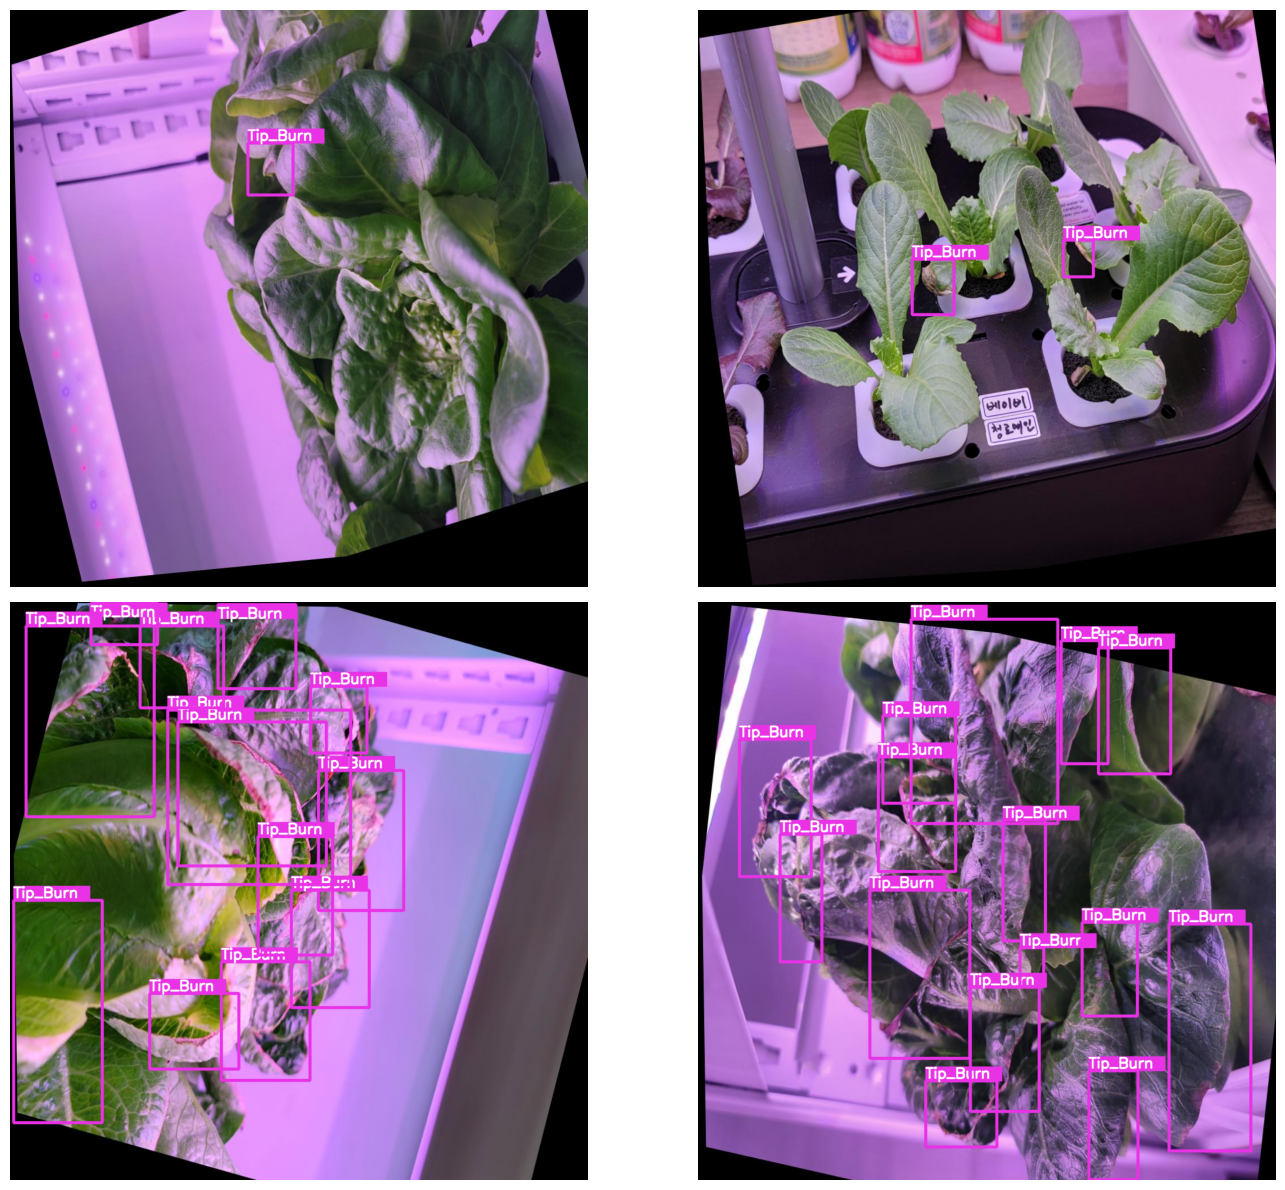

In [21]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir),
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=4,
)

Data Preparation

In [22]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

[2024-01-05 09:53:51] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 350/350 [00:00<00:00, 4256.36it/s]
This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
[2024-01-05 09:53:52] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 38/38 [00:00<00:00, 4018.95it/s]


Transforms and Augmentation

In [23]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [24]:
train_data.dataset.transforms[0]

DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114)

In [25]:
# An example on how to modify augmentations
train_data.dataset.transforms.pop(2)

DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114)

In [26]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_empty_targets': False, 'swap': (2, 0, 1), 'input_dim': (640, 640), 'pad_value': 114),
 DetectionTargetsFormatTransform('additional_samples_count': 0, 'non_empty_targets': False, 'input_format': OrderedDi

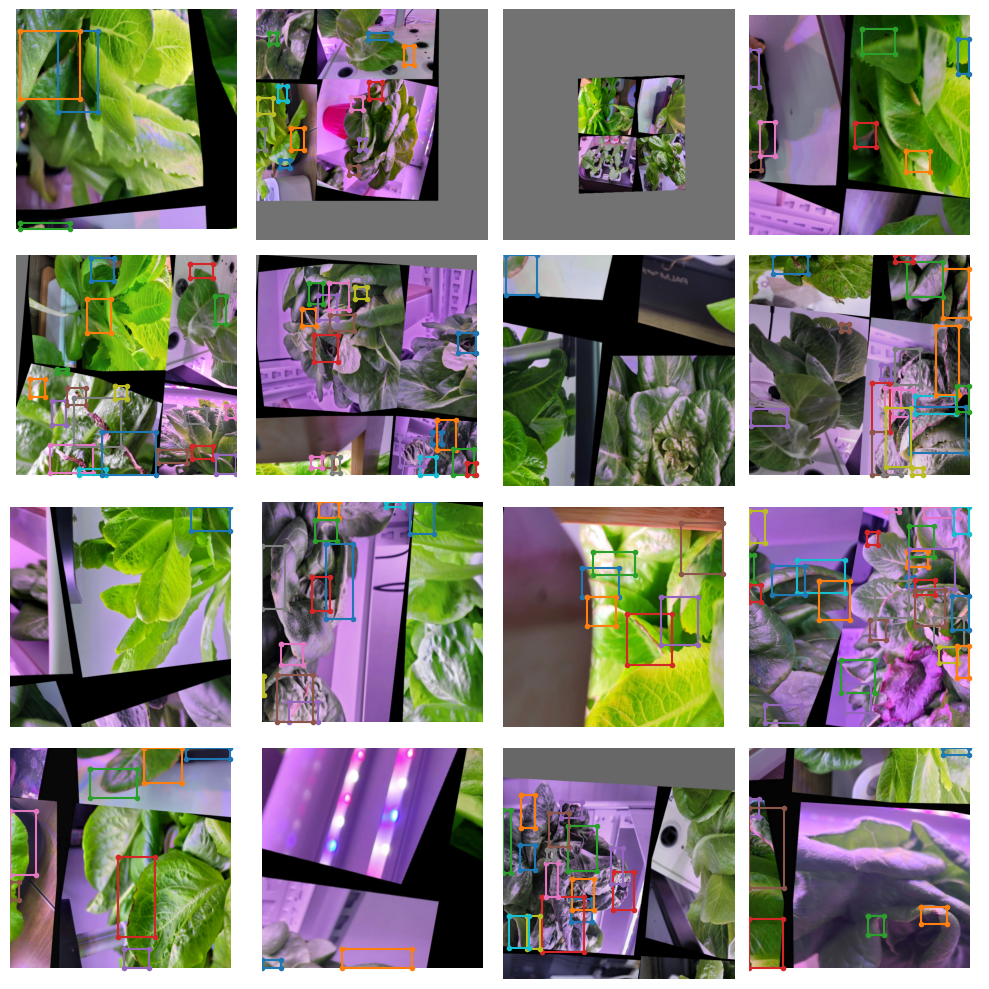

In [27]:
# We visualize the images with augmentation here
train_data.dataset.plot(plot_transformed_data=True)

Prepare Model and Training Parameters

In [28]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

In [29]:
# yolo_nas_s, yolo_nas_m, yolo_nas_l
models_to_train = [
    'yolo_nas_s'
]

In [30]:
CHECKPOINT_DIR = 'checkpoints'

Model Training

In [31]:
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train+'_'+str(EPOCHS)+'e',
        ckpt_root_dir=CHECKPOINT_DIR
    )

    model = models.get(
        model_to_train,
        num_classes=len(dataset_params['classes']),
        pretrained_weights="coco"
    )

    trainer.train(
        model=model,
        training_params=train_params,
        train_loader=train_data,
        valid_loader=val_data
    )

[2024-01-05 09:55:14] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:02<00:00, 32.2MB/s]
[2024-01-05 09:55:17] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s
[2024-01-05 09:55:17] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240105_095517_611038`
[2024-01-05 09:55:17] INFO - sg_trainer.py - Checkpoints directory: checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038
[2024-01-05 09:55:17] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/console_Jan05_09_55_17.txt


Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
[2024-01-05 09:55:25] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            350       

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.6709
│   ├── Ppyoloeloss/loss_iou = 1.1476
│   ├── Ppyoloeloss/loss_dfl = 1.01
│   └── Ppyoloeloss/loss = 3.8284
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.7413
    ├── Ppyoloeloss/loss_iou = 1.0929
    ├── Ppyoloeloss/loss_dfl = 1.0794
    ├── Ppyoloeloss/loss = 3.9136
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0031
    ├── F1@0.50 = 0.0
    ├── Precision@0.50:0.95 = 0.0
    ├── Recall@0.50:0.95 = 0.0
    ├── Map@0.50:0.95 = 0.0007
    └── F1@0.50:0.95 = 0.0



Validating epoch 1: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]
[2024-01-05 09:56:18] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 09:56:18] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.0013809084193781018


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3027
│   │   ├── Epoch N-1      = 1.6709 (↘ -0.3681)
│   │   └── Best until now = 1.6709 (↘ -0.3681)
│   ├── Ppyoloeloss/loss_iou = 1.0695
│   │   ├── Epoch N-1      = 1.1476 (↘ -0.078)
│   │   └── Best until now = 1.1476 (↘ -0.078)
│   ├── Ppyoloeloss/loss_dfl = 0.862
│   │   ├── Epoch N-1      = 1.01   (↘ -0.148)
│   │   └── Best until now = 1.01   (↘ -0.148)
│   └── Ppyoloeloss/loss = 3.2343
│       ├── Epoch N-1      = 3.8284 (↘ -0.5942)
│       └── Best until now = 3.8284 (↘ -0.5942)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3219
    │   ├── Epoch N-1      = 1.7413 (↘ -0.4194)
    │   └── Best until now = 1.7413 (↘ -0.4194)
    ├── Ppyoloeloss/loss_iou = 1.2635
    │   ├── Epoch N-1      = 1.0929 (↗ 0.1706)
    │   └── Best until now = 1.0929 (↗ 0.1706)
    ├── Ppyoloeloss/loss_dfl = 0.9247
    │   ├── Epoch N-1      = 1.0794 (↘ -0.1547)
    │   └── Best until now = 1.0794 (↘ -0.1547)
    ├── Ppyoloeloss/loss = 3.

Validating epoch 2: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]
[2024-01-05 09:56:45] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 09:56:45] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.002635592594742775


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.152
│   │   ├── Epoch N-1      = 1.3027 (↘ -0.1508)
│   │   └── Best until now = 1.3027 (↘ -0.1508)
│   ├── Ppyoloeloss/loss_iou = 0.9751
│   │   ├── Epoch N-1      = 1.0695 (↘ -0.0945)
│   │   └── Best until now = 1.0695 (↘ -0.0945)
│   ├── Ppyoloeloss/loss_dfl = 0.8269
│   │   ├── Epoch N-1      = 0.862  (↘ -0.0351)
│   │   └── Best until now = 0.862  (↘ -0.0351)
│   └── Ppyoloeloss/loss = 2.9539
│       ├── Epoch N-1      = 3.2343 (↘ -0.2803)
│       └── Best until now = 3.2343 (↘ -0.2803)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4124
    │   ├── Epoch N-1      = 1.3219 (↗ 0.0904)
    │   └── Best until now = 1.3219 (↗ 0.0904)
    ├── Ppyoloeloss/loss_iou = 1.2492
    │   ├── Epoch N-1      = 1.2635 (↘ -0.0143)
    │   └── Best until now = 1.0929 (↗ 0.1562)
    ├── Ppyoloeloss/loss_dfl = 0.9934
    │   ├── Epoch N-1      = 0.9247 (↗ 0.0686)
    │   └── Best until now = 0.9247 (↗ 0.0686)
    ├── Ppyoloeloss/loss = 3

Validating epoch 3: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]
[2024-01-05 09:57:14] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 09:57:14] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.01013626903295517


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1523
│   │   ├── Epoch N-1      = 1.152  (↗ 0.0004)
│   │   └── Best until now = 1.152  (↗ 0.0004)
│   ├── Ppyoloeloss/loss_iou = 0.9192
│   │   ├── Epoch N-1      = 0.9751 (↘ -0.0559)
│   │   └── Best until now = 0.9751 (↘ -0.0559)
│   ├── Ppyoloeloss/loss_dfl = 0.7883
│   │   ├── Epoch N-1      = 0.8269 (↘ -0.0386)
│   │   └── Best until now = 0.8269 (↘ -0.0386)
│   └── Ppyoloeloss/loss = 2.8598
│       ├── Epoch N-1      = 2.9539 (↘ -0.0941)
│       └── Best until now = 2.9539 (↘ -0.0941)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.35
    │   ├── Epoch N-1      = 1.4124 (↘ -0.0624)
    │   └── Best until now = 1.3219 (↗ 0.0281)
    ├── Ppyoloeloss/loss_iou = 1.043
    │   ├── Epoch N-1      = 1.2492 (↘ -0.2062)
    │   └── Best until now = 1.0929 (↘ -0.05)
    ├── Ppyoloeloss/loss_dfl = 0.8381
    │   ├── Epoch N-1      = 0.9934 (↘ -0.1553)
    │   └── Best until now = 0.9247 (↘ -0.0867)
    ├── Ppyoloeloss/loss = 3.2

Validating epoch 4: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]
[2024-01-05 09:57:42] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 09:57:42] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.01296111661940813


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1423
│   │   ├── Epoch N-1      = 1.1523 (↘ -0.01)
│   │   └── Best until now = 1.152  (↘ -0.0096)
│   ├── Ppyoloeloss/loss_iou = 0.8725
│   │   ├── Epoch N-1      = 0.9192 (↘ -0.0467)
│   │   └── Best until now = 0.9192 (↘ -0.0467)
│   ├── Ppyoloeloss/loss_dfl = 0.7569
│   │   ├── Epoch N-1      = 0.7883 (↘ -0.0314)
│   │   └── Best until now = 0.7883 (↘ -0.0314)
│   └── Ppyoloeloss/loss = 2.7717
│       ├── Epoch N-1      = 2.8598 (↘ -0.0881)
│       └── Best until now = 2.8598 (↘ -0.0881)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2492
    │   ├── Epoch N-1      = 1.35   (↘ -0.1007)
    │   └── Best until now = 1.3219 (↘ -0.0727)
    ├── Ppyoloeloss/loss_iou = 0.9216
    │   ├── Epoch N-1      = 1.043  (↘ -0.1214)
    │   └── Best until now = 1.043  (↘ -0.1214)
    ├── Ppyoloeloss/loss_dfl = 0.8347
    │   ├── Epoch N-1      = 0.8381 (↘ -0.0033)
    │   └── Best until now = 0.8381 (↘ -0.0033)
    ├── Ppyoloeloss/loss

Validating epoch 5: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]
[2024-01-05 09:58:10] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 09:58:10] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.038352642208337784


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1326
│   │   ├── Epoch N-1      = 1.1423 (↘ -0.0097)
│   │   └── Best until now = 1.1423 (↘ -0.0097)
│   ├── Ppyoloeloss/loss_iou = 0.8365
│   │   ├── Epoch N-1      = 0.8725 (↘ -0.036)
│   │   └── Best until now = 0.8725 (↘ -0.036)
│   ├── Ppyoloeloss/loss_dfl = 0.7349
│   │   ├── Epoch N-1      = 0.7569 (↘ -0.0221)
│   │   └── Best until now = 0.7569 (↘ -0.0221)
│   └── Ppyoloeloss/loss = 2.704
│       ├── Epoch N-1      = 2.7717 (↘ -0.0677)
│       └── Best until now = 2.7717 (↘ -0.0677)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3328
    │   ├── Epoch N-1      = 1.2492 (↗ 0.0836)
    │   └── Best until now = 1.2492 (↗ 0.0836)
    ├── Ppyoloeloss/loss_iou = 0.8328
    │   ├── Epoch N-1      = 0.9216 (↘ -0.0888)
    │   └── Best until now = 0.9216 (↘ -0.0888)
    ├── Ppyoloeloss/loss_dfl = 0.8307
    │   ├── Epoch N-1      = 0.8347 (↘ -0.0041)
    │   └── Best until now = 0.8347 (↘ -0.0041)
    ├── Ppyoloeloss/loss = 

Validating epoch 6: 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]
[2024-01-05 09:58:38] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 09:58:38] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.038573428988456726


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1435
│   │   ├── Epoch N-1      = 1.1326 (↗ 0.0109)
│   │   └── Best until now = 1.1326 (↗ 0.0109)
│   ├── Ppyoloeloss/loss_iou = 0.8045
│   │   ├── Epoch N-1      = 0.8365 (↘ -0.032)
│   │   └── Best until now = 0.8365 (↘ -0.032)
│   ├── Ppyoloeloss/loss_dfl = 0.7445
│   │   ├── Epoch N-1      = 0.7349 (↗ 0.0096)
│   │   └── Best until now = 0.7349 (↗ 0.0096)
│   └── Ppyoloeloss/loss = 2.6925
│       ├── Epoch N-1      = 2.704  (↘ -0.0115)
│       └── Best until now = 2.704  (↘ -0.0115)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3988
    │   ├── Epoch N-1      = 1.3328 (↗ 0.066)
    │   └── Best until now = 1.2492 (↗ 0.1496)
    ├── Ppyoloeloss/loss_iou = 0.8237
    │   ├── Epoch N-1      = 0.8328 (↘ -0.0091)
    │   └── Best until now = 0.8328 (↘ -0.0091)
    ├── Ppyoloeloss/loss_dfl = 0.8648
    │   ├── Epoch N-1      = 0.8307 (↗ 0.0341)
    │   └── Best until now = 0.8307 (↗ 0.0341)
    ├── Ppyoloeloss/loss = 3.0873

Validating epoch 7: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]
[2024-01-05 09:59:07] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 09:59:07] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.04552588611841202


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1304
│   │   ├── Epoch N-1      = 1.1435 (↘ -0.0131)
│   │   └── Best until now = 1.1326 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_iou = 0.7903
│   │   ├── Epoch N-1      = 0.8045 (↘ -0.0142)
│   │   └── Best until now = 0.8045 (↘ -0.0142)
│   ├── Ppyoloeloss/loss_dfl = 0.7245
│   │   ├── Epoch N-1      = 0.7445 (↘ -0.02)
│   │   └── Best until now = 0.7349 (↘ -0.0104)
│   └── Ppyoloeloss/loss = 2.6452
│       ├── Epoch N-1      = 2.6925 (↘ -0.0473)
│       └── Best until now = 2.6925 (↘ -0.0473)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3231
    │   ├── Epoch N-1      = 1.3988 (↘ -0.0757)
    │   └── Best until now = 1.2492 (↗ 0.0738)
    ├── Ppyoloeloss/loss_iou = 0.7824
    │   ├── Epoch N-1      = 0.8237 (↘ -0.0413)
    │   └── Best until now = 0.8237 (↘ -0.0413)
    ├── Ppyoloeloss/loss_dfl = 0.7957
    │   ├── Epoch N-1      = 0.8648 (↘ -0.0691)
    │   └── Best until now = 0.8307 (↘ -0.0349)
    ├── Ppyoloeloss/loss 

Validating epoch 8: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]
[2024-01-05 09:59:37] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 09:59:37] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.051100052893161774


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1173
│   │   ├── Epoch N-1      = 1.1304 (↘ -0.0132)
│   │   └── Best until now = 1.1304 (↘ -0.0132)
│   ├── Ppyoloeloss/loss_iou = 0.784
│   │   ├── Epoch N-1      = 0.7903 (↘ -0.0062)
│   │   └── Best until now = 0.7903 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_dfl = 0.7076
│   │   ├── Epoch N-1      = 0.7245 (↘ -0.0169)
│   │   └── Best until now = 0.7245 (↘ -0.0169)
│   └── Ppyoloeloss/loss = 2.6089
│       ├── Epoch N-1      = 2.6452 (↘ -0.0363)
│       └── Best until now = 2.6452 (↘ -0.0363)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1707
    │   ├── Epoch N-1      = 1.3231 (↘ -0.1523)
    │   └── Best until now = 1.2492 (↘ -0.0785)
    ├── Ppyoloeloss/loss_iou = 0.792
    │   ├── Epoch N-1      = 0.7824 (↗ 0.0096)
    │   └── Best until now = 0.7824 (↗ 0.0096)
    ├── Ppyoloeloss/loss_dfl = 0.8015
    │   ├── Epoch N-1      = 0.7957 (↗ 0.0057)
    │   └── Best until now = 0.7957 (↗ 0.0057)
    ├── Ppyoloeloss/loss = 2

Validating epoch 9: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
[2024-01-05 10:00:09] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:00:09] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.05144302919507027


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1039
│   │   ├── Epoch N-1      = 1.1173 (↘ -0.0134)
│   │   └── Best until now = 1.1173 (↘ -0.0134)
│   ├── Ppyoloeloss/loss_iou = 0.7791
│   │   ├── Epoch N-1      = 0.784  (↘ -0.0049)
│   │   └── Best until now = 0.784  (↘ -0.0049)
│   ├── Ppyoloeloss/loss_dfl = 0.7016
│   │   ├── Epoch N-1      = 0.7076 (↘ -0.006)
│   │   └── Best until now = 0.7076 (↘ -0.006)
│   └── Ppyoloeloss/loss = 2.5846
│       ├── Epoch N-1      = 2.6089 (↘ -0.0243)
│       └── Best until now = 2.6089 (↘ -0.0243)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2044
    │   ├── Epoch N-1      = 1.1707 (↗ 0.0337)
    │   └── Best until now = 1.1707 (↗ 0.0337)
    ├── Ppyoloeloss/loss_iou = 0.7741
    │   ├── Epoch N-1      = 0.792  (↘ -0.0179)
    │   └── Best until now = 0.7824 (↘ -0.0083)
    ├── Ppyoloeloss/loss_dfl = 0.8121
    │   ├── Epoch N-1      = 0.8015 (↗ 0.0106)
    │   └── Best until now = 0.7957 (↗ 0.0163)
    ├── Ppyoloeloss/loss = 2

Validating epoch 10: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
[2024-01-05 10:00:42] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:00:42] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.06501375138759613


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1288
│   │   ├── Epoch N-1      = 1.1039 (↗ 0.0249)
│   │   └── Best until now = 1.1039 (↗ 0.0249)
│   ├── Ppyoloeloss/loss_iou = 0.7706
│   │   ├── Epoch N-1      = 0.7791 (↘ -0.0086)
│   │   └── Best until now = 0.7791 (↘ -0.0086)
│   ├── Ppyoloeloss/loss_dfl = 0.7073
│   │   ├── Epoch N-1      = 0.7016 (↗ 0.0058)
│   │   └── Best until now = 0.7016 (↗ 0.0058)
│   └── Ppyoloeloss/loss = 2.6067
│       ├── Epoch N-1      = 2.5846 (↗ 0.0221)
│       └── Best until now = 2.5846 (↗ 0.0221)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1475
    │   ├── Epoch N-1      = 1.2044 (↘ -0.057)
    │   └── Best until now = 1.1707 (↘ -0.0233)
    ├── Ppyoloeloss/loss_iou = 0.7803
    │   ├── Epoch N-1      = 0.7741 (↗ 0.0062)
    │   └── Best until now = 0.7741 (↗ 0.0062)
    ├── Ppyoloeloss/loss_dfl = 0.8342
    │   ├── Epoch N-1      = 0.8121 (↗ 0.0221)
    │   └── Best until now = 0.7957 (↗ 0.0384)
    ├── Ppyoloeloss/loss = 2.762

Validating epoch 11: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1232
│   │   ├── Epoch N-1      = 1.1288 (↘ -0.0056)
│   │   └── Best until now = 1.1039 (↗ 0.0193)
│   ├── Ppyoloeloss/loss_iou = 0.7654
│   │   ├── Epoch N-1      = 0.7706 (↘ -0.0052)
│   │   └── Best until now = 0.7706 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.7005
│   │   ├── Epoch N-1      = 0.7073 (↘ -0.0068)
│   │   └── Best until now = 0.7016 (↘ -0.0011)
│   └── Ppyoloeloss/loss = 2.5891
│       ├── Epoch N-1      = 2.6067 (↘ -0.0177)
│       └── Best until now = 2.5846 (↗ 0.0045)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1693
    │   ├── Epoch N-1      = 1.1475 (↗ 0.0219)
    │   └── Best until now = 1.1475 (↗ 0.0219)
    ├── Ppyoloeloss/loss_iou = 0.8079
    │   ├── Epoch N-1      = 0.7803 (↗ 0.0276)
    │   └── Best until now = 0.7741 (↗ 0.0338)
    ├── Ppyoloeloss/loss_dfl = 0.8505
    │   ├── Epoch N-1      = 0.8342 (↗ 0.0163)
    │   └── Best until now = 0.7957 (↗ 0.0547)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 12: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1181
│   │   ├── Epoch N-1      = 1.1232 (↘ -0.0051)
│   │   └── Best until now = 1.1039 (↗ 0.0142)
│   ├── Ppyoloeloss/loss_iou = 0.774
│   │   ├── Epoch N-1      = 0.7654 (↗ 0.0086)
│   │   └── Best until now = 0.7654 (↗ 0.0086)
│   ├── Ppyoloeloss/loss_dfl = 0.7056
│   │   ├── Epoch N-1      = 0.7005 (↗ 0.0051)
│   │   └── Best until now = 0.7005 (↗ 0.0051)
│   └── Ppyoloeloss/loss = 2.5976
│       ├── Epoch N-1      = 2.5891 (↗ 0.0086)
│       └── Best until now = 2.5846 (↗ 0.013)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1847
    │   ├── Epoch N-1      = 1.1693 (↗ 0.0154)
    │   └── Best until now = 1.1475 (↗ 0.0372)
    ├── Ppyoloeloss/loss_iou = 0.8208
    │   ├── Epoch N-1      = 0.8079 (↗ 0.013)
    │   └── Best until now = 0.7741 (↗ 0.0467)
    ├── Ppyoloeloss/loss_dfl = 0.8458
    │   ├── Epoch N-1      = 0.8505 (↘ -0.0047)
    │   └── Best until now = 0.7957 (↗ 0.05)
    ├── Ppyoloeloss/loss = 2.8513
    

Validating epoch 13: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]
[2024-01-05 10:02:11] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:02:11] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.06641320884227753


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.123
│   │   ├── Epoch N-1      = 1.1181 (↗ 0.0049)
│   │   └── Best until now = 1.1039 (↗ 0.0191)
│   ├── Ppyoloeloss/loss_iou = 0.7635
│   │   ├── Epoch N-1      = 0.774  (↘ -0.0105)
│   │   └── Best until now = 0.7654 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.7039
│   │   ├── Epoch N-1      = 0.7056 (↘ -0.0017)
│   │   └── Best until now = 0.7005 (↗ 0.0034)
│   └── Ppyoloeloss/loss = 2.5904
│       ├── Epoch N-1      = 2.5976 (↘ -0.0072)
│       └── Best until now = 2.5846 (↗ 0.0058)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1502
    │   ├── Epoch N-1      = 1.1847 (↘ -0.0345)
    │   └── Best until now = 1.1475 (↗ 0.0028)
    ├── Ppyoloeloss/loss_iou = 0.7716
    │   ├── Epoch N-1      = 0.8208 (↘ -0.0492)
    │   └── Best until now = 0.7741 (↘ -0.0025)
    ├── Ppyoloeloss/loss_dfl = 0.7864
    │   ├── Epoch N-1      = 0.8458 (↘ -0.0593)
    │   └── Best until now = 0.7957 (↘ -0.0093)
    ├── Ppyoloeloss/loss = 

Validating epoch 14: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]
[2024-01-05 10:02:41] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:02:41] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.08040118962526321


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.117
│   │   ├── Epoch N-1      = 1.123  (↘ -0.006)
│   │   └── Best until now = 1.1039 (↗ 0.0131)
│   ├── Ppyoloeloss/loss_iou = 0.7505
│   │   ├── Epoch N-1      = 0.7635 (↘ -0.013)
│   │   └── Best until now = 0.7635 (↘ -0.013)
│   ├── Ppyoloeloss/loss_dfl = 0.6877
│   │   ├── Epoch N-1      = 0.7039 (↘ -0.0162)
│   │   └── Best until now = 0.7005 (↘ -0.0128)
│   └── Ppyoloeloss/loss = 2.5552
│       ├── Epoch N-1      = 2.5904 (↘ -0.0352)
│       └── Best until now = 2.5846 (↘ -0.0294)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1482
    │   ├── Epoch N-1      = 1.1502 (↘ -0.002)
    │   └── Best until now = 1.1475 (↗ 0.0008)
    ├── Ppyoloeloss/loss_iou = 0.7616
    │   ├── Epoch N-1      = 0.7716 (↘ -0.0101)
    │   └── Best until now = 0.7716 (↘ -0.0101)
    ├── Ppyoloeloss/loss_dfl = 0.766
    │   ├── Epoch N-1      = 0.7864 (↘ -0.0205)
    │   └── Best until now = 0.7864 (↘ -0.0205)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 15: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1107
│   │   ├── Epoch N-1      = 1.117  (↘ -0.0063)
│   │   └── Best until now = 1.1039 (↗ 0.0068)
│   ├── Ppyoloeloss/loss_iou = 0.7482
│   │   ├── Epoch N-1      = 0.7505 (↘ -0.0024)
│   │   └── Best until now = 0.7505 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.6878
│   │   ├── Epoch N-1      = 0.6877 (↗ 1e-04)
│   │   └── Best until now = 0.6877 (↗ 1e-04)
│   └── Ppyoloeloss/loss = 2.5467
│       ├── Epoch N-1      = 2.5552 (↘ -0.0085)
│       └── Best until now = 2.5552 (↘ -0.0085)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1537
    │   ├── Epoch N-1      = 1.1482 (↗ 0.0055)
    │   └── Best until now = 1.1475 (↗ 0.0063)
    ├── Ppyoloeloss/loss_iou = 0.7585
    │   ├── Epoch N-1      = 0.7616 (↘ -0.003)
    │   └── Best until now = 0.7616 (↘ -0.003)
    ├── Ppyoloeloss/loss_dfl = 0.7673
    │   ├── Epoch N-1      = 0.766  (↗ 0.0013)
    │   └── Best until now = 0.766  (↗ 0.0013)
    ├── Ppyoloeloss/loss = 2.679

Validating epoch 16: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1003
│   │   ├── Epoch N-1      = 1.1107 (↘ -0.0104)
│   │   └── Best until now = 1.1039 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_iou = 0.738
│   │   ├── Epoch N-1      = 0.7482 (↘ -0.0101)
│   │   └── Best until now = 0.7482 (↘ -0.0101)
│   ├── Ppyoloeloss/loss_dfl = 0.6767
│   │   ├── Epoch N-1      = 0.6878 (↘ -0.0112)
│   │   └── Best until now = 0.6877 (↘ -0.011)
│   └── Ppyoloeloss/loss = 2.515
│       ├── Epoch N-1      = 2.5467 (↘ -0.0317)
│       └── Best until now = 2.5467 (↘ -0.0317)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2247
    │   ├── Epoch N-1      = 1.1537 (↗ 0.071)
    │   └── Best until now = 1.1475 (↗ 0.0773)
    ├── Ppyoloeloss/loss_iou = 0.7554
    │   ├── Epoch N-1      = 0.7585 (↘ -0.0031)
    │   └── Best until now = 0.7585 (↘ -0.0031)
    ├── Ppyoloeloss/loss_dfl = 0.808
    │   ├── Epoch N-1      = 0.7673 (↗ 0.0408)
    │   └── Best until now = 0.766  (↗ 0.0421)
    ├── Ppyoloeloss/loss = 2.7

Validating epoch 17: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1044
│   │   ├── Epoch N-1      = 1.1003 (↗ 0.0041)
│   │   └── Best until now = 1.1003 (↗ 0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.7387
│   │   ├── Epoch N-1      = 0.738  (↗ 0.0006)
│   │   └── Best until now = 0.738  (↗ 0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.6771
│   │   ├── Epoch N-1      = 0.6767 (↗ 0.0005)
│   │   └── Best until now = 0.6767 (↗ 0.0005)
│   └── Ppyoloeloss/loss = 2.5202
│       ├── Epoch N-1      = 2.515  (↗ 0.0052)
│       └── Best until now = 2.515  (↗ 0.0052)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1553
    │   ├── Epoch N-1      = 1.2247 (↘ -0.0694)
    │   └── Best until now = 1.1475 (↗ 0.0078)
    ├── Ppyoloeloss/loss_iou = 0.753
    │   ├── Epoch N-1      = 0.7554 (↘ -0.0024)
    │   └── Best until now = 0.7554 (↘ -0.0024)
    ├── Ppyoloeloss/loss_dfl = 0.7963
    │   ├── Epoch N-1      = 0.808  (↘ -0.0117)
    │   └── Best until now = 0.766  (↗ 0.0303)
    ├── Ppyoloeloss/loss = 2.704

Validating epoch 18: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1059
│   │   ├── Epoch N-1      = 1.1044 (↗ 0.0015)
│   │   └── Best until now = 1.1003 (↗ 0.0056)
│   ├── Ppyoloeloss/loss_iou = 0.7383
│   │   ├── Epoch N-1      = 0.7387 (↘ -0.0004)
│   │   └── Best until now = 0.738  (↗ 0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.6843
│   │   ├── Epoch N-1      = 0.6771 (↗ 0.0072)
│   │   └── Best until now = 0.6767 (↗ 0.0077)
│   └── Ppyoloeloss/loss = 2.5285
│       ├── Epoch N-1      = 2.5202 (↗ 0.0083)
│       └── Best until now = 2.515  (↗ 0.0135)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1664
    │   ├── Epoch N-1      = 1.1553 (↗ 0.0111)
    │   └── Best until now = 1.1475 (↗ 0.0189)
    ├── Ppyoloeloss/loss_iou = 0.7576
    │   ├── Epoch N-1      = 0.753  (↗ 0.0046)
    │   └── Best until now = 0.753  (↗ 0.0046)
    ├── Ppyoloeloss/loss_dfl = 0.7835
    │   ├── Epoch N-1      = 0.7963 (↘ -0.0128)
    │   └── Best until now = 0.766  (↗ 0.0176)
    ├── Ppyoloeloss/loss = 2.7075

Validating epoch 19: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]
[2024-01-05 10:05:08] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:05:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.09250937402248383


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0912
│   │   ├── Epoch N-1      = 1.1059 (↘ -0.0147)
│   │   └── Best until now = 1.1003 (↘ -0.0091)
│   ├── Ppyoloeloss/loss_iou = 0.7394
│   │   ├── Epoch N-1      = 0.7383 (↗ 0.0011)
│   │   └── Best until now = 0.738  (↗ 0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.6608
│   │   ├── Epoch N-1      = 0.6843 (↘ -0.0235)
│   │   └── Best until now = 0.6767 (↘ -0.0159)
│   └── Ppyoloeloss/loss = 2.4913
│       ├── Epoch N-1      = 2.5285 (↘ -0.0372)
│       └── Best until now = 2.515  (↘ -0.0237)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1403
    │   ├── Epoch N-1      = 1.1664 (↘ -0.0261)
    │   └── Best until now = 1.1475 (↘ -0.0072)
    ├── Ppyoloeloss/loss_iou = 0.7498
    │   ├── Epoch N-1      = 0.7576 (↘ -0.0078)
    │   └── Best until now = 0.753  (↘ -0.0032)
    ├── Ppyoloeloss/loss_dfl = 0.7601
    │   ├── Epoch N-1      = 0.7835 (↘ -0.0235)
    │   └── Best until now = 0.766  (↘ -0.0059)
    ├── Ppyoloeloss/los

Validating epoch 20: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0955
│   │   ├── Epoch N-1      = 1.0912 (↗ 0.0043)
│   │   └── Best until now = 1.0912 (↗ 0.0043)
│   ├── Ppyoloeloss/loss_iou = 0.7304
│   │   ├── Epoch N-1      = 0.7394 (↘ -0.0089)
│   │   └── Best until now = 0.738  (↘ -0.0076)
│   ├── Ppyoloeloss/loss_dfl = 0.6679
│   │   ├── Epoch N-1      = 0.6608 (↗ 0.0071)
│   │   └── Best until now = 0.6608 (↗ 0.0071)
│   └── Ppyoloeloss/loss = 2.4939
│       ├── Epoch N-1      = 2.4913 (↗ 0.0025)
│       └── Best until now = 2.4913 (↗ 0.0025)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1349
    │   ├── Epoch N-1      = 1.1403 (↘ -0.0054)
    │   └── Best until now = 1.1403 (↘ -0.0054)
    ├── Ppyoloeloss/loss_iou = 0.7555
    │   ├── Epoch N-1      = 0.7498 (↗ 0.0057)
    │   └── Best until now = 0.7498 (↗ 0.0057)
    ├── Ppyoloeloss/loss_dfl = 0.7726
    │   ├── Epoch N-1      = 0.7601 (↗ 0.0125)
    │   └── Best until now = 0.7601 (↗ 0.0125)
    ├── Ppyoloeloss/loss = 2.66

Validating epoch 21: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1056
│   │   ├── Epoch N-1      = 1.0955 (↗ 0.0101)
│   │   └── Best until now = 1.0912 (↗ 0.0144)
│   ├── Ppyoloeloss/loss_iou = 0.7176
│   │   ├── Epoch N-1      = 0.7304 (↘ -0.0128)
│   │   └── Best until now = 0.7304 (↘ -0.0128)
│   ├── Ppyoloeloss/loss_dfl = 0.6654
│   │   ├── Epoch N-1      = 0.6679 (↘ -0.0025)
│   │   └── Best until now = 0.6608 (↗ 0.0047)
│   └── Ppyoloeloss/loss = 2.4887
│       ├── Epoch N-1      = 2.4939 (↘ -0.0052)
│       └── Best until now = 2.4913 (↘ -0.0027)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1818
    │   ├── Epoch N-1      = 1.1349 (↗ 0.0469)
    │   └── Best until now = 1.1349 (↗ 0.0469)
    ├── Ppyoloeloss/loss_iou = 0.7621
    │   ├── Epoch N-1      = 0.7555 (↗ 0.0066)
    │   └── Best until now = 0.7498 (↗ 0.0123)
    ├── Ppyoloeloss/loss_dfl = 0.7838
    │   ├── Epoch N-1      = 0.7726 (↗ 0.0112)
    │   └── Best until now = 0.7601 (↗ 0.0238)
    ├── Ppyoloeloss/loss = 2.7

Validating epoch 22: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1046
│   │   ├── Epoch N-1      = 1.1056 (↘ -0.001)
│   │   └── Best until now = 1.0912 (↗ 0.0134)
│   ├── Ppyoloeloss/loss_iou = 0.7237
│   │   ├── Epoch N-1      = 0.7176 (↗ 0.0061)
│   │   └── Best until now = 0.7176 (↗ 0.0061)
│   ├── Ppyoloeloss/loss_dfl = 0.6683
│   │   ├── Epoch N-1      = 0.6654 (↗ 0.0029)
│   │   └── Best until now = 0.6608 (↗ 0.0075)
│   └── Ppyoloeloss/loss = 2.4966
│       ├── Epoch N-1      = 2.4887 (↗ 0.0079)
│       └── Best until now = 2.4887 (↗ 0.0079)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1276
    │   ├── Epoch N-1      = 1.1818 (↘ -0.0542)
    │   └── Best until now = 1.1349 (↘ -0.0073)
    ├── Ppyoloeloss/loss_iou = 0.7444
    │   ├── Epoch N-1      = 0.7621 (↘ -0.0178)
    │   └── Best until now = 0.7498 (↘ -0.0054)
    ├── Ppyoloeloss/loss_dfl = 0.7579
    │   ├── Epoch N-1      = 0.7838 (↘ -0.0259)
    │   └── Best until now = 0.7601 (↘ -0.0021)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 23: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1081
│   │   ├── Epoch N-1      = 1.1046 (↗ 0.0035)
│   │   └── Best until now = 1.0912 (↗ 0.0169)
│   ├── Ppyoloeloss/loss_iou = 0.7238
│   │   ├── Epoch N-1      = 0.7237 (↗ 0.0)
│   │   └── Best until now = 0.7176 (↗ 0.0061)
│   ├── Ppyoloeloss/loss_dfl = 0.6646
│   │   ├── Epoch N-1      = 0.6683 (↘ -0.0037)
│   │   └── Best until now = 0.6608 (↗ 0.0039)
│   └── Ppyoloeloss/loss = 2.4965
│       ├── Epoch N-1      = 2.4966 (↘ -1e-04)
│       └── Best until now = 2.4887 (↗ 0.0078)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1371
    │   ├── Epoch N-1      = 1.1276 (↗ 0.0094)
    │   └── Best until now = 1.1276 (↗ 0.0094)
    ├── Ppyoloeloss/loss_iou = 0.7617
    │   ├── Epoch N-1      = 0.7444 (↗ 0.0173)
    │   └── Best until now = 0.7444 (↗ 0.0173)
    ├── Ppyoloeloss/loss_dfl = 0.7957
    │   ├── Epoch N-1      = 0.7579 (↗ 0.0377)
    │   └── Best until now = 0.7579 (↗ 0.0377)
    ├── Ppyoloeloss/loss = 2.6944
   

Validating epoch 24: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1041
│   │   ├── Epoch N-1      = 1.1081 (↘ -0.004)
│   │   └── Best until now = 1.0912 (↗ 0.0129)
│   ├── Ppyoloeloss/loss_iou = 0.7336
│   │   ├── Epoch N-1      = 0.7238 (↗ 0.0099)
│   │   └── Best until now = 0.7176 (↗ 0.016)
│   ├── Ppyoloeloss/loss_dfl = 0.6719
│   │   ├── Epoch N-1      = 0.6646 (↗ 0.0073)
│   │   └── Best until now = 0.6608 (↗ 0.0112)
│   └── Ppyoloeloss/loss = 2.5096
│       ├── Epoch N-1      = 2.4965 (↗ 0.0131)
│       └── Best until now = 2.4887 (↗ 0.021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.142
    │   ├── Epoch N-1      = 1.1371 (↗ 0.0049)
    │   └── Best until now = 1.1276 (↗ 0.0143)
    ├── Ppyoloeloss/loss_iou = 0.7415
    │   ├── Epoch N-1      = 0.7617 (↘ -0.0202)
    │   └── Best until now = 0.7444 (↘ -0.0029)
    ├── Ppyoloeloss/loss_dfl = 0.7538
    │   ├── Epoch N-1      = 0.7957 (↘ -0.0419)
    │   └── Best until now = 0.7579 (↘ -0.0041)
    ├── Ppyoloeloss/loss = 2.6372


Validating epoch 25: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0881
│   │   ├── Epoch N-1      = 1.1041 (↘ -0.016)
│   │   └── Best until now = 1.0912 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.7184
│   │   ├── Epoch N-1      = 0.7336 (↘ -0.0152)
│   │   └── Best until now = 0.7176 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.6559
│   │   ├── Epoch N-1      = 0.6719 (↘ -0.016)
│   │   └── Best until now = 0.6608 (↘ -0.0048)
│   └── Ppyoloeloss/loss = 2.4624
│       ├── Epoch N-1      = 2.5096 (↘ -0.0472)
│       └── Best until now = 2.4887 (↘ -0.0262)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1438
    │   ├── Epoch N-1      = 1.142  (↗ 0.0018)
    │   └── Best until now = 1.1276 (↗ 0.0162)
    ├── Ppyoloeloss/loss_iou = 0.746
    │   ├── Epoch N-1      = 0.7415 (↗ 0.0045)
    │   └── Best until now = 0.7415 (↗ 0.0045)
    ├── Ppyoloeloss/loss_dfl = 0.7558
    │   ├── Epoch N-1      = 0.7538 (↗ 0.002)
    │   └── Best until now = 0.7538 (↗ 0.002)
    ├── Ppyoloeloss/loss = 2.6456

Validating epoch 26: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]
[2024-01-05 10:08:36] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:08:36] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.09436588734388351


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1023
│   │   ├── Epoch N-1      = 1.0881 (↗ 0.0142)
│   │   └── Best until now = 1.0881 (↗ 0.0142)
│   ├── Ppyoloeloss/loss_iou = 0.7207
│   │   ├── Epoch N-1      = 0.7184 (↗ 0.0023)
│   │   └── Best until now = 0.7176 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.654
│   │   ├── Epoch N-1      = 0.6559 (↘ -0.0019)
│   │   └── Best until now = 0.6559 (↘ -0.0019)
│   └── Ppyoloeloss/loss = 2.4771
│       ├── Epoch N-1      = 2.4624 (↗ 0.0146)
│       └── Best until now = 2.4624 (↗ 0.0146)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1302
    │   ├── Epoch N-1      = 1.1438 (↘ -0.0136)
    │   └── Best until now = 1.1276 (↗ 0.0026)
    ├── Ppyoloeloss/loss_iou = 0.756
    │   ├── Epoch N-1      = 0.746  (↗ 0.01)
    │   └── Best until now = 0.7415 (↗ 0.0145)
    ├── Ppyoloeloss/loss_dfl = 0.771
    │   ├── Epoch N-1      = 0.7558 (↗ 0.0152)
    │   └── Best until now = 0.7538 (↗ 0.0172)
    ├── Ppyoloeloss/loss = 2.6573
   

Validating epoch 27: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0885
│   │   ├── Epoch N-1      = 1.1023 (↘ -0.0139)
│   │   └── Best until now = 1.0881 (↗ 0.0004)
│   ├── Ppyoloeloss/loss_iou = 0.7144
│   │   ├── Epoch N-1      = 0.7207 (↘ -0.0063)
│   │   └── Best until now = 0.7176 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.6491
│   │   ├── Epoch N-1      = 0.654  (↘ -0.0049)
│   │   └── Best until now = 0.654  (↘ -0.0049)
│   └── Ppyoloeloss/loss = 2.452
│       ├── Epoch N-1      = 2.4771 (↘ -0.0251)
│       └── Best until now = 2.4624 (↘ -0.0104)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1332
    │   ├── Epoch N-1      = 1.1302 (↗ 0.003)
    │   └── Best until now = 1.1276 (↗ 0.0056)
    ├── Ppyoloeloss/loss_iou = 0.7399
    │   ├── Epoch N-1      = 0.756  (↘ -0.0161)
    │   └── Best until now = 0.7415 (↘ -0.0015)
    ├── Ppyoloeloss/loss_dfl = 0.7421
    │   ├── Epoch N-1      = 0.771  (↘ -0.0289)
    │   └── Best until now = 0.7538 (↘ -0.0117)
    ├── Ppyoloeloss/loss =

Validating epoch 28: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1
│   │   ├── Epoch N-1      = 1.0885 (↗ 0.0116)
│   │   └── Best until now = 1.0881 (↗ 0.0119)
│   ├── Ppyoloeloss/loss_iou = 0.7305
│   │   ├── Epoch N-1      = 0.7144 (↗ 0.0161)
│   │   └── Best until now = 0.7144 (↗ 0.0161)
│   ├── Ppyoloeloss/loss_dfl = 0.658
│   │   ├── Epoch N-1      = 0.6491 (↗ 0.0089)
│   │   └── Best until now = 0.6491 (↗ 0.0089)
│   └── Ppyoloeloss/loss = 2.4886
│       ├── Epoch N-1      = 2.452  (↗ 0.0366)
│       └── Best until now = 2.452  (↗ 0.0366)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.116
    │   ├── Epoch N-1      = 1.1332 (↘ -0.0172)
    │   └── Best until now = 1.1276 (↘ -0.0116)
    ├── Ppyoloeloss/loss_iou = 0.7569
    │   ├── Epoch N-1      = 0.7399 (↗ 0.0169)
    │   └── Best until now = 0.7399 (↗ 0.0169)
    ├── Ppyoloeloss/loss_dfl = 0.7823
    │   ├── Epoch N-1      = 0.7421 (↗ 0.0402)
    │   └── Best until now = 0.7421 (↗ 0.0402)
    ├── Ppyoloeloss/loss = 2.6552
    

Validating epoch 29: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0914
│   │   ├── Epoch N-1      = 1.1    (↘ -0.0086)
│   │   └── Best until now = 1.0881 (↗ 0.0034)
│   ├── Ppyoloeloss/loss_iou = 0.7207
│   │   ├── Epoch N-1      = 0.7305 (↘ -0.0098)
│   │   └── Best until now = 0.7144 (↗ 0.0063)
│   ├── Ppyoloeloss/loss_dfl = 0.6536
│   │   ├── Epoch N-1      = 0.658  (↘ -0.0045)
│   │   └── Best until now = 0.6491 (↗ 0.0045)
│   └── Ppyoloeloss/loss = 2.4657
│       ├── Epoch N-1      = 2.4886 (↘ -0.0229)
│       └── Best until now = 2.452  (↗ 0.0137)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1303
    │   ├── Epoch N-1      = 1.116  (↗ 0.0143)
    │   └── Best until now = 1.116  (↗ 0.0143)
    ├── Ppyoloeloss/loss_iou = 0.7353
    │   ├── Epoch N-1      = 0.7569 (↘ -0.0216)
    │   └── Best until now = 0.7399 (↘ -0.0046)
    ├── Ppyoloeloss/loss_dfl = 0.7474
    │   ├── Epoch N-1      = 0.7823 (↘ -0.0349)
    │   └── Best until now = 0.7421 (↗ 0.0053)
    ├── Ppyoloeloss/loss = 2

Validating epoch 30: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


SUMMARY OF EPOCH 30
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1147
│   │   ├── Epoch N-1      = 1.0914 (↗ 0.0233)
│   │   └── Best until now = 1.0881 (↗ 0.0266)
│   ├── Ppyoloeloss/loss_iou = 0.706
│   │   ├── Epoch N-1      = 0.7207 (↘ -0.0147)
│   │   └── Best until now = 0.7144 (↘ -0.0084)
│   ├── Ppyoloeloss/loss_dfl = 0.6685
│   │   ├── Epoch N-1      = 0.6536 (↗ 0.0149)
│   │   └── Best until now = 0.6491 (↗ 0.0194)
│   └── Ppyoloeloss/loss = 2.4892
│       ├── Epoch N-1      = 2.4657 (↗ 0.0235)
│       └── Best until now = 2.452  (↗ 0.0372)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1333
    │   ├── Epoch N-1      = 1.1303 (↗ 0.003)
    │   └── Best until now = 1.116  (↗ 0.0173)
    ├── Ppyoloeloss/loss_iou = 0.7262
    │   ├── Epoch N-1      = 0.7353 (↘ -0.0091)
    │   └── Best until now = 0.7353 (↘ -0.0091)
    ├── Ppyoloeloss/loss_dfl = 0.7555
    │   ├── Epoch N-1      = 0.7474 (↗ 0.0081)
    │   └── Best until now = 0.7421 (↗ 0.0134)
    ├── Ppyoloeloss/loss = 2.615


Validating epoch 31: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


SUMMARY OF EPOCH 31
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0993
│   │   ├── Epoch N-1      = 1.1147 (↘ -0.0154)
│   │   └── Best until now = 1.0881 (↗ 0.0112)
│   ├── Ppyoloeloss/loss_iou = 0.7108
│   │   ├── Epoch N-1      = 0.706  (↗ 0.0048)
│   │   └── Best until now = 0.706  (↗ 0.0048)
│   ├── Ppyoloeloss/loss_dfl = 0.6575
│   │   ├── Epoch N-1      = 0.6685 (↘ -0.011)
│   │   └── Best until now = 0.6491 (↗ 0.0084)
│   └── Ppyoloeloss/loss = 2.4676
│       ├── Epoch N-1      = 2.4892 (↘ -0.0216)
│       └── Best until now = 2.452  (↗ 0.0156)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1407
    │   ├── Epoch N-1      = 1.1333 (↗ 0.0074)
    │   └── Best until now = 1.116  (↗ 0.0247)
    ├── Ppyoloeloss/loss_iou = 0.7367
    │   ├── Epoch N-1      = 0.7262 (↗ 0.0105)
    │   └── Best until now = 0.7262 (↗ 0.0105)
    ├── Ppyoloeloss/loss_dfl = 0.7625
    │   ├── Epoch N-1      = 0.7555 (↗ 0.007)
    │   └── Best until now = 0.7421 (↗ 0.0204)
    ├── Ppyoloeloss/loss = 2.6399


Validating epoch 32: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]
[2024-01-05 10:11:34] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:11:34] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.09679915755987167


SUMMARY OF EPOCH 32
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0915
│   │   ├── Epoch N-1      = 1.0993 (↘ -0.0078)
│   │   └── Best until now = 1.0881 (↗ 0.0034)
│   ├── Ppyoloeloss/loss_iou = 0.7124
│   │   ├── Epoch N-1      = 0.7108 (↗ 0.0017)
│   │   └── Best until now = 0.706  (↗ 0.0065)
│   ├── Ppyoloeloss/loss_dfl = 0.6487
│   │   ├── Epoch N-1      = 0.6575 (↘ -0.0089)
│   │   └── Best until now = 0.6491 (↘ -0.0004)
│   └── Ppyoloeloss/loss = 2.4526
│       ├── Epoch N-1      = 2.4676 (↘ -0.015)
│       └── Best until now = 2.452  (↗ 0.0006)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1541
    │   ├── Epoch N-1      = 1.1407 (↗ 0.0134)
    │   └── Best until now = 1.116  (↗ 0.0381)
    ├── Ppyoloeloss/loss_iou = 0.74
    │   ├── Epoch N-1      = 0.7367 (↗ 0.0033)
    │   └── Best until now = 0.7262 (↗ 0.0138)
    ├── Ppyoloeloss/loss_dfl = 0.7398
    │   ├── Epoch N-1      = 0.7625 (↘ -0.0226)
    │   └── Best until now = 0.7421 (↘ -0.0023)
    ├── Ppyoloeloss/loss = 2.633

Validating epoch 33: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


SUMMARY OF EPOCH 33
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1094
│   │   ├── Epoch N-1      = 1.0915 (↗ 0.0179)
│   │   └── Best until now = 1.0881 (↗ 0.0214)
│   ├── Ppyoloeloss/loss_iou = 0.7042
│   │   ├── Epoch N-1      = 0.7124 (↘ -0.0083)
│   │   └── Best until now = 0.706  (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.6816
│   │   ├── Epoch N-1      = 0.6487 (↗ 0.0329)
│   │   └── Best until now = 0.6487 (↗ 0.0329)
│   └── Ppyoloeloss/loss = 2.4952
│       ├── Epoch N-1      = 2.4526 (↗ 0.0426)
│       └── Best until now = 2.452  (↗ 0.0433)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.144
    │   ├── Epoch N-1      = 1.1541 (↘ -0.0102)
    │   └── Best until now = 1.116  (↗ 0.028)
    ├── Ppyoloeloss/loss_iou = 0.7503
    │   ├── Epoch N-1      = 0.74   (↗ 0.0103)
    │   └── Best until now = 0.7262 (↗ 0.0241)
    ├── Ppyoloeloss/loss_dfl = 0.7736
    │   ├── Epoch N-1      = 0.7398 (↗ 0.0338)
    │   └── Best until now = 0.7398 (↗ 0.0338)
    ├── Ppyoloeloss/loss = 2.6679


Validating epoch 34: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 34
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.099
│   │   ├── Epoch N-1      = 1.1094 (↘ -0.0104)
│   │   └── Best until now = 1.0881 (↗ 0.011)
│   ├── Ppyoloeloss/loss_iou = 0.702
│   │   ├── Epoch N-1      = 0.7042 (↘ -0.0021)
│   │   └── Best until now = 0.7042 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.6508
│   │   ├── Epoch N-1      = 0.6816 (↘ -0.0308)
│   │   └── Best until now = 0.6487 (↗ 0.0021)
│   └── Ppyoloeloss/loss = 2.4519
│       ├── Epoch N-1      = 2.4952 (↘ -0.0434)
│       └── Best until now = 2.452  (↘ -1e-04)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1499
    │   ├── Epoch N-1      = 1.144  (↗ 0.0059)
    │   └── Best until now = 1.116  (↗ 0.0339)
    ├── Ppyoloeloss/loss_iou = 0.7419
    │   ├── Epoch N-1      = 0.7503 (↘ -0.0083)
    │   └── Best until now = 0.7262 (↗ 0.0157)
    ├── Ppyoloeloss/loss_dfl = 0.7744
    │   ├── Epoch N-1      = 0.7736 (↗ 0.0008)
    │   └── Best until now = 0.7398 (↗ 0.0346)
    ├── Ppyoloeloss/loss = 2.666

Validating epoch 35: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]
[2024-01-05 10:13:03] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:13:03] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.10534141212701797


SUMMARY OF EPOCH 35
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1212
│   │   ├── Epoch N-1      = 1.099  (↗ 0.0221)
│   │   └── Best until now = 1.0881 (↗ 0.0331)
│   ├── Ppyoloeloss/loss_iou = 0.7015
│   │   ├── Epoch N-1      = 0.702  (↘ -0.0005)
│   │   └── Best until now = 0.702  (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.6641
│   │   ├── Epoch N-1      = 0.6508 (↗ 0.0134)
│   │   └── Best until now = 0.6487 (↗ 0.0155)
│   └── Ppyoloeloss/loss = 2.4868
│       ├── Epoch N-1      = 2.4519 (↗ 0.035)
│       └── Best until now = 2.4519 (↗ 0.035)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1432
    │   ├── Epoch N-1      = 1.1499 (↘ -0.0066)
    │   └── Best until now = 1.116  (↗ 0.0272)
    ├── Ppyoloeloss/loss_iou = 0.7308
    │   ├── Epoch N-1      = 0.7419 (↘ -0.0111)
    │   └── Best until now = 0.7262 (↗ 0.0046)
    ├── Ppyoloeloss/loss_dfl = 0.7455
    │   ├── Epoch N-1      = 0.7744 (↘ -0.0289)
    │   └── Best until now = 0.7398 (↗ 0.0057)
    ├── Ppyoloeloss/loss = 2.619

Validating epoch 36: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]
[2024-01-05 10:13:35] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:13:35] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.10773217678070068


SUMMARY OF EPOCH 36
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.089
│   │   ├── Epoch N-1      = 1.1212 (↘ -0.0322)
│   │   └── Best until now = 1.0881 (↗ 0.0009)
│   ├── Ppyoloeloss/loss_iou = 0.7072
│   │   ├── Epoch N-1      = 0.7015 (↗ 0.0057)
│   │   └── Best until now = 0.7015 (↗ 0.0057)
│   ├── Ppyoloeloss/loss_dfl = 0.6449
│   │   ├── Epoch N-1      = 0.6641 (↘ -0.0193)
│   │   └── Best until now = 0.6487 (↘ -0.0038)
│   └── Ppyoloeloss/loss = 2.441
│       ├── Epoch N-1      = 2.4868 (↘ -0.0458)
│       └── Best until now = 2.4519 (↘ -0.0108)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1322
    │   ├── Epoch N-1      = 1.1432 (↘ -0.011)
    │   └── Best until now = 1.116  (↗ 0.0162)
    ├── Ppyoloeloss/loss_iou = 0.7227
    │   ├── Epoch N-1      = 0.7308 (↘ -0.0081)
    │   └── Best until now = 0.7262 (↘ -0.0035)
    ├── Ppyoloeloss/loss_dfl = 0.7525
    │   ├── Epoch N-1      = 0.7455 (↗ 0.007)
    │   └── Best until now = 0.7398 (↗ 0.0127)
    ├── Ppyoloeloss/loss = 2.60

Validating epoch 37: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 37
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0838
│   │   ├── Epoch N-1      = 1.089  (↘ -0.0052)
│   │   └── Best until now = 1.0881 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_iou = 0.7094
│   │   ├── Epoch N-1      = 0.7072 (↗ 0.0022)
│   │   └── Best until now = 0.7015 (↗ 0.0079)
│   ├── Ppyoloeloss/loss_dfl = 0.6497
│   │   ├── Epoch N-1      = 0.6449 (↗ 0.0048)
│   │   └── Best until now = 0.6449 (↗ 0.0048)
│   └── Ppyoloeloss/loss = 2.4429
│       ├── Epoch N-1      = 2.441  (↗ 0.0018)
│       └── Best until now = 2.441  (↗ 0.0018)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1535
    │   ├── Epoch N-1      = 1.1322 (↗ 0.0213)
    │   └── Best until now = 1.116  (↗ 0.0376)
    ├── Ppyoloeloss/loss_iou = 0.7285
    │   ├── Epoch N-1      = 0.7227 (↗ 0.0059)
    │   └── Best until now = 0.7227 (↗ 0.0059)
    ├── Ppyoloeloss/loss_dfl = 0.7599
    │   ├── Epoch N-1      = 0.7525 (↗ 0.0074)
    │   └── Best until now = 0.7398 (↗ 0.0201)
    ├── Ppyoloeloss/loss = 2.642


Validating epoch 38: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 38
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1028
│   │   ├── Epoch N-1      = 1.0838 (↗ 0.019)
│   │   └── Best until now = 1.0838 (↗ 0.019)
│   ├── Ppyoloeloss/loss_iou = 0.7001
│   │   ├── Epoch N-1      = 0.7094 (↘ -0.0093)
│   │   └── Best until now = 0.7015 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.656
│   │   ├── Epoch N-1      = 0.6497 (↗ 0.0064)
│   │   └── Best until now = 0.6449 (↗ 0.0112)
│   └── Ppyoloeloss/loss = 2.4589
│       ├── Epoch N-1      = 2.4429 (↗ 0.0161)
│       └── Best until now = 2.441  (↗ 0.0179)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1211
    │   ├── Epoch N-1      = 1.1535 (↘ -0.0325)
    │   └── Best until now = 1.116  (↗ 0.0051)
    ├── Ppyoloeloss/loss_iou = 0.7386
    │   ├── Epoch N-1      = 0.7285 (↗ 0.0101)
    │   └── Best until now = 0.7227 (↗ 0.0159)
    ├── Ppyoloeloss/loss_dfl = 0.7358
    │   ├── Epoch N-1      = 0.7599 (↘ -0.0241)
    │   └── Best until now = 0.7398 (↘ -0.004)
    ├── Ppyoloeloss/loss = 2.5955


Validating epoch 39: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 39
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1059
│   │   ├── Epoch N-1      = 1.1028 (↗ 0.003)
│   │   └── Best until now = 1.0838 (↗ 0.022)
│   ├── Ppyoloeloss/loss_iou = 0.6929
│   │   ├── Epoch N-1      = 0.7001 (↘ -0.0072)
│   │   └── Best until now = 0.7001 (↘ -0.0072)
│   ├── Ppyoloeloss/loss_dfl = 0.6481
│   │   ├── Epoch N-1      = 0.656  (↘ -0.0079)
│   │   └── Best until now = 0.6449 (↗ 0.0032)
│   └── Ppyoloeloss/loss = 2.4468
│       ├── Epoch N-1      = 2.4589 (↘ -0.0121)
│       └── Best until now = 2.441  (↗ 0.0058)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1317
    │   ├── Epoch N-1      = 1.1211 (↗ 0.0106)
    │   └── Best until now = 1.116  (↗ 0.0157)
    ├── Ppyoloeloss/loss_iou = 0.7519
    │   ├── Epoch N-1      = 0.7386 (↗ 0.0133)
    │   └── Best until now = 0.7227 (↗ 0.0292)
    ├── Ppyoloeloss/loss_dfl = 0.7843
    │   ├── Epoch N-1      = 0.7358 (↗ 0.0484)
    │   └── Best until now = 0.7358 (↗ 0.0484)
    ├── Ppyoloeloss/loss = 2.6678

Validating epoch 40: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


SUMMARY OF EPOCH 40
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0928
│   │   ├── Epoch N-1      = 1.1059 (↘ -0.0131)
│   │   └── Best until now = 1.0838 (↗ 0.009)
│   ├── Ppyoloeloss/loss_iou = 0.7071
│   │   ├── Epoch N-1      = 0.6929 (↗ 0.0142)
│   │   └── Best until now = 0.6929 (↗ 0.0142)
│   ├── Ppyoloeloss/loss_dfl = 0.6447
│   │   ├── Epoch N-1      = 0.6481 (↘ -0.0034)
│   │   └── Best until now = 0.6449 (↘ -1e-04)
│   └── Ppyoloeloss/loss = 2.4446
│       ├── Epoch N-1      = 2.4468 (↘ -0.0022)
│       └── Best until now = 2.441  (↗ 0.0035)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1266
    │   ├── Epoch N-1      = 1.1317 (↘ -0.005)
    │   └── Best until now = 1.116  (↗ 0.0106)
    ├── Ppyoloeloss/loss_iou = 0.744
    │   ├── Epoch N-1      = 0.7519 (↘ -0.0079)
    │   └── Best until now = 0.7227 (↗ 0.0213)
    ├── Ppyoloeloss/loss_dfl = 0.7817
    │   ├── Epoch N-1      = 0.7843 (↘ -0.0026)
    │   └── Best until now = 0.7358 (↗ 0.0459)
    ├── Ppyoloeloss/loss = 2.652

Validating epoch 41: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 41
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0847
│   │   ├── Epoch N-1      = 1.0928 (↘ -0.0081)
│   │   └── Best until now = 1.0838 (↗ 0.0009)
│   ├── Ppyoloeloss/loss_iou = 0.6963
│   │   ├── Epoch N-1      = 0.7071 (↘ -0.0108)
│   │   └── Best until now = 0.6929 (↗ 0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.6254
│   │   ├── Epoch N-1      = 0.6447 (↘ -0.0193)
│   │   └── Best until now = 0.6447 (↘ -0.0193)
│   └── Ppyoloeloss/loss = 2.4064
│       ├── Epoch N-1      = 2.4446 (↘ -0.0381)
│       └── Best until now = 2.441  (↘ -0.0346)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1324
    │   ├── Epoch N-1      = 1.1266 (↗ 0.0058)
    │   └── Best until now = 1.116  (↗ 0.0164)
    ├── Ppyoloeloss/loss_iou = 0.7387
    │   ├── Epoch N-1      = 0.744  (↘ -0.0053)
    │   └── Best until now = 0.7227 (↗ 0.016)
    ├── Ppyoloeloss/loss_dfl = 0.7774
    │   ├── Epoch N-1      = 0.7817 (↘ -0.0043)
    │   └── Best until now = 0.7358 (↗ 0.0416)
    ├── Ppyoloeloss/loss = 2

Validating epoch 42: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


SUMMARY OF EPOCH 42
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0816
│   │   ├── Epoch N-1      = 1.0847 (↘ -0.0031)
│   │   └── Best until now = 1.0838 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_iou = 0.7061
│   │   ├── Epoch N-1      = 0.6963 (↗ 0.0098)
│   │   └── Best until now = 0.6929 (↗ 0.0132)
│   ├── Ppyoloeloss/loss_dfl = 0.6405
│   │   ├── Epoch N-1      = 0.6254 (↗ 0.0151)
│   │   └── Best until now = 0.6254 (↗ 0.0151)
│   └── Ppyoloeloss/loss = 2.4282
│       ├── Epoch N-1      = 2.4064 (↗ 0.0218)
│       └── Best until now = 2.4064 (↗ 0.0218)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1221
    │   ├── Epoch N-1      = 1.1324 (↘ -0.0103)
    │   └── Best until now = 1.116  (↗ 0.0061)
    ├── Ppyoloeloss/loss_iou = 0.7287
    │   ├── Epoch N-1      = 0.7387 (↘ -0.01)
    │   └── Best until now = 0.7227 (↗ 0.006)
    ├── Ppyoloeloss/loss_dfl = 0.7432
    │   ├── Epoch N-1      = 0.7774 (↘ -0.0342)
    │   └── Best until now = 0.7358 (↗ 0.0074)
    ├── Ppyoloeloss/loss = 2.594


Validating epoch 43: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


SUMMARY OF EPOCH 43
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.086
│   │   ├── Epoch N-1      = 1.0816 (↗ 0.0044)
│   │   └── Best until now = 1.0816 (↗ 0.0044)
│   ├── Ppyoloeloss/loss_iou = 0.693
│   │   ├── Epoch N-1      = 0.7061 (↘ -0.0132)
│   │   └── Best until now = 0.6929 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.632
│   │   ├── Epoch N-1      = 0.6405 (↘ -0.0085)
│   │   └── Best until now = 0.6254 (↗ 0.0065)
│   └── Ppyoloeloss/loss = 2.411
│       ├── Epoch N-1      = 2.4282 (↘ -0.0173)
│       └── Best until now = 2.4064 (↗ 0.0045)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1591
    │   ├── Epoch N-1      = 1.1221 (↗ 0.0369)
    │   └── Best until now = 1.116  (↗ 0.0431)
    ├── Ppyoloeloss/loss_iou = 0.7418
    │   ├── Epoch N-1      = 0.7287 (↗ 0.0132)
    │   └── Best until now = 0.7227 (↗ 0.0192)
    ├── Ppyoloeloss/loss_dfl = 0.7687
    │   ├── Epoch N-1      = 0.7432 (↗ 0.0255)
    │   └── Best until now = 0.7358 (↗ 0.0328)
    ├── Ppyoloeloss/loss = 2.6696
   

Validating epoch 44: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


SUMMARY OF EPOCH 44
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0915
│   │   ├── Epoch N-1      = 1.086  (↗ 0.0055)
│   │   └── Best until now = 1.0816 (↗ 0.0099)
│   ├── Ppyoloeloss/loss_iou = 0.6811
│   │   ├── Epoch N-1      = 0.693  (↘ -0.0119)
│   │   └── Best until now = 0.6929 (↘ -0.0118)
│   ├── Ppyoloeloss/loss_dfl = 0.6484
│   │   ├── Epoch N-1      = 0.632  (↗ 0.0164)
│   │   └── Best until now = 0.6254 (↗ 0.0229)
│   └── Ppyoloeloss/loss = 2.421
│       ├── Epoch N-1      = 2.411  (↗ 0.01)
│       └── Best until now = 2.4064 (↗ 0.0146)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1468
    │   ├── Epoch N-1      = 1.1591 (↘ -0.0122)
    │   └── Best until now = 1.116  (↗ 0.0308)
    ├── Ppyoloeloss/loss_iou = 0.7391
    │   ├── Epoch N-1      = 0.7418 (↘ -0.0027)
    │   └── Best until now = 0.7227 (↗ 0.0164)
    ├── Ppyoloeloss/loss_dfl = 0.7942
    │   ├── Epoch N-1      = 0.7687 (↗ 0.0255)
    │   └── Best until now = 0.7358 (↗ 0.0583)
    ├── Ppyoloeloss/loss = 2.6801


Validating epoch 45: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


SUMMARY OF EPOCH 45
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.089
│   │   ├── Epoch N-1      = 1.0915 (↘ -0.0025)
│   │   └── Best until now = 1.0816 (↗ 0.0074)
│   ├── Ppyoloeloss/loss_iou = 0.6936
│   │   ├── Epoch N-1      = 0.6811 (↗ 0.0125)
│   │   └── Best until now = 0.6811 (↗ 0.0125)
│   ├── Ppyoloeloss/loss_dfl = 0.6472
│   │   ├── Epoch N-1      = 0.6484 (↘ -0.0012)
│   │   └── Best until now = 0.6254 (↗ 0.0218)
│   └── Ppyoloeloss/loss = 2.4298
│       ├── Epoch N-1      = 2.421  (↗ 0.0088)
│       └── Best until now = 2.4064 (↗ 0.0234)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1461
    │   ├── Epoch N-1      = 1.1468 (↘ -0.0007)
    │   └── Best until now = 1.116  (↗ 0.0301)
    ├── Ppyoloeloss/loss_iou = 0.754
    │   ├── Epoch N-1      = 0.7391 (↗ 0.0149)
    │   └── Best until now = 0.7227 (↗ 0.0313)
    ├── Ppyoloeloss/loss_dfl = 0.8007
    │   ├── Epoch N-1      = 0.7942 (↗ 0.0066)
    │   └── Best until now = 0.7358 (↗ 0.0649)
    ├── Ppyoloeloss/loss = 2.7009


Validating epoch 46: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


SUMMARY OF EPOCH 46
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0756
│   │   ├── Epoch N-1      = 1.089  (↘ -0.0135)
│   │   └── Best until now = 1.0816 (↘ -0.0061)
│   ├── Ppyoloeloss/loss_iou = 0.6962
│   │   ├── Epoch N-1      = 0.6936 (↗ 0.0026)
│   │   └── Best until now = 0.6811 (↗ 0.0151)
│   ├── Ppyoloeloss/loss_dfl = 0.6372
│   │   ├── Epoch N-1      = 0.6472 (↘ -0.01)
│   │   └── Best until now = 0.6254 (↗ 0.0118)
│   └── Ppyoloeloss/loss = 2.409
│       ├── Epoch N-1      = 2.4298 (↘ -0.0209)
│       └── Best until now = 2.4064 (↗ 0.0025)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1603
    │   ├── Epoch N-1      = 1.1461 (↗ 0.0142)
    │   └── Best until now = 1.116  (↗ 0.0443)
    ├── Ppyoloeloss/loss_iou = 0.7384
    │   ├── Epoch N-1      = 0.754  (↘ -0.0156)
    │   └── Best until now = 0.7227 (↗ 0.0157)
    ├── Ppyoloeloss/loss_dfl = 0.7499
    │   ├── Epoch N-1      = 0.8007 (↘ -0.0508)
    │   └── Best until now = 0.7358 (↗ 0.0141)
    ├── Ppyoloeloss/loss = 2.648

Validating epoch 47: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]
[2024-01-05 10:18:58] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:18:58] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.11722810566425323


SUMMARY OF EPOCH 47
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0985
│   │   ├── Epoch N-1      = 1.0756 (↗ 0.0229)
│   │   └── Best until now = 1.0756 (↗ 0.0229)
│   ├── Ppyoloeloss/loss_iou = 0.6857
│   │   ├── Epoch N-1      = 0.6962 (↘ -0.0105)
│   │   └── Best until now = 0.6811 (↗ 0.0046)
│   ├── Ppyoloeloss/loss_dfl = 0.65
│   │   ├── Epoch N-1      = 0.6372 (↗ 0.0127)
│   │   └── Best until now = 0.6254 (↗ 0.0245)
│   └── Ppyoloeloss/loss = 2.4341
│       ├── Epoch N-1      = 2.409  (↗ 0.0251)
│       └── Best until now = 2.4064 (↗ 0.0276)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1243
    │   ├── Epoch N-1      = 1.1603 (↘ -0.036)
    │   └── Best until now = 1.116  (↗ 0.0083)
    ├── Ppyoloeloss/loss_iou = 0.7296
    │   ├── Epoch N-1      = 0.7384 (↘ -0.0088)
    │   └── Best until now = 0.7227 (↗ 0.0069)
    ├── Ppyoloeloss/loss_dfl = 0.7338
    │   ├── Epoch N-1      = 0.7499 (↘ -0.0161)
    │   └── Best until now = 0.7358 (↘ -0.002)
    ├── Ppyoloeloss/loss = 2.5877


Validating epoch 48: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


SUMMARY OF EPOCH 48
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0795
│   │   ├── Epoch N-1      = 1.0985 (↘ -0.0189)
│   │   └── Best until now = 1.0756 (↗ 0.004)
│   ├── Ppyoloeloss/loss_iou = 0.6821
│   │   ├── Epoch N-1      = 0.6857 (↘ -0.0036)
│   │   └── Best until now = 0.6811 (↗ 0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.6338
│   │   ├── Epoch N-1      = 0.65   (↘ -0.0161)
│   │   └── Best until now = 0.6254 (↗ 0.0084)
│   └── Ppyoloeloss/loss = 2.3954
│       ├── Epoch N-1      = 2.4341 (↘ -0.0387)
│       └── Best until now = 2.4064 (↘ -0.011)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.126
    │   ├── Epoch N-1      = 1.1243 (↗ 0.0017)
    │   └── Best until now = 1.116  (↗ 0.01)
    ├── Ppyoloeloss/loss_iou = 0.7292
    │   ├── Epoch N-1      = 0.7296 (↘ -0.0004)
    │   └── Best until now = 0.7227 (↗ 0.0065)
    ├── Ppyoloeloss/loss_dfl = 0.7224
    │   ├── Epoch N-1      = 0.7338 (↘ -0.0114)
    │   └── Best until now = 0.7338 (↘ -0.0114)
    ├── Ppyoloeloss/loss = 2.5775

Validating epoch 49: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


SUMMARY OF EPOCH 49
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0736
│   │   ├── Epoch N-1      = 1.0795 (↘ -0.0059)
│   │   └── Best until now = 1.0756 (↘ -0.002)
│   ├── Ppyoloeloss/loss_iou = 0.6792
│   │   ├── Epoch N-1      = 0.6821 (↘ -0.0029)
│   │   └── Best until now = 0.6811 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.6313
│   │   ├── Epoch N-1      = 0.6338 (↘ -0.0026)
│   │   └── Best until now = 0.6254 (↗ 0.0058)
│   └── Ppyoloeloss/loss = 2.384
│       ├── Epoch N-1      = 2.3954 (↘ -0.0114)
│       └── Best until now = 2.3954 (↘ -0.0114)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1384
    │   ├── Epoch N-1      = 1.126  (↗ 0.0124)
    │   └── Best until now = 1.116  (↗ 0.0224)
    ├── Ppyoloeloss/loss_iou = 0.7438
    │   ├── Epoch N-1      = 0.7292 (↗ 0.0147)
    │   └── Best until now = 0.7227 (↗ 0.0212)
    ├── Ppyoloeloss/loss_dfl = 0.7947
    │   ├── Epoch N-1      = 0.7224 (↗ 0.0723)
    │   └── Best until now = 0.7224 (↗ 0.0723)
    ├── Ppyoloeloss/loss = 2.6

Validating epoch 50: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


SUMMARY OF EPOCH 50
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0822
│   │   ├── Epoch N-1      = 1.0736 (↗ 0.0086)
│   │   └── Best until now = 1.0736 (↗ 0.0086)
│   ├── Ppyoloeloss/loss_iou = 0.682
│   │   ├── Epoch N-1      = 0.6792 (↗ 0.0028)
│   │   └── Best until now = 0.6792 (↗ 0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.6225
│   │   ├── Epoch N-1      = 0.6313 (↘ -0.0088)
│   │   └── Best until now = 0.6254 (↘ -0.0029)
│   └── Ppyoloeloss/loss = 2.3867
│       ├── Epoch N-1      = 2.384  (↗ 0.0026)
│       └── Best until now = 2.384  (↗ 0.0026)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1484
    │   ├── Epoch N-1      = 1.1384 (↗ 0.01)
    │   └── Best until now = 1.116  (↗ 0.0324)
    ├── Ppyoloeloss/loss_iou = 0.7345
    │   ├── Epoch N-1      = 0.7438 (↘ -0.0094)
    │   └── Best until now = 0.7227 (↗ 0.0118)
    ├── Ppyoloeloss/loss_dfl = 0.7754
    │   ├── Epoch N-1      = 0.7947 (↘ -0.0193)
    │   └── Best until now = 0.7224 (↗ 0.0531)
    ├── Ppyoloeloss/loss = 2.6583


Validating epoch 51: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


SUMMARY OF EPOCH 51
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.082
│   │   ├── Epoch N-1      = 1.0822 (↘ -1e-04)
│   │   └── Best until now = 1.0736 (↗ 0.0084)
│   ├── Ppyoloeloss/loss_iou = 0.6926
│   │   ├── Epoch N-1      = 0.682  (↗ 0.0106)
│   │   └── Best until now = 0.6792 (↗ 0.0134)
│   ├── Ppyoloeloss/loss_dfl = 0.621
│   │   ├── Epoch N-1      = 0.6225 (↘ -0.0015)
│   │   └── Best until now = 0.6225 (↘ -0.0015)
│   └── Ppyoloeloss/loss = 2.3956
│       ├── Epoch N-1      = 2.3867 (↗ 0.009)
│       └── Best until now = 2.384  (↗ 0.0116)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1722
    │   ├── Epoch N-1      = 1.1484 (↗ 0.0238)
    │   └── Best until now = 1.116  (↗ 0.0562)
    ├── Ppyoloeloss/loss_iou = 0.7245
    │   ├── Epoch N-1      = 0.7345 (↘ -0.01)
    │   └── Best until now = 0.7227 (↗ 0.0018)
    ├── Ppyoloeloss/loss_dfl = 0.7542
    │   ├── Epoch N-1      = 0.7754 (↘ -0.0212)
    │   └── Best until now = 0.7224 (↗ 0.0319)
    ├── Ppyoloeloss/loss = 2.6509
  

Validating epoch 52: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 52
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0935
│   │   ├── Epoch N-1      = 1.082  (↗ 0.0115)
│   │   └── Best until now = 1.0736 (↗ 0.0199)
│   ├── Ppyoloeloss/loss_iou = 0.6879
│   │   ├── Epoch N-1      = 0.6926 (↘ -0.0047)
│   │   └── Best until now = 0.6792 (↗ 0.0087)
│   ├── Ppyoloeloss/loss_dfl = 0.6451
│   │   ├── Epoch N-1      = 0.621  (↗ 0.0241)
│   │   └── Best until now = 0.621  (↗ 0.0241)
│   └── Ppyoloeloss/loss = 2.4265
│       ├── Epoch N-1      = 2.3956 (↗ 0.0309)
│       └── Best until now = 2.384  (↗ 0.0425)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1204
    │   ├── Epoch N-1      = 1.1722 (↘ -0.0518)
    │   └── Best until now = 1.116  (↗ 0.0044)
    ├── Ppyoloeloss/loss_iou = 0.727
    │   ├── Epoch N-1      = 0.7245 (↗ 0.0025)
    │   └── Best until now = 0.7227 (↗ 0.0043)
    ├── Ppyoloeloss/loss_dfl = 0.7521
    │   ├── Epoch N-1      = 0.7542 (↘ -0.0021)
    │   └── Best until now = 0.7224 (↗ 0.0298)
    ├── Ppyoloeloss/loss = 2.5994

Validating epoch 53: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


SUMMARY OF EPOCH 53
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0845
│   │   ├── Epoch N-1      = 1.0935 (↘ -0.009)
│   │   └── Best until now = 1.0736 (↗ 0.0109)
│   ├── Ppyoloeloss/loss_iou = 0.6837
│   │   ├── Epoch N-1      = 0.6879 (↘ -0.0042)
│   │   └── Best until now = 0.6792 (↗ 0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.6215
│   │   ├── Epoch N-1      = 0.6451 (↘ -0.0235)
│   │   └── Best until now = 0.621  (↗ 0.0005)
│   └── Ppyoloeloss/loss = 2.3898
│       ├── Epoch N-1      = 2.4265 (↘ -0.0367)
│       └── Best until now = 2.384  (↗ 0.0057)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1182
    │   ├── Epoch N-1      = 1.1204 (↘ -0.0022)
    │   └── Best until now = 1.116  (↗ 0.0022)
    ├── Ppyoloeloss/loss_iou = 0.7235
    │   ├── Epoch N-1      = 0.727  (↘ -0.0035)
    │   └── Best until now = 0.7227 (↗ 0.0008)
    ├── Ppyoloeloss/loss_dfl = 0.7469
    │   ├── Epoch N-1      = 0.7521 (↘ -0.0052)
    │   └── Best until now = 0.7224 (↗ 0.0245)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 54: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


SUMMARY OF EPOCH 54
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0776
│   │   ├── Epoch N-1      = 1.0845 (↘ -0.0069)
│   │   └── Best until now = 1.0736 (↗ 0.004)
│   ├── Ppyoloeloss/loss_iou = 0.6781
│   │   ├── Epoch N-1      = 0.6837 (↘ -0.0057)
│   │   └── Best until now = 0.6792 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.6307
│   │   ├── Epoch N-1      = 0.6215 (↗ 0.0092)
│   │   └── Best until now = 0.621  (↗ 0.0097)
│   └── Ppyoloeloss/loss = 2.3863
│       ├── Epoch N-1      = 2.3898 (↘ -0.0034)
│       └── Best until now = 2.384  (↗ 0.0023)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.124
    │   ├── Epoch N-1      = 1.1182 (↗ 0.0059)
    │   └── Best until now = 1.116  (↗ 0.0081)
    ├── Ppyoloeloss/loss_iou = 0.7373
    │   ├── Epoch N-1      = 0.7235 (↗ 0.0138)
    │   └── Best until now = 0.7227 (↗ 0.0146)
    ├── Ppyoloeloss/loss_dfl = 0.7502
    │   ├── Epoch N-1      = 0.7469 (↗ 0.0033)
    │   └── Best until now = 0.7224 (↗ 0.0278)
    ├── Ppyoloeloss/loss = 2.6115

Validating epoch 55: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


SUMMARY OF EPOCH 55
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0751
│   │   ├── Epoch N-1      = 1.0776 (↘ -0.0024)
│   │   └── Best until now = 1.0736 (↗ 0.0015)
│   ├── Ppyoloeloss/loss_iou = 0.6805
│   │   ├── Epoch N-1      = 0.6781 (↗ 0.0025)
│   │   └── Best until now = 0.6781 (↗ 0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.621
│   │   ├── Epoch N-1      = 0.6307 (↘ -0.0097)
│   │   └── Best until now = 0.621  (↘ -0.0)
│   └── Ppyoloeloss/loss = 2.3766
│       ├── Epoch N-1      = 2.3863 (↘ -0.0097)
│       └── Best until now = 2.384  (↘ -0.0074)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1237
    │   ├── Epoch N-1      = 1.124  (↘ -0.0004)
    │   └── Best until now = 1.116  (↗ 0.0077)
    ├── Ppyoloeloss/loss_iou = 0.7255
    │   ├── Epoch N-1      = 0.7373 (↘ -0.0117)
    │   └── Best until now = 0.7227 (↗ 0.0029)
    ├── Ppyoloeloss/loss_dfl = 0.7535
    │   ├── Epoch N-1      = 0.7502 (↗ 0.0033)
    │   └── Best until now = 0.7224 (↗ 0.0311)
    ├── Ppyoloeloss/loss = 2.602

Validating epoch 56: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


SUMMARY OF EPOCH 56
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0811
│   │   ├── Epoch N-1      = 1.0751 (↗ 0.006)
│   │   └── Best until now = 1.0736 (↗ 0.0075)
│   ├── Ppyoloeloss/loss_iou = 0.6792
│   │   ├── Epoch N-1      = 0.6805 (↘ -0.0013)
│   │   └── Best until now = 0.6781 (↗ 0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.6328
│   │   ├── Epoch N-1      = 0.621  (↗ 0.0119)
│   │   └── Best until now = 0.621  (↗ 0.0119)
│   └── Ppyoloeloss/loss = 2.3931
│       ├── Epoch N-1      = 2.3766 (↗ 0.0165)
│       └── Best until now = 2.3766 (↗ 0.0165)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.134
    │   ├── Epoch N-1      = 1.1237 (↗ 0.0104)
    │   └── Best until now = 1.116  (↗ 0.018)
    ├── Ppyoloeloss/loss_iou = 0.7195
    │   ├── Epoch N-1      = 0.7255 (↘ -0.006)
    │   └── Best until now = 0.7227 (↘ -0.0032)
    ├── Ppyoloeloss/loss_dfl = 0.7726
    │   ├── Epoch N-1      = 0.7535 (↗ 0.0191)
    │   └── Best until now = 0.7224 (↗ 0.0502)
    ├── Ppyoloeloss/loss = 2.6261
  

Validating epoch 57: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 57
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0642
│   │   ├── Epoch N-1      = 1.0811 (↘ -0.0169)
│   │   └── Best until now = 1.0736 (↘ -0.0094)
│   ├── Ppyoloeloss/loss_iou = 0.6918
│   │   ├── Epoch N-1      = 0.6792 (↗ 0.0126)
│   │   └── Best until now = 0.6781 (↗ 0.0137)
│   ├── Ppyoloeloss/loss_dfl = 0.6146
│   │   ├── Epoch N-1      = 0.6328 (↘ -0.0182)
│   │   └── Best until now = 0.621  (↘ -0.0063)
│   └── Ppyoloeloss/loss = 2.3706
│       ├── Epoch N-1      = 2.3931 (↘ -0.0225)
│       └── Best until now = 2.3766 (↘ -0.006)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1208
    │   ├── Epoch N-1      = 1.134  (↘ -0.0132)
    │   └── Best until now = 1.116  (↗ 0.0048)
    ├── Ppyoloeloss/loss_iou = 0.7386
    │   ├── Epoch N-1      = 0.7195 (↗ 0.0191)
    │   └── Best until now = 0.7195 (↗ 0.0191)
    ├── Ppyoloeloss/loss_dfl = 0.7773
    │   ├── Epoch N-1      = 0.7726 (↗ 0.0047)
    │   └── Best until now = 0.7224 (↗ 0.0549)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 58: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


SUMMARY OF EPOCH 58
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0955
│   │   ├── Epoch N-1      = 1.0642 (↗ 0.0313)
│   │   └── Best until now = 1.0642 (↗ 0.0313)
│   ├── Ppyoloeloss/loss_iou = 0.6792
│   │   ├── Epoch N-1      = 0.6918 (↘ -0.0126)
│   │   └── Best until now = 0.6781 (↗ 0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.6299
│   │   ├── Epoch N-1      = 0.6146 (↗ 0.0152)
│   │   └── Best until now = 0.6146 (↗ 0.0152)
│   └── Ppyoloeloss/loss = 2.4045
│       ├── Epoch N-1      = 2.3706 (↗ 0.0339)
│       └── Best until now = 2.3706 (↗ 0.0339)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1367
    │   ├── Epoch N-1      = 1.1208 (↗ 0.0159)
    │   └── Best until now = 1.116  (↗ 0.0207)
    ├── Ppyoloeloss/loss_iou = 0.737
    │   ├── Epoch N-1      = 0.7386 (↘ -0.0016)
    │   └── Best until now = 0.7195 (↗ 0.0175)
    ├── Ppyoloeloss/loss_dfl = 0.7851
    │   ├── Epoch N-1      = 0.7773 (↗ 0.0078)
    │   └── Best until now = 0.7224 (↗ 0.0627)
    ├── Ppyoloeloss/loss = 2.6587


Validating epoch 59: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


SUMMARY OF EPOCH 59
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0904
│   │   ├── Epoch N-1      = 1.0955 (↘ -0.0051)
│   │   └── Best until now = 1.0642 (↗ 0.0262)
│   ├── Ppyoloeloss/loss_iou = 0.6681
│   │   ├── Epoch N-1      = 0.6792 (↘ -0.0111)
│   │   └── Best until now = 0.6781 (↘ -0.01)
│   ├── Ppyoloeloss/loss_dfl = 0.628
│   │   ├── Epoch N-1      = 0.6299 (↘ -0.0018)
│   │   └── Best until now = 0.6146 (↗ 0.0134)
│   └── Ppyoloeloss/loss = 2.3865
│       ├── Epoch N-1      = 2.4045 (↘ -0.0181)
│       └── Best until now = 2.3706 (↗ 0.0159)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1712
    │   ├── Epoch N-1      = 1.1367 (↗ 0.0346)
    │   └── Best until now = 1.116  (↗ 0.0552)
    ├── Ppyoloeloss/loss_iou = 0.7215
    │   ├── Epoch N-1      = 0.737  (↘ -0.0156)
    │   └── Best until now = 0.7195 (↗ 0.0019)
    ├── Ppyoloeloss/loss_dfl = 0.7444
    │   ├── Epoch N-1      = 0.7851 (↘ -0.0406)
    │   └── Best until now = 0.7224 (↗ 0.022)
    ├── Ppyoloeloss/loss = 2.637

Validating epoch 60: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 60
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0879
│   │   ├── Epoch N-1      = 1.0904 (↘ -0.0024)
│   │   └── Best until now = 1.0642 (↗ 0.0237)
│   ├── Ppyoloeloss/loss_iou = 0.6672
│   │   ├── Epoch N-1      = 0.6681 (↘ -0.0009)
│   │   └── Best until now = 0.6681 (↘ -0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.6296
│   │   ├── Epoch N-1      = 0.628  (↗ 0.0016)
│   │   └── Best until now = 0.6146 (↗ 0.015)
│   └── Ppyoloeloss/loss = 2.3848
│       ├── Epoch N-1      = 2.3865 (↘ -0.0017)
│       └── Best until now = 2.3706 (↗ 0.0142)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1407
    │   ├── Epoch N-1      = 1.1712 (↘ -0.0305)
    │   └── Best until now = 1.116  (↗ 0.0247)
    ├── Ppyoloeloss/loss_iou = 0.7219
    │   ├── Epoch N-1      = 0.7215 (↗ 0.0004)
    │   └── Best until now = 0.7195 (↗ 0.0023)
    ├── Ppyoloeloss/loss_dfl = 0.7608
    │   ├── Epoch N-1      = 0.7444 (↗ 0.0164)
    │   └── Best until now = 0.7224 (↗ 0.0385)
    ├── Ppyoloeloss/loss = 2.62

Validating epoch 61: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


SUMMARY OF EPOCH 61
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0764
│   │   ├── Epoch N-1      = 1.0879 (↘ -0.0116)
│   │   └── Best until now = 1.0642 (↗ 0.0122)
│   ├── Ppyoloeloss/loss_iou = 0.6821
│   │   ├── Epoch N-1      = 0.6672 (↗ 0.0149)
│   │   └── Best until now = 0.6672 (↗ 0.0149)
│   ├── Ppyoloeloss/loss_dfl = 0.6271
│   │   ├── Epoch N-1      = 0.6296 (↘ -0.0025)
│   │   └── Best until now = 0.6146 (↗ 0.0125)
│   └── Ppyoloeloss/loss = 2.3856
│       ├── Epoch N-1      = 2.3848 (↗ 0.0008)
│       └── Best until now = 2.3706 (↗ 0.015)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.132
    │   ├── Epoch N-1      = 1.1407 (↘ -0.0088)
    │   └── Best until now = 1.116  (↗ 0.016)
    ├── Ppyoloeloss/loss_iou = 0.7276
    │   ├── Epoch N-1      = 0.7219 (↗ 0.0057)
    │   └── Best until now = 0.7195 (↗ 0.0081)
    ├── Ppyoloeloss/loss_dfl = 0.7611
    │   ├── Epoch N-1      = 0.7608 (↗ 0.0003)
    │   └── Best until now = 0.7224 (↗ 0.0388)
    ├── Ppyoloeloss/loss = 2.6207
 

Validating epoch 62: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


SUMMARY OF EPOCH 62
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.052
│   │   ├── Epoch N-1      = 1.0764 (↘ -0.0244)
│   │   └── Best until now = 1.0642 (↘ -0.0122)
│   ├── Ppyoloeloss/loss_iou = 0.6848
│   │   ├── Epoch N-1      = 0.6821 (↗ 0.0027)
│   │   └── Best until now = 0.6672 (↗ 0.0176)
│   ├── Ppyoloeloss/loss_dfl = 0.6103
│   │   ├── Epoch N-1      = 0.6271 (↘ -0.0168)
│   │   └── Best until now = 0.6146 (↘ -0.0043)
│   └── Ppyoloeloss/loss = 2.3471
│       ├── Epoch N-1      = 2.3856 (↘ -0.0384)
│       └── Best until now = 2.3706 (↘ -0.0235)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.128
    │   ├── Epoch N-1      = 1.132  (↘ -0.0039)
    │   └── Best until now = 1.116  (↗ 0.012)
    ├── Ppyoloeloss/loss_iou = 0.727
    │   ├── Epoch N-1      = 0.7276 (↘ -0.0005)
    │   └── Best until now = 0.7195 (↗ 0.0075)
    ├── Ppyoloeloss/loss_dfl = 0.7377
    │   ├── Epoch N-1      = 0.7611 (↘ -0.0234)
    │   └── Best until now = 0.7224 (↗ 0.0154)
    ├── Ppyoloeloss/loss = 2.5

Validating epoch 63: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]
[2024-01-05 10:26:58] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:26:58] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.11914084851741791


SUMMARY OF EPOCH 63
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0766
│   │   ├── Epoch N-1      = 1.052  (↗ 0.0246)
│   │   └── Best until now = 1.052  (↗ 0.0246)
│   ├── Ppyoloeloss/loss_iou = 0.6714
│   │   ├── Epoch N-1      = 0.6848 (↘ -0.0134)
│   │   └── Best until now = 0.6672 (↗ 0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.6184
│   │   ├── Epoch N-1      = 0.6103 (↗ 0.008)
│   │   └── Best until now = 0.6103 (↗ 0.008)
│   └── Ppyoloeloss/loss = 2.3664
│       ├── Epoch N-1      = 2.3471 (↗ 0.0193)
│       └── Best until now = 2.3471 (↗ 0.0193)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1168
    │   ├── Epoch N-1      = 1.128  (↘ -0.0112)
    │   └── Best until now = 1.116  (↗ 0.0008)
    ├── Ppyoloeloss/loss_iou = 0.7226
    │   ├── Epoch N-1      = 0.727  (↘ -0.0044)
    │   └── Best until now = 0.7195 (↗ 0.0031)
    ├── Ppyoloeloss/loss_dfl = 0.7566
    │   ├── Epoch N-1      = 0.7377 (↗ 0.0188)
    │   └── Best until now = 0.7224 (↗ 0.0342)
    ├── Ppyoloeloss/loss = 2.596
 

Validating epoch 64: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


SUMMARY OF EPOCH 64
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0849
│   │   ├── Epoch N-1      = 1.0766 (↗ 0.0083)
│   │   └── Best until now = 1.052  (↗ 0.0329)
│   ├── Ppyoloeloss/loss_iou = 0.6653
│   │   ├── Epoch N-1      = 0.6714 (↘ -0.0062)
│   │   └── Best until now = 0.6672 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.6428
│   │   ├── Epoch N-1      = 0.6184 (↗ 0.0244)
│   │   └── Best until now = 0.6103 (↗ 0.0324)
│   └── Ppyoloeloss/loss = 2.3929
│       ├── Epoch N-1      = 2.3664 (↗ 0.0265)
│       └── Best until now = 2.3471 (↗ 0.0458)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1281
    │   ├── Epoch N-1      = 1.1168 (↗ 0.0113)
    │   └── Best until now = 1.116  (↗ 0.0121)
    ├── Ppyoloeloss/loss_iou = 0.7254
    │   ├── Epoch N-1      = 0.7226 (↗ 0.0028)
    │   └── Best until now = 0.7195 (↗ 0.0059)
    ├── Ppyoloeloss/loss_dfl = 0.773
    │   ├── Epoch N-1      = 0.7566 (↗ 0.0164)
    │   └── Best until now = 0.7224 (↗ 0.0506)
    ├── Ppyoloeloss/loss = 2.6265


Validating epoch 65: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


SUMMARY OF EPOCH 65
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.084
│   │   ├── Epoch N-1      = 1.0849 (↘ -0.0009)
│   │   └── Best until now = 1.052  (↗ 0.032)
│   ├── Ppyoloeloss/loss_iou = 0.6733
│   │   ├── Epoch N-1      = 0.6653 (↗ 0.008)
│   │   └── Best until now = 0.6653 (↗ 0.008)
│   ├── Ppyoloeloss/loss_dfl = 0.6315
│   │   ├── Epoch N-1      = 0.6428 (↘ -0.0112)
│   │   └── Best until now = 0.6103 (↗ 0.0212)
│   └── Ppyoloeloss/loss = 2.3888
│       ├── Epoch N-1      = 2.3929 (↘ -0.0041)
│       └── Best until now = 2.3471 (↗ 0.0416)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1122
    │   ├── Epoch N-1      = 1.1281 (↘ -0.0159)
    │   └── Best until now = 1.116  (↘ -0.0038)
    ├── Ppyoloeloss/loss_iou = 0.7435
    │   ├── Epoch N-1      = 0.7254 (↗ 0.0181)
    │   └── Best until now = 0.7195 (↗ 0.024)
    ├── Ppyoloeloss/loss_dfl = 0.7447
    │   ├── Epoch N-1      = 0.773  (↘ -0.0282)
    │   └── Best until now = 0.7224 (↗ 0.0223)
    ├── Ppyoloeloss/loss = 2.6004


Validating epoch 66: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]
[2024-01-05 10:28:29] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:28:29] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.12147347629070282


SUMMARY OF EPOCH 66
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.062
│   │   ├── Epoch N-1      = 1.084  (↘ -0.0219)
│   │   └── Best until now = 1.052  (↗ 0.01)
│   ├── Ppyoloeloss/loss_iou = 0.6818
│   │   ├── Epoch N-1      = 0.6733 (↗ 0.0085)
│   │   └── Best until now = 0.6653 (↗ 0.0165)
│   ├── Ppyoloeloss/loss_dfl = 0.6132
│   │   ├── Epoch N-1      = 0.6315 (↘ -0.0184)
│   │   └── Best until now = 0.6103 (↗ 0.0028)
│   └── Ppyoloeloss/loss = 2.357
│       ├── Epoch N-1      = 2.3888 (↘ -0.0318)
│       └── Best until now = 2.3471 (↗ 0.0099)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.113
    │   ├── Epoch N-1      = 1.1122 (↗ 0.0007)
    │   └── Best until now = 1.1122 (↗ 0.0007)
    ├── Ppyoloeloss/loss_iou = 0.7328
    │   ├── Epoch N-1      = 0.7435 (↘ -0.0107)
    │   └── Best until now = 0.7195 (↗ 0.0133)
    ├── Ppyoloeloss/loss_dfl = 0.7486
    │   ├── Epoch N-1      = 0.7447 (↗ 0.0039)
    │   └── Best until now = 0.7224 (↗ 0.0262)
    ├── Ppyoloeloss/loss = 2.5944
  

Validating epoch 67: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


SUMMARY OF EPOCH 67
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0732
│   │   ├── Epoch N-1      = 1.062  (↗ 0.0112)
│   │   └── Best until now = 1.052  (↗ 0.0212)
│   ├── Ppyoloeloss/loss_iou = 0.6698
│   │   ├── Epoch N-1      = 0.6818 (↘ -0.012)
│   │   └── Best until now = 0.6653 (↗ 0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.6165
│   │   ├── Epoch N-1      = 0.6132 (↗ 0.0033)
│   │   └── Best until now = 0.6103 (↗ 0.0062)
│   └── Ppyoloeloss/loss = 2.3595
│       ├── Epoch N-1      = 2.357  (↗ 0.0025)
│       └── Best until now = 2.3471 (↗ 0.0123)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.115
    │   ├── Epoch N-1      = 1.113  (↗ 0.0021)
    │   └── Best until now = 1.1122 (↗ 0.0028)
    ├── Ppyoloeloss/loss_iou = 0.725
    │   ├── Epoch N-1      = 0.7328 (↘ -0.0078)
    │   └── Best until now = 0.7195 (↗ 0.0055)
    ├── Ppyoloeloss/loss_dfl = 0.7444
    │   ├── Epoch N-1      = 0.7486 (↘ -0.0042)
    │   └── Best until now = 0.7224 (↗ 0.022)
    ├── Ppyoloeloss/loss = 2.5844
  

Validating epoch 68: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]
[2024-01-05 10:29:29] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:29:29] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.12246272712945938


SUMMARY OF EPOCH 68
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0741
│   │   ├── Epoch N-1      = 1.0732 (↗ 0.0008)
│   │   └── Best until now = 1.052  (↗ 0.0221)
│   ├── Ppyoloeloss/loss_iou = 0.6621
│   │   ├── Epoch N-1      = 0.6698 (↘ -0.0077)
│   │   └── Best until now = 0.6653 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.6098
│   │   ├── Epoch N-1      = 0.6165 (↘ -0.0067)
│   │   └── Best until now = 0.6103 (↘ -0.0005)
│   └── Ppyoloeloss/loss = 2.346
│       ├── Epoch N-1      = 2.3595 (↘ -0.0135)
│       └── Best until now = 2.3471 (↘ -0.0011)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1096
    │   ├── Epoch N-1      = 1.115  (↘ -0.0054)
    │   └── Best until now = 1.1122 (↘ -0.0026)
    ├── Ppyoloeloss/loss_iou = 0.7254
    │   ├── Epoch N-1      = 0.725  (↗ 0.0004)
    │   └── Best until now = 0.7195 (↗ 0.0059)
    ├── Ppyoloeloss/loss_dfl = 0.7306
    │   ├── Epoch N-1      = 0.7444 (↘ -0.0139)
    │   └── Best until now = 0.7224 (↗ 0.0082)
    ├── Ppyoloeloss/loss = 

Validating epoch 69: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


SUMMARY OF EPOCH 69
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.062
│   │   ├── Epoch N-1      = 1.0741 (↘ -0.0121)
│   │   └── Best until now = 1.052  (↗ 0.01)
│   ├── Ppyoloeloss/loss_iou = 0.6658
│   │   ├── Epoch N-1      = 0.6621 (↗ 0.0037)
│   │   └── Best until now = 0.6621 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.5996
│   │   ├── Epoch N-1      = 0.6098 (↘ -0.0102)
│   │   └── Best until now = 0.6098 (↘ -0.0102)
│   └── Ppyoloeloss/loss = 2.3274
│       ├── Epoch N-1      = 2.346  (↘ -0.0186)
│       └── Best until now = 2.346  (↘ -0.0186)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1259
    │   ├── Epoch N-1      = 1.1096 (↗ 0.0163)
    │   └── Best until now = 1.1096 (↗ 0.0163)
    ├── Ppyoloeloss/loss_iou = 0.7476
    │   ├── Epoch N-1      = 0.7254 (↗ 0.0222)
    │   └── Best until now = 0.7195 (↗ 0.0281)
    ├── Ppyoloeloss/loss_dfl = 0.7636
    │   ├── Epoch N-1      = 0.7306 (↗ 0.033)
    │   └── Best until now = 0.7224 (↗ 0.0412)
    ├── Ppyoloeloss/loss = 2.637
 

Validating epoch 70: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 70
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.064
│   │   ├── Epoch N-1      = 1.062  (↗ 0.002)
│   │   └── Best until now = 1.052  (↗ 0.012)
│   ├── Ppyoloeloss/loss_iou = 0.6643
│   │   ├── Epoch N-1      = 0.6658 (↘ -0.0015)
│   │   └── Best until now = 0.6621 (↗ 0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.6154
│   │   ├── Epoch N-1      = 0.5996 (↗ 0.0158)
│   │   └── Best until now = 0.5996 (↗ 0.0158)
│   └── Ppyoloeloss/loss = 2.3437
│       ├── Epoch N-1      = 2.3274 (↗ 0.0163)
│       └── Best until now = 2.3274 (↗ 0.0163)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1017
    │   ├── Epoch N-1      = 1.1259 (↘ -0.0242)
    │   └── Best until now = 1.1096 (↘ -0.0079)
    ├── Ppyoloeloss/loss_iou = 0.7463
    │   ├── Epoch N-1      = 0.7476 (↘ -0.0013)
    │   └── Best until now = 0.7195 (↗ 0.0268)
    ├── Ppyoloeloss/loss_dfl = 0.7555
    │   ├── Epoch N-1      = 0.7636 (↘ -0.008)
    │   └── Best until now = 0.7224 (↗ 0.0332)
    ├── Ppyoloeloss/loss = 2.6035


Validating epoch 71: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


SUMMARY OF EPOCH 71
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0643
│   │   ├── Epoch N-1      = 1.064  (↗ 0.0002)
│   │   └── Best until now = 1.052  (↗ 0.0123)
│   ├── Ppyoloeloss/loss_iou = 0.6673
│   │   ├── Epoch N-1      = 0.6643 (↗ 0.003)
│   │   └── Best until now = 0.6621 (↗ 0.0051)
│   ├── Ppyoloeloss/loss_dfl = 0.6122
│   │   ├── Epoch N-1      = 0.6154 (↘ -0.0032)
│   │   └── Best until now = 0.5996 (↗ 0.0126)
│   └── Ppyoloeloss/loss = 2.3437
│       ├── Epoch N-1      = 2.3437 (↗ 0.0)
│       └── Best until now = 2.3274 (↗ 0.0163)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1423
    │   ├── Epoch N-1      = 1.1017 (↗ 0.0406)
    │   └── Best until now = 1.1017 (↗ 0.0406)
    ├── Ppyoloeloss/loss_iou = 0.7115
    │   ├── Epoch N-1      = 0.7463 (↘ -0.0348)
    │   └── Best until now = 0.7195 (↘ -0.008)
    ├── Ppyoloeloss/loss_dfl = 0.7429
    │   ├── Epoch N-1      = 0.7555 (↘ -0.0126)
    │   └── Best until now = 0.7224 (↗ 0.0206)
    ├── Ppyoloeloss/loss = 2.5967
  

Validating epoch 72: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]
[2024-01-05 10:31:31] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:31:31] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.1256842166185379


SUMMARY OF EPOCH 72
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0789
│   │   ├── Epoch N-1      = 1.0643 (↗ 0.0146)
│   │   └── Best until now = 1.052  (↗ 0.0269)
│   ├── Ppyoloeloss/loss_iou = 0.6427
│   │   ├── Epoch N-1      = 0.6673 (↘ -0.0246)
│   │   └── Best until now = 0.6621 (↘ -0.0194)
│   ├── Ppyoloeloss/loss_dfl = 0.6344
│   │   ├── Epoch N-1      = 0.6122 (↗ 0.0222)
│   │   └── Best until now = 0.5996 (↗ 0.0348)
│   └── Ppyoloeloss/loss = 2.356
│       ├── Epoch N-1      = 2.3437 (↗ 0.0123)
│       └── Best until now = 2.3274 (↗ 0.0286)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1213
    │   ├── Epoch N-1      = 1.1423 (↘ -0.021)
    │   └── Best until now = 1.1017 (↗ 0.0196)
    ├── Ppyoloeloss/loss_iou = 0.724
    │   ├── Epoch N-1      = 0.7115 (↗ 0.0125)
    │   └── Best until now = 0.7115 (↗ 0.0125)
    ├── Ppyoloeloss/loss_dfl = 0.7526
    │   ├── Epoch N-1      = 0.7429 (↗ 0.0097)
    │   └── Best until now = 0.7224 (↗ 0.0302)
    ├── Ppyoloeloss/loss = 2.598
  

Validating epoch 73: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]
[2024-01-05 10:32:03] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:32:03] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.12571197748184204


SUMMARY OF EPOCH 73
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.077
│   │   ├── Epoch N-1      = 1.0789 (↘ -0.0018)
│   │   └── Best until now = 1.052  (↗ 0.025)
│   ├── Ppyoloeloss/loss_iou = 0.6646
│   │   ├── Epoch N-1      = 0.6427 (↗ 0.0219)
│   │   └── Best until now = 0.6427 (↗ 0.0219)
│   ├── Ppyoloeloss/loss_dfl = 0.6336
│   │   ├── Epoch N-1      = 0.6344 (↘ -0.0008)
│   │   └── Best until now = 0.5996 (↗ 0.0339)
│   └── Ppyoloeloss/loss = 2.3752
│       ├── Epoch N-1      = 2.356  (↗ 0.0192)
│       └── Best until now = 2.3274 (↗ 0.0478)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0984
    │   ├── Epoch N-1      = 1.1213 (↘ -0.0229)
    │   └── Best until now = 1.1017 (↘ -0.0033)
    ├── Ppyoloeloss/loss_iou = 0.734
    │   ├── Epoch N-1      = 0.724  (↗ 0.01)
    │   └── Best until now = 0.7115 (↗ 0.0225)
    ├── Ppyoloeloss/loss_dfl = 0.7451
    │   ├── Epoch N-1      = 0.7526 (↘ -0.0075)
    │   └── Best until now = 0.7224 (↗ 0.0227)
    ├── Ppyoloeloss/loss = 2.5775
 

Validating epoch 74: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 74
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.049
│   │   ├── Epoch N-1      = 1.077  (↘ -0.028)
│   │   └── Best until now = 1.052  (↘ -0.003)
│   ├── Ppyoloeloss/loss_iou = 0.6621
│   │   ├── Epoch N-1      = 0.6646 (↘ -0.0025)
│   │   └── Best until now = 0.6427 (↗ 0.0194)
│   ├── Ppyoloeloss/loss_dfl = 0.6001
│   │   ├── Epoch N-1      = 0.6336 (↘ -0.0335)
│   │   └── Best until now = 0.5996 (↗ 0.0004)
│   └── Ppyoloeloss/loss = 2.3112
│       ├── Epoch N-1      = 2.3752 (↘ -0.064)
│       └── Best until now = 2.3274 (↘ -0.0162)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1247
    │   ├── Epoch N-1      = 1.0984 (↗ 0.0263)
    │   └── Best until now = 1.0984 (↗ 0.0263)
    ├── Ppyoloeloss/loss_iou = 0.7291
    │   ├── Epoch N-1      = 0.734  (↘ -0.0049)
    │   └── Best until now = 0.7115 (↗ 0.0176)
    ├── Ppyoloeloss/loss_dfl = 0.7513
    │   ├── Epoch N-1      = 0.7451 (↗ 0.0063)
    │   └── Best until now = 0.7224 (↗ 0.029)
    ├── Ppyoloeloss/loss = 2.6051

Validating epoch 75: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


SUMMARY OF EPOCH 75
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.053
│   │   ├── Epoch N-1      = 1.049  (↗ 0.004)
│   │   └── Best until now = 1.049  (↗ 0.004)
│   ├── Ppyoloeloss/loss_iou = 0.6532
│   │   ├── Epoch N-1      = 0.6621 (↘ -0.0089)
│   │   └── Best until now = 0.6427 (↗ 0.0105)
│   ├── Ppyoloeloss/loss_dfl = 0.6028
│   │   ├── Epoch N-1      = 0.6001 (↗ 0.0027)
│   │   └── Best until now = 0.5996 (↗ 0.0032)
│   └── Ppyoloeloss/loss = 2.309
│       ├── Epoch N-1      = 2.3112 (↘ -0.0021)
│       └── Best until now = 2.3112 (↘ -0.0021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.137
    │   ├── Epoch N-1      = 1.1247 (↗ 0.0123)
    │   └── Best until now = 1.0984 (↗ 0.0386)
    ├── Ppyoloeloss/loss_iou = 0.727
    │   ├── Epoch N-1      = 0.7291 (↘ -0.0021)
    │   └── Best until now = 0.7115 (↗ 0.0155)
    ├── Ppyoloeloss/loss_dfl = 0.76
    │   ├── Epoch N-1      = 0.7513 (↗ 0.0087)
    │   └── Best until now = 0.7224 (↗ 0.0376)
    ├── Ppyoloeloss/loss = 2.624
    │ 

Validating epoch 76: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


SUMMARY OF EPOCH 76
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0539
│   │   ├── Epoch N-1      = 1.053  (↗ 0.0009)
│   │   └── Best until now = 1.049  (↗ 0.0049)
│   ├── Ppyoloeloss/loss_iou = 0.6445
│   │   ├── Epoch N-1      = 0.6532 (↘ -0.0087)
│   │   └── Best until now = 0.6427 (↗ 0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.6026
│   │   ├── Epoch N-1      = 0.6028 (↘ -0.0002)
│   │   └── Best until now = 0.5996 (↗ 0.003)
│   └── Ppyoloeloss/loss = 2.301
│       ├── Epoch N-1      = 2.309  (↘ -0.008)
│       └── Best until now = 2.309  (↘ -0.008)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1228
    │   ├── Epoch N-1      = 1.137  (↘ -0.0142)
    │   └── Best until now = 1.0984 (↗ 0.0244)
    ├── Ppyoloeloss/loss_iou = 0.7254
    │   ├── Epoch N-1      = 0.727  (↘ -0.0016)
    │   └── Best until now = 0.7115 (↗ 0.0139)
    ├── Ppyoloeloss/loss_dfl = 0.7512
    │   ├── Epoch N-1      = 0.76   (↘ -0.0088)
    │   └── Best until now = 0.7224 (↗ 0.0288)
    ├── Ppyoloeloss/loss = 2.599

Validating epoch 77: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


SUMMARY OF EPOCH 77
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.065
│   │   ├── Epoch N-1      = 1.0539 (↗ 0.0111)
│   │   └── Best until now = 1.049  (↗ 0.016)
│   ├── Ppyoloeloss/loss_iou = 0.6641
│   │   ├── Epoch N-1      = 0.6445 (↗ 0.0196)
│   │   └── Best until now = 0.6427 (↗ 0.0214)
│   ├── Ppyoloeloss/loss_dfl = 0.6066
│   │   ├── Epoch N-1      = 0.6026 (↗ 0.004)
│   │   └── Best until now = 0.5996 (↗ 0.007)
│   └── Ppyoloeloss/loss = 2.3357
│       ├── Epoch N-1      = 2.301  (↗ 0.0347)
│       └── Best until now = 2.301  (↗ 0.0347)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1273
    │   ├── Epoch N-1      = 1.1228 (↗ 0.0046)
    │   └── Best until now = 1.0984 (↗ 0.0289)
    ├── Ppyoloeloss/loss_iou = 0.7392
    │   ├── Epoch N-1      = 0.7254 (↗ 0.0137)
    │   └── Best until now = 0.7115 (↗ 0.0277)
    ├── Ppyoloeloss/loss_dfl = 0.7435
    │   ├── Epoch N-1      = 0.7512 (↘ -0.0077)
    │   └── Best until now = 0.7224 (↗ 0.0211)
    ├── Ppyoloeloss/loss = 2.61
    │ 

Validating epoch 78: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


SUMMARY OF EPOCH 78
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0766
│   │   ├── Epoch N-1      = 1.065  (↗ 0.0116)
│   │   └── Best until now = 1.049  (↗ 0.0276)
│   ├── Ppyoloeloss/loss_iou = 0.6478
│   │   ├── Epoch N-1      = 0.6641 (↘ -0.0163)
│   │   └── Best until now = 0.6427 (↗ 0.0051)
│   ├── Ppyoloeloss/loss_dfl = 0.6142
│   │   ├── Epoch N-1      = 0.6066 (↗ 0.0076)
│   │   └── Best until now = 0.5996 (↗ 0.0146)
│   └── Ppyoloeloss/loss = 2.3386
│       ├── Epoch N-1      = 2.3357 (↗ 0.0029)
│       └── Best until now = 2.301  (↗ 0.0376)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1174
    │   ├── Epoch N-1      = 1.1273 (↘ -0.0099)
    │   └── Best until now = 1.0984 (↗ 0.019)
    ├── Ppyoloeloss/loss_iou = 0.7472
    │   ├── Epoch N-1      = 0.7392 (↗ 0.008)
    │   └── Best until now = 0.7115 (↗ 0.0357)
    ├── Ppyoloeloss/loss_dfl = 0.739
    │   ├── Epoch N-1      = 0.7435 (↘ -0.0044)
    │   └── Best until now = 0.7224 (↗ 0.0167)
    ├── Ppyoloeloss/loss = 2.6036
 

Validating epoch 79: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 79
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0769
│   │   ├── Epoch N-1      = 1.0766 (↗ 0.0003)
│   │   └── Best until now = 1.049  (↗ 0.0279)
│   ├── Ppyoloeloss/loss_iou = 0.66
│   │   ├── Epoch N-1      = 0.6478 (↗ 0.0122)
│   │   └── Best until now = 0.6427 (↗ 0.0174)
│   ├── Ppyoloeloss/loss_dfl = 0.6158
│   │   ├── Epoch N-1      = 0.6142 (↗ 0.0016)
│   │   └── Best until now = 0.5996 (↗ 0.0162)
│   └── Ppyoloeloss/loss = 2.3528
│       ├── Epoch N-1      = 2.3386 (↗ 0.0142)
│       └── Best until now = 2.301  (↗ 0.0518)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1053
    │   ├── Epoch N-1      = 1.1174 (↘ -0.0121)
    │   └── Best until now = 1.0984 (↗ 0.0069)
    ├── Ppyoloeloss/loss_iou = 0.743
    │   ├── Epoch N-1      = 0.7472 (↘ -0.0043)
    │   └── Best until now = 0.7115 (↗ 0.0314)
    ├── Ppyoloeloss/loss_dfl = 0.7611
    │   ├── Epoch N-1      = 0.739  (↗ 0.022)
    │   └── Best until now = 0.7224 (↗ 0.0387)
    ├── Ppyoloeloss/loss = 2.6093
   

Validating epoch 80: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


SUMMARY OF EPOCH 80
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0676
│   │   ├── Epoch N-1      = 1.0769 (↘ -0.0093)
│   │   └── Best until now = 1.049  (↗ 0.0186)
│   ├── Ppyoloeloss/loss_iou = 0.6379
│   │   ├── Epoch N-1      = 0.66   (↘ -0.0222)
│   │   └── Best until now = 0.6427 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_dfl = 0.6091
│   │   ├── Epoch N-1      = 0.6158 (↘ -0.0067)
│   │   └── Best until now = 0.5996 (↗ 0.0095)
│   └── Ppyoloeloss/loss = 2.3146
│       ├── Epoch N-1      = 2.3528 (↘ -0.0381)
│       └── Best until now = 2.301  (↗ 0.0136)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1247
    │   ├── Epoch N-1      = 1.1053 (↗ 0.0194)
    │   └── Best until now = 1.0984 (↗ 0.0263)
    ├── Ppyoloeloss/loss_iou = 0.7487
    │   ├── Epoch N-1      = 0.743  (↗ 0.0057)
    │   └── Best until now = 0.7115 (↗ 0.0372)
    ├── Ppyoloeloss/loss_dfl = 0.7752
    │   ├── Epoch N-1      = 0.7611 (↗ 0.0141)
    │   └── Best until now = 0.7224 (↗ 0.0528)
    ├── Ppyoloeloss/loss = 2.6

Validating epoch 81: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 81
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0502
│   │   ├── Epoch N-1      = 1.0676 (↘ -0.0175)
│   │   └── Best until now = 1.049  (↗ 0.0012)
│   ├── Ppyoloeloss/loss_iou = 0.6636
│   │   ├── Epoch N-1      = 0.6379 (↗ 0.0257)
│   │   └── Best until now = 0.6379 (↗ 0.0257)
│   ├── Ppyoloeloss/loss_dfl = 0.6158
│   │   ├── Epoch N-1      = 0.6091 (↗ 0.0067)
│   │   └── Best until now = 0.5996 (↗ 0.0161)
│   └── Ppyoloeloss/loss = 2.3295
│       ├── Epoch N-1      = 2.3146 (↗ 0.0149)
│       └── Best until now = 2.301  (↗ 0.0285)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1318
    │   ├── Epoch N-1      = 1.1247 (↗ 0.0071)
    │   └── Best until now = 1.0984 (↗ 0.0334)
    ├── Ppyoloeloss/loss_iou = 0.735
    │   ├── Epoch N-1      = 0.7487 (↘ -0.0137)
    │   └── Best until now = 0.7115 (↗ 0.0235)
    ├── Ppyoloeloss/loss_dfl = 0.7835
    │   ├── Epoch N-1      = 0.7752 (↗ 0.0084)
    │   └── Best until now = 0.7224 (↗ 0.0612)
    ├── Ppyoloeloss/loss = 2.6503


Validating epoch 82: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


SUMMARY OF EPOCH 82
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0713
│   │   ├── Epoch N-1      = 1.0502 (↗ 0.0211)
│   │   └── Best until now = 1.049  (↗ 0.0223)
│   ├── Ppyoloeloss/loss_iou = 0.6525
│   │   ├── Epoch N-1      = 0.6636 (↘ -0.0111)
│   │   └── Best until now = 0.6379 (↗ 0.0146)
│   ├── Ppyoloeloss/loss_dfl = 0.6286
│   │   ├── Epoch N-1      = 0.6158 (↗ 0.0128)
│   │   └── Best until now = 0.5996 (↗ 0.0289)
│   └── Ppyoloeloss/loss = 2.3524
│       ├── Epoch N-1      = 2.3295 (↗ 0.0228)
│       └── Best until now = 2.301  (↗ 0.0514)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1448
    │   ├── Epoch N-1      = 1.1318 (↗ 0.013)
    │   └── Best until now = 1.0984 (↗ 0.0463)
    ├── Ppyoloeloss/loss_iou = 0.7352
    │   ├── Epoch N-1      = 0.735  (↗ 0.0002)
    │   └── Best until now = 0.7115 (↗ 0.0237)
    ├── Ppyoloeloss/loss_dfl = 0.7781
    │   ├── Epoch N-1      = 0.7835 (↘ -0.0054)
    │   └── Best until now = 0.7224 (↗ 0.0557)
    ├── Ppyoloeloss/loss = 2.6581


Validating epoch 83: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


SUMMARY OF EPOCH 83
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.06
│   │   ├── Epoch N-1      = 1.0713 (↘ -0.0113)
│   │   └── Best until now = 1.049  (↗ 0.011)
│   ├── Ppyoloeloss/loss_iou = 0.6508
│   │   ├── Epoch N-1      = 0.6525 (↘ -0.0017)
│   │   └── Best until now = 0.6379 (↗ 0.0129)
│   ├── Ppyoloeloss/loss_dfl = 0.6119
│   │   ├── Epoch N-1      = 0.6286 (↘ -0.0167)
│   │   └── Best until now = 0.5996 (↗ 0.0122)
│   └── Ppyoloeloss/loss = 2.3226
│       ├── Epoch N-1      = 2.3524 (↘ -0.0298)
│       └── Best until now = 2.301  (↗ 0.0216)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1281
    │   ├── Epoch N-1      = 1.1448 (↘ -0.0167)
    │   └── Best until now = 1.0984 (↗ 0.0297)
    ├── Ppyoloeloss/loss_iou = 0.7343
    │   ├── Epoch N-1      = 0.7352 (↘ -0.0009)
    │   └── Best until now = 0.7115 (↗ 0.0228)
    ├── Ppyoloeloss/loss_dfl = 0.7461
    │   ├── Epoch N-1      = 0.7781 (↘ -0.0321)
    │   └── Best until now = 0.7224 (↗ 0.0237)
    ├── Ppyoloeloss/loss = 2.60

Validating epoch 84: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 84
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0457
│   │   ├── Epoch N-1      = 1.06   (↘ -0.0142)
│   │   └── Best until now = 1.049  (↘ -0.0033)
│   ├── Ppyoloeloss/loss_iou = 0.6693
│   │   ├── Epoch N-1      = 0.6508 (↗ 0.0185)
│   │   └── Best until now = 0.6379 (↗ 0.0314)
│   ├── Ppyoloeloss/loss_dfl = 0.5992
│   │   ├── Epoch N-1      = 0.6119 (↘ -0.0126)
│   │   └── Best until now = 0.5996 (↘ -0.0004)
│   └── Ppyoloeloss/loss = 2.3142
│       ├── Epoch N-1      = 2.3226 (↘ -0.0084)
│       └── Best until now = 2.301  (↗ 0.0132)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1565
    │   ├── Epoch N-1      = 1.1281 (↗ 0.0284)
    │   └── Best until now = 1.0984 (↗ 0.0581)
    ├── Ppyoloeloss/loss_iou = 0.7395
    │   ├── Epoch N-1      = 0.7343 (↗ 0.0052)
    │   └── Best until now = 0.7115 (↗ 0.028)
    ├── Ppyoloeloss/loss_dfl = 0.7561
    │   ├── Epoch N-1      = 0.7461 (↗ 0.0101)
    │   └── Best until now = 0.7224 (↗ 0.0338)
    ├── Ppyoloeloss/loss = 2.65

Validating epoch 85: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
[2024-01-05 10:37:55] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:37:55] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.12701645493507385


SUMMARY OF EPOCH 85
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0536
│   │   ├── Epoch N-1      = 1.0457 (↗ 0.0078)
│   │   └── Best until now = 1.0457 (↗ 0.0078)
│   ├── Ppyoloeloss/loss_iou = 0.6533
│   │   ├── Epoch N-1      = 0.6693 (↘ -0.016)
│   │   └── Best until now = 0.6379 (↗ 0.0154)
│   ├── Ppyoloeloss/loss_dfl = 0.6124
│   │   ├── Epoch N-1      = 0.5992 (↗ 0.0132)
│   │   └── Best until now = 0.5992 (↗ 0.0132)
│   └── Ppyoloeloss/loss = 2.3192
│       ├── Epoch N-1      = 2.3142 (↗ 0.005)
│       └── Best until now = 2.301  (↗ 0.0182)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1045
    │   ├── Epoch N-1      = 1.1565 (↘ -0.0519)
    │   └── Best until now = 1.0984 (↗ 0.0061)
    ├── Ppyoloeloss/loss_iou = 0.7473
    │   ├── Epoch N-1      = 0.7395 (↗ 0.0078)
    │   └── Best until now = 0.7115 (↗ 0.0358)
    ├── Ppyoloeloss/loss_dfl = 0.7496
    │   ├── Epoch N-1      = 0.7561 (↘ -0.0065)
    │   └── Best until now = 0.7224 (↗ 0.0273)
    ├── Ppyoloeloss/loss = 2.6015


Validating epoch 86: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]
[2024-01-05 10:38:25] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:38:25] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.12880176305770874


SUMMARY OF EPOCH 86
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0456
│   │   ├── Epoch N-1      = 1.0536 (↘ -0.008)
│   │   └── Best until now = 1.0457 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_iou = 0.6633
│   │   ├── Epoch N-1      = 0.6533 (↗ 0.01)
│   │   └── Best until now = 0.6379 (↗ 0.0254)
│   ├── Ppyoloeloss/loss_dfl = 0.6012
│   │   ├── Epoch N-1      = 0.6124 (↘ -0.0112)
│   │   └── Best until now = 0.5992 (↗ 0.002)
│   └── Ppyoloeloss/loss = 2.31
│       ├── Epoch N-1      = 2.3192 (↘ -0.0092)
│       └── Best until now = 2.301  (↗ 0.009)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1164
    │   ├── Epoch N-1      = 1.1045 (↗ 0.0119)
    │   └── Best until now = 1.0984 (↗ 0.018)
    ├── Ppyoloeloss/loss_iou = 0.7308
    │   ├── Epoch N-1      = 0.7473 (↘ -0.0165)
    │   └── Best until now = 0.7115 (↗ 0.0193)
    ├── Ppyoloeloss/loss_dfl = 0.7432
    │   ├── Epoch N-1      = 0.7496 (↘ -0.0064)
    │   └── Best until now = 0.7224 (↗ 0.0208)
    ├── Ppyoloeloss/loss = 2.5904
   

Validating epoch 87: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 87
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.056
│   │   ├── Epoch N-1      = 1.0456 (↗ 0.0105)
│   │   └── Best until now = 1.0456 (↗ 0.0105)
│   ├── Ppyoloeloss/loss_iou = 0.66
│   │   ├── Epoch N-1      = 0.6633 (↘ -0.0033)
│   │   └── Best until now = 0.6379 (↗ 0.0221)
│   ├── Ppyoloeloss/loss_dfl = 0.6119
│   │   ├── Epoch N-1      = 0.6012 (↗ 0.0108)
│   │   └── Best until now = 0.5992 (↗ 0.0127)
│   └── Ppyoloeloss/loss = 2.328
│       ├── Epoch N-1      = 2.31   (↗ 0.0179)
│       └── Best until now = 2.301  (↗ 0.0269)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1166
    │   ├── Epoch N-1      = 1.1164 (↗ 1e-04)
    │   └── Best until now = 1.0984 (↗ 0.0181)
    ├── Ppyoloeloss/loss_iou = 0.7208
    │   ├── Epoch N-1      = 0.7308 (↘ -0.01)
    │   └── Best until now = 0.7115 (↗ 0.0093)
    ├── Ppyoloeloss/loss_dfl = 0.7495
    │   ├── Epoch N-1      = 0.7432 (↗ 0.0063)
    │   └── Best until now = 0.7224 (↗ 0.0271)
    ├── Ppyoloeloss/loss = 2.5869
    │ 

Validating epoch 88: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


SUMMARY OF EPOCH 88
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0402
│   │   ├── Epoch N-1      = 1.056  (↘ -0.0159)
│   │   └── Best until now = 1.0456 (↘ -0.0054)
│   ├── Ppyoloeloss/loss_iou = 0.647
│   │   ├── Epoch N-1      = 0.66   (↘ -0.0129)
│   │   └── Best until now = 0.6379 (↗ 0.0091)
│   ├── Ppyoloeloss/loss_dfl = 0.5976
│   │   ├── Epoch N-1      = 0.6119 (↘ -0.0144)
│   │   └── Best until now = 0.5992 (↘ -0.0016)
│   └── Ppyoloeloss/loss = 2.2848
│       ├── Epoch N-1      = 2.328  (↘ -0.0432)
│       └── Best until now = 2.301  (↘ -0.0163)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0978
    │   ├── Epoch N-1      = 1.1166 (↘ -0.0188)
    │   └── Best until now = 1.0984 (↘ -0.0006)
    ├── Ppyoloeloss/loss_iou = 0.7254
    │   ├── Epoch N-1      = 0.7208 (↗ 0.0046)
    │   └── Best until now = 0.7115 (↗ 0.0138)
    ├── Ppyoloeloss/loss_dfl = 0.7616
    │   ├── Epoch N-1      = 0.7495 (↗ 0.0121)
    │   └── Best until now = 0.7224 (↗ 0.0392)
    ├── Ppyoloeloss/loss = 

Validating epoch 89: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


SUMMARY OF EPOCH 89
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0468
│   │   ├── Epoch N-1      = 1.0402 (↗ 0.0067)
│   │   └── Best until now = 1.0402 (↗ 0.0067)
│   ├── Ppyoloeloss/loss_iou = 0.6444
│   │   ├── Epoch N-1      = 0.647  (↘ -0.0027)
│   │   └── Best until now = 0.6379 (↗ 0.0065)
│   ├── Ppyoloeloss/loss_dfl = 0.6037
│   │   ├── Epoch N-1      = 0.5976 (↗ 0.0061)
│   │   └── Best until now = 0.5976 (↗ 0.0061)
│   └── Ppyoloeloss/loss = 2.2949
│       ├── Epoch N-1      = 2.2848 (↗ 0.0101)
│       └── Best until now = 2.2848 (↗ 0.0101)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1101
    │   ├── Epoch N-1      = 1.0978 (↗ 0.0123)
    │   └── Best until now = 1.0978 (↗ 0.0123)
    ├── Ppyoloeloss/loss_iou = 0.7246
    │   ├── Epoch N-1      = 0.7254 (↘ -0.0007)
    │   └── Best until now = 0.7115 (↗ 0.0131)
    ├── Ppyoloeloss/loss_dfl = 0.7806
    │   ├── Epoch N-1      = 0.7616 (↗ 0.019)
    │   └── Best until now = 0.7224 (↗ 0.0582)
    ├── Ppyoloeloss/loss = 2.6153


Validating epoch 90: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


SUMMARY OF EPOCH 90
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0396
│   │   ├── Epoch N-1      = 1.0468 (↘ -0.0073)
│   │   └── Best until now = 1.0402 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_iou = 0.6448
│   │   ├── Epoch N-1      = 0.6444 (↗ 0.0005)
│   │   └── Best until now = 0.6379 (↗ 0.007)
│   ├── Ppyoloeloss/loss_dfl = 0.5994
│   │   ├── Epoch N-1      = 0.6037 (↘ -0.0043)
│   │   └── Best until now = 0.5976 (↗ 0.0018)
│   └── Ppyoloeloss/loss = 2.2838
│       ├── Epoch N-1      = 2.2949 (↘ -0.0111)
│       └── Best until now = 2.2848 (↘ -0.001)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1127
    │   ├── Epoch N-1      = 1.1101 (↗ 0.0026)
    │   └── Best until now = 1.0978 (↗ 0.0149)
    ├── Ppyoloeloss/loss_iou = 0.7385
    │   ├── Epoch N-1      = 0.7246 (↗ 0.0138)
    │   └── Best until now = 0.7115 (↗ 0.0269)
    ├── Ppyoloeloss/loss_dfl = 0.7646
    │   ├── Epoch N-1      = 0.7806 (↘ -0.016)
    │   └── Best until now = 0.7224 (↗ 0.0422)
    ├── Ppyoloeloss/loss = 2.615

Validating epoch 91: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


SUMMARY OF EPOCH 91
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0546
│   │   ├── Epoch N-1      = 1.0396 (↗ 0.0151)
│   │   └── Best until now = 1.0396 (↗ 0.0151)
│   ├── Ppyoloeloss/loss_iou = 0.6467
│   │   ├── Epoch N-1      = 0.6448 (↗ 0.0019)
│   │   └── Best until now = 0.6379 (↗ 0.0088)
│   ├── Ppyoloeloss/loss_dfl = 0.5979
│   │   ├── Epoch N-1      = 0.5994 (↘ -0.0015)
│   │   └── Best until now = 0.5976 (↗ 0.0003)
│   └── Ppyoloeloss/loss = 2.2992
│       ├── Epoch N-1      = 2.2838 (↗ 0.0154)
│       └── Best until now = 2.2838 (↗ 0.0154)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1013
    │   ├── Epoch N-1      = 1.1127 (↘ -0.0114)
    │   └── Best until now = 1.0978 (↗ 0.0036)
    ├── Ppyoloeloss/loss_iou = 0.7136
    │   ├── Epoch N-1      = 0.7385 (↘ -0.0249)
    │   └── Best until now = 0.7115 (↗ 0.0021)
    ├── Ppyoloeloss/loss_dfl = 0.7564
    │   ├── Epoch N-1      = 0.7646 (↘ -0.0082)
    │   └── Best until now = 0.7224 (↗ 0.034)
    ├── Ppyoloeloss/loss = 2.571

Validating epoch 92: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]
[2024-01-05 10:41:29] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:41:29] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.13511791825294495


SUMMARY OF EPOCH 92
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0465
│   │   ├── Epoch N-1      = 1.0546 (↘ -0.0081)
│   │   └── Best until now = 1.0396 (↗ 0.0069)
│   ├── Ppyoloeloss/loss_iou = 0.6439
│   │   ├── Epoch N-1      = 0.6467 (↘ -0.0028)
│   │   └── Best until now = 0.6379 (↗ 0.006)
│   ├── Ppyoloeloss/loss_dfl = 0.5961
│   │   ├── Epoch N-1      = 0.5979 (↘ -0.0018)
│   │   └── Best until now = 0.5976 (↘ -0.0015)
│   └── Ppyoloeloss/loss = 2.2864
│       ├── Epoch N-1      = 2.2992 (↘ -0.0127)
│       └── Best until now = 2.2838 (↗ 0.0027)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0949
    │   ├── Epoch N-1      = 1.1013 (↘ -0.0064)
    │   └── Best until now = 1.0978 (↘ -0.0028)
    ├── Ppyoloeloss/loss_iou = 0.7031
    │   ├── Epoch N-1      = 0.7136 (↘ -0.0105)
    │   └── Best until now = 0.7115 (↘ -0.0084)
    ├── Ppyoloeloss/loss_dfl = 0.7244
    │   ├── Epoch N-1      = 0.7564 (↘ -0.032)
    │   └── Best until now = 0.7224 (↗ 0.0021)
    ├── Ppyoloeloss/loss = 

Validating epoch 93: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


SUMMARY OF EPOCH 93
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0226
│   │   ├── Epoch N-1      = 1.0465 (↘ -0.0239)
│   │   └── Best until now = 1.0396 (↘ -0.017)
│   ├── Ppyoloeloss/loss_iou = 0.6433
│   │   ├── Epoch N-1      = 0.6439 (↘ -0.0006)
│   │   └── Best until now = 0.6379 (↗ 0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.5805
│   │   ├── Epoch N-1      = 0.5961 (↘ -0.0156)
│   │   └── Best until now = 0.5961 (↘ -0.0156)
│   └── Ppyoloeloss/loss = 2.2463
│       ├── Epoch N-1      = 2.2864 (↘ -0.0401)
│       └── Best until now = 2.2838 (↘ -0.0375)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1015
    │   ├── Epoch N-1      = 1.0949 (↗ 0.0066)
    │   └── Best until now = 1.0949 (↗ 0.0066)
    ├── Ppyoloeloss/loss_iou = 0.7389
    │   ├── Epoch N-1      = 0.7031 (↗ 0.0358)
    │   └── Best until now = 0.7031 (↗ 0.0358)
    ├── Ppyoloeloss/loss_dfl = 0.7665
    │   ├── Epoch N-1      = 0.7244 (↗ 0.042)
    │   └── Best until now = 0.7224 (↗ 0.0441)
    ├── Ppyoloeloss/loss = 2.6

Validating epoch 94: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


SUMMARY OF EPOCH 94
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0355
│   │   ├── Epoch N-1      = 1.0226 (↗ 0.013)
│   │   └── Best until now = 1.0226 (↗ 0.013)
│   ├── Ppyoloeloss/loss_iou = 0.6419
│   │   ├── Epoch N-1      = 0.6433 (↘ -0.0013)
│   │   └── Best until now = 0.6379 (↗ 0.0041)
│   ├── Ppyoloeloss/loss_dfl = 0.594
│   │   ├── Epoch N-1      = 0.5805 (↗ 0.0135)
│   │   └── Best until now = 0.5805 (↗ 0.0135)
│   └── Ppyoloeloss/loss = 2.2714
│       ├── Epoch N-1      = 2.2463 (↗ 0.0251)
│       └── Best until now = 2.2463 (↗ 0.0251)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0921
    │   ├── Epoch N-1      = 1.1015 (↘ -0.0094)
    │   └── Best until now = 1.0949 (↘ -0.0029)
    ├── Ppyoloeloss/loss_iou = 0.7394
    │   ├── Epoch N-1      = 0.7389 (↗ 0.0005)
    │   └── Best until now = 0.7031 (↗ 0.0363)
    ├── Ppyoloeloss/loss_dfl = 0.7604
    │   ├── Epoch N-1      = 0.7665 (↘ -0.006)
    │   └── Best until now = 0.7224 (↗ 0.0381)
    ├── Ppyoloeloss/loss = 2.5919
 

Validating epoch 95: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


SUMMARY OF EPOCH 95
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0431
│   │   ├── Epoch N-1      = 1.0355 (↗ 0.0076)
│   │   └── Best until now = 1.0226 (↗ 0.0206)
│   ├── Ppyoloeloss/loss_iou = 0.6468
│   │   ├── Epoch N-1      = 0.6419 (↗ 0.0049)
│   │   └── Best until now = 0.6379 (↗ 0.0089)
│   ├── Ppyoloeloss/loss_dfl = 0.5977
│   │   ├── Epoch N-1      = 0.594  (↗ 0.0037)
│   │   └── Best until now = 0.5805 (↗ 0.0172)
│   └── Ppyoloeloss/loss = 2.2877
│       ├── Epoch N-1      = 2.2714 (↗ 0.0162)
│       └── Best until now = 2.2463 (↗ 0.0414)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1098
    │   ├── Epoch N-1      = 1.0921 (↗ 0.0177)
    │   └── Best until now = 1.0921 (↗ 0.0177)
    ├── Ppyoloeloss/loss_iou = 0.7401
    │   ├── Epoch N-1      = 0.7394 (↗ 0.0008)
    │   └── Best until now = 0.7031 (↗ 0.037)
    ├── Ppyoloeloss/loss_dfl = 0.7522
    │   ├── Epoch N-1      = 0.7604 (↘ -0.0082)
    │   └── Best until now = 0.7224 (↗ 0.0298)
    ├── Ppyoloeloss/loss = 2.6021
 

Validating epoch 96: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


SUMMARY OF EPOCH 96
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0321
│   │   ├── Epoch N-1      = 1.0431 (↘ -0.011)
│   │   └── Best until now = 1.0226 (↗ 0.0096)
│   ├── Ppyoloeloss/loss_iou = 0.6429
│   │   ├── Epoch N-1      = 0.6468 (↘ -0.0039)
│   │   └── Best until now = 0.6379 (↗ 0.005)
│   ├── Ppyoloeloss/loss_dfl = 0.5795
│   │   ├── Epoch N-1      = 0.5977 (↘ -0.0182)
│   │   └── Best until now = 0.5805 (↘ -0.001)
│   └── Ppyoloeloss/loss = 2.2546
│       ├── Epoch N-1      = 2.2877 (↘ -0.0331)
│       └── Best until now = 2.2463 (↗ 0.0083)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0885
    │   ├── Epoch N-1      = 1.1098 (↘ -0.0213)
    │   └── Best until now = 1.0921 (↘ -0.0036)
    ├── Ppyoloeloss/loss_iou = 0.7441
    │   ├── Epoch N-1      = 0.7401 (↗ 0.0039)
    │   └── Best until now = 0.7031 (↗ 0.041)
    ├── Ppyoloeloss/loss_dfl = 0.7678
    │   ├── Epoch N-1      = 0.7522 (↗ 0.0156)
    │   └── Best until now = 0.7224 (↗ 0.0454)
    ├── Ppyoloeloss/loss = 2.600

Validating epoch 97: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]
[2024-01-05 10:43:59] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:43:59] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.1374455690383911


SUMMARY OF EPOCH 97
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0249
│   │   ├── Epoch N-1      = 1.0321 (↘ -0.0072)
│   │   └── Best until now = 1.0226 (↗ 0.0023)
│   ├── Ppyoloeloss/loss_iou = 0.645
│   │   ├── Epoch N-1      = 0.6429 (↗ 0.002)
│   │   └── Best until now = 0.6379 (↗ 0.0071)
│   ├── Ppyoloeloss/loss_dfl = 0.5957
│   │   ├── Epoch N-1      = 0.5795 (↗ 0.0162)
│   │   └── Best until now = 0.5795 (↗ 0.0162)
│   └── Ppyoloeloss/loss = 2.2655
│       ├── Epoch N-1      = 2.2546 (↗ 0.011)
│       └── Best until now = 2.2463 (↗ 0.0192)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0999
    │   ├── Epoch N-1      = 1.0885 (↗ 0.0115)
    │   └── Best until now = 1.0885 (↗ 0.0115)
    ├── Ppyoloeloss/loss_iou = 0.7344
    │   ├── Epoch N-1      = 0.7441 (↘ -0.0096)
    │   └── Best until now = 0.7031 (↗ 0.0313)
    ├── Ppyoloeloss/loss_dfl = 0.7497
    │   ├── Epoch N-1      = 0.7678 (↘ -0.0181)
    │   └── Best until now = 0.7224 (↗ 0.0274)
    ├── Ppyoloeloss/loss = 2.5841
 

Validating epoch 98: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


SUMMARY OF EPOCH 98
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.03
│   │   ├── Epoch N-1      = 1.0249 (↗ 0.0052)
│   │   └── Best until now = 1.0226 (↗ 0.0075)
│   ├── Ppyoloeloss/loss_iou = 0.6445
│   │   ├── Epoch N-1      = 0.645  (↘ -0.0005)
│   │   └── Best until now = 0.6379 (↗ 0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.5942
│   │   ├── Epoch N-1      = 0.5957 (↘ -0.0016)
│   │   └── Best until now = 0.5795 (↗ 0.0146)
│   └── Ppyoloeloss/loss = 2.2687
│       ├── Epoch N-1      = 2.2655 (↗ 0.0031)
│       └── Best until now = 2.2463 (↗ 0.0224)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0954
    │   ├── Epoch N-1      = 1.0999 (↘ -0.0046)
    │   └── Best until now = 1.0885 (↗ 0.0069)
    ├── Ppyoloeloss/loss_iou = 0.7407
    │   ├── Epoch N-1      = 0.7344 (↗ 0.0062)
    │   └── Best until now = 0.7031 (↗ 0.0376)
    ├── Ppyoloeloss/loss_dfl = 0.7742
    │   ├── Epoch N-1      = 0.7497 (↗ 0.0244)
    │   └── Best until now = 0.7224 (↗ 0.0518)
    ├── Ppyoloeloss/loss = 2.6103


Validating epoch 99: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


SUMMARY OF EPOCH 99
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0336
│   │   ├── Epoch N-1      = 1.03   (↗ 0.0035)
│   │   └── Best until now = 1.0226 (↗ 0.011)
│   ├── Ppyoloeloss/loss_iou = 0.6201
│   │   ├── Epoch N-1      = 0.6445 (↘ -0.0244)
│   │   └── Best until now = 0.6379 (↘ -0.0178)
│   ├── Ppyoloeloss/loss_dfl = 0.578
│   │   ├── Epoch N-1      = 0.5942 (↘ -0.0162)
│   │   └── Best until now = 0.5795 (↘ -0.0016)
│   └── Ppyoloeloss/loss = 2.2316
│       ├── Epoch N-1      = 2.2687 (↘ -0.0371)
│       └── Best until now = 2.2463 (↘ -0.0147)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0936
    │   ├── Epoch N-1      = 1.0954 (↘ -0.0018)
    │   └── Best until now = 1.0885 (↗ 0.0051)
    ├── Ppyoloeloss/loss_iou = 0.743
    │   ├── Epoch N-1      = 0.7407 (↗ 0.0024)
    │   └── Best until now = 0.7031 (↗ 0.0399)
    ├── Ppyoloeloss/loss_dfl = 0.7649
    │   ├── Epoch N-1      = 0.7742 (↘ -0.0093)
    │   └── Best until now = 0.7224 (↗ 0.0425)
    ├── Ppyoloeloss/loss = 2.6

Validating epoch 100: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


SUMMARY OF EPOCH 100
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0262
│   │   ├── Epoch N-1      = 1.0336 (↘ -0.0074)
│   │   └── Best until now = 1.0226 (↗ 0.0036)
│   ├── Ppyoloeloss/loss_iou = 0.6349
│   │   ├── Epoch N-1      = 0.6201 (↗ 0.0148)
│   │   └── Best until now = 0.6201 (↗ 0.0148)
│   ├── Ppyoloeloss/loss_dfl = 0.5907
│   │   ├── Epoch N-1      = 0.578  (↗ 0.0127)
│   │   └── Best until now = 0.578  (↗ 0.0127)
│   └── Ppyoloeloss/loss = 2.2518
│       ├── Epoch N-1      = 2.2316 (↗ 0.0202)
│       └── Best until now = 2.2316 (↗ 0.0202)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0982
    │   ├── Epoch N-1      = 1.0936 (↗ 0.0046)
    │   └── Best until now = 1.0885 (↗ 0.0097)
    ├── Ppyoloeloss/loss_iou = 0.7454
    │   ├── Epoch N-1      = 0.743  (↗ 0.0024)
    │   └── Best until now = 0.7031 (↗ 0.0423)
    ├── Ppyoloeloss/loss_dfl = 0.7739
    │   ├── Epoch N-1      = 0.7649 (↗ 0.0089)
    │   └── Best until now = 0.7224 (↗ 0.0515)
    ├── Ppyoloeloss/loss = 2.6174

Validating epoch 101: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 101
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0432
│   │   ├── Epoch N-1      = 1.0262 (↗ 0.0171)
│   │   └── Best until now = 1.0226 (↗ 0.0207)
│   ├── Ppyoloeloss/loss_iou = 0.6244
│   │   ├── Epoch N-1      = 0.6349 (↘ -0.0105)
│   │   └── Best until now = 0.6201 (↗ 0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.602
│   │   ├── Epoch N-1      = 0.5907 (↗ 0.0113)
│   │   └── Best until now = 0.578  (↗ 0.024)
│   └── Ppyoloeloss/loss = 2.2696
│       ├── Epoch N-1      = 2.2518 (↗ 0.0178)
│       └── Best until now = 2.2316 (↗ 0.038)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.095
    │   ├── Epoch N-1      = 1.0982 (↘ -0.0031)
    │   └── Best until now = 1.0885 (↗ 0.0066)
    ├── Ppyoloeloss/loss_iou = 0.7479
    │   ├── Epoch N-1      = 0.7454 (↗ 0.0025)
    │   └── Best until now = 0.7031 (↗ 0.0448)
    ├── Ppyoloeloss/loss_dfl = 0.7764
    │   ├── Epoch N-1      = 0.7739 (↗ 0.0026)
    │   └── Best until now = 0.7224 (↗ 0.0541)
    ├── Ppyoloeloss/loss = 2.6194
  

Validating epoch 102: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


SUMMARY OF EPOCH 102
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0302
│   │   ├── Epoch N-1      = 1.0432 (↘ -0.013)
│   │   └── Best until now = 1.0226 (↗ 0.0077)
│   ├── Ppyoloeloss/loss_iou = 0.639
│   │   ├── Epoch N-1      = 0.6244 (↗ 0.0147)
│   │   └── Best until now = 0.6201 (↗ 0.019)
│   ├── Ppyoloeloss/loss_dfl = 0.5957
│   │   ├── Epoch N-1      = 0.602  (↘ -0.0064)
│   │   └── Best until now = 0.578  (↗ 0.0177)
│   └── Ppyoloeloss/loss = 2.2649
│       ├── Epoch N-1      = 2.2696 (↘ -0.0047)
│       └── Best until now = 2.2316 (↗ 0.0333)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1015
    │   ├── Epoch N-1      = 1.095  (↗ 0.0064)
    │   └── Best until now = 1.0885 (↗ 0.013)
    ├── Ppyoloeloss/loss_iou = 0.737
    │   ├── Epoch N-1      = 0.7479 (↘ -0.0109)
    │   └── Best until now = 0.7031 (↗ 0.0339)
    ├── Ppyoloeloss/loss_dfl = 0.7514
    │   ├── Epoch N-1      = 0.7764 (↘ -0.025)
    │   └── Best until now = 0.7224 (↗ 0.029)
    ├── Ppyoloeloss/loss = 2.5899
  

Validating epoch 103: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


SUMMARY OF EPOCH 103
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0269
│   │   ├── Epoch N-1      = 1.0302 (↘ -0.0034)
│   │   └── Best until now = 1.0226 (↗ 0.0043)
│   ├── Ppyoloeloss/loss_iou = 0.6456
│   │   ├── Epoch N-1      = 0.639  (↗ 0.0065)
│   │   └── Best until now = 0.6201 (↗ 0.0255)
│   ├── Ppyoloeloss/loss_dfl = 0.5986
│   │   ├── Epoch N-1      = 0.5957 (↗ 0.0029)
│   │   └── Best until now = 0.578  (↗ 0.0206)
│   └── Ppyoloeloss/loss = 2.271
│       ├── Epoch N-1      = 2.2649 (↗ 0.0061)
│       └── Best until now = 2.2316 (↗ 0.0394)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0944
    │   ├── Epoch N-1      = 1.1015 (↘ -0.0071)
    │   └── Best until now = 1.0885 (↗ 0.006)
    ├── Ppyoloeloss/loss_iou = 0.745
    │   ├── Epoch N-1      = 0.737  (↗ 0.008)
    │   └── Best until now = 0.7031 (↗ 0.0419)
    ├── Ppyoloeloss/loss_dfl = 0.7544
    │   ├── Epoch N-1      = 0.7514 (↗ 0.003)
    │   └── Best until now = 0.7224 (↗ 0.0321)
    ├── Ppyoloeloss/loss = 2.5938
   

Validating epoch 104: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


SUMMARY OF EPOCH 104
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0189
│   │   ├── Epoch N-1      = 1.0269 (↘ -0.0079)
│   │   └── Best until now = 1.0226 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_iou = 0.6469
│   │   ├── Epoch N-1      = 0.6456 (↗ 0.0014)
│   │   └── Best until now = 0.6201 (↗ 0.0269)
│   ├── Ppyoloeloss/loss_dfl = 0.5854
│   │   ├── Epoch N-1      = 0.5986 (↘ -0.0132)
│   │   └── Best until now = 0.578  (↗ 0.0074)
│   └── Ppyoloeloss/loss = 2.2513
│       ├── Epoch N-1      = 2.271  (↘ -0.0197)
│       └── Best until now = 2.2316 (↗ 0.0197)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0903
    │   ├── Epoch N-1      = 1.0944 (↘ -0.0042)
    │   └── Best until now = 1.0885 (↗ 0.0018)
    ├── Ppyoloeloss/loss_iou = 0.7308
    │   ├── Epoch N-1      = 0.745  (↘ -0.0142)
    │   └── Best until now = 0.7031 (↗ 0.0277)
    ├── Ppyoloeloss/loss_dfl = 0.7614
    │   ├── Epoch N-1      = 0.7544 (↗ 0.007)
    │   └── Best until now = 0.7224 (↗ 0.039)
    ├── Ppyoloeloss/loss = 2.5

Validating epoch 105: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


SUMMARY OF EPOCH 105
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0328
│   │   ├── Epoch N-1      = 1.0189 (↗ 0.0138)
│   │   └── Best until now = 1.0189 (↗ 0.0138)
│   ├── Ppyoloeloss/loss_iou = 0.6441
│   │   ├── Epoch N-1      = 0.6469 (↘ -0.0028)
│   │   └── Best until now = 0.6201 (↗ 0.024)
│   ├── Ppyoloeloss/loss_dfl = 0.582
│   │   ├── Epoch N-1      = 0.5854 (↘ -0.0034)
│   │   └── Best until now = 0.578  (↗ 0.004)
│   └── Ppyoloeloss/loss = 2.2588
│       ├── Epoch N-1      = 2.2513 (↗ 0.0076)
│       └── Best until now = 2.2316 (↗ 0.0273)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.077
    │   ├── Epoch N-1      = 1.0903 (↘ -0.0133)
    │   └── Best until now = 1.0885 (↘ -0.0115)
    ├── Ppyoloeloss/loss_iou = 0.7579
    │   ├── Epoch N-1      = 0.7308 (↗ 0.0271)
    │   └── Best until now = 0.7031 (↗ 0.0548)
    ├── Ppyoloeloss/loss_dfl = 0.7867
    │   ├── Epoch N-1      = 0.7614 (↗ 0.0252)
    │   └── Best until now = 0.7224 (↗ 0.0643)
    ├── Ppyoloeloss/loss = 2.6215


Validating epoch 106: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


SUMMARY OF EPOCH 106
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0249
│   │   ├── Epoch N-1      = 1.0328 (↘ -0.0078)
│   │   └── Best until now = 1.0189 (↗ 0.006)
│   ├── Ppyoloeloss/loss_iou = 0.6286
│   │   ├── Epoch N-1      = 0.6441 (↘ -0.0155)
│   │   └── Best until now = 0.6201 (↗ 0.0086)
│   ├── Ppyoloeloss/loss_dfl = 0.5819
│   │   ├── Epoch N-1      = 0.582  (↘ -1e-04)
│   │   └── Best until now = 0.578  (↗ 0.0039)
│   └── Ppyoloeloss/loss = 2.2354
│       ├── Epoch N-1      = 2.2588 (↘ -0.0235)
│       └── Best until now = 2.2316 (↗ 0.0038)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.113
    │   ├── Epoch N-1      = 1.077  (↗ 0.036)
    │   └── Best until now = 1.077  (↗ 0.036)
    ├── Ppyoloeloss/loss_iou = 0.73
    │   ├── Epoch N-1      = 0.7579 (↘ -0.0279)
    │   └── Best until now = 0.7031 (↗ 0.0269)
    ├── Ppyoloeloss/loss_dfl = 0.7577
    │   ├── Epoch N-1      = 0.7867 (↘ -0.0289)
    │   └── Best until now = 0.7224 (↗ 0.0353)
    ├── Ppyoloeloss/loss = 2.6007
 

Validating epoch 107: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]
[2024-01-05 10:48:58] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:48:58] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.14401832222938538


SUMMARY OF EPOCH 107
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0256
│   │   ├── Epoch N-1      = 1.0249 (↗ 0.0006)
│   │   └── Best until now = 1.0189 (↗ 0.0066)
│   ├── Ppyoloeloss/loss_iou = 0.6332
│   │   ├── Epoch N-1      = 0.6286 (↗ 0.0046)
│   │   └── Best until now = 0.6201 (↗ 0.0131)
│   ├── Ppyoloeloss/loss_dfl = 0.5853
│   │   ├── Epoch N-1      = 0.5819 (↗ 0.0034)
│   │   └── Best until now = 0.578  (↗ 0.0073)
│   └── Ppyoloeloss/loss = 2.244
│       ├── Epoch N-1      = 2.2354 (↗ 0.0086)
│       └── Best until now = 2.2316 (↗ 0.0125)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0941
    │   ├── Epoch N-1      = 1.113  (↘ -0.0188)
    │   └── Best until now = 1.077  (↗ 0.0172)
    ├── Ppyoloeloss/loss_iou = 0.7194
    │   ├── Epoch N-1      = 0.73   (↘ -0.0106)
    │   └── Best until now = 0.7031 (↗ 0.0163)
    ├── Ppyoloeloss/loss_dfl = 0.7202
    │   ├── Epoch N-1      = 0.7577 (↘ -0.0375)
    │   └── Best until now = 0.7224 (↘ -0.0021)
    ├── Ppyoloeloss/loss = 2.53

Validating epoch 108: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 108
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0208
│   │   ├── Epoch N-1      = 1.0256 (↘ -0.0048)
│   │   └── Best until now = 1.0189 (↗ 0.0018)
│   ├── Ppyoloeloss/loss_iou = 0.6348
│   │   ├── Epoch N-1      = 0.6332 (↗ 0.0016)
│   │   └── Best until now = 0.6201 (↗ 0.0148)
│   ├── Ppyoloeloss/loss_dfl = 0.5944
│   │   ├── Epoch N-1      = 0.5853 (↗ 0.0091)
│   │   └── Best until now = 0.578  (↗ 0.0164)
│   └── Ppyoloeloss/loss = 2.25
│       ├── Epoch N-1      = 2.244  (↗ 0.0059)
│       └── Best until now = 2.2316 (↗ 0.0184)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.088
    │   ├── Epoch N-1      = 1.0941 (↘ -0.0062)
    │   └── Best until now = 1.077  (↗ 0.011)
    ├── Ppyoloeloss/loss_iou = 0.7331
    │   ├── Epoch N-1      = 0.7194 (↗ 0.0137)
    │   └── Best until now = 0.7031 (↗ 0.03)
    ├── Ppyoloeloss/loss_dfl = 0.7427
    │   ├── Epoch N-1      = 0.7202 (↗ 0.0225)
    │   └── Best until now = 0.7202 (↗ 0.0225)
    ├── Ppyoloeloss/loss = 2.5638
    

Validating epoch 109: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]
[2024-01-05 10:49:59] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:49:59] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.1450570523738861


SUMMARY OF EPOCH 109
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.015
│   │   ├── Epoch N-1      = 1.0208 (↘ -0.0058)
│   │   └── Best until now = 1.0189 (↘ -0.0039)
│   ├── Ppyoloeloss/loss_iou = 0.6413
│   │   ├── Epoch N-1      = 0.6348 (↗ 0.0065)
│   │   └── Best until now = 0.6201 (↗ 0.0213)
│   ├── Ppyoloeloss/loss_dfl = 0.5842
│   │   ├── Epoch N-1      = 0.5944 (↘ -0.0102)
│   │   └── Best until now = 0.578  (↗ 0.0062)
│   └── Ppyoloeloss/loss = 2.2405
│       ├── Epoch N-1      = 2.25   (↘ -0.0094)
│       └── Best until now = 2.2316 (↗ 0.009)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0737
    │   ├── Epoch N-1      = 1.088  (↘ -0.0143)
    │   └── Best until now = 1.077  (↘ -0.0033)
    ├── Ppyoloeloss/loss_iou = 0.7492
    │   ├── Epoch N-1      = 0.7331 (↗ 0.0161)
    │   └── Best until now = 0.7031 (↗ 0.0461)
    ├── Ppyoloeloss/loss_dfl = 0.7426
    │   ├── Epoch N-1      = 0.7427 (↘ -1e-04)
    │   └── Best until now = 0.7202 (↗ 0.0224)
    ├── Ppyoloeloss/loss = 2.5

Validating epoch 110: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 110
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0324
│   │   ├── Epoch N-1      = 1.015  (↗ 0.0174)
│   │   └── Best until now = 1.015  (↗ 0.0174)
│   ├── Ppyoloeloss/loss_iou = 0.6378
│   │   ├── Epoch N-1      = 0.6413 (↘ -0.0035)
│   │   └── Best until now = 0.6201 (↗ 0.0177)
│   ├── Ppyoloeloss/loss_dfl = 0.5952
│   │   ├── Epoch N-1      = 0.5842 (↗ 0.011)
│   │   └── Best until now = 0.578  (↗ 0.0172)
│   └── Ppyoloeloss/loss = 2.2654
│       ├── Epoch N-1      = 2.2405 (↗ 0.0248)
│       └── Best until now = 2.2316 (↗ 0.0338)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0979
    │   ├── Epoch N-1      = 1.0737 (↗ 0.0242)
    │   └── Best until now = 1.0737 (↗ 0.0242)
    ├── Ppyoloeloss/loss_iou = 0.7485
    │   ├── Epoch N-1      = 0.7492 (↘ -0.0007)
    │   └── Best until now = 0.7031 (↗ 0.0454)
    ├── Ppyoloeloss/loss_dfl = 0.7733
    │   ├── Epoch N-1      = 0.7426 (↗ 0.0306)
    │   └── Best until now = 0.7202 (↗ 0.053)
    ├── Ppyoloeloss/loss = 2.6197


Validating epoch 111: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


SUMMARY OF EPOCH 111
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0097
│   │   ├── Epoch N-1      = 1.0324 (↘ -0.0227)
│   │   └── Best until now = 1.015  (↘ -0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.6296
│   │   ├── Epoch N-1      = 0.6378 (↘ -0.0081)
│   │   └── Best until now = 0.6201 (↗ 0.0096)
│   ├── Ppyoloeloss/loss_dfl = 0.5733
│   │   ├── Epoch N-1      = 0.5952 (↘ -0.0219)
│   │   └── Best until now = 0.578  (↘ -0.0047)
│   └── Ppyoloeloss/loss = 2.2127
│       ├── Epoch N-1      = 2.2654 (↘ -0.0527)
│       └── Best until now = 2.2316 (↘ -0.0189)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.108
    │   ├── Epoch N-1      = 1.0979 (↗ 0.0101)
    │   └── Best until now = 1.0737 (↗ 0.0343)
    ├── Ppyoloeloss/loss_iou = 0.7432
    │   ├── Epoch N-1      = 0.7485 (↘ -0.0053)
    │   └── Best until now = 0.7031 (↗ 0.0401)
    ├── Ppyoloeloss/loss_dfl = 0.7897
    │   ├── Epoch N-1      = 0.7733 (↗ 0.0165)
    │   └── Best until now = 0.7202 (↗ 0.0695)
    ├── Ppyoloeloss/loss = 

Validating epoch 112: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


SUMMARY OF EPOCH 112
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0104
│   │   ├── Epoch N-1      = 1.0097 (↗ 0.0007)
│   │   └── Best until now = 1.0097 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_iou = 0.6216
│   │   ├── Epoch N-1      = 0.6296 (↘ -0.0081)
│   │   └── Best until now = 0.6201 (↗ 0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.5783
│   │   ├── Epoch N-1      = 0.5733 (↗ 0.005)
│   │   └── Best until now = 0.5733 (↗ 0.005)
│   └── Ppyoloeloss/loss = 2.2103
│       ├── Epoch N-1      = 2.2127 (↘ -0.0023)
│       └── Best until now = 2.2127 (↘ -0.0023)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0917
    │   ├── Epoch N-1      = 1.108  (↘ -0.0162)
    │   └── Best until now = 1.0737 (↗ 0.018)
    ├── Ppyoloeloss/loss_iou = 0.7215
    │   ├── Epoch N-1      = 0.7432 (↘ -0.0217)
    │   └── Best until now = 0.7031 (↗ 0.0184)
    ├── Ppyoloeloss/loss_dfl = 0.7858
    │   ├── Epoch N-1      = 0.7897 (↘ -0.0039)
    │   └── Best until now = 0.7202 (↗ 0.0656)
    ├── Ppyoloeloss/loss = 2.59

Validating epoch 113: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


SUMMARY OF EPOCH 113
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0016
│   │   ├── Epoch N-1      = 1.0104 (↘ -0.0089)
│   │   └── Best until now = 1.0097 (↘ -0.0081)
│   ├── Ppyoloeloss/loss_iou = 0.6311
│   │   ├── Epoch N-1      = 0.6216 (↗ 0.0095)
│   │   └── Best until now = 0.6201 (↗ 0.011)
│   ├── Ppyoloeloss/loss_dfl = 0.5751
│   │   ├── Epoch N-1      = 0.5783 (↘ -0.0032)
│   │   └── Best until now = 0.5733 (↗ 0.0018)
│   └── Ppyoloeloss/loss = 2.2078
│       ├── Epoch N-1      = 2.2103 (↘ -0.0025)
│       └── Best until now = 2.2103 (↘ -0.0025)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0708
    │   ├── Epoch N-1      = 1.0917 (↘ -0.0209)
    │   └── Best until now = 1.0737 (↘ -0.0029)
    ├── Ppyoloeloss/loss_iou = 0.7386
    │   ├── Epoch N-1      = 0.7215 (↗ 0.0171)
    │   └── Best until now = 0.7031 (↗ 0.0355)
    ├── Ppyoloeloss/loss_dfl = 0.7791
    │   ├── Epoch N-1      = 0.7858 (↘ -0.0068)
    │   └── Best until now = 0.7202 (↗ 0.0588)
    ├── Ppyoloeloss/loss = 

Validating epoch 114: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


SUMMARY OF EPOCH 114
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0036
│   │   ├── Epoch N-1      = 1.0016 (↗ 0.002)
│   │   └── Best until now = 1.0016 (↗ 0.002)
│   ├── Ppyoloeloss/loss_iou = 0.6238
│   │   ├── Epoch N-1      = 0.6311 (↘ -0.0073)
│   │   └── Best until now = 0.6201 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.5716
│   │   ├── Epoch N-1      = 0.5751 (↘ -0.0035)
│   │   └── Best until now = 0.5733 (↘ -0.0017)
│   └── Ppyoloeloss/loss = 2.199
│       ├── Epoch N-1      = 2.2078 (↘ -0.0088)
│       └── Best until now = 2.2078 (↘ -0.0088)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.094
    │   ├── Epoch N-1      = 1.0708 (↗ 0.0232)
    │   └── Best until now = 1.0708 (↗ 0.0232)
    ├── Ppyoloeloss/loss_iou = 0.7415
    │   ├── Epoch N-1      = 0.7386 (↗ 0.0029)
    │   └── Best until now = 0.7031 (↗ 0.0385)
    ├── Ppyoloeloss/loss_dfl = 0.7738
    │   ├── Epoch N-1      = 0.7791 (↘ -0.0052)
    │   └── Best until now = 0.7202 (↗ 0.0536)
    ├── Ppyoloeloss/loss = 2.609

Validating epoch 115: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


SUMMARY OF EPOCH 115
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0035
│   │   ├── Epoch N-1      = 1.0036 (↘ -1e-04)
│   │   └── Best until now = 1.0016 (↗ 0.0019)
│   ├── Ppyoloeloss/loss_iou = 0.6256
│   │   ├── Epoch N-1      = 0.6238 (↗ 0.0018)
│   │   └── Best until now = 0.6201 (↗ 0.0055)
│   ├── Ppyoloeloss/loss_dfl = 0.5804
│   │   ├── Epoch N-1      = 0.5716 (↗ 0.0088)
│   │   └── Best until now = 0.5716 (↗ 0.0088)
│   └── Ppyoloeloss/loss = 2.2095
│       ├── Epoch N-1      = 2.199  (↗ 0.0105)
│       └── Best until now = 2.199  (↗ 0.0105)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0921
    │   ├── Epoch N-1      = 1.094  (↘ -0.0018)
    │   └── Best until now = 1.0708 (↗ 0.0213)
    ├── Ppyoloeloss/loss_iou = 0.7443
    │   ├── Epoch N-1      = 0.7415 (↗ 0.0028)
    │   └── Best until now = 0.7031 (↗ 0.0412)
    ├── Ppyoloeloss/loss_dfl = 0.7495
    │   ├── Epoch N-1      = 0.7738 (↘ -0.0243)
    │   └── Best until now = 0.7202 (↗ 0.0293)
    ├── Ppyoloeloss/loss = 2.586

Validating epoch 116: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


SUMMARY OF EPOCH 116
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9968
│   │   ├── Epoch N-1      = 1.0035 (↘ -0.0067)
│   │   └── Best until now = 1.0016 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_iou = 0.6342
│   │   ├── Epoch N-1      = 0.6256 (↗ 0.0087)
│   │   └── Best until now = 0.6201 (↗ 0.0142)
│   ├── Ppyoloeloss/loss_dfl = 0.5682
│   │   ├── Epoch N-1      = 0.5804 (↘ -0.0122)
│   │   └── Best until now = 0.5716 (↘ -0.0034)
│   └── Ppyoloeloss/loss = 2.1993
│       ├── Epoch N-1      = 2.2095 (↘ -0.0102)
│       └── Best until now = 2.199  (↗ 0.0003)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.096
    │   ├── Epoch N-1      = 1.0921 (↗ 0.0038)
    │   └── Best until now = 1.0708 (↗ 0.0252)
    ├── Ppyoloeloss/loss_iou = 0.7479
    │   ├── Epoch N-1      = 0.7443 (↗ 0.0036)
    │   └── Best until now = 0.7031 (↗ 0.0448)
    ├── Ppyoloeloss/loss_dfl = 0.7667
    │   ├── Epoch N-1      = 0.7495 (↗ 0.0171)
    │   └── Best until now = 0.7202 (↗ 0.0464)
    ├── Ppyoloeloss/loss = 2.6

Validating epoch 117: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


SUMMARY OF EPOCH 117
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.014
│   │   ├── Epoch N-1      = 0.9968 (↗ 0.0172)
│   │   └── Best until now = 0.9968 (↗ 0.0172)
│   ├── Ppyoloeloss/loss_iou = 0.6128
│   │   ├── Epoch N-1      = 0.6342 (↘ -0.0214)
│   │   └── Best until now = 0.6201 (↘ -0.0072)
│   ├── Ppyoloeloss/loss_dfl = 0.5851
│   │   ├── Epoch N-1      = 0.5682 (↗ 0.0168)
│   │   └── Best until now = 0.5682 (↗ 0.0168)
│   └── Ppyoloeloss/loss = 2.2119
│       ├── Epoch N-1      = 2.1993 (↗ 0.0127)
│       └── Best until now = 2.199  (↗ 0.013)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0973
    │   ├── Epoch N-1      = 1.096  (↗ 0.0013)
    │   └── Best until now = 1.0708 (↗ 0.0265)
    ├── Ppyoloeloss/loss_iou = 0.7636
    │   ├── Epoch N-1      = 0.7479 (↗ 0.0157)
    │   └── Best until now = 0.7031 (↗ 0.0605)
    ├── Ppyoloeloss/loss_dfl = 0.7983
    │   ├── Epoch N-1      = 0.7667 (↗ 0.0316)
    │   └── Best until now = 0.7202 (↗ 0.078)
    ├── Ppyoloeloss/loss = 2.6592
 

Validating epoch 118: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 118
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0062
│   │   ├── Epoch N-1      = 1.014  (↘ -0.0078)
│   │   └── Best until now = 0.9968 (↗ 0.0094)
│   ├── Ppyoloeloss/loss_iou = 0.635
│   │   ├── Epoch N-1      = 0.6128 (↗ 0.0222)
│   │   └── Best until now = 0.6128 (↗ 0.0222)
│   ├── Ppyoloeloss/loss_dfl = 0.5788
│   │   ├── Epoch N-1      = 0.5851 (↘ -0.0063)
│   │   └── Best until now = 0.5682 (↗ 0.0105)
│   └── Ppyoloeloss/loss = 2.22
│       ├── Epoch N-1      = 2.2119 (↗ 0.0081)
│       └── Best until now = 2.199  (↗ 0.021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0646
    │   ├── Epoch N-1      = 1.0973 (↘ -0.0327)
    │   └── Best until now = 1.0708 (↘ -0.0062)
    ├── Ppyoloeloss/loss_iou = 0.7427
    │   ├── Epoch N-1      = 0.7636 (↘ -0.0209)
    │   └── Best until now = 0.7031 (↗ 0.0396)
    ├── Ppyoloeloss/loss_dfl = 0.7665
    │   ├── Epoch N-1      = 0.7983 (↘ -0.0317)
    │   └── Best until now = 0.7202 (↗ 0.0463)
    ├── Ppyoloeloss/loss = 2.573

Validating epoch 119: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 119
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0141
│   │   ├── Epoch N-1      = 1.0062 (↗ 0.0078)
│   │   └── Best until now = 0.9968 (↗ 0.0173)
│   ├── Ppyoloeloss/loss_iou = 0.6291
│   │   ├── Epoch N-1      = 0.635  (↘ -0.0059)
│   │   └── Best until now = 0.6128 (↗ 0.0163)
│   ├── Ppyoloeloss/loss_dfl = 0.5919
│   │   ├── Epoch N-1      = 0.5788 (↗ 0.0131)
│   │   └── Best until now = 0.5682 (↗ 0.0237)
│   └── Ppyoloeloss/loss = 2.2351
│       ├── Epoch N-1      = 2.22   (↗ 0.0151)
│       └── Best until now = 2.199  (↗ 0.0361)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.088
    │   ├── Epoch N-1      = 1.0646 (↗ 0.0235)
    │   └── Best until now = 1.0646 (↗ 0.0235)
    ├── Ppyoloeloss/loss_iou = 0.7506
    │   ├── Epoch N-1      = 0.7427 (↗ 0.0079)
    │   └── Best until now = 0.7031 (↗ 0.0475)
    ├── Ppyoloeloss/loss_dfl = 0.7538
    │   ├── Epoch N-1      = 0.7665 (↘ -0.0127)
    │   └── Best until now = 0.7202 (↗ 0.0336)
    ├── Ppyoloeloss/loss = 2.5925

Validating epoch 120: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


SUMMARY OF EPOCH 120
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0292
│   │   ├── Epoch N-1      = 1.0141 (↗ 0.0151)
│   │   └── Best until now = 0.9968 (↗ 0.0324)
│   ├── Ppyoloeloss/loss_iou = 0.625
│   │   ├── Epoch N-1      = 0.6291 (↘ -0.0041)
│   │   └── Best until now = 0.6128 (↗ 0.0122)
│   ├── Ppyoloeloss/loss_dfl = 0.5906
│   │   ├── Epoch N-1      = 0.5919 (↘ -0.0013)
│   │   └── Best until now = 0.5682 (↗ 0.0223)
│   └── Ppyoloeloss/loss = 2.2448
│       ├── Epoch N-1      = 2.2351 (↗ 0.0097)
│       └── Best until now = 2.199  (↗ 0.0458)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.081
    │   ├── Epoch N-1      = 1.088  (↘ -0.007)
    │   └── Best until now = 1.0646 (↗ 0.0164)
    ├── Ppyoloeloss/loss_iou = 0.7591
    │   ├── Epoch N-1      = 0.7506 (↗ 0.0085)
    │   └── Best until now = 0.7031 (↗ 0.056)
    ├── Ppyoloeloss/loss_dfl = 0.7718
    │   ├── Epoch N-1      = 0.7538 (↗ 0.0179)
    │   └── Best until now = 0.7202 (↗ 0.0515)
    ├── Ppyoloeloss/loss = 2.6119
 

Validating epoch 121: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]
[2024-01-05 10:55:59] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:55:59] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.14953488111495972


SUMMARY OF EPOCH 121
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0168
│   │   ├── Epoch N-1      = 1.0292 (↘ -0.0124)
│   │   └── Best until now = 0.9968 (↗ 0.02)
│   ├── Ppyoloeloss/loss_iou = 0.6233
│   │   ├── Epoch N-1      = 0.625  (↘ -0.0017)
│   │   └── Best until now = 0.6128 (↗ 0.0105)
│   ├── Ppyoloeloss/loss_dfl = 0.5889
│   │   ├── Epoch N-1      = 0.5906 (↘ -0.0017)
│   │   └── Best until now = 0.5682 (↗ 0.0206)
│   └── Ppyoloeloss/loss = 2.229
│       ├── Epoch N-1      = 2.2448 (↘ -0.0158)
│       └── Best until now = 2.199  (↗ 0.03)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.068
    │   ├── Epoch N-1      = 1.081  (↘ -0.013)
    │   └── Best until now = 1.0646 (↗ 0.0034)
    ├── Ppyoloeloss/loss_iou = 0.7225
    │   ├── Epoch N-1      = 0.7591 (↘ -0.0366)
    │   └── Best until now = 0.7031 (↗ 0.0194)
    ├── Ppyoloeloss/loss_dfl = 0.7457
    │   ├── Epoch N-1      = 0.7718 (↘ -0.0261)
    │   └── Best until now = 0.7202 (↗ 0.0255)
    ├── Ppyoloeloss/loss = 2.5362


Validating epoch 122: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


SUMMARY OF EPOCH 122
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9999
│   │   ├── Epoch N-1      = 1.0168 (↘ -0.0169)
│   │   └── Best until now = 0.9968 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.6207
│   │   ├── Epoch N-1      = 0.6233 (↘ -0.0026)
│   │   └── Best until now = 0.6128 (↗ 0.0079)
│   ├── Ppyoloeloss/loss_dfl = 0.5768
│   │   ├── Epoch N-1      = 0.5889 (↘ -0.0121)
│   │   └── Best until now = 0.5682 (↗ 0.0085)
│   └── Ppyoloeloss/loss = 2.1974
│       ├── Epoch N-1      = 2.229  (↘ -0.0316)
│       └── Best until now = 2.199  (↘ -0.0016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.061
    │   ├── Epoch N-1      = 1.068  (↘ -0.007)
    │   └── Best until now = 1.0646 (↘ -0.0035)
    ├── Ppyoloeloss/loss_iou = 0.7388
    │   ├── Epoch N-1      = 0.7225 (↗ 0.0163)
    │   └── Best until now = 0.7031 (↗ 0.0358)
    ├── Ppyoloeloss/loss_dfl = 0.7769
    │   ├── Epoch N-1      = 0.7457 (↗ 0.0312)
    │   └── Best until now = 0.7202 (↗ 0.0566)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 123: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 123
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0096
│   │   ├── Epoch N-1      = 0.9999 (↗ 0.0097)
│   │   └── Best until now = 0.9968 (↗ 0.0128)
│   ├── Ppyoloeloss/loss_iou = 0.6232
│   │   ├── Epoch N-1      = 0.6207 (↗ 0.0025)
│   │   └── Best until now = 0.6128 (↗ 0.0103)
│   ├── Ppyoloeloss/loss_dfl = 0.5814
│   │   ├── Epoch N-1      = 0.5768 (↗ 0.0046)
│   │   └── Best until now = 0.5682 (↗ 0.0132)
│   └── Ppyoloeloss/loss = 2.2142
│       ├── Epoch N-1      = 2.1974 (↗ 0.0168)
│       └── Best until now = 2.1974 (↗ 0.0168)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0881
    │   ├── Epoch N-1      = 1.061  (↗ 0.0271)
    │   └── Best until now = 1.061  (↗ 0.0271)
    ├── Ppyoloeloss/loss_iou = 0.7383
    │   ├── Epoch N-1      = 0.7388 (↘ -0.0006)
    │   └── Best until now = 0.7031 (↗ 0.0352)
    ├── Ppyoloeloss/loss_dfl = 0.7568
    │   ├── Epoch N-1      = 0.7769 (↘ -0.0201)
    │   └── Best until now = 0.7202 (↗ 0.0365)
    ├── Ppyoloeloss/loss = 2.583

Validating epoch 124: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


SUMMARY OF EPOCH 124
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.998
│   │   ├── Epoch N-1      = 1.0096 (↘ -0.0116)
│   │   └── Best until now = 0.9968 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_iou = 0.6197
│   │   ├── Epoch N-1      = 0.6232 (↘ -0.0035)
│   │   └── Best until now = 0.6128 (↗ 0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.5724
│   │   ├── Epoch N-1      = 0.5814 (↘ -0.009)
│   │   └── Best until now = 0.5682 (↗ 0.0042)
│   └── Ppyoloeloss/loss = 2.1901
│       ├── Epoch N-1      = 2.2142 (↘ -0.0241)
│       └── Best until now = 2.1974 (↘ -0.0073)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0659
    │   ├── Epoch N-1      = 1.0881 (↘ -0.0222)
    │   └── Best until now = 1.061  (↗ 0.0049)
    ├── Ppyoloeloss/loss_iou = 0.749
    │   ├── Epoch N-1      = 0.7383 (↗ 0.0108)
    │   └── Best until now = 0.7031 (↗ 0.0459)
    ├── Ppyoloeloss/loss_dfl = 0.7608
    │   ├── Epoch N-1      = 0.7568 (↗ 0.004)
    │   └── Best until now = 0.7202 (↗ 0.0406)
    ├── Ppyoloeloss/loss = 2.575

Validating epoch 125: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


SUMMARY OF EPOCH 125
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9922
│   │   ├── Epoch N-1      = 0.998  (↘ -0.0058)
│   │   └── Best until now = 0.9968 (↘ -0.0046)
│   ├── Ppyoloeloss/loss_iou = 0.6244
│   │   ├── Epoch N-1      = 0.6197 (↗ 0.0047)
│   │   └── Best until now = 0.6128 (↗ 0.0115)
│   ├── Ppyoloeloss/loss_dfl = 0.5771
│   │   ├── Epoch N-1      = 0.5724 (↗ 0.0047)
│   │   └── Best until now = 0.5682 (↗ 0.0088)
│   └── Ppyoloeloss/loss = 2.1937
│       ├── Epoch N-1      = 2.1901 (↗ 0.0036)
│       └── Best until now = 2.1901 (↗ 0.0036)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0721
    │   ├── Epoch N-1      = 1.0659 (↗ 0.0061)
    │   └── Best until now = 1.061  (↗ 0.011)
    ├── Ppyoloeloss/loss_iou = 0.7393
    │   ├── Epoch N-1      = 0.749  (↘ -0.0097)
    │   └── Best until now = 0.7031 (↗ 0.0362)
    ├── Ppyoloeloss/loss_dfl = 0.7547
    │   ├── Epoch N-1      = 0.7608 (↘ -0.0061)
    │   └── Best until now = 0.7202 (↗ 0.0344)
    ├── Ppyoloeloss/loss = 2.56

Validating epoch 126: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


SUMMARY OF EPOCH 126
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9954
│   │   ├── Epoch N-1      = 0.9922 (↗ 0.0032)
│   │   └── Best until now = 0.9922 (↗ 0.0032)
│   ├── Ppyoloeloss/loss_iou = 0.62
│   │   ├── Epoch N-1      = 0.6244 (↘ -0.0044)
│   │   └── Best until now = 0.6128 (↗ 0.0072)
│   ├── Ppyoloeloss/loss_dfl = 0.5665
│   │   ├── Epoch N-1      = 0.5771 (↘ -0.0105)
│   │   └── Best until now = 0.5682 (↘ -0.0017)
│   └── Ppyoloeloss/loss = 2.1819
│       ├── Epoch N-1      = 2.1937 (↘ -0.0118)
│       └── Best until now = 2.1901 (↘ -0.0082)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0735
    │   ├── Epoch N-1      = 1.0721 (↗ 0.0014)
    │   └── Best until now = 1.061  (↗ 0.0124)
    ├── Ppyoloeloss/loss_iou = 0.7291
    │   ├── Epoch N-1      = 0.7393 (↘ -0.0102)
    │   └── Best until now = 0.7031 (↗ 0.026)
    ├── Ppyoloeloss/loss_dfl = 0.7384
    │   ├── Epoch N-1      = 0.7547 (↘ -0.0163)
    │   └── Best until now = 0.7202 (↗ 0.0182)
    ├── Ppyoloeloss/loss = 2.5

Validating epoch 127: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


SUMMARY OF EPOCH 127
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9881
│   │   ├── Epoch N-1      = 0.9954 (↘ -0.0072)
│   │   └── Best until now = 0.9922 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.6226
│   │   ├── Epoch N-1      = 0.62   (↗ 0.0026)
│   │   └── Best until now = 0.6128 (↗ 0.0097)
│   ├── Ppyoloeloss/loss_dfl = 0.5627
│   │   ├── Epoch N-1      = 0.5665 (↘ -0.0038)
│   │   └── Best until now = 0.5665 (↘ -0.0038)
│   └── Ppyoloeloss/loss = 2.1735
│       ├── Epoch N-1      = 2.1819 (↘ -0.0085)
│       └── Best until now = 2.1819 (↘ -0.0085)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0845
    │   ├── Epoch N-1      = 1.0735 (↗ 0.011)
    │   └── Best until now = 1.061  (↗ 0.0234)
    ├── Ppyoloeloss/loss_iou = 0.73
    │   ├── Epoch N-1      = 0.7291 (↗ 0.0009)
    │   └── Best until now = 0.7031 (↗ 0.0269)
    ├── Ppyoloeloss/loss_dfl = 0.7613
    │   ├── Epoch N-1      = 0.7384 (↗ 0.0229)
    │   └── Best until now = 0.7202 (↗ 0.0411)
    ├── Ppyoloeloss/loss = 2.57

Validating epoch 128: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]
[2024-01-05 10:59:32] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 10:59:32] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.1518031656742096


SUMMARY OF EPOCH 128
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9909
│   │   ├── Epoch N-1      = 0.9881 (↗ 0.0027)
│   │   └── Best until now = 0.9881 (↗ 0.0027)
│   ├── Ppyoloeloss/loss_iou = 0.6219
│   │   ├── Epoch N-1      = 0.6226 (↘ -0.0007)
│   │   └── Best until now = 0.6128 (↗ 0.0091)
│   ├── Ppyoloeloss/loss_dfl = 0.5791
│   │   ├── Epoch N-1      = 0.5627 (↗ 0.0164)
│   │   └── Best until now = 0.5627 (↗ 0.0164)
│   └── Ppyoloeloss/loss = 2.1919
│       ├── Epoch N-1      = 2.1735 (↗ 0.0185)
│       └── Best until now = 2.1735 (↗ 0.0185)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0788
    │   ├── Epoch N-1      = 1.0845 (↘ -0.0057)
    │   └── Best until now = 1.061  (↗ 0.0177)
    ├── Ppyoloeloss/loss_iou = 0.7353
    │   ├── Epoch N-1      = 0.73   (↗ 0.0053)
    │   └── Best until now = 0.7031 (↗ 0.0323)
    ├── Ppyoloeloss/loss_dfl = 0.7393
    │   ├── Epoch N-1      = 0.7613 (↘ -0.022)
    │   └── Best until now = 0.7202 (↗ 0.0191)
    ├── Ppyoloeloss/loss = 2.553

Validating epoch 129: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


SUMMARY OF EPOCH 129
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9874
│   │   ├── Epoch N-1      = 0.9909 (↘ -0.0035)
│   │   └── Best until now = 0.9881 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_iou = 0.6238
│   │   ├── Epoch N-1      = 0.6219 (↗ 0.0019)
│   │   └── Best until now = 0.6128 (↗ 0.011)
│   ├── Ppyoloeloss/loss_dfl = 0.5605
│   │   ├── Epoch N-1      = 0.5791 (↘ -0.0186)
│   │   └── Best until now = 0.5627 (↘ -0.0023)
│   └── Ppyoloeloss/loss = 2.1717
│       ├── Epoch N-1      = 2.1919 (↘ -0.0202)
│       └── Best until now = 2.1735 (↘ -0.0018)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0693
    │   ├── Epoch N-1      = 1.0788 (↘ -0.0095)
    │   └── Best until now = 1.061  (↗ 0.0083)
    ├── Ppyoloeloss/loss_iou = 0.729
    │   ├── Epoch N-1      = 0.7353 (↘ -0.0063)
    │   └── Best until now = 0.7031 (↗ 0.0259)
    ├── Ppyoloeloss/loss_dfl = 0.7383
    │   ├── Epoch N-1      = 0.7393 (↘ -0.001)
    │   └── Best until now = 0.7202 (↗ 0.0181)
    ├── Ppyoloeloss/loss = 2

Validating epoch 130: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]
[2024-01-05 11:00:34] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 11:00:34] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.16215233504772186


SUMMARY OF EPOCH 130
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9872
│   │   ├── Epoch N-1      = 0.9874 (↘ -0.0002)
│   │   └── Best until now = 0.9874 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_iou = 0.6078
│   │   ├── Epoch N-1      = 0.6238 (↘ -0.0161)
│   │   └── Best until now = 0.6128 (↘ -0.0051)
│   ├── Ppyoloeloss/loss_dfl = 0.5678
│   │   ├── Epoch N-1      = 0.5605 (↗ 0.0073)
│   │   └── Best until now = 0.5605 (↗ 0.0073)
│   └── Ppyoloeloss/loss = 2.1628
│       ├── Epoch N-1      = 2.1717 (↘ -0.0089)
│       └── Best until now = 2.1717 (↘ -0.0089)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0547
    │   ├── Epoch N-1      = 1.0693 (↘ -0.0146)
    │   └── Best until now = 1.061  (↘ -0.0063)
    ├── Ppyoloeloss/loss_iou = 0.7303
    │   ├── Epoch N-1      = 0.729  (↗ 0.0013)
    │   └── Best until now = 0.7031 (↗ 0.0272)
    ├── Ppyoloeloss/loss_dfl = 0.7415
    │   ├── Epoch N-1      = 0.7383 (↗ 0.0032)
    │   └── Best until now = 0.7202 (↗ 0.0213)
    ├── Ppyoloeloss/loss =

Validating epoch 131: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


SUMMARY OF EPOCH 131
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9709
│   │   ├── Epoch N-1      = 0.9872 (↘ -0.0163)
│   │   └── Best until now = 0.9872 (↘ -0.0163)
│   ├── Ppyoloeloss/loss_iou = 0.6235
│   │   ├── Epoch N-1      = 0.6078 (↗ 0.0158)
│   │   └── Best until now = 0.6078 (↗ 0.0158)
│   ├── Ppyoloeloss/loss_dfl = 0.5584
│   │   ├── Epoch N-1      = 0.5678 (↘ -0.0094)
│   │   └── Best until now = 0.5605 (↘ -0.002)
│   └── Ppyoloeloss/loss = 2.1529
│       ├── Epoch N-1      = 2.1628 (↘ -0.0099)
│       └── Best until now = 2.1628 (↘ -0.0099)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0762
    │   ├── Epoch N-1      = 1.0547 (↗ 0.0215)
    │   └── Best until now = 1.0547 (↗ 0.0215)
    ├── Ppyoloeloss/loss_iou = 0.7362
    │   ├── Epoch N-1      = 0.7303 (↗ 0.0059)
    │   └── Best until now = 0.7031 (↗ 0.0331)
    ├── Ppyoloeloss/loss_dfl = 0.7506
    │   ├── Epoch N-1      = 0.7415 (↗ 0.0091)
    │   └── Best until now = 0.7202 (↗ 0.0304)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 132: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


SUMMARY OF EPOCH 132
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9878
│   │   ├── Epoch N-1      = 0.9709 (↗ 0.0169)
│   │   └── Best until now = 0.9709 (↗ 0.0169)
│   ├── Ppyoloeloss/loss_iou = 0.6202
│   │   ├── Epoch N-1      = 0.6235 (↘ -0.0033)
│   │   └── Best until now = 0.6078 (↗ 0.0124)
│   ├── Ppyoloeloss/loss_dfl = 0.5749
│   │   ├── Epoch N-1      = 0.5584 (↗ 0.0164)
│   │   └── Best until now = 0.5584 (↗ 0.0164)
│   └── Ppyoloeloss/loss = 2.1829
│       ├── Epoch N-1      = 2.1529 (↗ 0.03)
│       └── Best until now = 2.1529 (↗ 0.03)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0573
    │   ├── Epoch N-1      = 1.0762 (↘ -0.0189)
    │   └── Best until now = 1.0547 (↗ 0.0026)
    ├── Ppyoloeloss/loss_iou = 0.75
    │   ├── Epoch N-1      = 0.7362 (↗ 0.0138)
    │   └── Best until now = 0.7031 (↗ 0.0469)
    ├── Ppyoloeloss/loss_dfl = 0.7774
    │   ├── Epoch N-1      = 0.7506 (↗ 0.0268)
    │   └── Best until now = 0.7202 (↗ 0.0572)
    ├── Ppyoloeloss/loss = 2.5847
    

Validating epoch 133: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


SUMMARY OF EPOCH 133
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9974
│   │   ├── Epoch N-1      = 0.9878 (↗ 0.0095)
│   │   └── Best until now = 0.9709 (↗ 0.0265)
│   ├── Ppyoloeloss/loss_iou = 0.6128
│   │   ├── Epoch N-1      = 0.6202 (↘ -0.0074)
│   │   └── Best until now = 0.6078 (↗ 0.005)
│   ├── Ppyoloeloss/loss_dfl = 0.5753
│   │   ├── Epoch N-1      = 0.5749 (↗ 0.0004)
│   │   └── Best until now = 0.5584 (↗ 0.0168)
│   └── Ppyoloeloss/loss = 2.1854
│       ├── Epoch N-1      = 2.1829 (↗ 0.0025)
│       └── Best until now = 2.1529 (↗ 0.0325)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0985
    │   ├── Epoch N-1      = 1.0573 (↗ 0.0411)
    │   └── Best until now = 1.0547 (↗ 0.0437)
    ├── Ppyoloeloss/loss_iou = 0.7459
    │   ├── Epoch N-1      = 0.75   (↘ -0.0041)
    │   └── Best until now = 0.7031 (↗ 0.0428)
    ├── Ppyoloeloss/loss_dfl = 0.7722
    │   ├── Epoch N-1      = 0.7774 (↘ -0.0052)
    │   └── Best until now = 0.7202 (↗ 0.052)
    ├── Ppyoloeloss/loss = 2.6166

Validating epoch 134: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


SUMMARY OF EPOCH 134
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0097
│   │   ├── Epoch N-1      = 0.9974 (↗ 0.0123)
│   │   └── Best until now = 0.9709 (↗ 0.0388)
│   ├── Ppyoloeloss/loss_iou = 0.6124
│   │   ├── Epoch N-1      = 0.6128 (↘ -0.0004)
│   │   └── Best until now = 0.6078 (↗ 0.0046)
│   ├── Ppyoloeloss/loss_dfl = 0.5908
│   │   ├── Epoch N-1      = 0.5753 (↗ 0.0155)
│   │   └── Best until now = 0.5584 (↗ 0.0324)
│   └── Ppyoloeloss/loss = 2.2129
│       ├── Epoch N-1      = 2.1854 (↗ 0.0275)
│       └── Best until now = 2.1529 (↗ 0.06)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0745
    │   ├── Epoch N-1      = 1.0985 (↘ -0.0239)
    │   └── Best until now = 1.0547 (↗ 0.0198)
    ├── Ppyoloeloss/loss_iou = 0.7575
    │   ├── Epoch N-1      = 0.7459 (↗ 0.0115)
    │   └── Best until now = 0.7031 (↗ 0.0544)
    ├── Ppyoloeloss/loss_dfl = 0.7749
    │   ├── Epoch N-1      = 0.7722 (↗ 0.0027)
    │   └── Best until now = 0.7202 (↗ 0.0547)
    ├── Ppyoloeloss/loss = 2.6069


Validating epoch 135: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


SUMMARY OF EPOCH 135
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9676
│   │   ├── Epoch N-1      = 1.0097 (↘ -0.0421)
│   │   └── Best until now = 0.9709 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_iou = 0.6038
│   │   ├── Epoch N-1      = 0.6124 (↘ -0.0086)
│   │   └── Best until now = 0.6078 (↘ -0.004)
│   ├── Ppyoloeloss/loss_dfl = 0.5615
│   │   ├── Epoch N-1      = 0.5908 (↘ -0.0293)
│   │   └── Best until now = 0.5584 (↗ 0.0031)
│   └── Ppyoloeloss/loss = 2.1329
│       ├── Epoch N-1      = 2.2129 (↘ -0.08)
│       └── Best until now = 2.1529 (↘ -0.02)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0885
    │   ├── Epoch N-1      = 1.0745 (↗ 0.0139)
    │   └── Best until now = 1.0547 (↗ 0.0338)
    ├── Ppyoloeloss/loss_iou = 0.766
    │   ├── Epoch N-1      = 0.7575 (↗ 0.0085)
    │   └── Best until now = 0.7031 (↗ 0.0629)
    ├── Ppyoloeloss/loss_dfl = 0.7806
    │   ├── Epoch N-1      = 0.7749 (↗ 0.0057)
    │   └── Best until now = 0.7202 (↗ 0.0604)
    ├── Ppyoloeloss/loss = 2.635


Validating epoch 136: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


SUMMARY OF EPOCH 136
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9758
│   │   ├── Epoch N-1      = 0.9676 (↗ 0.0083)
│   │   └── Best until now = 0.9676 (↗ 0.0083)
│   ├── Ppyoloeloss/loss_iou = 0.5965
│   │   ├── Epoch N-1      = 0.6038 (↘ -0.0073)
│   │   └── Best until now = 0.6038 (↘ -0.0073)
│   ├── Ppyoloeloss/loss_dfl = 0.5603
│   │   ├── Epoch N-1      = 0.5615 (↘ -0.0012)
│   │   └── Best until now = 0.5584 (↗ 0.0018)
│   └── Ppyoloeloss/loss = 2.1326
│       ├── Epoch N-1      = 2.1329 (↘ -0.0003)
│       └── Best until now = 2.1329 (↘ -0.0003)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0476
    │   ├── Epoch N-1      = 1.0885 (↘ -0.0408)
    │   └── Best until now = 1.0547 (↘ -0.0071)
    ├── Ppyoloeloss/loss_iou = 0.7516
    │   ├── Epoch N-1      = 0.766  (↘ -0.0143)
    │   └── Best until now = 0.7031 (↗ 0.0485)
    ├── Ppyoloeloss/loss_dfl = 0.7649
    │   ├── Epoch N-1      = 0.7806 (↘ -0.0157)
    │   └── Best until now = 0.7202 (↗ 0.0447)
    ├── Ppyoloeloss/loss 

Validating epoch 137: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


SUMMARY OF EPOCH 137
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.956
│   │   ├── Epoch N-1      = 0.9758 (↘ -0.0199)
│   │   └── Best until now = 0.9676 (↘ -0.0116)
│   ├── Ppyoloeloss/loss_iou = 0.6074
│   │   ├── Epoch N-1      = 0.5965 (↗ 0.0109)
│   │   └── Best until now = 0.5965 (↗ 0.0109)
│   ├── Ppyoloeloss/loss_dfl = 0.5614
│   │   ├── Epoch N-1      = 0.5603 (↗ 0.0011)
│   │   └── Best until now = 0.5584 (↗ 0.003)
│   └── Ppyoloeloss/loss = 2.1248
│       ├── Epoch N-1      = 2.1326 (↘ -0.0078)
│       └── Best until now = 2.1326 (↘ -0.0078)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0708
    │   ├── Epoch N-1      = 1.0476 (↗ 0.0232)
    │   └── Best until now = 1.0476 (↗ 0.0232)
    ├── Ppyoloeloss/loss_iou = 0.767
    │   ├── Epoch N-1      = 0.7516 (↗ 0.0154)
    │   └── Best until now = 0.7031 (↗ 0.0639)
    ├── Ppyoloeloss/loss_dfl = 0.7813
    │   ├── Epoch N-1      = 0.7649 (↗ 0.0163)
    │   └── Best until now = 0.7202 (↗ 0.061)
    ├── Ppyoloeloss/loss = 2.6191


Validating epoch 138: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


SUMMARY OF EPOCH 138
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9636
│   │   ├── Epoch N-1      = 0.956  (↗ 0.0076)
│   │   └── Best until now = 0.956  (↗ 0.0076)
│   ├── Ppyoloeloss/loss_iou = 0.6153
│   │   ├── Epoch N-1      = 0.6074 (↗ 0.0079)
│   │   └── Best until now = 0.5965 (↗ 0.0188)
│   ├── Ppyoloeloss/loss_dfl = 0.5619
│   │   ├── Epoch N-1      = 0.5614 (↗ 0.0005)
│   │   └── Best until now = 0.5584 (↗ 0.0035)
│   └── Ppyoloeloss/loss = 2.1408
│       ├── Epoch N-1      = 2.1248 (↗ 0.016)
│       └── Best until now = 2.1248 (↗ 0.016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0723
    │   ├── Epoch N-1      = 1.0708 (↗ 0.0015)
    │   └── Best until now = 1.0476 (↗ 0.0246)
    ├── Ppyoloeloss/loss_iou = 0.7549
    │   ├── Epoch N-1      = 0.767  (↘ -0.0121)
    │   └── Best until now = 0.7031 (↗ 0.0518)
    ├── Ppyoloeloss/loss_dfl = 0.7759
    │   ├── Epoch N-1      = 0.7813 (↘ -0.0054)
    │   └── Best until now = 0.7202 (↗ 0.0556)
    ├── Ppyoloeloss/loss = 2.603
 

Validating epoch 139: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


SUMMARY OF EPOCH 139
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9665
│   │   ├── Epoch N-1      = 0.9636 (↗ 0.0029)
│   │   └── Best until now = 0.956  (↗ 0.0105)
│   ├── Ppyoloeloss/loss_iou = 0.607
│   │   ├── Epoch N-1      = 0.6153 (↘ -0.0083)
│   │   └── Best until now = 0.5965 (↗ 0.0105)
│   ├── Ppyoloeloss/loss_dfl = 0.5569
│   │   ├── Epoch N-1      = 0.5619 (↘ -0.0051)
│   │   └── Best until now = 0.5584 (↘ -0.0016)
│   └── Ppyoloeloss/loss = 2.1303
│       ├── Epoch N-1      = 2.1408 (↘ -0.0105)
│       └── Best until now = 2.1248 (↗ 0.0055)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0601
    │   ├── Epoch N-1      = 1.0723 (↘ -0.0121)
    │   └── Best until now = 1.0476 (↗ 0.0125)
    ├── Ppyoloeloss/loss_iou = 0.7579
    │   ├── Epoch N-1      = 0.7549 (↗ 0.003)
    │   └── Best until now = 0.7031 (↗ 0.0548)
    ├── Ppyoloeloss/loss_dfl = 0.7721
    │   ├── Epoch N-1      = 0.7759 (↘ -0.0037)
    │   └── Best until now = 0.7202 (↗ 0.0519)
    ├── Ppyoloeloss/loss = 2.5

Validating epoch 140: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


SUMMARY OF EPOCH 140
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.969
│   │   ├── Epoch N-1      = 0.9665 (↗ 0.0025)
│   │   └── Best until now = 0.956  (↗ 0.013)
│   ├── Ppyoloeloss/loss_iou = 0.6125
│   │   ├── Epoch N-1      = 0.607  (↗ 0.0056)
│   │   └── Best until now = 0.5965 (↗ 0.0161)
│   ├── Ppyoloeloss/loss_dfl = 0.5619
│   │   ├── Epoch N-1      = 0.5569 (↗ 0.005)
│   │   └── Best until now = 0.5569 (↗ 0.005)
│   └── Ppyoloeloss/loss = 2.1434
│       ├── Epoch N-1      = 2.1303 (↗ 0.0131)
│       └── Best until now = 2.1248 (↗ 0.0186)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0586
    │   ├── Epoch N-1      = 1.0601 (↘ -0.0015)
    │   └── Best until now = 1.0476 (↗ 0.011)
    ├── Ppyoloeloss/loss_iou = 0.7483
    │   ├── Epoch N-1      = 0.7579 (↘ -0.0097)
    │   └── Best until now = 0.7031 (↗ 0.0452)
    ├── Ppyoloeloss/loss_dfl = 0.761
    │   ├── Epoch N-1      = 0.7721 (↘ -0.0112)
    │   └── Best until now = 0.7202 (↗ 0.0407)
    ├── Ppyoloeloss/loss = 2.5678
   

Validating epoch 141: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


SUMMARY OF EPOCH 141
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9695
│   │   ├── Epoch N-1      = 0.969  (↗ 0.0005)
│   │   └── Best until now = 0.956  (↗ 0.0135)
│   ├── Ppyoloeloss/loss_iou = 0.6151
│   │   ├── Epoch N-1      = 0.6125 (↗ 0.0026)
│   │   └── Best until now = 0.5965 (↗ 0.0186)
│   ├── Ppyoloeloss/loss_dfl = 0.5646
│   │   ├── Epoch N-1      = 0.5619 (↗ 0.0027)
│   │   └── Best until now = 0.5569 (↗ 0.0077)
│   └── Ppyoloeloss/loss = 2.1492
│       ├── Epoch N-1      = 2.1434 (↗ 0.0058)
│       └── Best until now = 2.1248 (↗ 0.0244)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0449
    │   ├── Epoch N-1      = 1.0586 (↘ -0.0137)
    │   └── Best until now = 1.0476 (↘ -0.0028)
    ├── Ppyoloeloss/loss_iou = 0.7468
    │   ├── Epoch N-1      = 0.7483 (↘ -0.0015)
    │   └── Best until now = 0.7031 (↗ 0.0437)
    ├── Ppyoloeloss/loss_dfl = 0.7536
    │   ├── Epoch N-1      = 0.761  (↘ -0.0074)
    │   └── Best until now = 0.7202 (↗ 0.0333)
    ├── Ppyoloeloss/loss = 2.5

Validating epoch 142: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


SUMMARY OF EPOCH 142
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9747
│   │   ├── Epoch N-1      = 0.9695 (↗ 0.0052)
│   │   └── Best until now = 0.956  (↗ 0.0188)
│   ├── Ppyoloeloss/loss_iou = 0.6043
│   │   ├── Epoch N-1      = 0.6151 (↘ -0.0109)
│   │   └── Best until now = 0.5965 (↗ 0.0078)
│   ├── Ppyoloeloss/loss_dfl = 0.5546
│   │   ├── Epoch N-1      = 0.5646 (↘ -0.01)
│   │   └── Best until now = 0.5569 (↘ -0.0023)
│   └── Ppyoloeloss/loss = 2.1336
│       ├── Epoch N-1      = 2.1492 (↘ -0.0156)
│       └── Best until now = 2.1248 (↗ 0.0088)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0722
    │   ├── Epoch N-1      = 1.0449 (↗ 0.0273)
    │   └── Best until now = 1.0449 (↗ 0.0273)
    ├── Ppyoloeloss/loss_iou = 0.7572
    │   ├── Epoch N-1      = 0.7468 (↗ 0.0104)
    │   └── Best until now = 0.7031 (↗ 0.0541)
    ├── Ppyoloeloss/loss_dfl = 0.755
    │   ├── Epoch N-1      = 0.7536 (↗ 0.0014)
    │   └── Best until now = 0.7202 (↗ 0.0348)
    ├── Ppyoloeloss/loss = 2.5843

Validating epoch 143: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 143
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9703
│   │   ├── Epoch N-1      = 0.9747 (↘ -0.0044)
│   │   └── Best until now = 0.956  (↗ 0.0144)
│   ├── Ppyoloeloss/loss_iou = 0.6163
│   │   ├── Epoch N-1      = 0.6043 (↗ 0.0121)
│   │   └── Best until now = 0.5965 (↗ 0.0199)
│   ├── Ppyoloeloss/loss_dfl = 0.5591
│   │   ├── Epoch N-1      = 0.5546 (↗ 0.0045)
│   │   └── Best until now = 0.5546 (↗ 0.0045)
│   └── Ppyoloeloss/loss = 2.1458
│       ├── Epoch N-1      = 2.1336 (↗ 0.0122)
│       └── Best until now = 2.1248 (↗ 0.021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0306
    │   ├── Epoch N-1      = 1.0722 (↘ -0.0415)
    │   └── Best until now = 1.0449 (↘ -0.0142)
    ├── Ppyoloeloss/loss_iou = 0.7706
    │   ├── Epoch N-1      = 0.7572 (↗ 0.0134)
    │   └── Best until now = 0.7031 (↗ 0.0675)
    ├── Ppyoloeloss/loss_dfl = 0.7554
    │   ├── Epoch N-1      = 0.755  (↗ 0.0004)
    │   └── Best until now = 0.7202 (↗ 0.0352)
    ├── Ppyoloeloss/loss = 2.556

Validating epoch 144: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 144
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9648
│   │   ├── Epoch N-1      = 0.9703 (↘ -0.0055)
│   │   └── Best until now = 0.956  (↗ 0.0088)
│   ├── Ppyoloeloss/loss_iou = 0.5959
│   │   ├── Epoch N-1      = 0.6163 (↘ -0.0204)
│   │   └── Best until now = 0.5965 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.5684
│   │   ├── Epoch N-1      = 0.5591 (↗ 0.0094)
│   │   └── Best until now = 0.5546 (↗ 0.0139)
│   └── Ppyoloeloss/loss = 2.1292
│       ├── Epoch N-1      = 2.1458 (↘ -0.0166)
│       └── Best until now = 2.1248 (↗ 0.0044)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0305
    │   ├── Epoch N-1      = 1.0306 (↘ -1e-04)
    │   └── Best until now = 1.0306 (↘ -1e-04)
    ├── Ppyoloeloss/loss_iou = 0.7608
    │   ├── Epoch N-1      = 0.7706 (↘ -0.0098)
    │   └── Best until now = 0.7031 (↗ 0.0577)
    ├── Ppyoloeloss/loss_dfl = 0.7615
    │   ├── Epoch N-1      = 0.7554 (↗ 0.0061)
    │   └── Best until now = 0.7202 (↗ 0.0413)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 145: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


SUMMARY OF EPOCH 145
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9578
│   │   ├── Epoch N-1      = 0.9648 (↘ -0.007)
│   │   └── Best until now = 0.956  (↗ 0.0018)
│   ├── Ppyoloeloss/loss_iou = 0.5982
│   │   ├── Epoch N-1      = 0.5959 (↗ 0.0023)
│   │   └── Best until now = 0.5959 (↗ 0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.5578
│   │   ├── Epoch N-1      = 0.5684 (↘ -0.0106)
│   │   └── Best until now = 0.5546 (↗ 0.0033)
│   └── Ppyoloeloss/loss = 2.1139
│       ├── Epoch N-1      = 2.1292 (↘ -0.0153)
│       └── Best until now = 2.1248 (↘ -0.0109)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0604
    │   ├── Epoch N-1      = 1.0305 (↗ 0.0299)
    │   └── Best until now = 1.0305 (↗ 0.0299)
    ├── Ppyoloeloss/loss_iou = 0.7527
    │   ├── Epoch N-1      = 0.7608 (↘ -0.0081)
    │   └── Best until now = 0.7031 (↗ 0.0496)
    ├── Ppyoloeloss/loss_dfl = 0.7665
    │   ├── Epoch N-1      = 0.7615 (↗ 0.005)
    │   └── Best until now = 0.7202 (↗ 0.0463)
    ├── Ppyoloeloss/loss = 2.57

Validating epoch 146: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 146
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9538
│   │   ├── Epoch N-1      = 0.9578 (↘ -0.004)
│   │   └── Best until now = 0.956  (↘ -0.0022)
│   ├── Ppyoloeloss/loss_iou = 0.5961
│   │   ├── Epoch N-1      = 0.5982 (↘ -0.0021)
│   │   └── Best until now = 0.5959 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.5518
│   │   ├── Epoch N-1      = 0.5578 (↘ -0.006)
│   │   └── Best until now = 0.5546 (↘ -0.0028)
│   └── Ppyoloeloss/loss = 2.1017
│       ├── Epoch N-1      = 2.1139 (↘ -0.0122)
│       └── Best until now = 2.1139 (↘ -0.0122)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.046
    │   ├── Epoch N-1      = 1.0604 (↘ -0.0144)
    │   └── Best until now = 1.0305 (↗ 0.0155)
    ├── Ppyoloeloss/loss_iou = 0.7539
    │   ├── Epoch N-1      = 0.7527 (↗ 0.0013)
    │   └── Best until now = 0.7031 (↗ 0.0508)
    ├── Ppyoloeloss/loss_dfl = 0.7843
    │   ├── Epoch N-1      = 0.7665 (↗ 0.0177)
    │   └── Best until now = 0.7202 (↗ 0.064)
    ├── Ppyoloeloss/loss = 2.5

Validating epoch 147: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


SUMMARY OF EPOCH 147
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9438
│   │   ├── Epoch N-1      = 0.9538 (↘ -0.01)
│   │   └── Best until now = 0.9538 (↘ -0.01)
│   ├── Ppyoloeloss/loss_iou = 0.5997
│   │   ├── Epoch N-1      = 0.5961 (↗ 0.0036)
│   │   └── Best until now = 0.5959 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.5486
│   │   ├── Epoch N-1      = 0.5518 (↘ -0.0032)
│   │   └── Best until now = 0.5518 (↘ -0.0032)
│   └── Ppyoloeloss/loss = 2.092
│       ├── Epoch N-1      = 2.1017 (↘ -0.0096)
│       └── Best until now = 2.1017 (↘ -0.0096)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0553
    │   ├── Epoch N-1      = 1.046  (↗ 0.0093)
    │   └── Best until now = 1.0305 (↗ 0.0248)
    ├── Ppyoloeloss/loss_iou = 0.7706
    │   ├── Epoch N-1      = 0.7539 (↗ 0.0166)
    │   └── Best until now = 0.7031 (↗ 0.0675)
    ├── Ppyoloeloss/loss_dfl = 0.7875
    │   ├── Epoch N-1      = 0.7843 (↗ 0.0033)
    │   └── Best until now = 0.7202 (↗ 0.0673)
    ├── Ppyoloeloss/loss = 2.6134

Validating epoch 148: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 148
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9624
│   │   ├── Epoch N-1      = 0.9438 (↗ 0.0187)
│   │   └── Best until now = 0.9438 (↗ 0.0187)
│   ├── Ppyoloeloss/loss_iou = 0.6085
│   │   ├── Epoch N-1      = 0.5997 (↗ 0.0089)
│   │   └── Best until now = 0.5959 (↗ 0.0126)
│   ├── Ppyoloeloss/loss_dfl = 0.5644
│   │   ├── Epoch N-1      = 0.5486 (↗ 0.0158)
│   │   └── Best until now = 0.5486 (↗ 0.0158)
│   └── Ppyoloeloss/loss = 2.1354
│       ├── Epoch N-1      = 2.092  (↗ 0.0433)
│       └── Best until now = 2.092  (↗ 0.0433)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0445
    │   ├── Epoch N-1      = 1.0553 (↘ -0.0108)
    │   └── Best until now = 1.0305 (↗ 0.014)
    ├── Ppyoloeloss/loss_iou = 0.7526
    │   ├── Epoch N-1      = 0.7706 (↘ -0.0179)
    │   └── Best until now = 0.7031 (↗ 0.0495)
    ├── Ppyoloeloss/loss_dfl = 0.7534
    │   ├── Epoch N-1      = 0.7875 (↘ -0.0342)
    │   └── Best until now = 0.7202 (↗ 0.0331)
    ├── Ppyoloeloss/loss = 2.550

Validating epoch 149: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]
[2024-01-05 11:10:02] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 11:10:02] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.16914112865924835


SUMMARY OF EPOCH 149
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9489
│   │   ├── Epoch N-1      = 0.9624 (↘ -0.0135)
│   │   └── Best until now = 0.9438 (↗ 0.0052)
│   ├── Ppyoloeloss/loss_iou = 0.6055
│   │   ├── Epoch N-1      = 0.6085 (↘ -0.003)
│   │   └── Best until now = 0.5959 (↗ 0.0096)
│   ├── Ppyoloeloss/loss_dfl = 0.5597
│   │   ├── Epoch N-1      = 0.5644 (↘ -0.0047)
│   │   └── Best until now = 0.5486 (↗ 0.0111)
│   └── Ppyoloeloss/loss = 2.1142
│       ├── Epoch N-1      = 2.1354 (↘ -0.0212)
│       └── Best until now = 2.092  (↗ 0.0221)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0385
    │   ├── Epoch N-1      = 1.0445 (↘ -0.006)
    │   └── Best until now = 1.0305 (↗ 0.008)
    ├── Ppyoloeloss/loss_iou = 0.7432
    │   ├── Epoch N-1      = 0.7526 (↘ -0.0094)
    │   └── Best until now = 0.7031 (↗ 0.0401)
    ├── Ppyoloeloss/loss_dfl = 0.7573
    │   ├── Epoch N-1      = 0.7534 (↗ 0.0039)
    │   └── Best until now = 0.7202 (↗ 0.0371)
    ├── Ppyoloeloss/loss = 2.53

Validating epoch 150: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]
[2024-01-05 11:10:34] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 11:10:34] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.17445728182792664


SUMMARY OF EPOCH 150
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.949
│   │   ├── Epoch N-1      = 0.9489 (↗ 1e-04)
│   │   └── Best until now = 0.9438 (↗ 0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.5965
│   │   ├── Epoch N-1      = 0.6055 (↘ -0.009)
│   │   └── Best until now = 0.5959 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.5392
│   │   ├── Epoch N-1      = 0.5597 (↘ -0.0205)
│   │   └── Best until now = 0.5486 (↘ -0.0094)
│   └── Ppyoloeloss/loss = 2.0848
│       ├── Epoch N-1      = 2.1142 (↘ -0.0294)
│       └── Best until now = 2.092  (↘ -0.0073)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0372
    │   ├── Epoch N-1      = 1.0385 (↘ -0.0013)
    │   └── Best until now = 1.0305 (↗ 0.0067)
    ├── Ppyoloeloss/loss_iou = 0.7355
    │   ├── Epoch N-1      = 0.7432 (↘ -0.0077)
    │   └── Best until now = 0.7031 (↗ 0.0324)
    ├── Ppyoloeloss/loss_dfl = 0.7477
    │   ├── Epoch N-1      = 0.7573 (↘ -0.0096)
    │   └── Best until now = 0.7202 (↗ 0.0275)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 151: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 151
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.928
│   │   ├── Epoch N-1      = 0.949  (↘ -0.021)
│   │   └── Best until now = 0.9438 (↘ -0.0158)
│   ├── Ppyoloeloss/loss_iou = 0.5926
│   │   ├── Epoch N-1      = 0.5965 (↘ -0.0039)
│   │   └── Best until now = 0.5959 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.5373
│   │   ├── Epoch N-1      = 0.5392 (↘ -0.0019)
│   │   └── Best until now = 0.5392 (↘ -0.0019)
│   └── Ppyoloeloss/loss = 2.058
│       ├── Epoch N-1      = 2.0848 (↘ -0.0268)
│       └── Best until now = 2.0848 (↘ -0.0268)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0369
    │   ├── Epoch N-1      = 1.0372 (↘ -0.0003)
    │   └── Best until now = 1.0305 (↗ 0.0064)
    ├── Ppyoloeloss/loss_iou = 0.7498
    │   ├── Epoch N-1      = 0.7355 (↗ 0.0143)
    │   └── Best until now = 0.7031 (↗ 0.0467)
    ├── Ppyoloeloss/loss_dfl = 0.7483
    │   ├── Epoch N-1      = 0.7477 (↗ 0.0006)
    │   └── Best until now = 0.7202 (↗ 0.0281)
    ├── Ppyoloeloss/loss = 2

Validating epoch 152: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


SUMMARY OF EPOCH 152
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9388
│   │   ├── Epoch N-1      = 0.928  (↗ 0.0108)
│   │   └── Best until now = 0.928  (↗ 0.0108)
│   ├── Ppyoloeloss/loss_iou = 0.6018
│   │   ├── Epoch N-1      = 0.5926 (↗ 0.0092)
│   │   └── Best until now = 0.5926 (↗ 0.0092)
│   ├── Ppyoloeloss/loss_dfl = 0.5382
│   │   ├── Epoch N-1      = 0.5373 (↗ 0.0009)
│   │   └── Best until now = 0.5373 (↗ 0.0009)
│   └── Ppyoloeloss/loss = 2.0789
│       ├── Epoch N-1      = 2.058  (↗ 0.0209)
│       └── Best until now = 2.058  (↗ 0.0209)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0403
    │   ├── Epoch N-1      = 1.0369 (↗ 0.0034)
    │   └── Best until now = 1.0305 (↗ 0.0098)
    ├── Ppyoloeloss/loss_iou = 0.7568
    │   ├── Epoch N-1      = 0.7498 (↗ 0.0069)
    │   └── Best until now = 0.7031 (↗ 0.0537)
    ├── Ppyoloeloss/loss_dfl = 0.752
    │   ├── Epoch N-1      = 0.7483 (↗ 0.0037)
    │   └── Best until now = 0.7202 (↗ 0.0318)
    ├── Ppyoloeloss/loss = 2.549
  

Validating epoch 153: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 153
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9495
│   │   ├── Epoch N-1      = 0.9388 (↗ 0.0107)
│   │   └── Best until now = 0.928  (↗ 0.0215)
│   ├── Ppyoloeloss/loss_iou = 0.603
│   │   ├── Epoch N-1      = 0.6018 (↗ 0.0011)
│   │   └── Best until now = 0.5926 (↗ 0.0103)
│   ├── Ppyoloeloss/loss_dfl = 0.5534
│   │   ├── Epoch N-1      = 0.5382 (↗ 0.0152)
│   │   └── Best until now = 0.5373 (↗ 0.0161)
│   └── Ppyoloeloss/loss = 2.1059
│       ├── Epoch N-1      = 2.0789 (↗ 0.027)
│       └── Best until now = 2.058  (↗ 0.0479)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0635
    │   ├── Epoch N-1      = 1.0403 (↗ 0.0232)
    │   └── Best until now = 1.0305 (↗ 0.0329)
    ├── Ppyoloeloss/loss_iou = 0.7534
    │   ├── Epoch N-1      = 0.7568 (↘ -0.0033)
    │   └── Best until now = 0.7031 (↗ 0.0503)
    ├── Ppyoloeloss/loss_dfl = 0.7554
    │   ├── Epoch N-1      = 0.752  (↗ 0.0034)
    │   └── Best until now = 0.7202 (↗ 0.0351)
    ├── Ppyoloeloss/loss = 2.5722
 

Validating epoch 154: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


SUMMARY OF EPOCH 154
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9578
│   │   ├── Epoch N-1      = 0.9495 (↗ 0.0083)
│   │   └── Best until now = 0.928  (↗ 0.0298)
│   ├── Ppyoloeloss/loss_iou = 0.5824
│   │   ├── Epoch N-1      = 0.603  (↘ -0.0205)
│   │   └── Best until now = 0.5926 (↘ -0.0102)
│   ├── Ppyoloeloss/loss_dfl = 0.5544
│   │   ├── Epoch N-1      = 0.5534 (↗ 0.001)
│   │   └── Best until now = 0.5373 (↗ 0.0171)
│   └── Ppyoloeloss/loss = 2.0946
│       ├── Epoch N-1      = 2.1059 (↘ -0.0113)
│       └── Best until now = 2.058  (↗ 0.0367)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0689
    │   ├── Epoch N-1      = 1.0635 (↗ 0.0055)
    │   └── Best until now = 1.0305 (↗ 0.0384)
    ├── Ppyoloeloss/loss_iou = 0.7632
    │   ├── Epoch N-1      = 0.7534 (↗ 0.0098)
    │   └── Best until now = 0.7031 (↗ 0.0601)
    ├── Ppyoloeloss/loss_dfl = 0.7534
    │   ├── Epoch N-1      = 0.7554 (↘ -0.0019)
    │   └── Best until now = 0.7202 (↗ 0.0332)
    ├── Ppyoloeloss/loss = 2.58

Validating epoch 155: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


SUMMARY OF EPOCH 155
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9459
│   │   ├── Epoch N-1      = 0.9578 (↘ -0.0118)
│   │   └── Best until now = 0.928  (↗ 0.0179)
│   ├── Ppyoloeloss/loss_iou = 0.602
│   │   ├── Epoch N-1      = 0.5824 (↗ 0.0196)
│   │   └── Best until now = 0.5824 (↗ 0.0196)
│   ├── Ppyoloeloss/loss_dfl = 0.5493
│   │   ├── Epoch N-1      = 0.5544 (↘ -0.0051)
│   │   └── Best until now = 0.5373 (↗ 0.012)
│   └── Ppyoloeloss/loss = 2.0973
│       ├── Epoch N-1      = 2.0946 (↗ 0.0027)
│       └── Best until now = 2.058  (↗ 0.0393)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0765
    │   ├── Epoch N-1      = 1.0689 (↗ 0.0076)
    │   └── Best until now = 1.0305 (↗ 0.046)
    ├── Ppyoloeloss/loss_iou = 0.7676
    │   ├── Epoch N-1      = 0.7632 (↗ 0.0044)
    │   └── Best until now = 0.7031 (↗ 0.0645)
    ├── Ppyoloeloss/loss_dfl = 0.7799
    │   ├── Epoch N-1      = 0.7534 (↗ 0.0265)
    │   └── Best until now = 0.7202 (↗ 0.0597)
    ├── Ppyoloeloss/loss = 2.624
  

Validating epoch 156: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


SUMMARY OF EPOCH 156
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9467
│   │   ├── Epoch N-1      = 0.9459 (↗ 0.0007)
│   │   └── Best until now = 0.928  (↗ 0.0187)
│   ├── Ppyoloeloss/loss_iou = 0.5893
│   │   ├── Epoch N-1      = 0.602  (↘ -0.0127)
│   │   └── Best until now = 0.5824 (↗ 0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.5495
│   │   ├── Epoch N-1      = 0.5493 (↗ 0.0002)
│   │   └── Best until now = 0.5373 (↗ 0.0122)
│   └── Ppyoloeloss/loss = 2.0855
│       ├── Epoch N-1      = 2.0973 (↘ -0.0118)
│       └── Best until now = 2.058  (↗ 0.0275)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.044
    │   ├── Epoch N-1      = 1.0765 (↘ -0.0325)
    │   └── Best until now = 1.0305 (↗ 0.0135)
    ├── Ppyoloeloss/loss_iou = 0.7842
    │   ├── Epoch N-1      = 0.7676 (↗ 0.0166)
    │   └── Best until now = 0.7031 (↗ 0.0811)
    ├── Ppyoloeloss/loss_dfl = 0.7744
    │   ├── Epoch N-1      = 0.7799 (↘ -0.0055)
    │   └── Best until now = 0.7202 (↗ 0.0541)
    ├── Ppyoloeloss/loss = 2.60

Validating epoch 157: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


SUMMARY OF EPOCH 157
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9331
│   │   ├── Epoch N-1      = 0.9467 (↘ -0.0135)
│   │   └── Best until now = 0.928  (↗ 0.0051)
│   ├── Ppyoloeloss/loss_iou = 0.5855
│   │   ├── Epoch N-1      = 0.5893 (↘ -0.0038)
│   │   └── Best until now = 0.5824 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.5298
│   │   ├── Epoch N-1      = 0.5495 (↘ -0.0198)
│   │   └── Best until now = 0.5373 (↘ -0.0076)
│   └── Ppyoloeloss/loss = 2.0484
│       ├── Epoch N-1      = 2.0855 (↘ -0.0371)
│       └── Best until now = 2.058  (↘ -0.0095)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0546
    │   ├── Epoch N-1      = 1.044  (↗ 0.0106)
    │   └── Best until now = 1.0305 (↗ 0.0241)
    ├── Ppyoloeloss/loss_iou = 0.7802
    │   ├── Epoch N-1      = 0.7842 (↘ -0.004)
    │   └── Best until now = 0.7031 (↗ 0.0771)
    ├── Ppyoloeloss/loss_dfl = 0.7779
    │   ├── Epoch N-1      = 0.7744 (↗ 0.0035)
    │   └── Best until now = 0.7202 (↗ 0.0577)
    ├── Ppyoloeloss/loss = 2

Validating epoch 158: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


SUMMARY OF EPOCH 158
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.925
│   │   ├── Epoch N-1      = 0.9331 (↘ -0.0081)
│   │   └── Best until now = 0.928  (↘ -0.003)
│   ├── Ppyoloeloss/loss_iou = 0.5863
│   │   ├── Epoch N-1      = 0.5855 (↗ 0.0008)
│   │   └── Best until now = 0.5824 (↗ 0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.5438
│   │   ├── Epoch N-1      = 0.5298 (↗ 0.0141)
│   │   └── Best until now = 0.5298 (↗ 0.0141)
│   └── Ppyoloeloss/loss = 2.0552
│       ├── Epoch N-1      = 2.0484 (↗ 0.0068)
│       └── Best until now = 2.0484 (↗ 0.0068)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0622
    │   ├── Epoch N-1      = 1.0546 (↗ 0.0076)
    │   └── Best until now = 1.0305 (↗ 0.0317)
    ├── Ppyoloeloss/loss_iou = 0.7646
    │   ├── Epoch N-1      = 0.7802 (↘ -0.0156)
    │   └── Best until now = 0.7031 (↗ 0.0615)
    ├── Ppyoloeloss/loss_dfl = 0.7789
    │   ├── Epoch N-1      = 0.7779 (↗ 0.001)
    │   └── Best until now = 0.7202 (↗ 0.0586)
    ├── Ppyoloeloss/loss = 2.6057


Validating epoch 159: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 159
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9189
│   │   ├── Epoch N-1      = 0.925  (↘ -0.0062)
│   │   └── Best until now = 0.925  (↘ -0.0062)
│   ├── Ppyoloeloss/loss_iou = 0.5942
│   │   ├── Epoch N-1      = 0.5863 (↗ 0.0079)
│   │   └── Best until now = 0.5824 (↗ 0.0117)
│   ├── Ppyoloeloss/loss_dfl = 0.5473
│   │   ├── Epoch N-1      = 0.5438 (↗ 0.0034)
│   │   └── Best until now = 0.5298 (↗ 0.0175)
│   └── Ppyoloeloss/loss = 2.0603
│       ├── Epoch N-1      = 2.0552 (↗ 0.0051)
│       └── Best until now = 2.0484 (↗ 0.0119)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0463
    │   ├── Epoch N-1      = 1.0622 (↘ -0.016)
    │   └── Best until now = 1.0305 (↗ 0.0158)
    ├── Ppyoloeloss/loss_iou = 0.7587
    │   ├── Epoch N-1      = 0.7646 (↘ -0.0059)
    │   └── Best until now = 0.7031 (↗ 0.0556)
    ├── Ppyoloeloss/loss_dfl = 0.775
    │   ├── Epoch N-1      = 0.7789 (↘ -0.0038)
    │   └── Best until now = 0.7202 (↗ 0.0548)
    ├── Ppyoloeloss/loss = 2.58

Validating epoch 160: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


SUMMARY OF EPOCH 160
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9188
│   │   ├── Epoch N-1      = 0.9189 (↘ -1e-04)
│   │   └── Best until now = 0.9189 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.5848
│   │   ├── Epoch N-1      = 0.5942 (↘ -0.0093)
│   │   └── Best until now = 0.5824 (↗ 0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.545
│   │   ├── Epoch N-1      = 0.5473 (↘ -0.0023)
│   │   └── Best until now = 0.5298 (↗ 0.0152)
│   └── Ppyoloeloss/loss = 2.0486
│       ├── Epoch N-1      = 2.0603 (↘ -0.0117)
│       └── Best until now = 2.0484 (↗ 0.0002)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0515
    │   ├── Epoch N-1      = 1.0463 (↗ 0.0052)
    │   └── Best until now = 1.0305 (↗ 0.021)
    ├── Ppyoloeloss/loss_iou = 0.7496
    │   ├── Epoch N-1      = 0.7587 (↘ -0.0091)
    │   └── Best until now = 0.7031 (↗ 0.0465)
    ├── Ppyoloeloss/loss_dfl = 0.7683
    │   ├── Epoch N-1      = 0.775  (↘ -0.0068)
    │   └── Best until now = 0.7202 (↗ 0.048)
    ├── Ppyoloeloss/loss = 2.569

Validating epoch 161: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


SUMMARY OF EPOCH 161
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9335
│   │   ├── Epoch N-1      = 0.9188 (↗ 0.0147)
│   │   └── Best until now = 0.9188 (↗ 0.0147)
│   ├── Ppyoloeloss/loss_iou = 0.5976
│   │   ├── Epoch N-1      = 0.5848 (↗ 0.0128)
│   │   └── Best until now = 0.5824 (↗ 0.0152)
│   ├── Ppyoloeloss/loss_dfl = 0.546
│   │   ├── Epoch N-1      = 0.545  (↗ 0.001)
│   │   └── Best until now = 0.5298 (↗ 0.0162)
│   └── Ppyoloeloss/loss = 2.0772
│       ├── Epoch N-1      = 2.0486 (↗ 0.0286)
│       └── Best until now = 2.0484 (↗ 0.0288)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0407
    │   ├── Epoch N-1      = 1.0515 (↘ -0.0108)
    │   └── Best until now = 1.0305 (↗ 0.0102)
    ├── Ppyoloeloss/loss_iou = 0.7773
    │   ├── Epoch N-1      = 0.7496 (↗ 0.0276)
    │   └── Best until now = 0.7031 (↗ 0.0742)
    ├── Ppyoloeloss/loss_dfl = 0.7505
    │   ├── Epoch N-1      = 0.7683 (↘ -0.0178)
    │   └── Best until now = 0.7202 (↗ 0.0302)
    ├── Ppyoloeloss/loss = 2.5684


Validating epoch 162: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


SUMMARY OF EPOCH 162
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9209
│   │   ├── Epoch N-1      = 0.9335 (↘ -0.0126)
│   │   └── Best until now = 0.9188 (↗ 0.0021)
│   ├── Ppyoloeloss/loss_iou = 0.588
│   │   ├── Epoch N-1      = 0.5976 (↘ -0.0097)
│   │   └── Best until now = 0.5824 (↗ 0.0055)
│   ├── Ppyoloeloss/loss_dfl = 0.5364
│   │   ├── Epoch N-1      = 0.546  (↘ -0.0096)
│   │   └── Best until now = 0.5298 (↗ 0.0066)
│   └── Ppyoloeloss/loss = 2.0452
│       ├── Epoch N-1      = 2.0772 (↘ -0.0319)
│       └── Best until now = 2.0484 (↘ -0.0032)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0385
    │   ├── Epoch N-1      = 1.0407 (↘ -0.0022)
    │   └── Best until now = 1.0305 (↗ 0.008)
    ├── Ppyoloeloss/loss_iou = 0.7744
    │   ├── Epoch N-1      = 0.7773 (↘ -0.0029)
    │   └── Best until now = 0.7031 (↗ 0.0713)
    ├── Ppyoloeloss/loss_dfl = 0.7627
    │   ├── Epoch N-1      = 0.7505 (↗ 0.0123)
    │   └── Best until now = 0.7202 (↗ 0.0425)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 163: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 163
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9098
│   │   ├── Epoch N-1      = 0.9209 (↘ -0.0111)
│   │   └── Best until now = 0.9188 (↘ -0.009)
│   ├── Ppyoloeloss/loss_iou = 0.5916
│   │   ├── Epoch N-1      = 0.588  (↗ 0.0036)
│   │   └── Best until now = 0.5824 (↗ 0.0091)
│   ├── Ppyoloeloss/loss_dfl = 0.5377
│   │   ├── Epoch N-1      = 0.5364 (↗ 0.0013)
│   │   └── Best until now = 0.5298 (↗ 0.0079)
│   └── Ppyoloeloss/loss = 2.039
│       ├── Epoch N-1      = 2.0452 (↘ -0.0062)
│       └── Best until now = 2.0452 (↘ -0.0062)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0377
    │   ├── Epoch N-1      = 1.0385 (↘ -0.0008)
    │   └── Best until now = 1.0305 (↗ 0.0072)
    ├── Ppyoloeloss/loss_iou = 0.7788
    │   ├── Epoch N-1      = 0.7744 (↗ 0.0044)
    │   └── Best until now = 0.7031 (↗ 0.0757)
    ├── Ppyoloeloss/loss_dfl = 0.7755
    │   ├── Epoch N-1      = 0.7627 (↗ 0.0127)
    │   └── Best until now = 0.7202 (↗ 0.0552)
    ├── Ppyoloeloss/loss = 2.59

Validating epoch 164: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 164
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9214
│   │   ├── Epoch N-1      = 0.9098 (↗ 0.0116)
│   │   └── Best until now = 0.9098 (↗ 0.0116)
│   ├── Ppyoloeloss/loss_iou = 0.5917
│   │   ├── Epoch N-1      = 0.5916 (↗ 0.0002)
│   │   └── Best until now = 0.5824 (↗ 0.0093)
│   ├── Ppyoloeloss/loss_dfl = 0.5464
│   │   ├── Epoch N-1      = 0.5377 (↗ 0.0087)
│   │   └── Best until now = 0.5298 (↗ 0.0166)
│   └── Ppyoloeloss/loss = 2.0595
│       ├── Epoch N-1      = 2.039  (↗ 0.0205)
│       └── Best until now = 2.039  (↗ 0.0205)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.037
    │   ├── Epoch N-1      = 1.0377 (↘ -0.0007)
    │   └── Best until now = 1.0305 (↗ 0.0065)
    ├── Ppyoloeloss/loss_iou = 0.7587
    │   ├── Epoch N-1      = 0.7788 (↘ -0.0201)
    │   └── Best until now = 0.7031 (↗ 0.0556)
    ├── Ppyoloeloss/loss_dfl = 0.7655
    │   ├── Epoch N-1      = 0.7755 (↘ -0.0099)
    │   └── Best until now = 0.7202 (↗ 0.0453)
    ├── Ppyoloeloss/loss = 2.561

Validating epoch 165: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 165
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9106
│   │   ├── Epoch N-1      = 0.9214 (↘ -0.0108)
│   │   └── Best until now = 0.9098 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_iou = 0.5749
│   │   ├── Epoch N-1      = 0.5917 (↘ -0.0169)
│   │   └── Best until now = 0.5824 (↘ -0.0076)
│   ├── Ppyoloeloss/loss_dfl = 0.5276
│   │   ├── Epoch N-1      = 0.5464 (↘ -0.0187)
│   │   └── Best until now = 0.5298 (↘ -0.0021)
│   └── Ppyoloeloss/loss = 2.0131
│       ├── Epoch N-1      = 2.0595 (↘ -0.0464)
│       └── Best until now = 2.039  (↘ -0.026)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0442
    │   ├── Epoch N-1      = 1.037  (↗ 0.0072)
    │   └── Best until now = 1.0305 (↗ 0.0137)
    ├── Ppyoloeloss/loss_iou = 0.7629
    │   ├── Epoch N-1      = 0.7587 (↗ 0.0042)
    │   └── Best until now = 0.7031 (↗ 0.0598)
    ├── Ppyoloeloss/loss_dfl = 0.7729
    │   ├── Epoch N-1      = 0.7655 (↗ 0.0074)
    │   └── Best until now = 0.7202 (↗ 0.0527)
    ├── Ppyoloeloss/loss = 2

Validating epoch 166: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


SUMMARY OF EPOCH 166
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.91
│   │   ├── Epoch N-1      = 0.9106 (↘ -0.0005)
│   │   └── Best until now = 0.9098 (↗ 0.0003)
│   ├── Ppyoloeloss/loss_iou = 0.5659
│   │   ├── Epoch N-1      = 0.5749 (↘ -0.0089)
│   │   └── Best until now = 0.5749 (↘ -0.0089)
│   ├── Ppyoloeloss/loss_dfl = 0.5252
│   │   ├── Epoch N-1      = 0.5276 (↘ -0.0025)
│   │   └── Best until now = 0.5276 (↘ -0.0025)
│   └── Ppyoloeloss/loss = 2.0012
│       ├── Epoch N-1      = 2.0131 (↘ -0.0119)
│       └── Best until now = 2.0131 (↘ -0.0119)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0406
    │   ├── Epoch N-1      = 1.0442 (↘ -0.0037)
    │   └── Best until now = 1.0305 (↗ 0.0101)
    ├── Ppyoloeloss/loss_iou = 0.7828
    │   ├── Epoch N-1      = 0.7629 (↗ 0.0199)
    │   └── Best until now = 0.7031 (↗ 0.0797)
    ├── Ppyoloeloss/loss_dfl = 0.7983
    │   ├── Epoch N-1      = 0.7729 (↗ 0.0253)
    │   └── Best until now = 0.7202 (↗ 0.078)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 167: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


SUMMARY OF EPOCH 167
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9067
│   │   ├── Epoch N-1      = 0.91   (↘ -0.0034)
│   │   └── Best until now = 0.9098 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.5952
│   │   ├── Epoch N-1      = 0.5659 (↗ 0.0292)
│   │   └── Best until now = 0.5659 (↗ 0.0292)
│   ├── Ppyoloeloss/loss_dfl = 0.5333
│   │   ├── Epoch N-1      = 0.5252 (↗ 0.0081)
│   │   └── Best until now = 0.5252 (↗ 0.0081)
│   └── Ppyoloeloss/loss = 2.0351
│       ├── Epoch N-1      = 2.0012 (↗ 0.0339)
│       └── Best until now = 2.0012 (↗ 0.0339)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.023
    │   ├── Epoch N-1      = 1.0406 (↘ -0.0175)
    │   └── Best until now = 1.0305 (↘ -0.0075)
    ├── Ppyoloeloss/loss_iou = 0.7831
    │   ├── Epoch N-1      = 0.7828 (↗ 0.0004)
    │   └── Best until now = 0.7031 (↗ 0.08)
    ├── Ppyoloeloss/loss_dfl = 0.7955
    │   ├── Epoch N-1      = 0.7983 (↘ -0.0027)
    │   └── Best until now = 0.7202 (↗ 0.0753)
    ├── Ppyoloeloss/loss = 2.601

Validating epoch 168: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 168
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9255
│   │   ├── Epoch N-1      = 0.9067 (↗ 0.0189)
│   │   └── Best until now = 0.9067 (↗ 0.0189)
│   ├── Ppyoloeloss/loss_iou = 0.5841
│   │   ├── Epoch N-1      = 0.5952 (↘ -0.011)
│   │   └── Best until now = 0.5659 (↗ 0.0182)
│   ├── Ppyoloeloss/loss_dfl = 0.5236
│   │   ├── Epoch N-1      = 0.5333 (↘ -0.0097)
│   │   └── Best until now = 0.5252 (↘ -0.0016)
│   └── Ppyoloeloss/loss = 2.0333
│       ├── Epoch N-1      = 2.0351 (↘ -0.0018)
│       └── Best until now = 2.0012 (↗ 0.0321)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0295
    │   ├── Epoch N-1      = 1.023  (↗ 0.0064)
    │   └── Best until now = 1.023  (↗ 0.0064)
    ├── Ppyoloeloss/loss_iou = 0.7746
    │   ├── Epoch N-1      = 0.7831 (↘ -0.0085)
    │   └── Best until now = 0.7031 (↗ 0.0715)
    ├── Ppyoloeloss/loss_dfl = 0.7813
    │   ├── Epoch N-1      = 0.7955 (↘ -0.0142)
    │   └── Best until now = 0.7202 (↗ 0.0611)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 169: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 169
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.916
│   │   ├── Epoch N-1      = 0.9255 (↘ -0.0095)
│   │   └── Best until now = 0.9067 (↗ 0.0094)
│   ├── Ppyoloeloss/loss_iou = 0.5968
│   │   ├── Epoch N-1      = 0.5841 (↗ 0.0127)
│   │   └── Best until now = 0.5659 (↗ 0.0309)
│   ├── Ppyoloeloss/loss_dfl = 0.5279
│   │   ├── Epoch N-1      = 0.5236 (↗ 0.0043)
│   │   └── Best until now = 0.5236 (↗ 0.0043)
│   └── Ppyoloeloss/loss = 2.0408
│       ├── Epoch N-1      = 2.0333 (↗ 0.0075)
│       └── Best until now = 2.0012 (↗ 0.0396)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0205
    │   ├── Epoch N-1      = 1.0295 (↘ -0.0089)
    │   └── Best until now = 1.023  (↘ -0.0025)
    ├── Ppyoloeloss/loss_iou = 0.7695
    │   ├── Epoch N-1      = 0.7746 (↘ -0.0051)
    │   └── Best until now = 0.7031 (↗ 0.0664)
    ├── Ppyoloeloss/loss_dfl = 0.7674
    │   ├── Epoch N-1      = 0.7813 (↘ -0.0139)
    │   └── Best until now = 0.7202 (↗ 0.0472)
    ├── Ppyoloeloss/loss = 2.5

Validating epoch 170: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 170
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9107
│   │   ├── Epoch N-1      = 0.916  (↘ -0.0053)
│   │   └── Best until now = 0.9067 (↗ 0.004)
│   ├── Ppyoloeloss/loss_iou = 0.5845
│   │   ├── Epoch N-1      = 0.5968 (↘ -0.0123)
│   │   └── Best until now = 0.5659 (↗ 0.0186)
│   ├── Ppyoloeloss/loss_dfl = 0.5199
│   │   ├── Epoch N-1      = 0.5279 (↘ -0.008)
│   │   └── Best until now = 0.5236 (↘ -0.0037)
│   └── Ppyoloeloss/loss = 2.0152
│       ├── Epoch N-1      = 2.0408 (↘ -0.0256)
│       └── Best until now = 2.0012 (↗ 0.014)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0416
    │   ├── Epoch N-1      = 1.0205 (↗ 0.021)
    │   └── Best until now = 1.0205 (↗ 0.021)
    ├── Ppyoloeloss/loss_iou = 0.7778
    │   ├── Epoch N-1      = 0.7695 (↗ 0.0083)
    │   └── Best until now = 0.7031 (↗ 0.0748)
    ├── Ppyoloeloss/loss_dfl = 0.8141
    │   ├── Epoch N-1      = 0.7674 (↗ 0.0467)
    │   └── Best until now = 0.7202 (↗ 0.0939)
    ├── Ppyoloeloss/loss = 2.6335


Validating epoch 171: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]
[2024-01-05 11:20:54] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 11:20:54] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.1766783893108368


SUMMARY OF EPOCH 171
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9202
│   │   ├── Epoch N-1      = 0.9107 (↗ 0.0095)
│   │   └── Best until now = 0.9067 (↗ 0.0136)
│   ├── Ppyoloeloss/loss_iou = 0.5798
│   │   ├── Epoch N-1      = 0.5845 (↘ -0.0047)
│   │   └── Best until now = 0.5659 (↗ 0.0139)
│   ├── Ppyoloeloss/loss_dfl = 0.54
│   │   ├── Epoch N-1      = 0.5199 (↗ 0.0201)
│   │   └── Best until now = 0.5199 (↗ 0.0201)
│   └── Ppyoloeloss/loss = 2.0401
│       ├── Epoch N-1      = 2.0152 (↗ 0.0249)
│       └── Best until now = 2.0012 (↗ 0.0389)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0094
    │   ├── Epoch N-1      = 1.0416 (↘ -0.0321)
    │   └── Best until now = 1.0205 (↘ -0.0111)
    ├── Ppyoloeloss/loss_iou = 0.7711
    │   ├── Epoch N-1      = 0.7778 (↘ -0.0068)
    │   └── Best until now = 0.7031 (↗ 0.068)
    ├── Ppyoloeloss/loss_dfl = 0.7746
    │   ├── Epoch N-1      = 0.8141 (↘ -0.0395)
    │   └── Best until now = 0.7202 (↗ 0.0544)
    ├── Ppyoloeloss/loss = 2.555

Validating epoch 172: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
[2024-01-05 11:21:25] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 11:21:25] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.18609216809272766


SUMMARY OF EPOCH 172
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9174
│   │   ├── Epoch N-1      = 0.9202 (↘ -0.0029)
│   │   └── Best until now = 0.9067 (↗ 0.0107)
│   ├── Ppyoloeloss/loss_iou = 0.588
│   │   ├── Epoch N-1      = 0.5798 (↗ 0.0081)
│   │   └── Best until now = 0.5659 (↗ 0.022)
│   ├── Ppyoloeloss/loss_dfl = 0.5407
│   │   ├── Epoch N-1      = 0.54   (↗ 0.0007)
│   │   └── Best until now = 0.5199 (↗ 0.0208)
│   └── Ppyoloeloss/loss = 2.046
│       ├── Epoch N-1      = 2.0401 (↗ 0.006)
│       └── Best until now = 2.0012 (↗ 0.0448)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0052
    │   ├── Epoch N-1      = 1.0094 (↘ -0.0042)
    │   └── Best until now = 1.0094 (↘ -0.0042)
    ├── Ppyoloeloss/loss_iou = 0.7633
    │   ├── Epoch N-1      = 0.7711 (↘ -0.0078)
    │   └── Best until now = 0.7031 (↗ 0.0602)
    ├── Ppyoloeloss/loss_dfl = 0.7828
    │   ├── Epoch N-1      = 0.7746 (↗ 0.0082)
    │   └── Best until now = 0.7202 (↗ 0.0625)
    ├── Ppyoloeloss/loss = 2.5513


Validating epoch 173: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 173
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9026
│   │   ├── Epoch N-1      = 0.9174 (↘ -0.0147)
│   │   └── Best until now = 0.9067 (↘ -0.004)
│   ├── Ppyoloeloss/loss_iou = 0.5798
│   │   ├── Epoch N-1      = 0.588  (↘ -0.0082)
│   │   └── Best until now = 0.5659 (↗ 0.0138)
│   ├── Ppyoloeloss/loss_dfl = 0.5292
│   │   ├── Epoch N-1      = 0.5407 (↘ -0.0115)
│   │   └── Best until now = 0.5199 (↗ 0.0092)
│   └── Ppyoloeloss/loss = 2.0116
│       ├── Epoch N-1      = 2.046  (↘ -0.0345)
│       └── Best until now = 2.0012 (↗ 0.0104)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0412
    │   ├── Epoch N-1      = 1.0052 (↗ 0.0361)
    │   └── Best until now = 1.0052 (↗ 0.0361)
    ├── Ppyoloeloss/loss_iou = 0.7681
    │   ├── Epoch N-1      = 0.7633 (↗ 0.0047)
    │   └── Best until now = 0.7031 (↗ 0.065)
    ├── Ppyoloeloss/loss_dfl = 0.7839
    │   ├── Epoch N-1      = 0.7828 (↗ 0.0011)
    │   └── Best until now = 0.7202 (↗ 0.0636)
    ├── Ppyoloeloss/loss = 2.59

Validating epoch 174: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 174
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9056
│   │   ├── Epoch N-1      = 0.9026 (↗ 0.003)
│   │   └── Best until now = 0.9026 (↗ 0.003)
│   ├── Ppyoloeloss/loss_iou = 0.5735
│   │   ├── Epoch N-1      = 0.5798 (↘ -0.0063)
│   │   └── Best until now = 0.5659 (↗ 0.0075)
│   ├── Ppyoloeloss/loss_dfl = 0.5307
│   │   ├── Epoch N-1      = 0.5292 (↗ 0.0016)
│   │   └── Best until now = 0.5199 (↗ 0.0108)
│   └── Ppyoloeloss/loss = 2.0098
│       ├── Epoch N-1      = 2.0116 (↘ -0.0018)
│       └── Best until now = 2.0012 (↗ 0.0086)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0382
    │   ├── Epoch N-1      = 1.0412 (↘ -0.0031)
    │   └── Best until now = 1.0052 (↗ 0.033)
    ├── Ppyoloeloss/loss_iou = 0.768
    │   ├── Epoch N-1      = 0.7681 (↘ -1e-04)
    │   └── Best until now = 0.7031 (↗ 0.0649)
    ├── Ppyoloeloss/loss_dfl = 0.7785
    │   ├── Epoch N-1      = 0.7839 (↘ -0.0054)
    │   └── Best until now = 0.7202 (↗ 0.0583)
    ├── Ppyoloeloss/loss = 2.5847


Validating epoch 175: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


SUMMARY OF EPOCH 175
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9021
│   │   ├── Epoch N-1      = 0.9056 (↘ -0.0035)
│   │   └── Best until now = 0.9026 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_iou = 0.5721
│   │   ├── Epoch N-1      = 0.5735 (↘ -0.0014)
│   │   └── Best until now = 0.5659 (↗ 0.0061)
│   ├── Ppyoloeloss/loss_dfl = 0.5311
│   │   ├── Epoch N-1      = 0.5307 (↗ 0.0003)
│   │   └── Best until now = 0.5199 (↗ 0.0111)
│   └── Ppyoloeloss/loss = 2.0053
│       ├── Epoch N-1      = 2.0098 (↘ -0.0045)
│       └── Best until now = 2.0012 (↗ 0.0041)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.047
    │   ├── Epoch N-1      = 1.0382 (↗ 0.0088)
    │   └── Best until now = 1.0052 (↗ 0.0418)
    ├── Ppyoloeloss/loss_iou = 0.77
    │   ├── Epoch N-1      = 0.768  (↗ 0.002)
    │   └── Best until now = 0.7031 (↗ 0.0669)
    ├── Ppyoloeloss/loss_dfl = 0.7698
    │   ├── Epoch N-1      = 0.7785 (↘ -0.0087)
    │   └── Best until now = 0.7202 (↗ 0.0496)
    ├── Ppyoloeloss/loss = 2.5868

Validating epoch 176: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 176
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.885
│   │   ├── Epoch N-1      = 0.9021 (↘ -0.0171)
│   │   └── Best until now = 0.9021 (↘ -0.0171)
│   ├── Ppyoloeloss/loss_iou = 0.5698
│   │   ├── Epoch N-1      = 0.5721 (↘ -0.0023)
│   │   └── Best until now = 0.5659 (↗ 0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.5195
│   │   ├── Epoch N-1      = 0.5311 (↘ -0.0116)
│   │   └── Best until now = 0.5199 (↘ -0.0004)
│   └── Ppyoloeloss/loss = 1.9743
│       ├── Epoch N-1      = 2.0053 (↘ -0.031)
│       └── Best until now = 2.0012 (↘ -0.0269)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9871
    │   ├── Epoch N-1      = 1.047  (↘ -0.0599)
    │   └── Best until now = 1.0052 (↘ -0.0181)
    ├── Ppyoloeloss/loss_iou = 0.7944
    │   ├── Epoch N-1      = 0.77   (↗ 0.0244)
    │   └── Best until now = 0.7031 (↗ 0.0913)
    ├── Ppyoloeloss/loss_dfl = 0.7694
    │   ├── Epoch N-1      = 0.7698 (↘ -0.0004)
    │   └── Best until now = 0.7202 (↗ 0.0492)
    ├── Ppyoloeloss/loss =

Validating epoch 177: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 177
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8922
│   │   ├── Epoch N-1      = 0.885  (↗ 0.0072)
│   │   └── Best until now = 0.885  (↗ 0.0072)
│   ├── Ppyoloeloss/loss_iou = 0.5756
│   │   ├── Epoch N-1      = 0.5698 (↗ 0.0058)
│   │   └── Best until now = 0.5659 (↗ 0.0097)
│   ├── Ppyoloeloss/loss_dfl = 0.5268
│   │   ├── Epoch N-1      = 0.5195 (↗ 0.0073)
│   │   └── Best until now = 0.5195 (↗ 0.0073)
│   └── Ppyoloeloss/loss = 1.9946
│       ├── Epoch N-1      = 1.9743 (↗ 0.0203)
│       └── Best until now = 1.9743 (↗ 0.0203)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9938
    │   ├── Epoch N-1      = 0.9871 (↗ 0.0067)
    │   └── Best until now = 0.9871 (↗ 0.0067)
    ├── Ppyoloeloss/loss_iou = 0.793
    │   ├── Epoch N-1      = 0.7944 (↘ -0.0014)
    │   └── Best until now = 0.7031 (↗ 0.0899)
    ├── Ppyoloeloss/loss_dfl = 0.7943
    │   ├── Epoch N-1      = 0.7694 (↗ 0.0248)
    │   └── Best until now = 0.7202 (↗ 0.074)
    ├── Ppyoloeloss/loss = 2.581
  

Validating epoch 178: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


SUMMARY OF EPOCH 178
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.886
│   │   ├── Epoch N-1      = 0.8922 (↘ -0.0062)
│   │   └── Best until now = 0.885  (↗ 0.001)
│   ├── Ppyoloeloss/loss_iou = 0.5658
│   │   ├── Epoch N-1      = 0.5756 (↘ -0.0098)
│   │   └── Best until now = 0.5659 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.519
│   │   ├── Epoch N-1      = 0.5268 (↘ -0.0078)
│   │   └── Best until now = 0.5195 (↘ -0.0005)
│   └── Ppyoloeloss/loss = 1.9708
│       ├── Epoch N-1      = 1.9946 (↘ -0.0238)
│       └── Best until now = 1.9743 (↘ -0.0035)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0086
    │   ├── Epoch N-1      = 0.9938 (↗ 0.0148)
    │   └── Best until now = 0.9871 (↗ 0.0215)
    ├── Ppyoloeloss/loss_iou = 0.785
    │   ├── Epoch N-1      = 0.793  (↘ -0.008)
    │   └── Best until now = 0.7031 (↗ 0.0819)
    ├── Ppyoloeloss/loss_dfl = 0.788
    │   ├── Epoch N-1      = 0.7943 (↘ -0.0062)
    │   └── Best until now = 0.7202 (↗ 0.0678)
    ├── Ppyoloeloss/loss = 2.581

Validating epoch 179: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 179
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8791
│   │   ├── Epoch N-1      = 0.886  (↘ -0.0069)
│   │   └── Best until now = 0.885  (↘ -0.0059)
│   ├── Ppyoloeloss/loss_iou = 0.5693
│   │   ├── Epoch N-1      = 0.5658 (↗ 0.0034)
│   │   └── Best until now = 0.5658 (↗ 0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.5207
│   │   ├── Epoch N-1      = 0.519  (↗ 0.0017)
│   │   └── Best until now = 0.519  (↗ 0.0017)
│   └── Ppyoloeloss/loss = 1.969
│       ├── Epoch N-1      = 1.9708 (↘ -0.0018)
│       └── Best until now = 1.9708 (↘ -0.0018)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0295
    │   ├── Epoch N-1      = 1.0086 (↗ 0.0209)
    │   └── Best until now = 0.9871 (↗ 0.0425)
    ├── Ppyoloeloss/loss_iou = 0.7801
    │   ├── Epoch N-1      = 0.785  (↘ -0.005)
    │   └── Best until now = 0.7031 (↗ 0.077)
    ├── Ppyoloeloss/loss_dfl = 0.7616
    │   ├── Epoch N-1      = 0.788  (↘ -0.0265)
    │   └── Best until now = 0.7202 (↗ 0.0413)
    ├── Ppyoloeloss/loss = 2.57

Validating epoch 180: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 180
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8836
│   │   ├── Epoch N-1      = 0.8791 (↗ 0.0046)
│   │   └── Best until now = 0.8791 (↗ 0.0046)
│   ├── Ppyoloeloss/loss_iou = 0.5773
│   │   ├── Epoch N-1      = 0.5693 (↗ 0.008)
│   │   └── Best until now = 0.5658 (↗ 0.0114)
│   ├── Ppyoloeloss/loss_dfl = 0.525
│   │   ├── Epoch N-1      = 0.5207 (↗ 0.0043)
│   │   └── Best until now = 0.519  (↗ 0.006)
│   └── Ppyoloeloss/loss = 1.9859
│       ├── Epoch N-1      = 1.969  (↗ 0.0169)
│       └── Best until now = 1.969  (↗ 0.0169)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.997
    │   ├── Epoch N-1      = 1.0295 (↘ -0.0325)
    │   └── Best until now = 0.9871 (↗ 0.0099)
    ├── Ppyoloeloss/loss_iou = 0.7754
    │   ├── Epoch N-1      = 0.7801 (↘ -0.0047)
    │   └── Best until now = 0.7031 (↗ 0.0723)
    ├── Ppyoloeloss/loss_dfl = 0.7637
    │   ├── Epoch N-1      = 0.7616 (↗ 0.0021)
    │   └── Best until now = 0.7202 (↗ 0.0435)
    ├── Ppyoloeloss/loss = 2.5361
  

Validating epoch 181: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


SUMMARY OF EPOCH 181
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.904
│   │   ├── Epoch N-1      = 0.8836 (↗ 0.0204)
│   │   └── Best until now = 0.8791 (↗ 0.0249)
│   ├── Ppyoloeloss/loss_iou = 0.5715
│   │   ├── Epoch N-1      = 0.5773 (↘ -0.0058)
│   │   └── Best until now = 0.5658 (↗ 0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.5299
│   │   ├── Epoch N-1      = 0.525  (↗ 0.0049)
│   │   └── Best until now = 0.519  (↗ 0.011)
│   └── Ppyoloeloss/loss = 2.0054
│       ├── Epoch N-1      = 1.9859 (↗ 0.0195)
│       └── Best until now = 1.969  (↗ 0.0364)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0232
    │   ├── Epoch N-1      = 0.997  (↗ 0.0262)
    │   └── Best until now = 0.9871 (↗ 0.0361)
    ├── Ppyoloeloss/loss_iou = 0.7828
    │   ├── Epoch N-1      = 0.7754 (↗ 0.0074)
    │   └── Best until now = 0.7031 (↗ 0.0797)
    ├── Ppyoloeloss/loss_dfl = 0.7902
    │   ├── Epoch N-1      = 0.7637 (↗ 0.0265)
    │   └── Best until now = 0.7202 (↗ 0.07)
    ├── Ppyoloeloss/loss = 2.5962
   

Validating epoch 182: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


SUMMARY OF EPOCH 182
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.901
│   │   ├── Epoch N-1      = 0.904  (↘ -0.003)
│   │   └── Best until now = 0.8791 (↗ 0.0219)
│   ├── Ppyoloeloss/loss_iou = 0.5731
│   │   ├── Epoch N-1      = 0.5715 (↗ 0.0017)
│   │   └── Best until now = 0.5658 (↗ 0.0073)
│   ├── Ppyoloeloss/loss_dfl = 0.5344
│   │   ├── Epoch N-1      = 0.5299 (↗ 0.0044)
│   │   └── Best until now = 0.519  (↗ 0.0154)
│   └── Ppyoloeloss/loss = 2.0085
│       ├── Epoch N-1      = 2.0054 (↗ 0.0031)
│       └── Best until now = 1.969  (↗ 0.0395)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0256
    │   ├── Epoch N-1      = 1.0232 (↗ 0.0024)
    │   └── Best until now = 0.9871 (↗ 0.0385)
    ├── Ppyoloeloss/loss_iou = 0.7882
    │   ├── Epoch N-1      = 0.7828 (↗ 0.0055)
    │   └── Best until now = 0.7031 (↗ 0.0852)
    ├── Ppyoloeloss/loss_dfl = 0.8009
    │   ├── Epoch N-1      = 0.7902 (↗ 0.0107)
    │   └── Best until now = 0.7202 (↗ 0.0807)
    ├── Ppyoloeloss/loss = 2.6148
 

Validating epoch 183: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


SUMMARY OF EPOCH 183
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8861
│   │   ├── Epoch N-1      = 0.901  (↘ -0.0149)
│   │   └── Best until now = 0.8791 (↗ 0.007)
│   ├── Ppyoloeloss/loss_iou = 0.5689
│   │   ├── Epoch N-1      = 0.5731 (↘ -0.0042)
│   │   └── Best until now = 0.5658 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.5239
│   │   ├── Epoch N-1      = 0.5344 (↘ -0.0105)
│   │   └── Best until now = 0.519  (↗ 0.0049)
│   └── Ppyoloeloss/loss = 1.979
│       ├── Epoch N-1      = 2.0085 (↘ -0.0295)
│       └── Best until now = 1.969  (↗ 0.0099)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0325
    │   ├── Epoch N-1      = 1.0256 (↗ 0.0069)
    │   └── Best until now = 0.9871 (↗ 0.0455)
    ├── Ppyoloeloss/loss_iou = 0.7778
    │   ├── Epoch N-1      = 0.7882 (↘ -0.0105)
    │   └── Best until now = 0.7031 (↗ 0.0747)
    ├── Ppyoloeloss/loss_dfl = 0.7813
    │   ├── Epoch N-1      = 0.8009 (↘ -0.0197)
    │   └── Best until now = 0.7202 (↗ 0.061)
    ├── Ppyoloeloss/loss = 2.59

Validating epoch 184: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 184
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8796
│   │   ├── Epoch N-1      = 0.8861 (↘ -0.0065)
│   │   └── Best until now = 0.8791 (↗ 0.0005)
│   ├── Ppyoloeloss/loss_iou = 0.5702
│   │   ├── Epoch N-1      = 0.5689 (↗ 0.0013)
│   │   └── Best until now = 0.5658 (↗ 0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.525
│   │   ├── Epoch N-1      = 0.5239 (↗ 0.0011)
│   │   └── Best until now = 0.519  (↗ 0.0061)
│   └── Ppyoloeloss/loss = 1.9748
│       ├── Epoch N-1      = 1.979  (↘ -0.0041)
│       └── Best until now = 1.969  (↗ 0.0058)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0237
    │   ├── Epoch N-1      = 1.0325 (↘ -0.0088)
    │   └── Best until now = 0.9871 (↗ 0.0366)
    ├── Ppyoloeloss/loss_iou = 0.7713
    │   ├── Epoch N-1      = 0.7778 (↘ -0.0064)
    │   └── Best until now = 0.7031 (↗ 0.0683)
    ├── Ppyoloeloss/loss_dfl = 0.7811
    │   ├── Epoch N-1      = 0.7813 (↘ -0.0002)
    │   └── Best until now = 0.7202 (↗ 0.0609)
    ├── Ppyoloeloss/loss = 2.5

Validating epoch 185: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 185
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8827
│   │   ├── Epoch N-1      = 0.8796 (↗ 0.0031)
│   │   └── Best until now = 0.8791 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_iou = 0.5687
│   │   ├── Epoch N-1      = 0.5702 (↘ -0.0015)
│   │   └── Best until now = 0.5658 (↗ 0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.5197
│   │   ├── Epoch N-1      = 0.525  (↘ -0.0053)
│   │   └── Best until now = 0.519  (↗ 0.0008)
│   └── Ppyoloeloss/loss = 1.9711
│       ├── Epoch N-1      = 1.9748 (↘ -0.0037)
│       └── Best until now = 1.969  (↗ 0.0021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0244
    │   ├── Epoch N-1      = 1.0237 (↗ 0.0007)
    │   └── Best until now = 0.9871 (↗ 0.0373)
    ├── Ppyoloeloss/loss_iou = 0.7813
    │   ├── Epoch N-1      = 0.7713 (↗ 0.01)
    │   └── Best until now = 0.7031 (↗ 0.0782)
    ├── Ppyoloeloss/loss_dfl = 0.78
    │   ├── Epoch N-1      = 0.7811 (↘ -0.0012)
    │   └── Best until now = 0.7202 (↗ 0.0597)
    ├── Ppyoloeloss/loss = 2.5857


Validating epoch 186: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 186
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.875
│   │   ├── Epoch N-1      = 0.8827 (↘ -0.0078)
│   │   └── Best until now = 0.8791 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.5601
│   │   ├── Epoch N-1      = 0.5687 (↘ -0.0086)
│   │   └── Best until now = 0.5658 (↘ -0.0058)
│   ├── Ppyoloeloss/loss_dfl = 0.5132
│   │   ├── Epoch N-1      = 0.5197 (↘ -0.0066)
│   │   └── Best until now = 0.519  (↘ -0.0058)
│   └── Ppyoloeloss/loss = 1.9482
│       ├── Epoch N-1      = 1.9711 (↘ -0.0229)
│       └── Best until now = 1.969  (↘ -0.0208)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9954
    │   ├── Epoch N-1      = 1.0244 (↘ -0.029)
    │   └── Best until now = 0.9871 (↗ 0.0083)
    ├── Ppyoloeloss/loss_iou = 0.7889
    │   ├── Epoch N-1      = 0.7813 (↗ 0.0076)
    │   └── Best until now = 0.7031 (↗ 0.0859)
    ├── Ppyoloeloss/loss_dfl = 0.7628
    │   ├── Epoch N-1      = 0.78   (↘ -0.0171)
    │   └── Best until now = 0.7202 (↗ 0.0426)
    ├── Ppyoloeloss/loss =

Validating epoch 187: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


SUMMARY OF EPOCH 187
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8771
│   │   ├── Epoch N-1      = 0.875  (↗ 0.0021)
│   │   └── Best until now = 0.875  (↗ 0.0021)
│   ├── Ppyoloeloss/loss_iou = 0.5709
│   │   ├── Epoch N-1      = 0.5601 (↗ 0.0108)
│   │   └── Best until now = 0.5601 (↗ 0.0108)
│   ├── Ppyoloeloss/loss_dfl = 0.5143
│   │   ├── Epoch N-1      = 0.5132 (↗ 0.0011)
│   │   └── Best until now = 0.5132 (↗ 0.0011)
│   └── Ppyoloeloss/loss = 1.9623
│       ├── Epoch N-1      = 1.9482 (↗ 0.0141)
│       └── Best until now = 1.9482 (↗ 0.0141)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9885
    │   ├── Epoch N-1      = 0.9954 (↘ -0.0069)
    │   └── Best until now = 0.9871 (↗ 0.0014)
    ├── Ppyoloeloss/loss_iou = 0.7952
    │   ├── Epoch N-1      = 0.7889 (↗ 0.0063)
    │   └── Best until now = 0.7031 (↗ 0.0921)
    ├── Ppyoloeloss/loss_dfl = 0.7827
    │   ├── Epoch N-1      = 0.7628 (↗ 0.0199)
    │   └── Best until now = 0.7202 (↗ 0.0625)
    ├── Ppyoloeloss/loss = 2.5664

Validating epoch 188: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


SUMMARY OF EPOCH 188
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8658
│   │   ├── Epoch N-1      = 0.8771 (↘ -0.0113)
│   │   └── Best until now = 0.875  (↘ -0.0092)
│   ├── Ppyoloeloss/loss_iou = 0.5782
│   │   ├── Epoch N-1      = 0.5709 (↗ 0.0073)
│   │   └── Best until now = 0.5601 (↗ 0.0181)
│   ├── Ppyoloeloss/loss_dfl = 0.5189
│   │   ├── Epoch N-1      = 0.5143 (↗ 0.0046)
│   │   └── Best until now = 0.5132 (↗ 0.0057)
│   └── Ppyoloeloss/loss = 1.9629
│       ├── Epoch N-1      = 1.9623 (↗ 0.0006)
│       └── Best until now = 1.9482 (↗ 0.0147)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9799
    │   ├── Epoch N-1      = 0.9885 (↘ -0.0086)
    │   └── Best until now = 0.9871 (↘ -0.0072)
    ├── Ppyoloeloss/loss_iou = 0.7909
    │   ├── Epoch N-1      = 0.7952 (↘ -0.0043)
    │   └── Best until now = 0.7031 (↗ 0.0878)
    ├── Ppyoloeloss/loss_dfl = 0.7885
    │   ├── Epoch N-1      = 0.7827 (↗ 0.0058)
    │   └── Best until now = 0.7202 (↗ 0.0683)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 189: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


SUMMARY OF EPOCH 189
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8761
│   │   ├── Epoch N-1      = 0.8658 (↗ 0.0103)
│   │   └── Best until now = 0.8658 (↗ 0.0103)
│   ├── Ppyoloeloss/loss_iou = 0.5706
│   │   ├── Epoch N-1      = 0.5782 (↘ -0.0076)
│   │   └── Best until now = 0.5601 (↗ 0.0105)
│   ├── Ppyoloeloss/loss_dfl = 0.5179
│   │   ├── Epoch N-1      = 0.5189 (↘ -0.001)
│   │   └── Best until now = 0.5132 (↗ 0.0047)
│   └── Ppyoloeloss/loss = 1.9646
│       ├── Epoch N-1      = 1.9629 (↗ 0.0017)
│       └── Best until now = 1.9482 (↗ 0.0163)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0167
    │   ├── Epoch N-1      = 0.9799 (↗ 0.0368)
    │   └── Best until now = 0.9799 (↗ 0.0368)
    ├── Ppyoloeloss/loss_iou = 0.77
    │   ├── Epoch N-1      = 0.7909 (↘ -0.0209)
    │   └── Best until now = 0.7031 (↗ 0.0669)
    ├── Ppyoloeloss/loss_dfl = 0.7842
    │   ├── Epoch N-1      = 0.7885 (↘ -0.0043)
    │   └── Best until now = 0.7202 (↗ 0.064)
    ├── Ppyoloeloss/loss = 2.5709


Validating epoch 190: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


SUMMARY OF EPOCH 190
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8487
│   │   ├── Epoch N-1      = 0.8761 (↘ -0.0274)
│   │   └── Best until now = 0.8658 (↘ -0.0171)
│   ├── Ppyoloeloss/loss_iou = 0.5489
│   │   ├── Epoch N-1      = 0.5706 (↘ -0.0216)
│   │   └── Best until now = 0.5601 (↘ -0.0111)
│   ├── Ppyoloeloss/loss_dfl = 0.5001
│   │   ├── Epoch N-1      = 0.5179 (↘ -0.0178)
│   │   └── Best until now = 0.5132 (↘ -0.0131)
│   └── Ppyoloeloss/loss = 1.8977
│       ├── Epoch N-1      = 1.9646 (↘ -0.0669)
│       └── Best until now = 1.9482 (↘ -0.0505)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0114
    │   ├── Epoch N-1      = 1.0167 (↘ -0.0053)
    │   └── Best until now = 0.9799 (↗ 0.0315)
    ├── Ppyoloeloss/loss_iou = 0.7821
    │   ├── Epoch N-1      = 0.77   (↗ 0.0121)
    │   └── Best until now = 0.7031 (↗ 0.079)
    ├── Ppyoloeloss/loss_dfl = 0.7824
    │   ├── Epoch N-1      = 0.7842 (↘ -0.0018)
    │   └── Best until now = 0.7202 (↗ 0.0622)
    ├── Ppyoloeloss/loss 

Validating epoch 191: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


SUMMARY OF EPOCH 191
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8615
│   │   ├── Epoch N-1      = 0.8487 (↗ 0.0128)
│   │   └── Best until now = 0.8487 (↗ 0.0128)
│   ├── Ppyoloeloss/loss_iou = 0.571
│   │   ├── Epoch N-1      = 0.5489 (↗ 0.022)
│   │   └── Best until now = 0.5489 (↗ 0.022)
│   ├── Ppyoloeloss/loss_dfl = 0.5175
│   │   ├── Epoch N-1      = 0.5001 (↗ 0.0174)
│   │   └── Best until now = 0.5001 (↗ 0.0174)
│   └── Ppyoloeloss/loss = 1.95
│       ├── Epoch N-1      = 1.8977 (↗ 0.0523)
│       └── Best until now = 1.8977 (↗ 0.0523)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9913
    │   ├── Epoch N-1      = 1.0114 (↘ -0.0201)
    │   └── Best until now = 0.9799 (↗ 0.0114)
    ├── Ppyoloeloss/loss_iou = 0.7948
    │   ├── Epoch N-1      = 0.7821 (↗ 0.0127)
    │   └── Best until now = 0.7031 (↗ 0.0918)
    ├── Ppyoloeloss/loss_dfl = 0.7807
    │   ├── Epoch N-1      = 0.7824 (↘ -0.0018)
    │   └── Best until now = 0.7202 (↗ 0.0604)
    ├── Ppyoloeloss/loss = 2.5668
   

Validating epoch 192: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


SUMMARY OF EPOCH 192
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8569
│   │   ├── Epoch N-1      = 0.8615 (↘ -0.0046)
│   │   └── Best until now = 0.8487 (↗ 0.0082)
│   ├── Ppyoloeloss/loss_iou = 0.5723
│   │   ├── Epoch N-1      = 0.571  (↗ 0.0013)
│   │   └── Best until now = 0.5489 (↗ 0.0234)
│   ├── Ppyoloeloss/loss_dfl = 0.5066
│   │   ├── Epoch N-1      = 0.5175 (↘ -0.0109)
│   │   └── Best until now = 0.5001 (↗ 0.0065)
│   └── Ppyoloeloss/loss = 1.9359
│       ├── Epoch N-1      = 1.95   (↘ -0.0141)
│       └── Best until now = 1.8977 (↗ 0.0382)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9861
    │   ├── Epoch N-1      = 0.9913 (↘ -0.0052)
    │   └── Best until now = 0.9799 (↗ 0.0062)
    ├── Ppyoloeloss/loss_iou = 0.8025
    │   ├── Epoch N-1      = 0.7948 (↗ 0.0077)
    │   └── Best until now = 0.7031 (↗ 0.0994)
    ├── Ppyoloeloss/loss_dfl = 0.7804
    │   ├── Epoch N-1      = 0.7807 (↘ -0.0002)
    │   └── Best until now = 0.7202 (↗ 0.0602)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 193: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


SUMMARY OF EPOCH 193
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8621
│   │   ├── Epoch N-1      = 0.8569 (↗ 0.0052)
│   │   └── Best until now = 0.8487 (↗ 0.0134)
│   ├── Ppyoloeloss/loss_iou = 0.5582
│   │   ├── Epoch N-1      = 0.5723 (↘ -0.0141)
│   │   └── Best until now = 0.5489 (↗ 0.0092)
│   ├── Ppyoloeloss/loss_dfl = 0.5102
│   │   ├── Epoch N-1      = 0.5066 (↗ 0.0036)
│   │   └── Best until now = 0.5001 (↗ 0.0101)
│   └── Ppyoloeloss/loss = 1.9305
│       ├── Epoch N-1      = 1.9359 (↘ -0.0054)
│       └── Best until now = 1.8977 (↗ 0.0328)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.969
    │   ├── Epoch N-1      = 0.9861 (↘ -0.0171)
    │   └── Best until now = 0.9799 (↘ -0.0109)
    ├── Ppyoloeloss/loss_iou = 0.808
    │   ├── Epoch N-1      = 0.8025 (↗ 0.0054)
    │   └── Best until now = 0.7031 (↗ 0.1049)
    ├── Ppyoloeloss/loss_dfl = 0.7744
    │   ├── Epoch N-1      = 0.7804 (↘ -0.006)
    │   └── Best until now = 0.7202 (↗ 0.0542)
    ├── Ppyoloeloss/loss = 2.551

Validating epoch 194: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


SUMMARY OF EPOCH 194
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8856
│   │   ├── Epoch N-1      = 0.8621 (↗ 0.0235)
│   │   └── Best until now = 0.8487 (↗ 0.0369)
│   ├── Ppyoloeloss/loss_iou = 0.564
│   │   ├── Epoch N-1      = 0.5582 (↗ 0.0058)
│   │   └── Best until now = 0.5489 (↗ 0.015)
│   ├── Ppyoloeloss/loss_dfl = 0.523
│   │   ├── Epoch N-1      = 0.5102 (↗ 0.0128)
│   │   └── Best until now = 0.5001 (↗ 0.023)
│   └── Ppyoloeloss/loss = 1.9726
│       ├── Epoch N-1      = 1.9305 (↗ 0.0421)
│       └── Best until now = 1.8977 (↗ 0.0749)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0056
    │   ├── Epoch N-1      = 0.969  (↗ 0.0366)
    │   └── Best until now = 0.969  (↗ 0.0366)
    ├── Ppyoloeloss/loss_iou = 0.7848
    │   ├── Epoch N-1      = 0.808  (↘ -0.0232)
    │   └── Best until now = 0.7031 (↗ 0.0817)
    ├── Ppyoloeloss/loss_dfl = 0.771
    │   ├── Epoch N-1      = 0.7744 (↘ -0.0034)
    │   └── Best until now = 0.7202 (↗ 0.0507)
    ├── Ppyoloeloss/loss = 2.5614
   

Validating epoch 195: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 195
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8507
│   │   ├── Epoch N-1      = 0.8856 (↘ -0.0349)
│   │   └── Best until now = 0.8487 (↗ 0.002)
│   ├── Ppyoloeloss/loss_iou = 0.5594
│   │   ├── Epoch N-1      = 0.564  (↘ -0.0046)
│   │   └── Best until now = 0.5489 (↗ 0.0104)
│   ├── Ppyoloeloss/loss_dfl = 0.5062
│   │   ├── Epoch N-1      = 0.523  (↘ -0.0169)
│   │   └── Best until now = 0.5001 (↗ 0.0061)
│   └── Ppyoloeloss/loss = 1.9162
│       ├── Epoch N-1      = 1.9726 (↘ -0.0564)
│       └── Best until now = 1.8977 (↗ 0.0185)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9902
    │   ├── Epoch N-1      = 1.0056 (↘ -0.0154)
    │   └── Best until now = 0.969  (↗ 0.0212)
    ├── Ppyoloeloss/loss_iou = 0.8066
    │   ├── Epoch N-1      = 0.7848 (↗ 0.0219)
    │   └── Best until now = 0.7031 (↗ 0.1036)
    ├── Ppyoloeloss/loss_dfl = 0.7906
    │   ├── Epoch N-1      = 0.771  (↗ 0.0197)
    │   └── Best until now = 0.7202 (↗ 0.0704)
    ├── Ppyoloeloss/loss = 2.5

Validating epoch 196: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


SUMMARY OF EPOCH 196
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8595
│   │   ├── Epoch N-1      = 0.8507 (↗ 0.0088)
│   │   └── Best until now = 0.8487 (↗ 0.0108)
│   ├── Ppyoloeloss/loss_iou = 0.5729
│   │   ├── Epoch N-1      = 0.5594 (↗ 0.0135)
│   │   └── Best until now = 0.5489 (↗ 0.024)
│   ├── Ppyoloeloss/loss_dfl = 0.5083
│   │   ├── Epoch N-1      = 0.5062 (↗ 0.0021)
│   │   └── Best until now = 0.5001 (↗ 0.0082)
│   └── Ppyoloeloss/loss = 1.9407
│       ├── Epoch N-1      = 1.9162 (↗ 0.0245)
│       └── Best until now = 1.8977 (↗ 0.043)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9763
    │   ├── Epoch N-1      = 0.9902 (↘ -0.0139)
    │   └── Best until now = 0.969  (↗ 0.0073)
    ├── Ppyoloeloss/loss_iou = 0.8189
    │   ├── Epoch N-1      = 0.8066 (↗ 0.0123)
    │   └── Best until now = 0.7031 (↗ 0.1158)
    ├── Ppyoloeloss/loss_dfl = 0.802
    │   ├── Epoch N-1      = 0.7906 (↗ 0.0113)
    │   └── Best until now = 0.7202 (↗ 0.0817)
    ├── Ppyoloeloss/loss = 2.5972
  

Validating epoch 197: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 197
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8741
│   │   ├── Epoch N-1      = 0.8595 (↗ 0.0146)
│   │   └── Best until now = 0.8487 (↗ 0.0254)
│   ├── Ppyoloeloss/loss_iou = 0.5582
│   │   ├── Epoch N-1      = 0.5729 (↘ -0.0148)
│   │   └── Best until now = 0.5489 (↗ 0.0092)
│   ├── Ppyoloeloss/loss_dfl = 0.505
│   │   ├── Epoch N-1      = 0.5083 (↘ -0.0033)
│   │   └── Best until now = 0.5001 (↗ 0.0049)
│   └── Ppyoloeloss/loss = 1.9373
│       ├── Epoch N-1      = 1.9407 (↘ -0.0034)
│       └── Best until now = 1.8977 (↗ 0.0396)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9738
    │   ├── Epoch N-1      = 0.9763 (↘ -0.0025)
    │   └── Best until now = 0.969  (↗ 0.0048)
    ├── Ppyoloeloss/loss_iou = 0.8017
    │   ├── Epoch N-1      = 0.8189 (↘ -0.0173)
    │   └── Best until now = 0.7031 (↗ 0.0986)
    ├── Ppyoloeloss/loss_dfl = 0.7724
    │   ├── Epoch N-1      = 0.802  (↘ -0.0295)
    │   └── Best until now = 0.7202 (↗ 0.0522)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 198: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


SUMMARY OF EPOCH 198
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8521
│   │   ├── Epoch N-1      = 0.8741 (↘ -0.022)
│   │   └── Best until now = 0.8487 (↗ 0.0034)
│   ├── Ppyoloeloss/loss_iou = 0.5543
│   │   ├── Epoch N-1      = 0.5582 (↘ -0.0039)
│   │   └── Best until now = 0.5489 (↗ 0.0053)
│   ├── Ppyoloeloss/loss_dfl = 0.5001
│   │   ├── Epoch N-1      = 0.505  (↘ -0.0049)
│   │   └── Best until now = 0.5001 (↗ 0.0)
│   └── Ppyoloeloss/loss = 1.9065
│       ├── Epoch N-1      = 1.9373 (↘ -0.0308)
│       └── Best until now = 1.8977 (↗ 0.0088)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9675
    │   ├── Epoch N-1      = 0.9738 (↘ -0.0063)
    │   └── Best until now = 0.969  (↘ -0.0015)
    ├── Ppyoloeloss/loss_iou = 0.816
    │   ├── Epoch N-1      = 0.8017 (↗ 0.0143)
    │   └── Best until now = 0.7031 (↗ 0.1129)
    ├── Ppyoloeloss/loss_dfl = 0.7856
    │   ├── Epoch N-1      = 0.7724 (↗ 0.0131)
    │   └── Best until now = 0.7202 (↗ 0.0653)
    ├── Ppyoloeloss/loss = 2.569


Validating epoch 199: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 199
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8638
│   │   ├── Epoch N-1      = 0.8521 (↗ 0.0117)
│   │   └── Best until now = 0.8487 (↗ 0.0152)
│   ├── Ppyoloeloss/loss_iou = 0.5564
│   │   ├── Epoch N-1      = 0.5543 (↗ 0.0021)
│   │   └── Best until now = 0.5489 (↗ 0.0074)
│   ├── Ppyoloeloss/loss_dfl = 0.5093
│   │   ├── Epoch N-1      = 0.5001 (↗ 0.0092)
│   │   └── Best until now = 0.5001 (↗ 0.0093)
│   └── Ppyoloeloss/loss = 1.9295
│       ├── Epoch N-1      = 1.9065 (↗ 0.023)
│       └── Best until now = 1.8977 (↗ 0.0318)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9797
    │   ├── Epoch N-1      = 0.9675 (↗ 0.0122)
    │   └── Best until now = 0.9675 (↗ 0.0122)
    ├── Ppyoloeloss/loss_iou = 0.8204
    │   ├── Epoch N-1      = 0.816  (↗ 0.0045)
    │   └── Best until now = 0.7031 (↗ 0.1173)
    ├── Ppyoloeloss/loss_dfl = 0.7993
    │   ├── Epoch N-1      = 0.7856 (↗ 0.0138)
    │   └── Best until now = 0.7202 (↗ 0.0791)
    ├── Ppyoloeloss/loss = 2.5995
 

Validating epoch 200: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 200
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8423
│   │   ├── Epoch N-1      = 0.8638 (↘ -0.0215)
│   │   └── Best until now = 0.8487 (↘ -0.0063)
│   ├── Ppyoloeloss/loss_iou = 0.5479
│   │   ├── Epoch N-1      = 0.5564 (↘ -0.0085)
│   │   └── Best until now = 0.5489 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.4977
│   │   ├── Epoch N-1      = 0.5093 (↘ -0.0117)
│   │   └── Best until now = 0.5001 (↘ -0.0024)
│   └── Ppyoloeloss/loss = 1.8879
│       ├── Epoch N-1      = 1.9295 (↘ -0.0417)
│       └── Best until now = 1.8977 (↘ -0.0098)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9864
    │   ├── Epoch N-1      = 0.9797 (↗ 0.0067)
    │   └── Best until now = 0.9675 (↗ 0.0189)
    ├── Ppyoloeloss/loss_iou = 0.8141
    │   ├── Epoch N-1      = 0.8204 (↘ -0.0063)
    │   └── Best until now = 0.7031 (↗ 0.111)
    ├── Ppyoloeloss/loss_dfl = 0.8045
    │   ├── Epoch N-1      = 0.7993 (↗ 0.0051)
    │   └── Best until now = 0.7202 (↗ 0.0842)
    ├── Ppyoloeloss/loss =

Validating epoch 201: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 201
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8339
│   │   ├── Epoch N-1      = 0.8423 (↘ -0.0085)
│   │   └── Best until now = 0.8423 (↘ -0.0085)
│   ├── Ppyoloeloss/loss_iou = 0.5601
│   │   ├── Epoch N-1      = 0.5479 (↗ 0.0123)
│   │   └── Best until now = 0.5479 (↗ 0.0123)
│   ├── Ppyoloeloss/loss_dfl = 0.4992
│   │   ├── Epoch N-1      = 0.4977 (↗ 0.0016)
│   │   └── Best until now = 0.4977 (↗ 0.0016)
│   └── Ppyoloeloss/loss = 1.8932
│       ├── Epoch N-1      = 1.8879 (↗ 0.0054)
│       └── Best until now = 1.8879 (↗ 0.0054)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9868
    │   ├── Epoch N-1      = 0.9864 (↗ 0.0004)
    │   └── Best until now = 0.9675 (↗ 0.0193)
    ├── Ppyoloeloss/loss_iou = 0.8139
    │   ├── Epoch N-1      = 0.8141 (↘ -0.0002)
    │   └── Best until now = 0.7031 (↗ 0.1108)
    ├── Ppyoloeloss/loss_dfl = 0.803
    │   ├── Epoch N-1      = 0.8045 (↘ -0.0015)
    │   └── Best until now = 0.7202 (↗ 0.0827)
    ├── Ppyoloeloss/loss = 2.60

Validating epoch 202: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


SUMMARY OF EPOCH 202
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.843
│   │   ├── Epoch N-1      = 0.8339 (↗ 0.0091)
│   │   └── Best until now = 0.8339 (↗ 0.0091)
│   ├── Ppyoloeloss/loss_iou = 0.5672
│   │   ├── Epoch N-1      = 0.5601 (↗ 0.0071)
│   │   └── Best until now = 0.5479 (↗ 0.0194)
│   ├── Ppyoloeloss/loss_dfl = 0.498
│   │   ├── Epoch N-1      = 0.4992 (↘ -0.0013)
│   │   └── Best until now = 0.4977 (↗ 0.0003)
│   └── Ppyoloeloss/loss = 1.9082
│       ├── Epoch N-1      = 1.8932 (↗ 0.015)
│       └── Best until now = 1.8879 (↗ 0.0203)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0051
    │   ├── Epoch N-1      = 0.9868 (↗ 0.0183)
    │   └── Best until now = 0.9675 (↗ 0.0376)
    ├── Ppyoloeloss/loss_iou = 0.8024
    │   ├── Epoch N-1      = 0.8139 (↘ -0.0115)
    │   └── Best until now = 0.7031 (↗ 0.0993)
    ├── Ppyoloeloss/loss_dfl = 0.8077
    │   ├── Epoch N-1      = 0.803  (↗ 0.0047)
    │   └── Best until now = 0.7202 (↗ 0.0874)
    ├── Ppyoloeloss/loss = 2.6152
 

Validating epoch 203: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 203
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8443
│   │   ├── Epoch N-1      = 0.843  (↗ 0.0013)
│   │   └── Best until now = 0.8339 (↗ 0.0104)
│   ├── Ppyoloeloss/loss_iou = 0.5489
│   │   ├── Epoch N-1      = 0.5672 (↘ -0.0183)
│   │   └── Best until now = 0.5479 (↗ 0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.5069
│   │   ├── Epoch N-1      = 0.498  (↗ 0.009)
│   │   └── Best until now = 0.4977 (↗ 0.0093)
│   └── Ppyoloeloss/loss = 1.9002
│       ├── Epoch N-1      = 1.9082 (↘ -0.008)
│       └── Best until now = 1.8879 (↗ 0.0123)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0033
    │   ├── Epoch N-1      = 1.0051 (↘ -0.0018)
    │   └── Best until now = 0.9675 (↗ 0.0358)
    ├── Ppyoloeloss/loss_iou = 0.7938
    │   ├── Epoch N-1      = 0.8024 (↘ -0.0085)
    │   └── Best until now = 0.7031 (↗ 0.0907)
    ├── Ppyoloeloss/loss_dfl = 0.7971
    │   ├── Epoch N-1      = 0.8077 (↘ -0.0105)
    │   └── Best until now = 0.7202 (↗ 0.0769)
    ├── Ppyoloeloss/loss = 2.59

Validating epoch 204: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


SUMMARY OF EPOCH 204
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8394
│   │   ├── Epoch N-1      = 0.8443 (↘ -0.0049)
│   │   └── Best until now = 0.8339 (↗ 0.0055)
│   ├── Ppyoloeloss/loss_iou = 0.5508
│   │   ├── Epoch N-1      = 0.5489 (↗ 0.0018)
│   │   └── Best until now = 0.5479 (↗ 0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.5046
│   │   ├── Epoch N-1      = 0.5069 (↘ -0.0023)
│   │   └── Best until now = 0.4977 (↗ 0.0069)
│   └── Ppyoloeloss/loss = 1.8948
│       ├── Epoch N-1      = 1.9002 (↘ -0.0054)
│       └── Best until now = 1.8879 (↗ 0.0069)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0046
    │   ├── Epoch N-1      = 1.0033 (↗ 0.0013)
    │   └── Best until now = 0.9675 (↗ 0.0372)
    ├── Ppyoloeloss/loss_iou = 0.7956
    │   ├── Epoch N-1      = 0.7938 (↗ 0.0018)
    │   └── Best until now = 0.7031 (↗ 0.0925)
    ├── Ppyoloeloss/loss_dfl = 0.801
    │   ├── Epoch N-1      = 0.7971 (↗ 0.0039)
    │   └── Best until now = 0.7202 (↗ 0.0808)
    ├── Ppyoloeloss/loss = 2.601

Validating epoch 205: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 205
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.855
│   │   ├── Epoch N-1      = 0.8394 (↗ 0.0156)
│   │   └── Best until now = 0.8339 (↗ 0.0211)
│   ├── Ppyoloeloss/loss_iou = 0.5587
│   │   ├── Epoch N-1      = 0.5508 (↗ 0.0079)
│   │   └── Best until now = 0.5479 (↗ 0.0108)
│   ├── Ppyoloeloss/loss_dfl = 0.5162
│   │   ├── Epoch N-1      = 0.5046 (↗ 0.0116)
│   │   └── Best until now = 0.4977 (↗ 0.0185)
│   └── Ppyoloeloss/loss = 1.9298
│       ├── Epoch N-1      = 1.8948 (↗ 0.0351)
│       └── Best until now = 1.8879 (↗ 0.042)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.969
    │   ├── Epoch N-1      = 1.0046 (↘ -0.0356)
    │   └── Best until now = 0.9675 (↗ 0.0015)
    ├── Ppyoloeloss/loss_iou = 0.8193
    │   ├── Epoch N-1      = 0.7956 (↗ 0.0237)
    │   └── Best until now = 0.7031 (↗ 0.1162)
    ├── Ppyoloeloss/loss_dfl = 0.8061
    │   ├── Epoch N-1      = 0.801  (↗ 0.005)
    │   └── Best until now = 0.7202 (↗ 0.0859)
    ├── Ppyoloeloss/loss = 2.5944
   

Validating epoch 206: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 206
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8457
│   │   ├── Epoch N-1      = 0.855  (↘ -0.0093)
│   │   └── Best until now = 0.8339 (↗ 0.0118)
│   ├── Ppyoloeloss/loss_iou = 0.5466
│   │   ├── Epoch N-1      = 0.5587 (↘ -0.0121)
│   │   └── Best until now = 0.5479 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.5076
│   │   ├── Epoch N-1      = 0.5162 (↘ -0.0085)
│   │   └── Best until now = 0.4977 (↗ 0.01)
│   └── Ppyoloeloss/loss = 1.8999
│       ├── Epoch N-1      = 1.9298 (↘ -0.0299)
│       └── Best until now = 1.8879 (↗ 0.0121)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9856
    │   ├── Epoch N-1      = 0.969  (↗ 0.0166)
    │   └── Best until now = 0.9675 (↗ 0.0181)
    ├── Ppyoloeloss/loss_iou = 0.8156
    │   ├── Epoch N-1      = 0.8193 (↘ -0.0037)
    │   └── Best until now = 0.7031 (↗ 0.1125)
    ├── Ppyoloeloss/loss_dfl = 0.8182
    │   ├── Epoch N-1      = 0.8061 (↗ 0.0121)
    │   └── Best until now = 0.7202 (↗ 0.098)
    ├── Ppyoloeloss/loss = 2.61

Validating epoch 207: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


SUMMARY OF EPOCH 207
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.829
│   │   ├── Epoch N-1      = 0.8457 (↘ -0.0168)
│   │   └── Best until now = 0.8339 (↘ -0.0049)
│   ├── Ppyoloeloss/loss_iou = 0.5353
│   │   ├── Epoch N-1      = 0.5466 (↘ -0.0113)
│   │   └── Best until now = 0.5466 (↘ -0.0113)
│   ├── Ppyoloeloss/loss_dfl = 0.5002
│   │   ├── Epoch N-1      = 0.5076 (↘ -0.0074)
│   │   └── Best until now = 0.4977 (↗ 0.0026)
│   └── Ppyoloeloss/loss = 1.8644
│       ├── Epoch N-1      = 1.8999 (↘ -0.0355)
│       └── Best until now = 1.8879 (↘ -0.0234)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9602
    │   ├── Epoch N-1      = 0.9856 (↘ -0.0254)
    │   └── Best until now = 0.9675 (↘ -0.0073)
    ├── Ppyoloeloss/loss_iou = 0.8267
    │   ├── Epoch N-1      = 0.8156 (↗ 0.0111)
    │   └── Best until now = 0.7031 (↗ 0.1236)
    ├── Ppyoloeloss/loss_dfl = 0.8254
    │   ├── Epoch N-1      = 0.8182 (↗ 0.0072)
    │   └── Best until now = 0.7202 (↗ 0.1052)
    ├── Ppyoloeloss/loss =

Validating epoch 208: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


SUMMARY OF EPOCH 208
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8383
│   │   ├── Epoch N-1      = 0.829  (↗ 0.0093)
│   │   └── Best until now = 0.829  (↗ 0.0093)
│   ├── Ppyoloeloss/loss_iou = 0.5592
│   │   ├── Epoch N-1      = 0.5353 (↗ 0.024)
│   │   └── Best until now = 0.5353 (↗ 0.024)
│   ├── Ppyoloeloss/loss_dfl = 0.5105
│   │   ├── Epoch N-1      = 0.5002 (↗ 0.0103)
│   │   └── Best until now = 0.4977 (↗ 0.0129)
│   └── Ppyoloeloss/loss = 1.908
│       ├── Epoch N-1      = 1.8644 (↗ 0.0436)
│       └── Best until now = 1.8644 (↗ 0.0436)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9743
    │   ├── Epoch N-1      = 0.9602 (↗ 0.0141)
    │   └── Best until now = 0.9602 (↗ 0.0141)
    ├── Ppyoloeloss/loss_iou = 0.8191
    │   ├── Epoch N-1      = 0.8267 (↘ -0.0076)
    │   └── Best until now = 0.7031 (↗ 0.116)
    ├── Ppyoloeloss/loss_dfl = 0.8073
    │   ├── Epoch N-1      = 0.8254 (↘ -0.0181)
    │   └── Best until now = 0.7202 (↗ 0.0871)
    ├── Ppyoloeloss/loss = 2.6007
  

Validating epoch 209: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


SUMMARY OF EPOCH 209
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8218
│   │   ├── Epoch N-1      = 0.8383 (↘ -0.0165)
│   │   └── Best until now = 0.829  (↘ -0.0072)
│   ├── Ppyoloeloss/loss_iou = 0.5507
│   │   ├── Epoch N-1      = 0.5592 (↘ -0.0085)
│   │   └── Best until now = 0.5353 (↗ 0.0154)
│   ├── Ppyoloeloss/loss_dfl = 0.5018
│   │   ├── Epoch N-1      = 0.5105 (↘ -0.0087)
│   │   └── Best until now = 0.4977 (↗ 0.0041)
│   └── Ppyoloeloss/loss = 1.8743
│       ├── Epoch N-1      = 1.908  (↘ -0.0337)
│       └── Best until now = 1.8644 (↗ 0.0098)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9722
    │   ├── Epoch N-1      = 0.9743 (↘ -0.0021)
    │   └── Best until now = 0.9602 (↗ 0.012)
    ├── Ppyoloeloss/loss_iou = 0.8181
    │   ├── Epoch N-1      = 0.8191 (↘ -0.001)
    │   └── Best until now = 0.7031 (↗ 0.115)
    ├── Ppyoloeloss/loss_dfl = 0.8027
    │   ├── Epoch N-1      = 0.8073 (↘ -0.0045)
    │   └── Best until now = 0.7202 (↗ 0.0825)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 210: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 210
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8243
│   │   ├── Epoch N-1      = 0.8218 (↗ 0.0025)
│   │   └── Best until now = 0.8218 (↗ 0.0025)
│   ├── Ppyoloeloss/loss_iou = 0.5512
│   │   ├── Epoch N-1      = 0.5507 (↗ 0.0005)
│   │   └── Best until now = 0.5353 (↗ 0.016)
│   ├── Ppyoloeloss/loss_dfl = 0.4966
│   │   ├── Epoch N-1      = 0.5018 (↘ -0.0052)
│   │   └── Best until now = 0.4977 (↘ -0.001)
│   └── Ppyoloeloss/loss = 1.8722
│       ├── Epoch N-1      = 1.8743 (↘ -0.0021)
│       └── Best until now = 1.8644 (↗ 0.0077)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9676
    │   ├── Epoch N-1      = 0.9722 (↘ -0.0046)
    │   └── Best until now = 0.9602 (↗ 0.0074)
    ├── Ppyoloeloss/loss_iou = 0.8067
    │   ├── Epoch N-1      = 0.8181 (↘ -0.0114)
    │   └── Best until now = 0.7031 (↗ 0.1036)
    ├── Ppyoloeloss/loss_dfl = 0.8075
    │   ├── Epoch N-1      = 0.8027 (↗ 0.0048)
    │   └── Best until now = 0.7202 (↗ 0.0873)
    ├── Ppyoloeloss/loss = 2.58

Validating epoch 211: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


SUMMARY OF EPOCH 211
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8071
│   │   ├── Epoch N-1      = 0.8243 (↘ -0.0172)
│   │   └── Best until now = 0.8218 (↘ -0.0146)
│   ├── Ppyoloeloss/loss_iou = 0.5406
│   │   ├── Epoch N-1      = 0.5512 (↘ -0.0106)
│   │   └── Best until now = 0.5353 (↗ 0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.4937
│   │   ├── Epoch N-1      = 0.4966 (↘ -0.0029)
│   │   └── Best until now = 0.4966 (↘ -0.0029)
│   └── Ppyoloeloss/loss = 1.8414
│       ├── Epoch N-1      = 1.8722 (↘ -0.0307)
│       └── Best until now = 1.8644 (↘ -0.023)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9647
    │   ├── Epoch N-1      = 0.9676 (↘ -0.0029)
    │   └── Best until now = 0.9602 (↗ 0.0045)
    ├── Ppyoloeloss/loss_iou = 0.8232
    │   ├── Epoch N-1      = 0.8067 (↗ 0.0165)
    │   └── Best until now = 0.7031 (↗ 0.1201)
    ├── Ppyoloeloss/loss_dfl = 0.8174
    │   ├── Epoch N-1      = 0.8075 (↗ 0.0098)
    │   └── Best until now = 0.7202 (↗ 0.0971)
    ├── Ppyoloeloss/loss = 

Validating epoch 212: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


SUMMARY OF EPOCH 212
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8132
│   │   ├── Epoch N-1      = 0.8071 (↗ 0.0061)
│   │   └── Best until now = 0.8071 (↗ 0.0061)
│   ├── Ppyoloeloss/loss_iou = 0.5454
│   │   ├── Epoch N-1      = 0.5406 (↗ 0.0048)
│   │   └── Best until now = 0.5353 (↗ 0.0101)
│   ├── Ppyoloeloss/loss_dfl = 0.4945
│   │   ├── Epoch N-1      = 0.4937 (↗ 0.0008)
│   │   └── Best until now = 0.4937 (↗ 0.0008)
│   └── Ppyoloeloss/loss = 1.8531
│       ├── Epoch N-1      = 1.8414 (↗ 0.0116)
│       └── Best until now = 1.8414 (↗ 0.0116)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.951
    │   ├── Epoch N-1      = 0.9647 (↘ -0.0137)
    │   └── Best until now = 0.9602 (↘ -0.0092)
    ├── Ppyoloeloss/loss_iou = 0.8207
    │   ├── Epoch N-1      = 0.8232 (↘ -0.0025)
    │   └── Best until now = 0.7031 (↗ 0.1176)
    ├── Ppyoloeloss/loss_dfl = 0.8066
    │   ├── Epoch N-1      = 0.8174 (↘ -0.0107)
    │   └── Best until now = 0.7202 (↗ 0.0864)
    ├── Ppyoloeloss/loss = 2.57

Validating epoch 213: 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]


SUMMARY OF EPOCH 213
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8182
│   │   ├── Epoch N-1      = 0.8132 (↗ 0.005)
│   │   └── Best until now = 0.8071 (↗ 0.0111)
│   ├── Ppyoloeloss/loss_iou = 0.5386
│   │   ├── Epoch N-1      = 0.5454 (↘ -0.0067)
│   │   └── Best until now = 0.5353 (↗ 0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.4978
│   │   ├── Epoch N-1      = 0.4945 (↗ 0.0033)
│   │   └── Best until now = 0.4937 (↗ 0.0041)
│   └── Ppyoloeloss/loss = 1.8546
│       ├── Epoch N-1      = 1.8531 (↗ 0.0015)
│       └── Best until now = 1.8414 (↗ 0.0131)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9499
    │   ├── Epoch N-1      = 0.951  (↘ -0.0011)
    │   └── Best until now = 0.951  (↘ -0.0011)
    ├── Ppyoloeloss/loss_iou = 0.8314
    │   ├── Epoch N-1      = 0.8207 (↗ 0.0107)
    │   └── Best until now = 0.7031 (↗ 0.1283)
    ├── Ppyoloeloss/loss_dfl = 0.8174
    │   ├── Epoch N-1      = 0.8066 (↗ 0.0107)
    │   └── Best until now = 0.7202 (↗ 0.0971)
    ├── Ppyoloeloss/loss = 2.598

Validating epoch 214: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


SUMMARY OF EPOCH 214
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8454
│   │   ├── Epoch N-1      = 0.8182 (↗ 0.0272)
│   │   └── Best until now = 0.8071 (↗ 0.0382)
│   ├── Ppyoloeloss/loss_iou = 0.5479
│   │   ├── Epoch N-1      = 0.5386 (↗ 0.0093)
│   │   └── Best until now = 0.5353 (↗ 0.0127)
│   ├── Ppyoloeloss/loss_dfl = 0.5163
│   │   ├── Epoch N-1      = 0.4978 (↗ 0.0185)
│   │   └── Best until now = 0.4937 (↗ 0.0226)
│   └── Ppyoloeloss/loss = 1.9096
│       ├── Epoch N-1      = 1.8546 (↗ 0.055)
│       └── Best until now = 1.8414 (↗ 0.0682)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9505
    │   ├── Epoch N-1      = 0.9499 (↗ 0.0006)
    │   └── Best until now = 0.9499 (↗ 0.0006)
    ├── Ppyoloeloss/loss_iou = 0.8193
    │   ├── Epoch N-1      = 0.8314 (↘ -0.0121)
    │   └── Best until now = 0.7031 (↗ 0.1162)
    ├── Ppyoloeloss/loss_dfl = 0.8034
    │   ├── Epoch N-1      = 0.8174 (↘ -0.014)
    │   └── Best until now = 0.7202 (↗ 0.0831)
    ├── Ppyoloeloss/loss = 2.5731


Validating epoch 215: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 215
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8118
│   │   ├── Epoch N-1      = 0.8454 (↘ -0.0335)
│   │   └── Best until now = 0.8071 (↗ 0.0047)
│   ├── Ppyoloeloss/loss_iou = 0.5384
│   │   ├── Epoch N-1      = 0.5479 (↘ -0.0096)
│   │   └── Best until now = 0.5353 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.4941
│   │   ├── Epoch N-1      = 0.5163 (↘ -0.0222)
│   │   └── Best until now = 0.4937 (↗ 0.0004)
│   └── Ppyoloeloss/loss = 1.8443
│       ├── Epoch N-1      = 1.9096 (↘ -0.0653)
│       └── Best until now = 1.8414 (↗ 0.0028)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9385
    │   ├── Epoch N-1      = 0.9505 (↘ -0.0119)
    │   └── Best until now = 0.9499 (↘ -0.0114)
    ├── Ppyoloeloss/loss_iou = 0.8277
    │   ├── Epoch N-1      = 0.8193 (↗ 0.0085)
    │   └── Best until now = 0.7031 (↗ 0.1246)
    ├── Ppyoloeloss/loss_dfl = 0.8186
    │   ├── Epoch N-1      = 0.8034 (↗ 0.0153)
    │   └── Best until now = 0.7202 (↗ 0.0984)
    ├── Ppyoloeloss/loss = 2

Validating epoch 216: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]
[2024-01-05 11:43:09] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 11:43:09] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.18868479132652283


SUMMARY OF EPOCH 216
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8217
│   │   ├── Epoch N-1      = 0.8118 (↗ 0.0099)
│   │   └── Best until now = 0.8071 (↗ 0.0146)
│   ├── Ppyoloeloss/loss_iou = 0.5366
│   │   ├── Epoch N-1      = 0.5384 (↘ -0.0018)
│   │   └── Best until now = 0.5353 (↗ 0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.497
│   │   ├── Epoch N-1      = 0.4941 (↗ 0.0029)
│   │   └── Best until now = 0.4937 (↗ 0.0033)
│   └── Ppyoloeloss/loss = 1.8553
│       ├── Epoch N-1      = 1.8443 (↗ 0.011)
│       └── Best until now = 1.8414 (↗ 0.0138)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9514
    │   ├── Epoch N-1      = 0.9385 (↗ 0.0129)
    │   └── Best until now = 0.9385 (↗ 0.0129)
    ├── Ppyoloeloss/loss_iou = 0.8134
    │   ├── Epoch N-1      = 0.8277 (↘ -0.0143)
    │   └── Best until now = 0.7031 (↗ 0.1103)
    ├── Ppyoloeloss/loss_dfl = 0.8071
    │   ├── Epoch N-1      = 0.8186 (↘ -0.0115)
    │   └── Best until now = 0.7202 (↗ 0.0869)
    ├── Ppyoloeloss/loss = 2.5719

Validating epoch 217: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


SUMMARY OF EPOCH 217
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8116
│   │   ├── Epoch N-1      = 0.8217 (↘ -0.0102)
│   │   └── Best until now = 0.8071 (↗ 0.0044)
│   ├── Ppyoloeloss/loss_iou = 0.5402
│   │   ├── Epoch N-1      = 0.5366 (↗ 0.0036)
│   │   └── Best until now = 0.5353 (↗ 0.005)
│   ├── Ppyoloeloss/loss_dfl = 0.4914
│   │   ├── Epoch N-1      = 0.497  (↘ -0.0056)
│   │   └── Best until now = 0.4937 (↘ -0.0023)
│   └── Ppyoloeloss/loss = 1.8432
│       ├── Epoch N-1      = 1.8553 (↘ -0.0121)
│       └── Best until now = 1.8414 (↗ 0.0017)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9475
    │   ├── Epoch N-1      = 0.9514 (↘ -0.004)
    │   └── Best until now = 0.9385 (↗ 0.0089)
    ├── Ppyoloeloss/loss_iou = 0.828
    │   ├── Epoch N-1      = 0.8134 (↗ 0.0146)
    │   └── Best until now = 0.7031 (↗ 0.1249)
    ├── Ppyoloeloss/loss_dfl = 0.828
    │   ├── Epoch N-1      = 0.8071 (↗ 0.0209)
    │   └── Best until now = 0.7202 (↗ 0.1078)
    ├── Ppyoloeloss/loss = 2.6035

Validating epoch 218: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 218
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8012
│   │   ├── Epoch N-1      = 0.8116 (↘ -0.0104)
│   │   └── Best until now = 0.8071 (↘ -0.0059)
│   ├── Ppyoloeloss/loss_iou = 0.5407
│   │   ├── Epoch N-1      = 0.5402 (↗ 0.0005)
│   │   └── Best until now = 0.5353 (↗ 0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.4965
│   │   ├── Epoch N-1      = 0.4914 (↗ 0.0051)
│   │   └── Best until now = 0.4914 (↗ 0.0051)
│   └── Ppyoloeloss/loss = 1.8383
│       ├── Epoch N-1      = 1.8432 (↘ -0.0048)
│       └── Best until now = 1.8414 (↘ -0.0031)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9566
    │   ├── Epoch N-1      = 0.9475 (↗ 0.0092)
    │   └── Best until now = 0.9385 (↗ 0.0181)
    ├── Ppyoloeloss/loss_iou = 0.8223
    │   ├── Epoch N-1      = 0.828  (↘ -0.0057)
    │   └── Best until now = 0.7031 (↗ 0.1192)
    ├── Ppyoloeloss/loss_dfl = 0.8142
    │   ├── Epoch N-1      = 0.828  (↘ -0.0138)
    │   └── Best until now = 0.7202 (↗ 0.094)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 219: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


SUMMARY OF EPOCH 219
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7959
│   │   ├── Epoch N-1      = 0.8012 (↘ -0.0053)
│   │   └── Best until now = 0.8012 (↘ -0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.5405
│   │   ├── Epoch N-1      = 0.5407 (↘ -0.0002)
│   │   └── Best until now = 0.5353 (↗ 0.0053)
│   ├── Ppyoloeloss/loss_dfl = 0.4884
│   │   ├── Epoch N-1      = 0.4965 (↘ -0.008)
│   │   └── Best until now = 0.4914 (↘ -0.0029)
│   └── Ppyoloeloss/loss = 1.8249
│       ├── Epoch N-1      = 1.8383 (↘ -0.0134)
│       └── Best until now = 1.8383 (↘ -0.0134)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9494
    │   ├── Epoch N-1      = 0.9566 (↘ -0.0073)
    │   └── Best until now = 0.9385 (↗ 0.0109)
    ├── Ppyoloeloss/loss_iou = 0.8322
    │   ├── Epoch N-1      = 0.8223 (↗ 0.0099)
    │   └── Best until now = 0.7031 (↗ 0.1291)
    ├── Ppyoloeloss/loss_dfl = 0.8304
    │   ├── Epoch N-1      = 0.8142 (↗ 0.0162)
    │   └── Best until now = 0.7202 (↗ 0.1102)
    ├── Ppyoloeloss/loss = 

Validating epoch 220: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 220
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8039
│   │   ├── Epoch N-1      = 0.7959 (↗ 0.008)
│   │   └── Best until now = 0.7959 (↗ 0.008)
│   ├── Ppyoloeloss/loss_iou = 0.5358
│   │   ├── Epoch N-1      = 0.5405 (↘ -0.0047)
│   │   └── Best until now = 0.5353 (↗ 0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.4867
│   │   ├── Epoch N-1      = 0.4884 (↘ -0.0017)
│   │   └── Best until now = 0.4884 (↘ -0.0017)
│   └── Ppyoloeloss/loss = 1.8264
│       ├── Epoch N-1      = 1.8249 (↗ 0.0015)
│       └── Best until now = 1.8249 (↗ 0.0015)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9488
    │   ├── Epoch N-1      = 0.9494 (↘ -0.0006)
    │   └── Best until now = 0.9385 (↗ 0.0103)
    ├── Ppyoloeloss/loss_iou = 0.8301
    │   ├── Epoch N-1      = 0.8322 (↘ -0.0021)
    │   └── Best until now = 0.7031 (↗ 0.127)
    ├── Ppyoloeloss/loss_dfl = 0.8219
    │   ├── Epoch N-1      = 0.8304 (↘ -0.0085)
    │   └── Best until now = 0.7202 (↗ 0.1017)
    ├── Ppyoloeloss/loss = 2.60

Validating epoch 221: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


SUMMARY OF EPOCH 221
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8001
│   │   ├── Epoch N-1      = 0.8039 (↘ -0.0038)
│   │   └── Best until now = 0.7959 (↗ 0.0042)
│   ├── Ppyoloeloss/loss_iou = 0.5292
│   │   ├── Epoch N-1      = 0.5358 (↘ -0.0066)
│   │   └── Best until now = 0.5353 (↘ -0.0061)
│   ├── Ppyoloeloss/loss_dfl = 0.4926
│   │   ├── Epoch N-1      = 0.4867 (↗ 0.0059)
│   │   └── Best until now = 0.4867 (↗ 0.0059)
│   └── Ppyoloeloss/loss = 1.8219
│       ├── Epoch N-1      = 1.8264 (↘ -0.0045)
│       └── Best until now = 1.8249 (↘ -0.003)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9502
    │   ├── Epoch N-1      = 0.9488 (↗ 0.0014)
    │   └── Best until now = 0.9385 (↗ 0.0117)
    ├── Ppyoloeloss/loss_iou = 0.8326
    │   ├── Epoch N-1      = 0.8301 (↗ 0.0026)
    │   └── Best until now = 0.7031 (↗ 0.1296)
    ├── Ppyoloeloss/loss_dfl = 0.8314
    │   ├── Epoch N-1      = 0.8219 (↗ 0.0094)
    │   └── Best until now = 0.7202 (↗ 0.1111)
    ├── Ppyoloeloss/loss = 2.6

Validating epoch 222: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


SUMMARY OF EPOCH 222
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8083
│   │   ├── Epoch N-1      = 0.8001 (↗ 0.0082)
│   │   └── Best until now = 0.7959 (↗ 0.0124)
│   ├── Ppyoloeloss/loss_iou = 0.5445
│   │   ├── Epoch N-1      = 0.5292 (↗ 0.0154)
│   │   └── Best until now = 0.5292 (↗ 0.0154)
│   ├── Ppyoloeloss/loss_dfl = 0.5022
│   │   ├── Epoch N-1      = 0.4926 (↗ 0.0096)
│   │   └── Best until now = 0.4867 (↗ 0.0155)
│   └── Ppyoloeloss/loss = 1.855
│       ├── Epoch N-1      = 1.8219 (↗ 0.0331)
│       └── Best until now = 1.8219 (↗ 0.0331)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9639
    │   ├── Epoch N-1      = 0.9502 (↗ 0.0137)
    │   └── Best until now = 0.9385 (↗ 0.0254)
    ├── Ppyoloeloss/loss_iou = 0.824
    │   ├── Epoch N-1      = 0.8326 (↘ -0.0086)
    │   └── Best until now = 0.7031 (↗ 0.1209)
    ├── Ppyoloeloss/loss_dfl = 0.8197
    │   ├── Epoch N-1      = 0.8314 (↘ -0.0116)
    │   └── Best until now = 0.7202 (↗ 0.0995)
    ├── Ppyoloeloss/loss = 2.6077


Validating epoch 223: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


SUMMARY OF EPOCH 223
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8046
│   │   ├── Epoch N-1      = 0.8083 (↘ -0.0037)
│   │   └── Best until now = 0.7959 (↗ 0.0086)
│   ├── Ppyoloeloss/loss_iou = 0.5242
│   │   ├── Epoch N-1      = 0.5445 (↘ -0.0204)
│   │   └── Best until now = 0.5292 (↘ -0.005)
│   ├── Ppyoloeloss/loss_dfl = 0.4935
│   │   ├── Epoch N-1      = 0.5022 (↘ -0.0087)
│   │   └── Best until now = 0.4867 (↗ 0.0068)
│   └── Ppyoloeloss/loss = 1.8222
│       ├── Epoch N-1      = 1.855  (↘ -0.0328)
│       └── Best until now = 1.8219 (↗ 0.0003)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9646
    │   ├── Epoch N-1      = 0.9639 (↗ 0.0007)
    │   └── Best until now = 0.9385 (↗ 0.0261)
    ├── Ppyoloeloss/loss_iou = 0.8369
    │   ├── Epoch N-1      = 0.824  (↗ 0.0129)
    │   └── Best until now = 0.7031 (↗ 0.1338)
    ├── Ppyoloeloss/loss_dfl = 0.8276
    │   ├── Epoch N-1      = 0.8197 (↗ 0.0079)
    │   └── Best until now = 0.7202 (↗ 0.1074)
    ├── Ppyoloeloss/loss = 2.6

Validating epoch 224: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 224
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8071
│   │   ├── Epoch N-1      = 0.8046 (↗ 0.0025)
│   │   └── Best until now = 0.7959 (↗ 0.0111)
│   ├── Ppyoloeloss/loss_iou = 0.5341
│   │   ├── Epoch N-1      = 0.5242 (↗ 0.0099)
│   │   └── Best until now = 0.5242 (↗ 0.0099)
│   ├── Ppyoloeloss/loss_dfl = 0.503
│   │   ├── Epoch N-1      = 0.4935 (↗ 0.0096)
│   │   └── Best until now = 0.4867 (↗ 0.0163)
│   └── Ppyoloeloss/loss = 1.8442
│       ├── Epoch N-1      = 1.8222 (↗ 0.0219)
│       └── Best until now = 1.8219 (↗ 0.0223)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9557
    │   ├── Epoch N-1      = 0.9646 (↘ -0.0089)
    │   └── Best until now = 0.9385 (↗ 0.0172)
    ├── Ppyoloeloss/loss_iou = 0.8316
    │   ├── Epoch N-1      = 0.8369 (↘ -0.0053)
    │   └── Best until now = 0.7031 (↗ 0.1285)
    ├── Ppyoloeloss/loss_dfl = 0.821
    │   ├── Epoch N-1      = 0.8276 (↘ -0.0066)
    │   └── Best until now = 0.7202 (↗ 0.1007)
    ├── Ppyoloeloss/loss = 2.6083

Validating epoch 225: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


SUMMARY OF EPOCH 225
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8018
│   │   ├── Epoch N-1      = 0.8071 (↘ -0.0052)
│   │   └── Best until now = 0.7959 (↗ 0.0059)
│   ├── Ppyoloeloss/loss_iou = 0.543
│   │   ├── Epoch N-1      = 0.5341 (↗ 0.0089)
│   │   └── Best until now = 0.5242 (↗ 0.0188)
│   ├── Ppyoloeloss/loss_dfl = 0.4903
│   │   ├── Epoch N-1      = 0.503  (↘ -0.0127)
│   │   └── Best until now = 0.4867 (↗ 0.0036)
│   └── Ppyoloeloss/loss = 1.8352
│       ├── Epoch N-1      = 1.8442 (↘ -0.009)
│       └── Best until now = 1.8219 (↗ 0.0133)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9627
    │   ├── Epoch N-1      = 0.9557 (↗ 0.007)
    │   └── Best until now = 0.9385 (↗ 0.0241)
    ├── Ppyoloeloss/loss_iou = 0.8182
    │   ├── Epoch N-1      = 0.8316 (↘ -0.0134)
    │   └── Best until now = 0.7031 (↗ 0.1151)
    ├── Ppyoloeloss/loss_dfl = 0.7997
    │   ├── Epoch N-1      = 0.821  (↘ -0.0213)
    │   └── Best until now = 0.7202 (↗ 0.0795)
    ├── Ppyoloeloss/loss = 2.580

Validating epoch 226: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


SUMMARY OF EPOCH 226
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.799
│   │   ├── Epoch N-1      = 0.8018 (↘ -0.0028)
│   │   └── Best until now = 0.7959 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.5243
│   │   ├── Epoch N-1      = 0.543  (↘ -0.0187)
│   │   └── Best until now = 0.5242 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.4894
│   │   ├── Epoch N-1      = 0.4903 (↘ -0.0009)
│   │   └── Best until now = 0.4867 (↗ 0.0027)
│   └── Ppyoloeloss/loss = 1.8128
│       ├── Epoch N-1      = 1.8352 (↘ -0.0224)
│       └── Best until now = 1.8219 (↘ -0.0091)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9594
    │   ├── Epoch N-1      = 0.9627 (↘ -0.0033)
    │   └── Best until now = 0.9385 (↗ 0.0208)
    ├── Ppyoloeloss/loss_iou = 0.8402
    │   ├── Epoch N-1      = 0.8182 (↗ 0.022)
    │   └── Best until now = 0.7031 (↗ 0.1371)
    ├── Ppyoloeloss/loss_dfl = 0.8137
    │   ├── Epoch N-1      = 0.7997 (↗ 0.014)
    │   └── Best until now = 0.7202 (↗ 0.0935)
    ├── Ppyoloeloss/loss = 2.613

Validating epoch 227: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 227
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.799
│   │   ├── Epoch N-1      = 0.799  (↘ -1e-04)
│   │   └── Best until now = 0.7959 (↗ 0.003)
│   ├── Ppyoloeloss/loss_iou = 0.5306
│   │   ├── Epoch N-1      = 0.5243 (↗ 0.0063)
│   │   └── Best until now = 0.5242 (↗ 0.0064)
│   ├── Ppyoloeloss/loss_dfl = 0.4853
│   │   ├── Epoch N-1      = 0.4894 (↘ -0.0041)
│   │   └── Best until now = 0.4867 (↘ -0.0014)
│   └── Ppyoloeloss/loss = 1.8148
│       ├── Epoch N-1      = 1.8128 (↗ 0.0021)
│       └── Best until now = 1.8128 (↗ 0.0021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9633
    │   ├── Epoch N-1      = 0.9594 (↗ 0.004)
    │   └── Best until now = 0.9385 (↗ 0.0248)
    ├── Ppyoloeloss/loss_iou = 0.846
    │   ├── Epoch N-1      = 0.8402 (↗ 0.0058)
    │   └── Best until now = 0.7031 (↗ 0.1429)
    ├── Ppyoloeloss/loss_dfl = 0.826
    │   ├── Epoch N-1      = 0.8137 (↗ 0.0122)
    │   └── Best until now = 0.7202 (↗ 0.1057)
    ├── Ppyoloeloss/loss = 2.6353
   

Validating epoch 228: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 228
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7816
│   │   ├── Epoch N-1      = 0.799  (↘ -0.0173)
│   │   └── Best until now = 0.7959 (↘ -0.0143)
│   ├── Ppyoloeloss/loss_iou = 0.5362
│   │   ├── Epoch N-1      = 0.5306 (↗ 0.0056)
│   │   └── Best until now = 0.5242 (↗ 0.012)
│   ├── Ppyoloeloss/loss_dfl = 0.4803
│   │   ├── Epoch N-1      = 0.4853 (↘ -0.0049)
│   │   └── Best until now = 0.4853 (↘ -0.0049)
│   └── Ppyoloeloss/loss = 1.7982
│       ├── Epoch N-1      = 1.8148 (↘ -0.0167)
│       └── Best until now = 1.8128 (↘ -0.0146)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9298
    │   ├── Epoch N-1      = 0.9633 (↘ -0.0336)
    │   └── Best until now = 0.9385 (↘ -0.0088)
    ├── Ppyoloeloss/loss_iou = 0.8409
    │   ├── Epoch N-1      = 0.846  (↘ -0.0051)
    │   └── Best until now = 0.7031 (↗ 0.1379)
    ├── Ppyoloeloss/loss_dfl = 0.8204
    │   ├── Epoch N-1      = 0.826  (↘ -0.0056)
    │   └── Best until now = 0.7202 (↗ 0.1002)
    ├── Ppyoloeloss/loss 

Validating epoch 229: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 229
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7797
│   │   ├── Epoch N-1      = 0.7816 (↘ -0.0019)
│   │   └── Best until now = 0.7816 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_iou = 0.5334
│   │   ├── Epoch N-1      = 0.5362 (↘ -0.0028)
│   │   └── Best until now = 0.5242 (↗ 0.0093)
│   ├── Ppyoloeloss/loss_dfl = 0.4754
│   │   ├── Epoch N-1      = 0.4803 (↘ -0.0049)
│   │   └── Best until now = 0.4803 (↘ -0.0049)
│   └── Ppyoloeloss/loss = 1.7886
│       ├── Epoch N-1      = 1.7982 (↘ -0.0096)
│       └── Best until now = 1.7982 (↘ -0.0096)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9566
    │   ├── Epoch N-1      = 0.9298 (↗ 0.0268)
    │   └── Best until now = 0.9298 (↗ 0.0268)
    ├── Ppyoloeloss/loss_iou = 0.8404
    │   ├── Epoch N-1      = 0.8409 (↘ -0.0005)
    │   └── Best until now = 0.7031 (↗ 0.1373)
    ├── Ppyoloeloss/loss_dfl = 0.8239
    │   ├── Epoch N-1      = 0.8204 (↗ 0.0035)
    │   └── Best until now = 0.7202 (↗ 0.1037)
    ├── Ppyoloeloss/loss =

Validating epoch 230: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


SUMMARY OF EPOCH 230
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.791
│   │   ├── Epoch N-1      = 0.7797 (↗ 0.0113)
│   │   └── Best until now = 0.7797 (↗ 0.0113)
│   ├── Ppyoloeloss/loss_iou = 0.5224
│   │   ├── Epoch N-1      = 0.5334 (↘ -0.011)
│   │   └── Best until now = 0.5242 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.4862
│   │   ├── Epoch N-1      = 0.4754 (↗ 0.0108)
│   │   └── Best until now = 0.4754 (↗ 0.0108)
│   └── Ppyoloeloss/loss = 1.7996
│       ├── Epoch N-1      = 1.7886 (↗ 0.011)
│       └── Best until now = 1.7886 (↗ 0.011)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9504
    │   ├── Epoch N-1      = 0.9566 (↘ -0.0062)
    │   └── Best until now = 0.9298 (↗ 0.0206)
    ├── Ppyoloeloss/loss_iou = 0.8328
    │   ├── Epoch N-1      = 0.8404 (↘ -0.0077)
    │   └── Best until now = 0.7031 (↗ 0.1297)
    ├── Ppyoloeloss/loss_dfl = 0.8225
    │   ├── Epoch N-1      = 0.8239 (↘ -0.0014)
    │   └── Best until now = 0.7202 (↗ 0.1023)
    ├── Ppyoloeloss/loss = 2.6057

Validating epoch 231: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
[2024-01-05 11:50:43] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 11:50:43] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.19268493354320526


SUMMARY OF EPOCH 231
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7733
│   │   ├── Epoch N-1      = 0.791  (↘ -0.0176)
│   │   └── Best until now = 0.7797 (↘ -0.0064)
│   ├── Ppyoloeloss/loss_iou = 0.5315
│   │   ├── Epoch N-1      = 0.5224 (↗ 0.0091)
│   │   └── Best until now = 0.5224 (↗ 0.0091)
│   ├── Ppyoloeloss/loss_dfl = 0.4706
│   │   ├── Epoch N-1      = 0.4862 (↘ -0.0156)
│   │   └── Best until now = 0.4754 (↘ -0.0048)
│   └── Ppyoloeloss/loss = 1.7755
│       ├── Epoch N-1      = 1.7996 (↘ -0.0241)
│       └── Best until now = 1.7886 (↘ -0.0131)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.942
    │   ├── Epoch N-1      = 0.9504 (↘ -0.0084)
    │   └── Best until now = 0.9298 (↗ 0.0122)
    ├── Ppyoloeloss/loss_iou = 0.8368
    │   ├── Epoch N-1      = 0.8328 (↗ 0.004)
    │   └── Best until now = 0.7031 (↗ 0.1337)
    ├── Ppyoloeloss/loss_dfl = 0.8126
    │   ├── Epoch N-1      = 0.8225 (↘ -0.0099)
    │   └── Best until now = 0.7202 (↗ 0.0924)
    ├── Ppyoloeloss/loss = 2

Validating epoch 232: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


SUMMARY OF EPOCH 232
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.774
│   │   ├── Epoch N-1      = 0.7733 (↗ 0.0007)
│   │   └── Best until now = 0.7733 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_iou = 0.5252
│   │   ├── Epoch N-1      = 0.5315 (↘ -0.0063)
│   │   └── Best until now = 0.5224 (↗ 0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.4766
│   │   ├── Epoch N-1      = 0.4706 (↗ 0.006)
│   │   └── Best until now = 0.4706 (↗ 0.006)
│   └── Ppyoloeloss/loss = 1.7758
│       ├── Epoch N-1      = 1.7755 (↗ 0.0003)
│       └── Best until now = 1.7755 (↗ 0.0003)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9319
    │   ├── Epoch N-1      = 0.942  (↘ -0.0101)
    │   └── Best until now = 0.9298 (↗ 0.0021)
    ├── Ppyoloeloss/loss_iou = 0.8401
    │   ├── Epoch N-1      = 0.8368 (↗ 0.0033)
    │   └── Best until now = 0.7031 (↗ 0.137)
    ├── Ppyoloeloss/loss_dfl = 0.813
    │   ├── Epoch N-1      = 0.8126 (↗ 0.0004)
    │   └── Best until now = 0.7202 (↗ 0.0927)
    ├── Ppyoloeloss/loss = 2.585
    

Validating epoch 233: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]
[2024-01-05 11:51:46] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 11:51:46] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.193231001496315


SUMMARY OF EPOCH 233
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7839
│   │   ├── Epoch N-1      = 0.774  (↗ 0.0099)
│   │   └── Best until now = 0.7733 (↗ 0.0106)
│   ├── Ppyoloeloss/loss_iou = 0.5298
│   │   ├── Epoch N-1      = 0.5252 (↗ 0.0045)
│   │   └── Best until now = 0.5224 (↗ 0.0073)
│   ├── Ppyoloeloss/loss_dfl = 0.4805
│   │   ├── Epoch N-1      = 0.4766 (↗ 0.0039)
│   │   └── Best until now = 0.4706 (↗ 0.0099)
│   └── Ppyoloeloss/loss = 1.7942
│       ├── Epoch N-1      = 1.7758 (↗ 0.0184)
│       └── Best until now = 1.7755 (↗ 0.0187)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9322
    │   ├── Epoch N-1      = 0.9319 (↗ 0.0003)
    │   └── Best until now = 0.9298 (↗ 0.0025)
    ├── Ppyoloeloss/loss_iou = 0.8437
    │   ├── Epoch N-1      = 0.8401 (↗ 0.0036)
    │   └── Best until now = 0.7031 (↗ 0.1406)
    ├── Ppyoloeloss/loss_dfl = 0.8049
    │   ├── Epoch N-1      = 0.813  (↘ -0.0081)
    │   └── Best until now = 0.7202 (↗ 0.0846)
    ├── Ppyoloeloss/loss = 2.5808

Validating epoch 234: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


SUMMARY OF EPOCH 234
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7907
│   │   ├── Epoch N-1      = 0.7839 (↗ 0.0068)
│   │   └── Best until now = 0.7733 (↗ 0.0173)
│   ├── Ppyoloeloss/loss_iou = 0.5401
│   │   ├── Epoch N-1      = 0.5298 (↗ 0.0104)
│   │   └── Best until now = 0.5224 (↗ 0.0177)
│   ├── Ppyoloeloss/loss_dfl = 0.4916
│   │   ├── Epoch N-1      = 0.4805 (↗ 0.0111)
│   │   └── Best until now = 0.4706 (↗ 0.021)
│   └── Ppyoloeloss/loss = 1.8224
│       ├── Epoch N-1      = 1.7942 (↗ 0.0282)
│       └── Best until now = 1.7755 (↗ 0.0469)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9408
    │   ├── Epoch N-1      = 0.9322 (↗ 0.0086)
    │   └── Best until now = 0.9298 (↗ 0.011)
    ├── Ppyoloeloss/loss_iou = 0.8533
    │   ├── Epoch N-1      = 0.8437 (↗ 0.0096)
    │   └── Best until now = 0.7031 (↗ 0.1502)
    ├── Ppyoloeloss/loss_dfl = 0.8242
    │   ├── Epoch N-1      = 0.8049 (↗ 0.0194)
    │   └── Best until now = 0.7202 (↗ 0.104)
    ├── Ppyoloeloss/loss = 2.6184
   

Validating epoch 235: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 235
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7918
│   │   ├── Epoch N-1      = 0.7907 (↗ 0.0011)
│   │   └── Best until now = 0.7733 (↗ 0.0184)
│   ├── Ppyoloeloss/loss_iou = 0.5414
│   │   ├── Epoch N-1      = 0.5401 (↗ 0.0012)
│   │   └── Best until now = 0.5224 (↗ 0.0189)
│   ├── Ppyoloeloss/loss_dfl = 0.481
│   │   ├── Epoch N-1      = 0.4916 (↘ -0.0106)
│   │   └── Best until now = 0.4706 (↗ 0.0104)
│   └── Ppyoloeloss/loss = 1.8141
│       ├── Epoch N-1      = 1.8224 (↘ -0.0083)
│       └── Best until now = 1.7755 (↗ 0.0387)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9581
    │   ├── Epoch N-1      = 0.9408 (↗ 0.0173)
    │   └── Best until now = 0.9298 (↗ 0.0284)
    ├── Ppyoloeloss/loss_iou = 0.8297
    │   ├── Epoch N-1      = 0.8533 (↘ -0.0236)
    │   └── Best until now = 0.7031 (↗ 0.1266)
    ├── Ppyoloeloss/loss_dfl = 0.811
    │   ├── Epoch N-1      = 0.8242 (↘ -0.0132)
    │   └── Best until now = 0.7202 (↗ 0.0908)
    ├── Ppyoloeloss/loss = 2.598

Validating epoch 236: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


SUMMARY OF EPOCH 236
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7911
│   │   ├── Epoch N-1      = 0.7918 (↘ -0.0007)
│   │   └── Best until now = 0.7733 (↗ 0.0178)
│   ├── Ppyoloeloss/loss_iou = 0.5292
│   │   ├── Epoch N-1      = 0.5414 (↘ -0.0122)
│   │   └── Best until now = 0.5224 (↗ 0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.4888
│   │   ├── Epoch N-1      = 0.481  (↗ 0.0078)
│   │   └── Best until now = 0.4706 (↗ 0.0182)
│   └── Ppyoloeloss/loss = 1.8091
│       ├── Epoch N-1      = 1.8141 (↘ -0.005)
│       └── Best until now = 1.7755 (↗ 0.0336)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9497
    │   ├── Epoch N-1      = 0.9581 (↘ -0.0085)
    │   └── Best until now = 0.9298 (↗ 0.0199)
    ├── Ppyoloeloss/loss_iou = 0.8321
    │   ├── Epoch N-1      = 0.8297 (↗ 0.0025)
    │   └── Best until now = 0.7031 (↗ 0.129)
    ├── Ppyoloeloss/loss_dfl = 0.8088
    │   ├── Epoch N-1      = 0.811  (↘ -0.0023)
    │   └── Best until now = 0.7202 (↗ 0.0885)
    ├── Ppyoloeloss/loss = 2.59

Validating epoch 237: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


SUMMARY OF EPOCH 237
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7841
│   │   ├── Epoch N-1      = 0.7911 (↘ -0.007)
│   │   └── Best until now = 0.7733 (↗ 0.0108)
│   ├── Ppyoloeloss/loss_iou = 0.5211
│   │   ├── Epoch N-1      = 0.5292 (↘ -0.0081)
│   │   └── Best until now = 0.5224 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.4803
│   │   ├── Epoch N-1      = 0.4888 (↘ -0.0085)
│   │   └── Best until now = 0.4706 (↗ 0.0097)
│   └── Ppyoloeloss/loss = 1.7855
│       ├── Epoch N-1      = 1.8091 (↘ -0.0236)
│       └── Best until now = 1.7755 (↗ 0.0101)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9506
    │   ├── Epoch N-1      = 0.9497 (↗ 0.0009)
    │   └── Best until now = 0.9298 (↗ 0.0208)
    ├── Ppyoloeloss/loss_iou = 0.8278
    │   ├── Epoch N-1      = 0.8321 (↘ -0.0043)
    │   └── Best until now = 0.7031 (↗ 0.1247)
    ├── Ppyoloeloss/loss_dfl = 0.7956
    │   ├── Epoch N-1      = 0.8088 (↘ -0.0132)
    │   └── Best until now = 0.7202 (↗ 0.0754)
    ├── Ppyoloeloss/loss = 2

Validating epoch 238: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


SUMMARY OF EPOCH 238
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7964
│   │   ├── Epoch N-1      = 0.7841 (↗ 0.0122)
│   │   └── Best until now = 0.7733 (↗ 0.023)
│   ├── Ppyoloeloss/loss_iou = 0.5181
│   │   ├── Epoch N-1      = 0.5211 (↘ -0.003)
│   │   └── Best until now = 0.5211 (↘ -0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.4833
│   │   ├── Epoch N-1      = 0.4803 (↗ 0.003)
│   │   └── Best until now = 0.4706 (↗ 0.0127)
│   └── Ppyoloeloss/loss = 1.7978
│       ├── Epoch N-1      = 1.7855 (↗ 0.0123)
│       └── Best until now = 1.7755 (↗ 0.0223)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9469
    │   ├── Epoch N-1      = 0.9506 (↘ -0.0037)
    │   └── Best until now = 0.9298 (↗ 0.0171)
    ├── Ppyoloeloss/loss_iou = 0.8284
    │   ├── Epoch N-1      = 0.8278 (↗ 0.0006)
    │   └── Best until now = 0.7031 (↗ 0.1253)
    ├── Ppyoloeloss/loss_dfl = 0.8039
    │   ├── Epoch N-1      = 0.7956 (↗ 0.0083)
    │   └── Best until now = 0.7202 (↗ 0.0837)
    ├── Ppyoloeloss/loss = 2.5792
 

Validating epoch 239: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


SUMMARY OF EPOCH 239
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7888
│   │   ├── Epoch N-1      = 0.7964 (↘ -0.0075)
│   │   └── Best until now = 0.7733 (↗ 0.0155)
│   ├── Ppyoloeloss/loss_iou = 0.5274
│   │   ├── Epoch N-1      = 0.5181 (↗ 0.0093)
│   │   └── Best until now = 0.5181 (↗ 0.0093)
│   ├── Ppyoloeloss/loss_dfl = 0.4837
│   │   ├── Epoch N-1      = 0.4833 (↗ 0.0004)
│   │   └── Best until now = 0.4706 (↗ 0.0131)
│   └── Ppyoloeloss/loss = 1.7999
│       ├── Epoch N-1      = 1.7978 (↗ 0.0021)
│       └── Best until now = 1.7755 (↗ 0.0245)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9327
    │   ├── Epoch N-1      = 0.9469 (↘ -0.0142)
    │   └── Best until now = 0.9298 (↗ 0.0029)
    ├── Ppyoloeloss/loss_iou = 0.8409
    │   ├── Epoch N-1      = 0.8284 (↗ 0.0126)
    │   └── Best until now = 0.7031 (↗ 0.1379)
    ├── Ppyoloeloss/loss_dfl = 0.8226
    │   ├── Epoch N-1      = 0.8039 (↗ 0.0186)
    │   └── Best until now = 0.7202 (↗ 0.1023)
    ├── Ppyoloeloss/loss = 2.596

Validating epoch 240: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


SUMMARY OF EPOCH 240
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7757
│   │   ├── Epoch N-1      = 0.7888 (↘ -0.0131)
│   │   └── Best until now = 0.7733 (↗ 0.0023)
│   ├── Ppyoloeloss/loss_iou = 0.5105
│   │   ├── Epoch N-1      = 0.5274 (↘ -0.0169)
│   │   └── Best until now = 0.5181 (↘ -0.0077)
│   ├── Ppyoloeloss/loss_dfl = 0.4768
│   │   ├── Epoch N-1      = 0.4837 (↘ -0.0069)
│   │   └── Best until now = 0.4706 (↗ 0.0062)
│   └── Ppyoloeloss/loss = 1.763
│       ├── Epoch N-1      = 1.7999 (↘ -0.037)
│       └── Best until now = 1.7755 (↘ -0.0125)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9565
    │   ├── Epoch N-1      = 0.9327 (↗ 0.0239)
    │   └── Best until now = 0.9298 (↗ 0.0268)
    ├── Ppyoloeloss/loss_iou = 0.8414
    │   ├── Epoch N-1      = 0.8409 (↗ 0.0004)
    │   └── Best until now = 0.7031 (↗ 0.1383)
    ├── Ppyoloeloss/loss_dfl = 0.8225
    │   ├── Epoch N-1      = 0.8226 (↘ -0.0)
    │   └── Best until now = 0.7202 (↗ 0.1023)
    ├── Ppyoloeloss/loss = 2.620

Validating epoch 241: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 241
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7839
│   │   ├── Epoch N-1      = 0.7757 (↗ 0.0082)
│   │   └── Best until now = 0.7733 (↗ 0.0105)
│   ├── Ppyoloeloss/loss_iou = 0.5313
│   │   ├── Epoch N-1      = 0.5105 (↗ 0.0208)
│   │   └── Best until now = 0.5105 (↗ 0.0208)
│   ├── Ppyoloeloss/loss_dfl = 0.4826
│   │   ├── Epoch N-1      = 0.4768 (↗ 0.0058)
│   │   └── Best until now = 0.4706 (↗ 0.0121)
│   └── Ppyoloeloss/loss = 1.7978
│       ├── Epoch N-1      = 1.763  (↗ 0.0348)
│       └── Best until now = 1.763  (↗ 0.0348)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9695
    │   ├── Epoch N-1      = 0.9565 (↗ 0.013)
    │   └── Best until now = 0.9298 (↗ 0.0397)
    ├── Ppyoloeloss/loss_iou = 0.8363
    │   ├── Epoch N-1      = 0.8414 (↘ -0.0051)
    │   └── Best until now = 0.7031 (↗ 0.1332)
    ├── Ppyoloeloss/loss_dfl = 0.8195
    │   ├── Epoch N-1      = 0.8225 (↘ -0.003)
    │   └── Best until now = 0.7202 (↗ 0.0993)
    ├── Ppyoloeloss/loss = 2.6253


Validating epoch 242: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 242
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7727
│   │   ├── Epoch N-1      = 0.7839 (↘ -0.0111)
│   │   └── Best until now = 0.7733 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_iou = 0.5172
│   │   ├── Epoch N-1      = 0.5313 (↘ -0.0141)
│   │   └── Best until now = 0.5105 (↗ 0.0067)
│   ├── Ppyoloeloss/loss_dfl = 0.471
│   │   ├── Epoch N-1      = 0.4826 (↘ -0.0116)
│   │   └── Best until now = 0.4706 (↗ 0.0004)
│   └── Ppyoloeloss/loss = 1.7609
│       ├── Epoch N-1      = 1.7978 (↘ -0.0369)
│       └── Best until now = 1.763  (↘ -0.0021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9857
    │   ├── Epoch N-1      = 0.9695 (↗ 0.0162)
    │   └── Best until now = 0.9298 (↗ 0.0559)
    ├── Ppyoloeloss/loss_iou = 0.8302
    │   ├── Epoch N-1      = 0.8363 (↘ -0.0061)
    │   └── Best until now = 0.7031 (↗ 0.1271)
    ├── Ppyoloeloss/loss_dfl = 0.8185
    │   ├── Epoch N-1      = 0.8195 (↘ -0.001)
    │   └── Best until now = 0.7202 (↗ 0.0983)
    ├── Ppyoloeloss/loss = 2

Validating epoch 243: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


SUMMARY OF EPOCH 243
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7694
│   │   ├── Epoch N-1      = 0.7727 (↘ -0.0034)
│   │   └── Best until now = 0.7727 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_iou = 0.5205
│   │   ├── Epoch N-1      = 0.5172 (↗ 0.0033)
│   │   └── Best until now = 0.5105 (↗ 0.01)
│   ├── Ppyoloeloss/loss_dfl = 0.4766
│   │   ├── Epoch N-1      = 0.471  (↗ 0.0056)
│   │   └── Best until now = 0.4706 (↗ 0.006)
│   └── Ppyoloeloss/loss = 1.7665
│       ├── Epoch N-1      = 1.7609 (↗ 0.0056)
│       └── Best until now = 1.7609 (↗ 0.0056)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.953
    │   ├── Epoch N-1      = 0.9857 (↘ -0.0327)
    │   └── Best until now = 0.9298 (↗ 0.0233)
    ├── Ppyoloeloss/loss_iou = 0.8287
    │   ├── Epoch N-1      = 0.8302 (↘ -0.0015)
    │   └── Best until now = 0.7031 (↗ 0.1257)
    ├── Ppyoloeloss/loss_dfl = 0.8185
    │   ├── Epoch N-1      = 0.8185 (↗ 0.0)
    │   └── Best until now = 0.7202 (↗ 0.0983)
    ├── Ppyoloeloss/loss = 2.6003
   

Validating epoch 244: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 244
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7618
│   │   ├── Epoch N-1      = 0.7694 (↘ -0.0075)
│   │   └── Best until now = 0.7694 (↘ -0.0075)
│   ├── Ppyoloeloss/loss_iou = 0.5097
│   │   ├── Epoch N-1      = 0.5205 (↘ -0.0109)
│   │   └── Best until now = 0.5105 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.4716
│   │   ├── Epoch N-1      = 0.4766 (↘ -0.005)
│   │   └── Best until now = 0.4706 (↗ 0.001)
│   └── Ppyoloeloss/loss = 1.7431
│       ├── Epoch N-1      = 1.7665 (↘ -0.0234)
│       └── Best until now = 1.7609 (↘ -0.0178)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.948
    │   ├── Epoch N-1      = 0.953  (↘ -0.005)
    │   └── Best until now = 0.9298 (↗ 0.0183)
    ├── Ppyoloeloss/loss_iou = 0.8374
    │   ├── Epoch N-1      = 0.8287 (↗ 0.0086)
    │   └── Best until now = 0.7031 (↗ 0.1343)
    ├── Ppyoloeloss/loss_dfl = 0.8337
    │   ├── Epoch N-1      = 0.8185 (↗ 0.0152)
    │   └── Best until now = 0.7202 (↗ 0.1135)
    ├── Ppyoloeloss/loss = 2.6

Validating epoch 245: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]
[2024-01-05 11:58:00] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 11:58:00] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.197080597281456


SUMMARY OF EPOCH 245
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7577
│   │   ├── Epoch N-1      = 0.7618 (↘ -0.0042)
│   │   └── Best until now = 0.7618 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_iou = 0.5119
│   │   ├── Epoch N-1      = 0.5097 (↗ 0.0023)
│   │   └── Best until now = 0.5097 (↗ 0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.4705
│   │   ├── Epoch N-1      = 0.4716 (↘ -0.0011)
│   │   └── Best until now = 0.4706 (↘ -1e-04)
│   └── Ppyoloeloss/loss = 1.7401
│       ├── Epoch N-1      = 1.7431 (↘ -0.003)
│       └── Best until now = 1.7431 (↘ -0.003)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9403
    │   ├── Epoch N-1      = 0.948  (↘ -0.0077)
    │   └── Best until now = 0.9298 (↗ 0.0105)
    ├── Ppyoloeloss/loss_iou = 0.8368
    │   ├── Epoch N-1      = 0.8374 (↘ -0.0006)
    │   └── Best until now = 0.7031 (↗ 0.1337)
    ├── Ppyoloeloss/loss_dfl = 0.8303
    │   ├── Epoch N-1      = 0.8337 (↘ -0.0034)
    │   └── Best until now = 0.7202 (↗ 0.1101)
    ├── Ppyoloeloss/loss = 2

Validating epoch 246: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


SUMMARY OF EPOCH 246
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7751
│   │   ├── Epoch N-1      = 0.7577 (↗ 0.0174)
│   │   └── Best until now = 0.7577 (↗ 0.0174)
│   ├── Ppyoloeloss/loss_iou = 0.5169
│   │   ├── Epoch N-1      = 0.5119 (↗ 0.005)
│   │   └── Best until now = 0.5097 (↗ 0.0073)
│   ├── Ppyoloeloss/loss_dfl = 0.4804
│   │   ├── Epoch N-1      = 0.4705 (↗ 0.01)
│   │   └── Best until now = 0.4705 (↗ 0.01)
│   └── Ppyoloeloss/loss = 1.7724
│       ├── Epoch N-1      = 1.7401 (↗ 0.0324)
│       └── Best until now = 1.7401 (↗ 0.0324)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9603
    │   ├── Epoch N-1      = 0.9403 (↗ 0.02)
    │   └── Best until now = 0.9298 (↗ 0.0305)
    ├── Ppyoloeloss/loss_iou = 0.8396
    │   ├── Epoch N-1      = 0.8368 (↗ 0.0028)
    │   └── Best until now = 0.7031 (↗ 0.1366)
    ├── Ppyoloeloss/loss_dfl = 0.8165
    │   ├── Epoch N-1      = 0.8303 (↘ -0.0139)
    │   └── Best until now = 0.7202 (↗ 0.0962)
    ├── Ppyoloeloss/loss = 2.6164
    │ 

Validating epoch 247: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


SUMMARY OF EPOCH 247
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7597
│   │   ├── Epoch N-1      = 0.7751 (↘ -0.0154)
│   │   └── Best until now = 0.7577 (↗ 0.002)
│   ├── Ppyoloeloss/loss_iou = 0.5166
│   │   ├── Epoch N-1      = 0.5169 (↘ -0.0003)
│   │   └── Best until now = 0.5097 (↗ 0.0069)
│   ├── Ppyoloeloss/loss_dfl = 0.471
│   │   ├── Epoch N-1      = 0.4804 (↘ -0.0094)
│   │   └── Best until now = 0.4705 (↗ 0.0005)
│   └── Ppyoloeloss/loss = 1.7473
│       ├── Epoch N-1      = 1.7724 (↘ -0.0252)
│       └── Best until now = 1.7401 (↗ 0.0072)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9409
    │   ├── Epoch N-1      = 0.9603 (↘ -0.0194)
    │   └── Best until now = 0.9298 (↗ 0.0111)
    ├── Ppyoloeloss/loss_iou = 0.8452
    │   ├── Epoch N-1      = 0.8396 (↗ 0.0056)
    │   └── Best until now = 0.7031 (↗ 0.1422)
    ├── Ppyoloeloss/loss_dfl = 0.807
    │   ├── Epoch N-1      = 0.8165 (↘ -0.0095)
    │   └── Best until now = 0.7202 (↗ 0.0867)
    ├── Ppyoloeloss/loss = 2.59

Validating epoch 248: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 248
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7594
│   │   ├── Epoch N-1      = 0.7597 (↘ -0.0003)
│   │   └── Best until now = 0.7577 (↗ 0.0018)
│   ├── Ppyoloeloss/loss_iou = 0.5121
│   │   ├── Epoch N-1      = 0.5166 (↘ -0.0045)
│   │   └── Best until now = 0.5097 (↗ 0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.4695
│   │   ├── Epoch N-1      = 0.471  (↘ -0.0015)
│   │   └── Best until now = 0.4705 (↘ -0.001)
│   └── Ppyoloeloss/loss = 1.741
│       ├── Epoch N-1      = 1.7473 (↘ -0.0062)
│       └── Best until now = 1.7401 (↗ 0.001)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9282
    │   ├── Epoch N-1      = 0.9409 (↘ -0.0127)
    │   └── Best until now = 0.9298 (↘ -0.0016)
    ├── Ppyoloeloss/loss_iou = 0.8509
    │   ├── Epoch N-1      = 0.8452 (↗ 0.0057)
    │   └── Best until now = 0.7031 (↗ 0.1478)
    ├── Ppyoloeloss/loss_dfl = 0.8205
    │   ├── Epoch N-1      = 0.807  (↗ 0.0136)
    │   └── Best until now = 0.7202 (↗ 0.1003)
    ├── Ppyoloeloss/loss = 2.5

Validating epoch 249: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 249
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7582
│   │   ├── Epoch N-1      = 0.7594 (↘ -0.0013)
│   │   └── Best until now = 0.7577 (↗ 0.0005)
│   ├── Ppyoloeloss/loss_iou = 0.5069
│   │   ├── Epoch N-1      = 0.5121 (↘ -0.0052)
│   │   └── Best until now = 0.5097 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.4708
│   │   ├── Epoch N-1      = 0.4695 (↗ 0.0013)
│   │   └── Best until now = 0.4695 (↗ 0.0013)
│   └── Ppyoloeloss/loss = 1.7358
│       ├── Epoch N-1      = 1.741  (↘ -0.0052)
│       └── Best until now = 1.7401 (↘ -0.0042)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9286
    │   ├── Epoch N-1      = 0.9282 (↗ 0.0005)
    │   └── Best until now = 0.9282 (↗ 0.0005)
    ├── Ppyoloeloss/loss_iou = 0.8424
    │   ├── Epoch N-1      = 0.8509 (↘ -0.0085)
    │   └── Best until now = 0.7031 (↗ 0.1393)
    ├── Ppyoloeloss/loss_dfl = 0.8147
    │   ├── Epoch N-1      = 0.8205 (↘ -0.0058)
    │   └── Best until now = 0.7202 (↗ 0.0945)
    ├── Ppyoloeloss/loss = 

Validating epoch 250: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


SUMMARY OF EPOCH 250
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7622
│   │   ├── Epoch N-1      = 0.7582 (↗ 0.004)
│   │   └── Best until now = 0.7577 (↗ 0.0045)
│   ├── Ppyoloeloss/loss_iou = 0.5091
│   │   ├── Epoch N-1      = 0.5069 (↗ 0.0022)
│   │   └── Best until now = 0.5069 (↗ 0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.4782
│   │   ├── Epoch N-1      = 0.4708 (↗ 0.0074)
│   │   └── Best until now = 0.4695 (↗ 0.0087)
│   └── Ppyoloeloss/loss = 1.7494
│       ├── Epoch N-1      = 1.7358 (↗ 0.0136)
│       └── Best until now = 1.7358 (↗ 0.0136)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9373
    │   ├── Epoch N-1      = 0.9286 (↗ 0.0087)
    │   └── Best until now = 0.9282 (↗ 0.0092)
    ├── Ppyoloeloss/loss_iou = 0.8568
    │   ├── Epoch N-1      = 0.8424 (↗ 0.0145)
    │   └── Best until now = 0.7031 (↗ 0.1537)
    ├── Ppyoloeloss/loss_dfl = 0.8479
    │   ├── Epoch N-1      = 0.8147 (↗ 0.0332)
    │   └── Best until now = 0.7202 (↗ 0.1277)
    ├── Ppyoloeloss/loss = 2.6421
 

Validating epoch 251: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 251
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7629
│   │   ├── Epoch N-1      = 0.7622 (↗ 0.0007)
│   │   └── Best until now = 0.7577 (↗ 0.0052)
│   ├── Ppyoloeloss/loss_iou = 0.5194
│   │   ├── Epoch N-1      = 0.5091 (↗ 0.0104)
│   │   └── Best until now = 0.5069 (↗ 0.0126)
│   ├── Ppyoloeloss/loss_dfl = 0.4794
│   │   ├── Epoch N-1      = 0.4782 (↗ 0.0013)
│   │   └── Best until now = 0.4695 (↗ 0.0099)
│   └── Ppyoloeloss/loss = 1.7618
│       ├── Epoch N-1      = 1.7494 (↗ 0.0123)
│       └── Best until now = 1.7358 (↗ 0.0259)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9511
    │   ├── Epoch N-1      = 0.9373 (↗ 0.0138)
    │   └── Best until now = 0.9282 (↗ 0.023)
    ├── Ppyoloeloss/loss_iou = 0.8695
    │   ├── Epoch N-1      = 0.8568 (↗ 0.0127)
    │   └── Best until now = 0.7031 (↗ 0.1664)
    ├── Ppyoloeloss/loss_dfl = 0.8597
    │   ├── Epoch N-1      = 0.8479 (↗ 0.0118)
    │   └── Best until now = 0.7202 (↗ 0.1394)
    ├── Ppyoloeloss/loss = 2.6803
 

Validating epoch 252: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 252
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.759
│   │   ├── Epoch N-1      = 0.7629 (↘ -0.0039)
│   │   └── Best until now = 0.7577 (↗ 0.0013)
│   ├── Ppyoloeloss/loss_iou = 0.5069
│   │   ├── Epoch N-1      = 0.5194 (↘ -0.0126)
│   │   └── Best until now = 0.5069 (↗ 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.4754
│   │   ├── Epoch N-1      = 0.4794 (↘ -0.004)
│   │   └── Best until now = 0.4695 (↗ 0.0059)
│   └── Ppyoloeloss/loss = 1.7413
│       ├── Epoch N-1      = 1.7618 (↘ -0.0205)
│       └── Best until now = 1.7358 (↗ 0.0054)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9631
    │   ├── Epoch N-1      = 0.9511 (↗ 0.0119)
    │   └── Best until now = 0.9282 (↗ 0.0349)
    ├── Ppyoloeloss/loss_iou = 0.8564
    │   ├── Epoch N-1      = 0.8695 (↘ -0.0131)
    │   └── Best until now = 0.7031 (↗ 0.1533)
    ├── Ppyoloeloss/loss_dfl = 0.8572
    │   ├── Epoch N-1      = 0.8597 (↘ -0.0025)
    │   └── Best until now = 0.7202 (↗ 0.1369)
    ├── Ppyoloeloss/loss = 2.6767

Validating epoch 253: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


SUMMARY OF EPOCH 253
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7512
│   │   ├── Epoch N-1      = 0.759  (↘ -0.0078)
│   │   └── Best until now = 0.7577 (↘ -0.0065)
│   ├── Ppyoloeloss/loss_iou = 0.5077
│   │   ├── Epoch N-1      = 0.5069 (↗ 0.0008)
│   │   └── Best until now = 0.5069 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.468
│   │   ├── Epoch N-1      = 0.4754 (↘ -0.0074)
│   │   └── Best until now = 0.4695 (↘ -0.0015)
│   └── Ppyoloeloss/loss = 1.7269
│       ├── Epoch N-1      = 1.7413 (↘ -0.0144)
│       └── Best until now = 1.7358 (↘ -0.0089)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9467
    │   ├── Epoch N-1      = 0.9631 (↘ -0.0164)
    │   └── Best until now = 0.9282 (↗ 0.0185)
    ├── Ppyoloeloss/loss_iou = 0.8508
    │   ├── Epoch N-1      = 0.8564 (↘ -0.0056)
    │   └── Best until now = 0.7031 (↗ 0.1477)
    ├── Ppyoloeloss/loss_dfl = 0.85
    │   ├── Epoch N-1      = 0.8572 (↘ -0.0071)
    │   └── Best until now = 0.7202 (↗ 0.1298)
    ├── Ppyoloeloss/loss = 2

Validating epoch 254: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


SUMMARY OF EPOCH 254
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7627
│   │   ├── Epoch N-1      = 0.7512 (↗ 0.0116)
│   │   └── Best until now = 0.7512 (↗ 0.0116)
│   ├── Ppyoloeloss/loss_iou = 0.5149
│   │   ├── Epoch N-1      = 0.5077 (↗ 0.0072)
│   │   └── Best until now = 0.5069 (↗ 0.008)
│   ├── Ppyoloeloss/loss_dfl = 0.4693
│   │   ├── Epoch N-1      = 0.468  (↗ 0.0013)
│   │   └── Best until now = 0.468  (↗ 0.0013)
│   └── Ppyoloeloss/loss = 1.7469
│       ├── Epoch N-1      = 1.7269 (↗ 0.0201)
│       └── Best until now = 1.7269 (↗ 0.0201)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9347
    │   ├── Epoch N-1      = 0.9467 (↘ -0.012)
    │   └── Best until now = 0.9282 (↗ 0.0065)
    ├── Ppyoloeloss/loss_iou = 0.8564
    │   ├── Epoch N-1      = 0.8508 (↗ 0.0056)
    │   └── Best until now = 0.7031 (↗ 0.1533)
    ├── Ppyoloeloss/loss_dfl = 0.848
    │   ├── Epoch N-1      = 0.85   (↘ -0.002)
    │   └── Best until now = 0.7202 (↗ 0.1278)
    ├── Ppyoloeloss/loss = 2.6391
  

Validating epoch 255: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 255
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7451
│   │   ├── Epoch N-1      = 0.7627 (↘ -0.0176)
│   │   └── Best until now = 0.7512 (↘ -0.006)
│   ├── Ppyoloeloss/loss_iou = 0.5015
│   │   ├── Epoch N-1      = 0.5149 (↘ -0.0134)
│   │   └── Best until now = 0.5069 (↘ -0.0053)
│   ├── Ppyoloeloss/loss_dfl = 0.4663
│   │   ├── Epoch N-1      = 0.4693 (↘ -0.003)
│   │   └── Best until now = 0.468  (↘ -0.0017)
│   └── Ppyoloeloss/loss = 1.713
│       ├── Epoch N-1      = 1.7469 (↘ -0.0339)
│       └── Best until now = 1.7269 (↘ -0.0139)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9322
    │   ├── Epoch N-1      = 0.9347 (↘ -0.0025)
    │   └── Best until now = 0.9282 (↗ 0.004)
    ├── Ppyoloeloss/loss_iou = 0.8526
    │   ├── Epoch N-1      = 0.8564 (↘ -0.0038)
    │   └── Best until now = 0.7031 (↗ 0.1496)
    ├── Ppyoloeloss/loss_dfl = 0.8319
    │   ├── Epoch N-1      = 0.848  (↘ -0.0161)
    │   └── Best until now = 0.7202 (↗ 0.1117)
    ├── Ppyoloeloss/loss = 

Validating epoch 256: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 256
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7423
│   │   ├── Epoch N-1      = 0.7451 (↘ -0.0028)
│   │   └── Best until now = 0.7451 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_iou = 0.5056
│   │   ├── Epoch N-1      = 0.5015 (↗ 0.004)
│   │   └── Best until now = 0.5015 (↗ 0.004)
│   ├── Ppyoloeloss/loss_dfl = 0.4562
│   │   ├── Epoch N-1      = 0.4663 (↘ -0.0102)
│   │   └── Best until now = 0.4663 (↘ -0.0102)
│   └── Ppyoloeloss/loss = 1.7041
│       ├── Epoch N-1      = 1.713  (↘ -0.0089)
│       └── Best until now = 1.713  (↘ -0.0089)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9218
    │   ├── Epoch N-1      = 0.9322 (↘ -0.0104)
    │   └── Best until now = 0.9282 (↘ -0.0063)
    ├── Ppyoloeloss/loss_iou = 0.8478
    │   ├── Epoch N-1      = 0.8526 (↘ -0.0049)
    │   └── Best until now = 0.7031 (↗ 0.1447)
    ├── Ppyoloeloss/loss_dfl = 0.8308
    │   ├── Epoch N-1      = 0.8319 (↘ -0.0011)
    │   └── Best until now = 0.7202 (↗ 0.1106)
    ├── Ppyoloeloss/loss =

Validating epoch 257: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 257
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7455
│   │   ├── Epoch N-1      = 0.7423 (↗ 0.0031)
│   │   └── Best until now = 0.7423 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.5064
│   │   ├── Epoch N-1      = 0.5056 (↗ 0.0008)
│   │   └── Best until now = 0.5015 (↗ 0.0049)
│   ├── Ppyoloeloss/loss_dfl = 0.4607
│   │   ├── Epoch N-1      = 0.4562 (↗ 0.0045)
│   │   └── Best until now = 0.4562 (↗ 0.0045)
│   └── Ppyoloeloss/loss = 1.7125
│       ├── Epoch N-1      = 1.7041 (↗ 0.0085)
│       └── Best until now = 1.7041 (↗ 0.0085)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9279
    │   ├── Epoch N-1      = 0.9218 (↗ 0.0061)
    │   └── Best until now = 0.9218 (↗ 0.0061)
    ├── Ppyoloeloss/loss_iou = 0.8492
    │   ├── Epoch N-1      = 0.8478 (↗ 0.0014)
    │   └── Best until now = 0.7031 (↗ 0.1461)
    ├── Ppyoloeloss/loss_dfl = 0.8348
    │   ├── Epoch N-1      = 0.8308 (↗ 0.004)
    │   └── Best until now = 0.7202 (↗ 0.1146)
    ├── Ppyoloeloss/loss = 2.6119
 

Validating epoch 258: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 258
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7469
│   │   ├── Epoch N-1      = 0.7455 (↗ 0.0014)
│   │   └── Best until now = 0.7423 (↗ 0.0045)
│   ├── Ppyoloeloss/loss_iou = 0.5014
│   │   ├── Epoch N-1      = 0.5064 (↘ -0.005)
│   │   └── Best until now = 0.5015 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.4707
│   │   ├── Epoch N-1      = 0.4607 (↗ 0.0101)
│   │   └── Best until now = 0.4562 (↗ 0.0146)
│   └── Ppyoloeloss/loss = 1.719
│       ├── Epoch N-1      = 1.7125 (↗ 0.0065)
│       └── Best until now = 1.7041 (↗ 0.015)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9329
    │   ├── Epoch N-1      = 0.9279 (↗ 0.005)
    │   └── Best until now = 0.9218 (↗ 0.0111)
    ├── Ppyoloeloss/loss_iou = 0.857
    │   ├── Epoch N-1      = 0.8492 (↗ 0.0078)
    │   └── Best until now = 0.7031 (↗ 0.1539)
    ├── Ppyoloeloss/loss_dfl = 0.8472
    │   ├── Epoch N-1      = 0.8348 (↗ 0.0124)
    │   └── Best until now = 0.7202 (↗ 0.1269)
    ├── Ppyoloeloss/loss = 2.6371
    

Validating epoch 259: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 259
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7587
│   │   ├── Epoch N-1      = 0.7469 (↗ 0.0118)
│   │   └── Best until now = 0.7423 (↗ 0.0164)
│   ├── Ppyoloeloss/loss_iou = 0.5017
│   │   ├── Epoch N-1      = 0.5014 (↗ 0.0003)
│   │   └── Best until now = 0.5014 (↗ 0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.4696
│   │   ├── Epoch N-1      = 0.4707 (↘ -0.0011)
│   │   └── Best until now = 0.4562 (↗ 0.0135)
│   └── Ppyoloeloss/loss = 1.73
│       ├── Epoch N-1      = 1.719  (↗ 0.011)
│       └── Best until now = 1.7041 (↗ 0.026)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9336
    │   ├── Epoch N-1      = 0.9329 (↗ 0.0006)
    │   └── Best until now = 0.9218 (↗ 0.0117)
    ├── Ppyoloeloss/loss_iou = 0.8559
    │   ├── Epoch N-1      = 0.857  (↘ -0.0011)
    │   └── Best until now = 0.7031 (↗ 0.1528)
    ├── Ppyoloeloss/loss_dfl = 0.8382
    │   ├── Epoch N-1      = 0.8472 (↘ -0.009)
    │   └── Best until now = 0.7202 (↗ 0.118)
    ├── Ppyoloeloss/loss = 2.6277
   

Validating epoch 260: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


SUMMARY OF EPOCH 260
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.758
│   │   ├── Epoch N-1      = 0.7587 (↘ -0.0007)
│   │   └── Best until now = 0.7423 (↗ 0.0157)
│   ├── Ppyoloeloss/loss_iou = 0.512
│   │   ├── Epoch N-1      = 0.5017 (↗ 0.0103)
│   │   └── Best until now = 0.5014 (↗ 0.0106)
│   ├── Ppyoloeloss/loss_dfl = 0.473
│   │   ├── Epoch N-1      = 0.4696 (↗ 0.0034)
│   │   └── Best until now = 0.4562 (↗ 0.0169)
│   └── Ppyoloeloss/loss = 1.7431
│       ├── Epoch N-1      = 1.73   (↗ 0.013)
│       └── Best until now = 1.7041 (↗ 0.039)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9284
    │   ├── Epoch N-1      = 0.9336 (↘ -0.0052)
    │   └── Best until now = 0.9218 (↗ 0.0065)
    ├── Ppyoloeloss/loss_iou = 0.8555
    │   ├── Epoch N-1      = 0.8559 (↘ -0.0004)
    │   └── Best until now = 0.7031 (↗ 0.1524)
    ├── Ppyoloeloss/loss_dfl = 0.8362
    │   ├── Epoch N-1      = 0.8382 (↘ -0.002)
    │   └── Best until now = 0.7202 (↗ 0.116)
    ├── Ppyoloeloss/loss = 2.6201
   

Validating epoch 261: 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]


SUMMARY OF EPOCH 261
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7508
│   │   ├── Epoch N-1      = 0.758  (↘ -0.0072)
│   │   └── Best until now = 0.7423 (↗ 0.0085)
│   ├── Ppyoloeloss/loss_iou = 0.5186
│   │   ├── Epoch N-1      = 0.512  (↗ 0.0066)
│   │   └── Best until now = 0.5014 (↗ 0.0171)
│   ├── Ppyoloeloss/loss_dfl = 0.4709
│   │   ├── Epoch N-1      = 0.473  (↘ -0.0022)
│   │   └── Best until now = 0.4562 (↗ 0.0147)
│   └── Ppyoloeloss/loss = 1.7403
│       ├── Epoch N-1      = 1.7431 (↘ -0.0028)
│       └── Best until now = 1.7041 (↗ 0.0362)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9482
    │   ├── Epoch N-1      = 0.9284 (↗ 0.0199)
    │   └── Best until now = 0.9218 (↗ 0.0264)
    ├── Ppyoloeloss/loss_iou = 0.8433
    │   ├── Epoch N-1      = 0.8555 (↘ -0.0122)
    │   └── Best until now = 0.7031 (↗ 0.1402)
    ├── Ppyoloeloss/loss_dfl = 0.8247
    │   ├── Epoch N-1      = 0.8362 (↘ -0.0115)
    │   └── Best until now = 0.7202 (↗ 0.1044)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 262: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 262
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7449
│   │   ├── Epoch N-1      = 0.7508 (↘ -0.0059)
│   │   └── Best until now = 0.7423 (↗ 0.0025)
│   ├── Ppyoloeloss/loss_iou = 0.5072
│   │   ├── Epoch N-1      = 0.5186 (↘ -0.0113)
│   │   └── Best until now = 0.5014 (↗ 0.0058)
│   ├── Ppyoloeloss/loss_dfl = 0.4607
│   │   ├── Epoch N-1      = 0.4709 (↘ -0.0102)
│   │   └── Best until now = 0.4562 (↗ 0.0045)
│   └── Ppyoloeloss/loss = 1.7128
│       ├── Epoch N-1      = 1.7403 (↘ -0.0275)
│       └── Best until now = 1.7041 (↗ 0.0087)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9461
    │   ├── Epoch N-1      = 0.9482 (↘ -0.0021)
    │   └── Best until now = 0.9218 (↗ 0.0243)
    ├── Ppyoloeloss/loss_iou = 0.8472
    │   ├── Epoch N-1      = 0.8433 (↗ 0.0038)
    │   └── Best until now = 0.7031 (↗ 0.1441)
    ├── Ppyoloeloss/loss_dfl = 0.8277
    │   ├── Epoch N-1      = 0.8247 (↗ 0.003)
    │   └── Best until now = 0.7202 (↗ 0.1074)
    ├── Ppyoloeloss/loss = 2.6

Validating epoch 263: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
[2024-01-05 12:07:17] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 12:07:17] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.20313911139965057


SUMMARY OF EPOCH 263
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7522
│   │   ├── Epoch N-1      = 0.7449 (↗ 0.0074)
│   │   └── Best until now = 0.7423 (↗ 0.0099)
│   ├── Ppyoloeloss/loss_iou = 0.4997
│   │   ├── Epoch N-1      = 0.5072 (↘ -0.0075)
│   │   └── Best until now = 0.5014 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.4676
│   │   ├── Epoch N-1      = 0.4607 (↗ 0.007)
│   │   └── Best until now = 0.4562 (↗ 0.0115)
│   └── Ppyoloeloss/loss = 1.7196
│       ├── Epoch N-1      = 1.7128 (↗ 0.0068)
│       └── Best until now = 1.7041 (↗ 0.0155)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9463
    │   ├── Epoch N-1      = 0.9461 (↗ 1e-04)
    │   └── Best until now = 0.9218 (↗ 0.0244)
    ├── Ppyoloeloss/loss_iou = 0.8442
    │   ├── Epoch N-1      = 0.8472 (↘ -0.003)
    │   └── Best until now = 0.7031 (↗ 0.1411)
    ├── Ppyoloeloss/loss_dfl = 0.8197
    │   ├── Epoch N-1      = 0.8277 (↘ -0.008)
    │   └── Best until now = 0.7202 (↗ 0.0995)
    ├── Ppyoloeloss/loss = 2.6101


Validating epoch 264: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


SUMMARY OF EPOCH 264
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7477
│   │   ├── Epoch N-1      = 0.7522 (↘ -0.0045)
│   │   └── Best until now = 0.7423 (↗ 0.0054)
│   ├── Ppyoloeloss/loss_iou = 0.4976
│   │   ├── Epoch N-1      = 0.4997 (↘ -0.0021)
│   │   └── Best until now = 0.4997 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.4607
│   │   ├── Epoch N-1      = 0.4676 (↘ -0.007)
│   │   └── Best until now = 0.4562 (↗ 0.0045)
│   └── Ppyoloeloss/loss = 1.706
│       ├── Epoch N-1      = 1.7196 (↘ -0.0136)
│       └── Best until now = 1.7041 (↗ 0.0019)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9328
    │   ├── Epoch N-1      = 0.9463 (↘ -0.0135)
    │   └── Best until now = 0.9218 (↗ 0.011)
    ├── Ppyoloeloss/loss_iou = 0.8413
    │   ├── Epoch N-1      = 0.8442 (↘ -0.0029)
    │   └── Best until now = 0.7031 (↗ 0.1382)
    ├── Ppyoloeloss/loss_dfl = 0.8196
    │   ├── Epoch N-1      = 0.8197 (↘ -1e-04)
    │   └── Best until now = 0.7202 (↗ 0.0993)
    ├── Ppyoloeloss/loss = 2.5

Validating epoch 265: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


SUMMARY OF EPOCH 265
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7484
│   │   ├── Epoch N-1      = 0.7477 (↗ 0.0007)
│   │   └── Best until now = 0.7423 (↗ 0.0061)
│   ├── Ppyoloeloss/loss_iou = 0.4986
│   │   ├── Epoch N-1      = 0.4976 (↗ 0.001)
│   │   └── Best until now = 0.4976 (↗ 0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.4599
│   │   ├── Epoch N-1      = 0.4607 (↘ -0.0008)
│   │   └── Best until now = 0.4562 (↗ 0.0037)
│   └── Ppyoloeloss/loss = 1.7069
│       ├── Epoch N-1      = 1.706  (↗ 0.0009)
│       └── Best until now = 1.7041 (↗ 0.0028)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9255
    │   ├── Epoch N-1      = 0.9328 (↘ -0.0073)
    │   └── Best until now = 0.9218 (↗ 0.0037)
    ├── Ppyoloeloss/loss_iou = 0.8504
    │   ├── Epoch N-1      = 0.8413 (↗ 0.0091)
    │   └── Best until now = 0.7031 (↗ 0.1473)
    ├── Ppyoloeloss/loss_dfl = 0.8309
    │   ├── Epoch N-1      = 0.8196 (↗ 0.0113)
    │   └── Best until now = 0.7202 (↗ 0.1107)
    ├── Ppyoloeloss/loss = 2.6068


Validating epoch 266: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


SUMMARY OF EPOCH 266
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7387
│   │   ├── Epoch N-1      = 0.7484 (↘ -0.0097)
│   │   └── Best until now = 0.7423 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_iou = 0.5028
│   │   ├── Epoch N-1      = 0.4986 (↗ 0.0042)
│   │   └── Best until now = 0.4976 (↗ 0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.4557
│   │   ├── Epoch N-1      = 0.4599 (↘ -0.0042)
│   │   └── Best until now = 0.4562 (↘ -0.0005)
│   └── Ppyoloeloss/loss = 1.6971
│       ├── Epoch N-1      = 1.7069 (↘ -0.0097)
│       └── Best until now = 1.7041 (↘ -0.0069)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9118
    │   ├── Epoch N-1      = 0.9255 (↘ -0.0137)
    │   └── Best until now = 0.9218 (↘ -0.01)
    ├── Ppyoloeloss/loss_iou = 0.858
    │   ├── Epoch N-1      = 0.8504 (↗ 0.0077)
    │   └── Best until now = 0.7031 (↗ 0.155)
    ├── Ppyoloeloss/loss_dfl = 0.8347
    │   ├── Epoch N-1      = 0.8309 (↗ 0.0038)
    │   └── Best until now = 0.7202 (↗ 0.1145)
    ├── Ppyoloeloss/loss = 2.6

Validating epoch 267: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 267
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7477
│   │   ├── Epoch N-1      = 0.7387 (↗ 0.009)
│   │   └── Best until now = 0.7387 (↗ 0.009)
│   ├── Ppyoloeloss/loss_iou = 0.4949
│   │   ├── Epoch N-1      = 0.5028 (↘ -0.0079)
│   │   └── Best until now = 0.4976 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.458
│   │   ├── Epoch N-1      = 0.4557 (↗ 0.0023)
│   │   └── Best until now = 0.4557 (↗ 0.0023)
│   └── Ppyoloeloss/loss = 1.7006
│       ├── Epoch N-1      = 1.6971 (↗ 0.0034)
│       └── Best until now = 1.6971 (↗ 0.0034)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9422
    │   ├── Epoch N-1      = 0.9118 (↗ 0.0303)
    │   └── Best until now = 0.9118 (↗ 0.0303)
    ├── Ppyoloeloss/loss_iou = 0.8492
    │   ├── Epoch N-1      = 0.858  (↘ -0.0089)
    │   └── Best until now = 0.7031 (↗ 0.1461)
    ├── Ppyoloeloss/loss_dfl = 0.8299
    │   ├── Epoch N-1      = 0.8347 (↘ -0.0048)
    │   └── Best until now = 0.7202 (↗ 0.1097)
    ├── Ppyoloeloss/loss = 2.6213

Validating epoch 268: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


SUMMARY OF EPOCH 268
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7429
│   │   ├── Epoch N-1      = 0.7477 (↘ -0.0048)
│   │   └── Best until now = 0.7387 (↗ 0.0042)
│   ├── Ppyoloeloss/loss_iou = 0.4981
│   │   ├── Epoch N-1      = 0.4949 (↗ 0.0032)
│   │   └── Best until now = 0.4949 (↗ 0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.4552
│   │   ├── Epoch N-1      = 0.458  (↘ -0.0027)
│   │   └── Best until now = 0.4557 (↘ -0.0004)
│   └── Ppyoloeloss/loss = 1.6962
│       ├── Epoch N-1      = 1.7006 (↘ -0.0044)
│       └── Best until now = 1.6971 (↘ -0.0009)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9423
    │   ├── Epoch N-1      = 0.9422 (↗ 0.0002)
    │   └── Best until now = 0.9118 (↗ 0.0305)
    ├── Ppyoloeloss/loss_iou = 0.8435
    │   ├── Epoch N-1      = 0.8492 (↘ -0.0057)
    │   └── Best until now = 0.7031 (↗ 0.1404)
    ├── Ppyoloeloss/loss_dfl = 0.8294
    │   ├── Epoch N-1      = 0.8299 (↘ -0.0006)
    │   └── Best until now = 0.7202 (↗ 0.1091)
    ├── Ppyoloeloss/loss = 

Validating epoch 269: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 269
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7427
│   │   ├── Epoch N-1      = 0.7429 (↘ -0.0002)
│   │   └── Best until now = 0.7387 (↗ 0.004)
│   ├── Ppyoloeloss/loss_iou = 0.4976
│   │   ├── Epoch N-1      = 0.4981 (↘ -0.0005)
│   │   └── Best until now = 0.4949 (↗ 0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.4666
│   │   ├── Epoch N-1      = 0.4552 (↗ 0.0113)
│   │   └── Best until now = 0.4552 (↗ 0.0113)
│   └── Ppyoloeloss/loss = 1.7068
│       ├── Epoch N-1      = 1.6962 (↗ 0.0106)
│       └── Best until now = 1.6962 (↗ 0.0106)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9292
    │   ├── Epoch N-1      = 0.9423 (↘ -0.0131)
    │   └── Best until now = 0.9118 (↗ 0.0174)
    ├── Ppyoloeloss/loss_iou = 0.8624
    │   ├── Epoch N-1      = 0.8435 (↗ 0.019)
    │   └── Best until now = 0.7031 (↗ 0.1594)
    ├── Ppyoloeloss/loss_dfl = 0.8545
    │   ├── Epoch N-1      = 0.8294 (↗ 0.0252)
    │   └── Best until now = 0.7202 (↗ 0.1343)
    ├── Ppyoloeloss/loss = 2.6462

Validating epoch 270: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 270
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7478
│   │   ├── Epoch N-1      = 0.7427 (↗ 0.0051)
│   │   └── Best until now = 0.7387 (↗ 0.0091)
│   ├── Ppyoloeloss/loss_iou = 0.4837
│   │   ├── Epoch N-1      = 0.4976 (↘ -0.0139)
│   │   └── Best until now = 0.4949 (↘ -0.0112)
│   ├── Ppyoloeloss/loss_dfl = 0.4716
│   │   ├── Epoch N-1      = 0.4666 (↗ 0.005)
│   │   └── Best until now = 0.4552 (↗ 0.0163)
│   └── Ppyoloeloss/loss = 1.703
│       ├── Epoch N-1      = 1.7068 (↘ -0.0038)
│       └── Best until now = 1.6962 (↗ 0.0068)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9545
    │   ├── Epoch N-1      = 0.9292 (↗ 0.0252)
    │   └── Best until now = 0.9118 (↗ 0.0426)
    ├── Ppyoloeloss/loss_iou = 0.8596
    │   ├── Epoch N-1      = 0.8624 (↘ -0.0028)
    │   └── Best until now = 0.7031 (↗ 0.1565)
    ├── Ppyoloeloss/loss_dfl = 0.8545
    │   ├── Epoch N-1      = 0.8545 (↗ 0.0)
    │   └── Best until now = 0.7202 (↗ 0.1343)
    ├── Ppyoloeloss/loss = 2.6686
 

Validating epoch 271: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 271
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7466
│   │   ├── Epoch N-1      = 0.7478 (↘ -0.0012)
│   │   └── Best until now = 0.7387 (↗ 0.0079)
│   ├── Ppyoloeloss/loss_iou = 0.4922
│   │   ├── Epoch N-1      = 0.4837 (↗ 0.0086)
│   │   └── Best until now = 0.4837 (↗ 0.0086)
│   ├── Ppyoloeloss/loss_dfl = 0.4685
│   │   ├── Epoch N-1      = 0.4716 (↘ -0.0031)
│   │   └── Best until now = 0.4552 (↗ 0.0132)
│   └── Ppyoloeloss/loss = 1.7073
│       ├── Epoch N-1      = 1.703  (↗ 0.0043)
│       └── Best until now = 1.6962 (↗ 0.0111)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9517
    │   ├── Epoch N-1      = 0.9545 (↘ -0.0028)
    │   └── Best until now = 0.9118 (↗ 0.0398)
    ├── Ppyoloeloss/loss_iou = 0.852
    │   ├── Epoch N-1      = 0.8596 (↘ -0.0076)
    │   └── Best until now = 0.7031 (↗ 0.1489)
    ├── Ppyoloeloss/loss_dfl = 0.8395
    │   ├── Epoch N-1      = 0.8545 (↘ -0.0151)
    │   └── Best until now = 0.7202 (↗ 0.1193)
    ├── Ppyoloeloss/loss = 2.6

Validating epoch 272: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


SUMMARY OF EPOCH 272
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7397
│   │   ├── Epoch N-1      = 0.7466 (↘ -0.0069)
│   │   └── Best until now = 0.7387 (↗ 0.001)
│   ├── Ppyoloeloss/loss_iou = 0.5043
│   │   ├── Epoch N-1      = 0.4922 (↗ 0.012)
│   │   └── Best until now = 0.4837 (↗ 0.0206)
│   ├── Ppyoloeloss/loss_dfl = 0.4552
│   │   ├── Epoch N-1      = 0.4685 (↘ -0.0133)
│   │   └── Best until now = 0.4552 (↘ -1e-04)
│   └── Ppyoloeloss/loss = 1.6991
│       ├── Epoch N-1      = 1.7073 (↘ -0.0082)
│       └── Best until now = 1.6962 (↗ 0.0029)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9503
    │   ├── Epoch N-1      = 0.9517 (↘ -0.0014)
    │   └── Best until now = 0.9118 (↗ 0.0384)
    ├── Ppyoloeloss/loss_iou = 0.8588
    │   ├── Epoch N-1      = 0.852  (↗ 0.0068)
    │   └── Best until now = 0.7031 (↗ 0.1557)
    ├── Ppyoloeloss/loss_dfl = 0.8507
    │   ├── Epoch N-1      = 0.8395 (↗ 0.0112)
    │   └── Best until now = 0.7202 (↗ 0.1304)
    ├── Ppyoloeloss/loss = 2.659

Validating epoch 273: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


SUMMARY OF EPOCH 273
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.734
│   │   ├── Epoch N-1      = 0.7397 (↘ -0.0058)
│   │   └── Best until now = 0.7387 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_iou = 0.4988
│   │   ├── Epoch N-1      = 0.5043 (↘ -0.0054)
│   │   └── Best until now = 0.4837 (↗ 0.0152)
│   ├── Ppyoloeloss/loss_dfl = 0.4536
│   │   ├── Epoch N-1      = 0.4552 (↘ -0.0016)
│   │   └── Best until now = 0.4552 (↘ -0.0016)
│   └── Ppyoloeloss/loss = 1.6864
│       ├── Epoch N-1      = 1.6991 (↘ -0.0128)
│       └── Best until now = 1.6962 (↘ -0.0098)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9447
    │   ├── Epoch N-1      = 0.9503 (↘ -0.0056)
    │   └── Best until now = 0.9118 (↗ 0.0329)
    ├── Ppyoloeloss/loss_iou = 0.8516
    │   ├── Epoch N-1      = 0.8588 (↘ -0.0072)
    │   └── Best until now = 0.7031 (↗ 0.1485)
    ├── Ppyoloeloss/loss_dfl = 0.8461
    │   ├── Epoch N-1      = 0.8507 (↘ -0.0046)
    │   └── Best until now = 0.7202 (↗ 0.1259)
    ├── Ppyoloeloss/loss 

Validating epoch 274: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 274
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7168
│   │   ├── Epoch N-1      = 0.734  (↘ -0.0172)
│   │   └── Best until now = 0.734  (↘ -0.0172)
│   ├── Ppyoloeloss/loss_iou = 0.4884
│   │   ├── Epoch N-1      = 0.4988 (↘ -0.0104)
│   │   └── Best until now = 0.4837 (↗ 0.0047)
│   ├── Ppyoloeloss/loss_dfl = 0.4432
│   │   ├── Epoch N-1      = 0.4536 (↘ -0.0104)
│   │   └── Best until now = 0.4536 (↘ -0.0104)
│   └── Ppyoloeloss/loss = 1.6484
│       ├── Epoch N-1      = 1.6864 (↘ -0.038)
│       └── Best until now = 1.6864 (↘ -0.038)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9524
    │   ├── Epoch N-1      = 0.9447 (↗ 0.0077)
    │   └── Best until now = 0.9118 (↗ 0.0405)
    ├── Ppyoloeloss/loss_iou = 0.8645
    │   ├── Epoch N-1      = 0.8516 (↗ 0.0129)
    │   └── Best until now = 0.7031 (↗ 0.1614)
    ├── Ppyoloeloss/loss_dfl = 0.863
    │   ├── Epoch N-1      = 0.8461 (↗ 0.0169)
    │   └── Best until now = 0.7202 (↗ 0.1427)
    ├── Ppyoloeloss/loss = 2.6

Validating epoch 275: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 275
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.732
│   │   ├── Epoch N-1      = 0.7168 (↗ 0.0153)
│   │   └── Best until now = 0.7168 (↗ 0.0153)
│   ├── Ppyoloeloss/loss_iou = 0.4951
│   │   ├── Epoch N-1      = 0.4884 (↗ 0.0067)
│   │   └── Best until now = 0.4837 (↗ 0.0114)
│   ├── Ppyoloeloss/loss_dfl = 0.4509
│   │   ├── Epoch N-1      = 0.4432 (↗ 0.0077)
│   │   └── Best until now = 0.4432 (↗ 0.0077)
│   └── Ppyoloeloss/loss = 1.6781
│       ├── Epoch N-1      = 1.6484 (↗ 0.0297)
│       └── Best until now = 1.6484 (↗ 0.0297)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9546
    │   ├── Epoch N-1      = 0.9524 (↗ 0.0023)
    │   └── Best until now = 0.9118 (↗ 0.0428)
    ├── Ppyoloeloss/loss_iou = 0.8526
    │   ├── Epoch N-1      = 0.8645 (↘ -0.0119)
    │   └── Best until now = 0.7031 (↗ 0.1495)
    ├── Ppyoloeloss/loss_dfl = 0.8484
    │   ├── Epoch N-1      = 0.863  (↘ -0.0146)
    │   └── Best until now = 0.7202 (↗ 0.1281)
    ├── Ppyoloeloss/loss = 2.6556

Validating epoch 276: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


SUMMARY OF EPOCH 276
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7321
│   │   ├── Epoch N-1      = 0.732  (↗ 0.0)
│   │   └── Best until now = 0.7168 (↗ 0.0153)
│   ├── Ppyoloeloss/loss_iou = 0.4877
│   │   ├── Epoch N-1      = 0.4951 (↘ -0.0074)
│   │   └── Best until now = 0.4837 (↗ 0.004)
│   ├── Ppyoloeloss/loss_dfl = 0.4572
│   │   ├── Epoch N-1      = 0.4509 (↗ 0.0063)
│   │   └── Best until now = 0.4432 (↗ 0.014)
│   └── Ppyoloeloss/loss = 1.6769
│       ├── Epoch N-1      = 1.6781 (↘ -0.0011)
│       └── Best until now = 1.6484 (↗ 0.0286)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9353
    │   ├── Epoch N-1      = 0.9546 (↘ -0.0194)
    │   └── Best until now = 0.9118 (↗ 0.0234)
    ├── Ppyoloeloss/loss_iou = 0.8581
    │   ├── Epoch N-1      = 0.8526 (↗ 0.0055)
    │   └── Best until now = 0.7031 (↗ 0.155)
    ├── Ppyoloeloss/loss_dfl = 0.8519
    │   ├── Epoch N-1      = 0.8484 (↗ 0.0035)
    │   └── Best until now = 0.7202 (↗ 0.1316)
    ├── Ppyoloeloss/loss = 2.6452
   

Validating epoch 277: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


SUMMARY OF EPOCH 277
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7389
│   │   ├── Epoch N-1      = 0.7321 (↗ 0.0068)
│   │   └── Best until now = 0.7168 (↗ 0.0221)
│   ├── Ppyoloeloss/loss_iou = 0.5023
│   │   ├── Epoch N-1      = 0.4877 (↗ 0.0146)
│   │   └── Best until now = 0.4837 (↗ 0.0186)
│   ├── Ppyoloeloss/loss_dfl = 0.4644
│   │   ├── Epoch N-1      = 0.4572 (↗ 0.0072)
│   │   └── Best until now = 0.4432 (↗ 0.0212)
│   └── Ppyoloeloss/loss = 1.7055
│       ├── Epoch N-1      = 1.6769 (↗ 0.0286)
│       └── Best until now = 1.6484 (↗ 0.0572)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9374
    │   ├── Epoch N-1      = 0.9353 (↗ 0.0022)
    │   └── Best until now = 0.9118 (↗ 0.0256)
    ├── Ppyoloeloss/loss_iou = 0.845
    │   ├── Epoch N-1      = 0.8581 (↘ -0.0131)
    │   └── Best until now = 0.7031 (↗ 0.1419)
    ├── Ppyoloeloss/loss_dfl = 0.8399
    │   ├── Epoch N-1      = 0.8519 (↘ -0.0119)
    │   └── Best until now = 0.7202 (↗ 0.1197)
    ├── Ppyoloeloss/loss = 2.6224

Validating epoch 278: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


SUMMARY OF EPOCH 278
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7307
│   │   ├── Epoch N-1      = 0.7389 (↘ -0.0082)
│   │   └── Best until now = 0.7168 (↗ 0.0139)
│   ├── Ppyoloeloss/loss_iou = 0.4892
│   │   ├── Epoch N-1      = 0.5023 (↘ -0.0131)
│   │   └── Best until now = 0.4837 (↗ 0.0055)
│   ├── Ppyoloeloss/loss_dfl = 0.4618
│   │   ├── Epoch N-1      = 0.4644 (↘ -0.0026)
│   │   └── Best until now = 0.4432 (↗ 0.0185)
│   └── Ppyoloeloss/loss = 1.6817
│       ├── Epoch N-1      = 1.7055 (↘ -0.0239)
│       └── Best until now = 1.6484 (↗ 0.0333)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9443
    │   ├── Epoch N-1      = 0.9374 (↗ 0.0069)
    │   └── Best until now = 0.9118 (↗ 0.0325)
    ├── Ppyoloeloss/loss_iou = 0.8533
    │   ├── Epoch N-1      = 0.845  (↗ 0.0083)
    │   └── Best until now = 0.7031 (↗ 0.1502)
    ├── Ppyoloeloss/loss_dfl = 0.8503
    │   ├── Epoch N-1      = 0.8399 (↗ 0.0103)
    │   └── Best until now = 0.7202 (↗ 0.13)
    ├── Ppyoloeloss/loss = 2.647

Validating epoch 279: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 279
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.748
│   │   ├── Epoch N-1      = 0.7307 (↗ 0.0173)
│   │   └── Best until now = 0.7168 (↗ 0.0312)
│   ├── Ppyoloeloss/loss_iou = 0.5028
│   │   ├── Epoch N-1      = 0.4892 (↗ 0.0136)
│   │   └── Best until now = 0.4837 (↗ 0.0191)
│   ├── Ppyoloeloss/loss_dfl = 0.4583
│   │   ├── Epoch N-1      = 0.4618 (↘ -0.0035)
│   │   └── Best until now = 0.4432 (↗ 0.015)
│   └── Ppyoloeloss/loss = 1.7091
│       ├── Epoch N-1      = 1.6817 (↗ 0.0274)
│       └── Best until now = 1.6484 (↗ 0.0607)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9536
    │   ├── Epoch N-1      = 0.9443 (↗ 0.0092)
    │   └── Best until now = 0.9118 (↗ 0.0417)
    ├── Ppyoloeloss/loss_iou = 0.8594
    │   ├── Epoch N-1      = 0.8533 (↗ 0.0061)
    │   └── Best until now = 0.7031 (↗ 0.1563)
    ├── Ppyoloeloss/loss_dfl = 0.8524
    │   ├── Epoch N-1      = 0.8503 (↗ 0.0021)
    │   └── Best until now = 0.7202 (↗ 0.1321)
    ├── Ppyoloeloss/loss = 2.6653
 

Validating epoch 280: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


SUMMARY OF EPOCH 280
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7342
│   │   ├── Epoch N-1      = 0.748  (↘ -0.0138)
│   │   └── Best until now = 0.7168 (↗ 0.0175)
│   ├── Ppyoloeloss/loss_iou = 0.4897
│   │   ├── Epoch N-1      = 0.5028 (↘ -0.0132)
│   │   └── Best until now = 0.4837 (↗ 0.006)
│   ├── Ppyoloeloss/loss_dfl = 0.4555
│   │   ├── Epoch N-1      = 0.4583 (↘ -0.0027)
│   │   └── Best until now = 0.4432 (↗ 0.0123)
│   └── Ppyoloeloss/loss = 1.6794
│       ├── Epoch N-1      = 1.7091 (↘ -0.0297)
│       └── Best until now = 1.6484 (↗ 0.031)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9483
    │   ├── Epoch N-1      = 0.9536 (↘ -0.0053)
    │   └── Best until now = 0.9118 (↗ 0.0365)
    ├── Ppyoloeloss/loss_iou = 0.8518
    │   ├── Epoch N-1      = 0.8594 (↘ -0.0076)
    │   └── Best until now = 0.7031 (↗ 0.1487)
    ├── Ppyoloeloss/loss_dfl = 0.84
    │   ├── Epoch N-1      = 0.8524 (↘ -0.0123)
    │   └── Best until now = 0.7202 (↗ 0.1198)
    ├── Ppyoloeloss/loss = 2.64

Validating epoch 281: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 281
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7264
│   │   ├── Epoch N-1      = 0.7342 (↘ -0.0079)
│   │   └── Best until now = 0.7168 (↗ 0.0096)
│   ├── Ppyoloeloss/loss_iou = 0.4892
│   │   ├── Epoch N-1      = 0.4897 (↘ -0.0004)
│   │   └── Best until now = 0.4837 (↗ 0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.4503
│   │   ├── Epoch N-1      = 0.4555 (↘ -0.0052)
│   │   └── Best until now = 0.4432 (↗ 0.0071)
│   └── Ppyoloeloss/loss = 1.6659
│       ├── Epoch N-1      = 1.6794 (↘ -0.0135)
│       └── Best until now = 1.6484 (↗ 0.0175)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9203
    │   ├── Epoch N-1      = 0.9483 (↘ -0.028)
    │   └── Best until now = 0.9118 (↗ 0.0085)
    ├── Ppyoloeloss/loss_iou = 0.8611
    │   ├── Epoch N-1      = 0.8518 (↗ 0.0094)
    │   └── Best until now = 0.7031 (↗ 0.158)
    ├── Ppyoloeloss/loss_dfl = 0.8463
    │   ├── Epoch N-1      = 0.84   (↗ 0.0062)
    │   └── Best until now = 0.7202 (↗ 0.126)
    ├── Ppyoloeloss/loss = 2.627

Validating epoch 282: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


SUMMARY OF EPOCH 282
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7382
│   │   ├── Epoch N-1      = 0.7264 (↗ 0.0118)
│   │   └── Best until now = 0.7168 (↗ 0.0214)
│   ├── Ppyoloeloss/loss_iou = 0.4905
│   │   ├── Epoch N-1      = 0.4892 (↗ 0.0013)
│   │   └── Best until now = 0.4837 (↗ 0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.4591
│   │   ├── Epoch N-1      = 0.4503 (↗ 0.0087)
│   │   └── Best until now = 0.4432 (↗ 0.0158)
│   └── Ppyoloeloss/loss = 1.6877
│       ├── Epoch N-1      = 1.6659 (↗ 0.0218)
│       └── Best until now = 1.6484 (↗ 0.0394)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9278
    │   ├── Epoch N-1      = 0.9203 (↗ 0.0075)
    │   └── Best until now = 0.9118 (↗ 0.016)
    ├── Ppyoloeloss/loss_iou = 0.8634
    │   ├── Epoch N-1      = 0.8611 (↗ 0.0023)
    │   └── Best until now = 0.7031 (↗ 0.1603)
    ├── Ppyoloeloss/loss_dfl = 0.8459
    │   ├── Epoch N-1      = 0.8463 (↘ -0.0003)
    │   └── Best until now = 0.7202 (↗ 0.1257)
    ├── Ppyoloeloss/loss = 2.6371


Validating epoch 283: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


SUMMARY OF EPOCH 283
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7289
│   │   ├── Epoch N-1      = 0.7382 (↘ -0.0093)
│   │   └── Best until now = 0.7168 (↗ 0.0121)
│   ├── Ppyoloeloss/loss_iou = 0.4906
│   │   ├── Epoch N-1      = 0.4905 (↗ 1e-04)
│   │   └── Best until now = 0.4837 (↗ 0.0069)
│   ├── Ppyoloeloss/loss_dfl = 0.4519
│   │   ├── Epoch N-1      = 0.4591 (↘ -0.0072)
│   │   └── Best until now = 0.4432 (↗ 0.0087)
│   └── Ppyoloeloss/loss = 1.6714
│       ├── Epoch N-1      = 1.6877 (↘ -0.0164)
│       └── Best until now = 1.6484 (↗ 0.023)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9417
    │   ├── Epoch N-1      = 0.9278 (↗ 0.0139)
    │   └── Best until now = 0.9118 (↗ 0.0298)
    ├── Ppyoloeloss/loss_iou = 0.8558
    │   ├── Epoch N-1      = 0.8634 (↘ -0.0076)
    │   └── Best until now = 0.7031 (↗ 0.1527)
    ├── Ppyoloeloss/loss_dfl = 0.8383
    │   ├── Epoch N-1      = 0.8459 (↘ -0.0076)
    │   └── Best until now = 0.7202 (↗ 0.1181)
    ├── Ppyoloeloss/loss = 2.63

Validating epoch 284: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


SUMMARY OF EPOCH 284
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7308
│   │   ├── Epoch N-1      = 0.7289 (↗ 0.0019)
│   │   └── Best until now = 0.7168 (↗ 0.014)
│   ├── Ppyoloeloss/loss_iou = 0.4912
│   │   ├── Epoch N-1      = 0.4906 (↗ 0.0007)
│   │   └── Best until now = 0.4837 (↗ 0.0076)
│   ├── Ppyoloeloss/loss_dfl = 0.4573
│   │   ├── Epoch N-1      = 0.4519 (↗ 0.0054)
│   │   └── Best until now = 0.4432 (↗ 0.0141)
│   └── Ppyoloeloss/loss = 1.6793
│       ├── Epoch N-1      = 1.6714 (↗ 0.0079)
│       └── Best until now = 1.6484 (↗ 0.0309)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9297
    │   ├── Epoch N-1      = 0.9417 (↘ -0.012)
    │   └── Best until now = 0.9118 (↗ 0.0178)
    ├── Ppyoloeloss/loss_iou = 0.8619
    │   ├── Epoch N-1      = 0.8558 (↗ 0.006)
    │   └── Best until now = 0.7031 (↗ 0.1588)
    ├── Ppyoloeloss/loss_dfl = 0.8386
    │   ├── Epoch N-1      = 0.8383 (↗ 0.0003)
    │   └── Best until now = 0.7202 (↗ 0.1184)
    ├── Ppyoloeloss/loss = 2.6302
  

Validating epoch 285: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]
[2024-01-05 12:18:37] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s_300e/RUN_20240105_095517_611038/ckpt_best.pth
[2024-01-05 12:18:37] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2065172642469406


SUMMARY OF EPOCH 285
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7235
│   │   ├── Epoch N-1      = 0.7308 (↘ -0.0073)
│   │   └── Best until now = 0.7168 (↗ 0.0068)
│   ├── Ppyoloeloss/loss_iou = 0.487
│   │   ├── Epoch N-1      = 0.4912 (↘ -0.0042)
│   │   └── Best until now = 0.4837 (↗ 0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.4527
│   │   ├── Epoch N-1      = 0.4573 (↘ -0.0046)
│   │   └── Best until now = 0.4432 (↗ 0.0095)
│   └── Ppyoloeloss/loss = 1.6632
│       ├── Epoch N-1      = 1.6793 (↘ -0.0161)
│       └── Best until now = 1.6484 (↗ 0.0149)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9139
    │   ├── Epoch N-1      = 0.9297 (↘ -0.0158)
    │   └── Best until now = 0.9118 (↗ 0.0021)
    ├── Ppyoloeloss/loss_iou = 0.8498
    │   ├── Epoch N-1      = 0.8619 (↘ -0.012)
    │   └── Best until now = 0.7031 (↗ 0.1467)
    ├── Ppyoloeloss/loss_dfl = 0.8351
    │   ├── Epoch N-1      = 0.8386 (↘ -0.0036)
    │   └── Best until now = 0.7202 (↗ 0.1148)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 286: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


SUMMARY OF EPOCH 286
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7194
│   │   ├── Epoch N-1      = 0.7235 (↘ -0.0042)
│   │   └── Best until now = 0.7168 (↗ 0.0026)
│   ├── Ppyoloeloss/loss_iou = 0.4767
│   │   ├── Epoch N-1      = 0.487  (↘ -0.0103)
│   │   └── Best until now = 0.4837 (↘ -0.0069)
│   ├── Ppyoloeloss/loss_dfl = 0.4422
│   │   ├── Epoch N-1      = 0.4527 (↘ -0.0105)
│   │   └── Best until now = 0.4432 (↘ -0.0011)
│   └── Ppyoloeloss/loss = 1.6382
│       ├── Epoch N-1      = 1.6632 (↘ -0.025)
│       └── Best until now = 1.6484 (↘ -0.0101)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9331
    │   ├── Epoch N-1      = 0.9139 (↗ 0.0192)
    │   └── Best until now = 0.9118 (↗ 0.0213)
    ├── Ppyoloeloss/loss_iou = 0.8554
    │   ├── Epoch N-1      = 0.8498 (↗ 0.0056)
    │   └── Best until now = 0.7031 (↗ 0.1523)
    ├── Ppyoloeloss/loss_dfl = 0.8308
    │   ├── Epoch N-1      = 0.8351 (↘ -0.0043)
    │   └── Best until now = 0.7202 (↗ 0.1106)
    ├── Ppyoloeloss/loss = 

Validating epoch 287: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


SUMMARY OF EPOCH 287
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7201
│   │   ├── Epoch N-1      = 0.7194 (↗ 0.0008)
│   │   └── Best until now = 0.7168 (↗ 0.0034)
│   ├── Ppyoloeloss/loss_iou = 0.4849
│   │   ├── Epoch N-1      = 0.4767 (↗ 0.0081)
│   │   └── Best until now = 0.4767 (↗ 0.0081)
│   ├── Ppyoloeloss/loss_dfl = 0.4471
│   │   ├── Epoch N-1      = 0.4422 (↗ 0.0049)
│   │   └── Best until now = 0.4422 (↗ 0.0049)
│   └── Ppyoloeloss/loss = 1.6521
│       ├── Epoch N-1      = 1.6382 (↗ 0.0138)
│       └── Best until now = 1.6382 (↗ 0.0138)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9347
    │   ├── Epoch N-1      = 0.9331 (↗ 0.0015)
    │   └── Best until now = 0.9118 (↗ 0.0228)
    ├── Ppyoloeloss/loss_iou = 0.8609
    │   ├── Epoch N-1      = 0.8554 (↗ 0.0054)
    │   └── Best until now = 0.7031 (↗ 0.1578)
    ├── Ppyoloeloss/loss_dfl = 0.8331
    │   ├── Epoch N-1      = 0.8308 (↗ 0.0023)
    │   └── Best until now = 0.7202 (↗ 0.1129)
    ├── Ppyoloeloss/loss = 2.6286


Validating epoch 288: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


SUMMARY OF EPOCH 288
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7156
│   │   ├── Epoch N-1      = 0.7201 (↘ -0.0045)
│   │   └── Best until now = 0.7168 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_iou = 0.492
│   │   ├── Epoch N-1      = 0.4849 (↗ 0.0071)
│   │   └── Best until now = 0.4767 (↗ 0.0152)
│   ├── Ppyoloeloss/loss_dfl = 0.4456
│   │   ├── Epoch N-1      = 0.4471 (↘ -0.0015)
│   │   └── Best until now = 0.4422 (↗ 0.0034)
│   └── Ppyoloeloss/loss = 1.6531
│       ├── Epoch N-1      = 1.6521 (↗ 0.001)
│       └── Best until now = 1.6382 (↗ 0.0149)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9254
    │   ├── Epoch N-1      = 0.9347 (↘ -0.0093)
    │   └── Best until now = 0.9118 (↗ 0.0135)
    ├── Ppyoloeloss/loss_iou = 0.8492
    │   ├── Epoch N-1      = 0.8609 (↘ -0.0116)
    │   └── Best until now = 0.7031 (↗ 0.1461)
    ├── Ppyoloeloss/loss_dfl = 0.821
    │   ├── Epoch N-1      = 0.8331 (↘ -0.0121)
    │   └── Best until now = 0.7202 (↗ 0.1007)
    ├── Ppyoloeloss/loss = 2.59

Validating epoch 289: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


SUMMARY OF EPOCH 289
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7323
│   │   ├── Epoch N-1      = 0.7156 (↗ 0.0167)
│   │   └── Best until now = 0.7156 (↗ 0.0167)
│   ├── Ppyoloeloss/loss_iou = 0.4887
│   │   ├── Epoch N-1      = 0.492  (↘ -0.0033)
│   │   └── Best until now = 0.4767 (↗ 0.012)
│   ├── Ppyoloeloss/loss_dfl = 0.4604
│   │   ├── Epoch N-1      = 0.4456 (↗ 0.0148)
│   │   └── Best until now = 0.4422 (↗ 0.0182)
│   └── Ppyoloeloss/loss = 1.6814
│       ├── Epoch N-1      = 1.6531 (↗ 0.0283)
│       └── Best until now = 1.6382 (↗ 0.0431)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9278
    │   ├── Epoch N-1      = 0.9254 (↗ 0.0025)
    │   └── Best until now = 0.9118 (↗ 0.016)
    ├── Ppyoloeloss/loss_iou = 0.8588
    │   ├── Epoch N-1      = 0.8492 (↗ 0.0095)
    │   └── Best until now = 0.7031 (↗ 0.1557)
    ├── Ppyoloeloss/loss_dfl = 0.8335
    │   ├── Epoch N-1      = 0.821  (↗ 0.0125)
    │   └── Best until now = 0.7202 (↗ 0.1133)
    ├── Ppyoloeloss/loss = 2.6201
 

Validating epoch 290: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


SUMMARY OF EPOCH 290
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7181
│   │   ├── Epoch N-1      = 0.7323 (↘ -0.0142)
│   │   └── Best until now = 0.7156 (↗ 0.0025)
│   ├── Ppyoloeloss/loss_iou = 0.4929
│   │   ├── Epoch N-1      = 0.4887 (↗ 0.0042)
│   │   └── Best until now = 0.4767 (↗ 0.0161)
│   ├── Ppyoloeloss/loss_dfl = 0.4482
│   │   ├── Epoch N-1      = 0.4604 (↘ -0.0122)
│   │   └── Best until now = 0.4422 (↗ 0.006)
│   └── Ppyoloeloss/loss = 1.6591
│       ├── Epoch N-1      = 1.6814 (↘ -0.0222)
│       └── Best until now = 1.6382 (↗ 0.0209)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9321
    │   ├── Epoch N-1      = 0.9278 (↗ 0.0042)
    │   └── Best until now = 0.9118 (↗ 0.0202)
    ├── Ppyoloeloss/loss_iou = 0.8608
    │   ├── Epoch N-1      = 0.8588 (↗ 0.002)
    │   └── Best until now = 0.7031 (↗ 0.1577)
    ├── Ppyoloeloss/loss_dfl = 0.8398
    │   ├── Epoch N-1      = 0.8335 (↗ 0.0063)
    │   └── Best until now = 0.7202 (↗ 0.1196)
    ├── Ppyoloeloss/loss = 2.6326

Validating epoch 291: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


SUMMARY OF EPOCH 291
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7224
│   │   ├── Epoch N-1      = 0.7181 (↗ 0.0043)
│   │   └── Best until now = 0.7156 (↗ 0.0068)
│   ├── Ppyoloeloss/loss_iou = 0.48
│   │   ├── Epoch N-1      = 0.4929 (↘ -0.0128)
│   │   └── Best until now = 0.4767 (↗ 0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.4516
│   │   ├── Epoch N-1      = 0.4482 (↗ 0.0034)
│   │   └── Best until now = 0.4422 (↗ 0.0094)
│   └── Ppyoloeloss/loss = 1.654
│       ├── Epoch N-1      = 1.6591 (↘ -0.0052)
│       └── Best until now = 1.6382 (↗ 0.0157)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9316
    │   ├── Epoch N-1      = 0.9321 (↘ -0.0004)
    │   └── Best until now = 0.9118 (↗ 0.0198)
    ├── Ppyoloeloss/loss_iou = 0.8559
    │   ├── Epoch N-1      = 0.8608 (↘ -0.0049)
    │   └── Best until now = 0.7031 (↗ 0.1528)
    ├── Ppyoloeloss/loss_dfl = 0.8368
    │   ├── Epoch N-1      = 0.8398 (↘ -0.003)
    │   └── Best until now = 0.7202 (↗ 0.1166)
    ├── Ppyoloeloss/loss = 2.6243

Validating epoch 292: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


SUMMARY OF EPOCH 292
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7187
│   │   ├── Epoch N-1      = 0.7224 (↘ -0.0037)
│   │   └── Best until now = 0.7156 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.4775
│   │   ├── Epoch N-1      = 0.48   (↘ -0.0025)
│   │   └── Best until now = 0.4767 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.4475
│   │   ├── Epoch N-1      = 0.4516 (↘ -0.0041)
│   │   └── Best until now = 0.4422 (↗ 0.0054)
│   └── Ppyoloeloss/loss = 1.6437
│       ├── Epoch N-1      = 1.654  (↘ -0.0103)
│       └── Best until now = 1.6382 (↗ 0.0055)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9387
    │   ├── Epoch N-1      = 0.9316 (↗ 0.0071)
    │   └── Best until now = 0.9118 (↗ 0.0269)
    ├── Ppyoloeloss/loss_iou = 0.8606
    │   ├── Epoch N-1      = 0.8559 (↗ 0.0048)
    │   └── Best until now = 0.7031 (↗ 0.1575)
    ├── Ppyoloeloss/loss_dfl = 0.8411
    │   ├── Epoch N-1      = 0.8368 (↗ 0.0043)
    │   └── Best until now = 0.7202 (↗ 0.1209)
    ├── Ppyoloeloss/loss = 2.6

Validating epoch 293: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


SUMMARY OF EPOCH 293
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7207
│   │   ├── Epoch N-1      = 0.7187 (↗ 0.002)
│   │   └── Best until now = 0.7156 (↗ 0.0051)
│   ├── Ppyoloeloss/loss_iou = 0.4904
│   │   ├── Epoch N-1      = 0.4775 (↗ 0.0129)
│   │   └── Best until now = 0.4767 (↗ 0.0137)
│   ├── Ppyoloeloss/loss_dfl = 0.4408
│   │   ├── Epoch N-1      = 0.4475 (↘ -0.0067)
│   │   └── Best until now = 0.4422 (↘ -0.0014)
│   └── Ppyoloeloss/loss = 1.6519
│       ├── Epoch N-1      = 1.6437 (↗ 0.0082)
│       └── Best until now = 1.6382 (↗ 0.0136)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9464
    │   ├── Epoch N-1      = 0.9387 (↗ 0.0077)
    │   └── Best until now = 0.9118 (↗ 0.0346)
    ├── Ppyoloeloss/loss_iou = 0.8665
    │   ├── Epoch N-1      = 0.8606 (↗ 0.0058)
    │   └── Best until now = 0.7031 (↗ 0.1634)
    ├── Ppyoloeloss/loss_dfl = 0.8585
    │   ├── Epoch N-1      = 0.8411 (↗ 0.0173)
    │   └── Best until now = 0.7202 (↗ 0.1382)
    ├── Ppyoloeloss/loss = 2.6713

Validating epoch 294: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


SUMMARY OF EPOCH 294
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7206
│   │   ├── Epoch N-1      = 0.7207 (↘ -1e-04)
│   │   └── Best until now = 0.7156 (↗ 0.005)
│   ├── Ppyoloeloss/loss_iou = 0.4777
│   │   ├── Epoch N-1      = 0.4904 (↘ -0.0127)
│   │   └── Best until now = 0.4767 (↗ 0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.4485
│   │   ├── Epoch N-1      = 0.4408 (↗ 0.0077)
│   │   └── Best until now = 0.4408 (↗ 0.0077)
│   └── Ppyoloeloss/loss = 1.6468
│       ├── Epoch N-1      = 1.6519 (↘ -0.0051)
│       └── Best until now = 1.6382 (↗ 0.0085)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9445
    │   ├── Epoch N-1      = 0.9464 (↘ -0.002)
    │   └── Best until now = 0.9118 (↗ 0.0326)
    ├── Ppyoloeloss/loss_iou = 0.8527
    │   ├── Epoch N-1      = 0.8665 (↘ -0.0137)
    │   └── Best until now = 0.7031 (↗ 0.1497)
    ├── Ppyoloeloss/loss_dfl = 0.8351
    │   ├── Epoch N-1      = 0.8585 (↘ -0.0233)
    │   └── Best until now = 0.7202 (↗ 0.1149)
    ├── Ppyoloeloss/loss = 2.632

Validating epoch 295: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


SUMMARY OF EPOCH 295
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7113
│   │   ├── Epoch N-1      = 0.7206 (↘ -0.0093)
│   │   └── Best until now = 0.7156 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_iou = 0.4797
│   │   ├── Epoch N-1      = 0.4777 (↗ 0.0019)
│   │   └── Best until now = 0.4767 (↗ 0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.4442
│   │   ├── Epoch N-1      = 0.4485 (↘ -0.0043)
│   │   └── Best until now = 0.4408 (↗ 0.0034)
│   └── Ppyoloeloss/loss = 1.6351
│       ├── Epoch N-1      = 1.6468 (↘ -0.0117)
│       └── Best until now = 1.6382 (↘ -0.0031)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9729
    │   ├── Epoch N-1      = 0.9445 (↗ 0.0284)
    │   └── Best until now = 0.9118 (↗ 0.0611)
    ├── Ppyoloeloss/loss_iou = 0.8602
    │   ├── Epoch N-1      = 0.8527 (↗ 0.0075)
    │   └── Best until now = 0.7031 (↗ 0.1571)
    ├── Ppyoloeloss/loss_dfl = 0.8542
    │   ├── Epoch N-1      = 0.8351 (↗ 0.0191)
    │   └── Best until now = 0.7202 (↗ 0.134)
    ├── Ppyoloeloss/loss = 2.6

Validating epoch 296: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


SUMMARY OF EPOCH 296
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7245
│   │   ├── Epoch N-1      = 0.7113 (↗ 0.0132)
│   │   └── Best until now = 0.7113 (↗ 0.0132)
│   ├── Ppyoloeloss/loss_iou = 0.4817
│   │   ├── Epoch N-1      = 0.4797 (↗ 0.0021)
│   │   └── Best until now = 0.4767 (↗ 0.005)
│   ├── Ppyoloeloss/loss_dfl = 0.4511
│   │   ├── Epoch N-1      = 0.4442 (↗ 0.0069)
│   │   └── Best until now = 0.4408 (↗ 0.0104)
│   └── Ppyoloeloss/loss = 1.6574
│       ├── Epoch N-1      = 1.6351 (↗ 0.0222)
│       └── Best until now = 1.6351 (↗ 0.0222)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9677
    │   ├── Epoch N-1      = 0.9729 (↘ -0.0052)
    │   └── Best until now = 0.9118 (↗ 0.0558)
    ├── Ppyoloeloss/loss_iou = 0.8472
    │   ├── Epoch N-1      = 0.8602 (↘ -0.013)
    │   └── Best until now = 0.7031 (↗ 0.1441)
    ├── Ppyoloeloss/loss_dfl = 0.842
    │   ├── Epoch N-1      = 0.8542 (↘ -0.0122)
    │   └── Best until now = 0.7202 (↗ 0.1218)
    ├── Ppyoloeloss/loss = 2.6569


Validating epoch 297: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


SUMMARY OF EPOCH 297
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7212
│   │   ├── Epoch N-1      = 0.7245 (↘ -0.0033)
│   │   └── Best until now = 0.7113 (↗ 0.0099)
│   ├── Ppyoloeloss/loss_iou = 0.4932
│   │   ├── Epoch N-1      = 0.4817 (↗ 0.0115)
│   │   └── Best until now = 0.4767 (↗ 0.0165)
│   ├── Ppyoloeloss/loss_dfl = 0.442
│   │   ├── Epoch N-1      = 0.4511 (↘ -0.0091)
│   │   └── Best until now = 0.4408 (↗ 0.0012)
│   └── Ppyoloeloss/loss = 1.6564
│       ├── Epoch N-1      = 1.6574 (↘ -0.001)
│       └── Best until now = 1.6351 (↗ 0.0213)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9551
    │   ├── Epoch N-1      = 0.9677 (↘ -0.0126)
    │   └── Best until now = 0.9118 (↗ 0.0432)
    ├── Ppyoloeloss/loss_iou = 0.8547
    │   ├── Epoch N-1      = 0.8472 (↗ 0.0076)
    │   └── Best until now = 0.7031 (↗ 0.1516)
    ├── Ppyoloeloss/loss_dfl = 0.855
    │   ├── Epoch N-1      = 0.842  (↗ 0.013)
    │   └── Best until now = 0.7202 (↗ 0.1348)
    ├── Ppyoloeloss/loss = 2.6649


Validating epoch 298: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


SUMMARY OF EPOCH 298
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7233
│   │   ├── Epoch N-1      = 0.7212 (↗ 0.0021)
│   │   └── Best until now = 0.7113 (↗ 0.012)
│   ├── Ppyoloeloss/loss_iou = 0.4838
│   │   ├── Epoch N-1      = 0.4932 (↘ -0.0094)
│   │   └── Best until now = 0.4767 (↗ 0.0071)
│   ├── Ppyoloeloss/loss_dfl = 0.4503
│   │   ├── Epoch N-1      = 0.442  (↗ 0.0083)
│   │   └── Best until now = 0.4408 (↗ 0.0096)
│   └── Ppyoloeloss/loss = 1.6574
│       ├── Epoch N-1      = 1.6564 (↗ 0.0011)
│       └── Best until now = 1.6351 (↗ 0.0223)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9607
    │   ├── Epoch N-1      = 0.9551 (↗ 0.0056)
    │   └── Best until now = 0.9118 (↗ 0.0488)
    ├── Ppyoloeloss/loss_iou = 0.8586
    │   ├── Epoch N-1      = 0.8547 (↗ 0.0039)
    │   └── Best until now = 0.7031 (↗ 0.1555)
    ├── Ppyoloeloss/loss_dfl = 0.856
    │   ├── Epoch N-1      = 0.855  (↗ 0.001)
    │   └── Best until now = 0.7202 (↗ 0.1358)
    ├── Ppyoloeloss/loss = 2.6753
  

Validating epoch 299: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


SUMMARY OF EPOCH 299
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7106
│   │   ├── Epoch N-1      = 0.7233 (↘ -0.0127)
│   │   └── Best until now = 0.7113 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_iou = 0.4786
│   │   ├── Epoch N-1      = 0.4838 (↘ -0.0052)
│   │   └── Best until now = 0.4767 (↗ 0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.4454
│   │   ├── Epoch N-1      = 0.4503 (↘ -0.005)
│   │   └── Best until now = 0.4408 (↗ 0.0046)
│   └── Ppyoloeloss/loss = 1.6346
│       ├── Epoch N-1      = 1.6574 (↘ -0.0228)
│       └── Best until now = 1.6351 (↘ -0.0005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9517
    │   ├── Epoch N-1      = 0.9607 (↘ -0.009)
    │   └── Best until now = 0.9118 (↗ 0.0398)
    ├── Ppyoloeloss/loss_iou = 0.8583
    │   ├── Epoch N-1      = 0.8586 (↘ -0.0004)
    │   └── Best until now = 0.7031 (↗ 0.1552)
    ├── Ppyoloeloss/loss_dfl = 0.855
    │   ├── Epoch N-1      = 0.856  (↘ -0.001)
    │   └── Best until now = 0.7202 (↗ 0.1347)
    ├── Ppyoloeloss/loss = 2.

[2024-01-05 12:25:51] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 300: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]
[2024-01-05 12:25:53] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


Inference

In [33]:
os.makedirs('inference_results/images/', exist_ok=True)

Inference on Test Images

In [34]:
ROOT_VAL = 'Plants-tipburn/valid/images/'
all_images = os.listdir(ROOT_VAL)

In [35]:
for image in tqdm(all_images, total=len(all_images)):
    image_path = os.path.join(ROOT_VAL, image)
    out = model.predict(image_path)
    out.save('inference_results/images')
    os.rename(
        'inference_results/images/pred_0.jpg',
        os.path.join('inference_results/images/', image)
    )

  0%|          | 0/38 [00:00<?, ?it/s]

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
[2024-01-05 12:47:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
[2024-01-05 12:47:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-01-05 12:47:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-01-05 12:47:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-

Overlapped Ground Truth Samples

In [37]:
classes = ['Tip_Burn']

In [38]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [39]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        class_name = classes[int(labels[box_num])]

        color = (0, 0, 255)

        cv2.rectangle(
            image,
            p1, p2,
            color=color,
            thickness=lw,
            lineType=cv2.LINE_AA
        )

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name,
            0,
            fontScale=lw / 3,
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        new_p2 = p1[0] + w, p2[1] + h + 3 if outside else p2[1] - h - 3

        cv2.rectangle(
            image,
            (p1[0], p2[1]), new_p2,
            color=color,
            thickness=-1,
            lineType=cv2.LINE_AA
        )
        cv2.putText(
            image,
            class_name,
            (p1[0], p2[1] + h + 2 if outside else p2[1]),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=lw/3,
            color=(255, 255, 255),
            thickness=tf,
            lineType=cv2.LINE_AA
        )
    return image

In [40]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()

    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)

    num_images = len(all_training_images)

    if num_samples == -1:
        num_samples = num_images

    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.figure(figsize=(12, 9))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

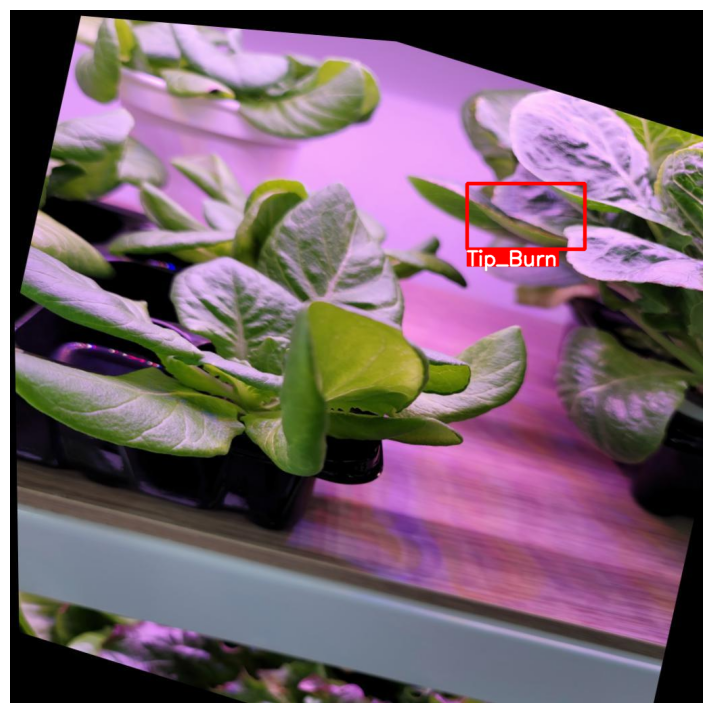

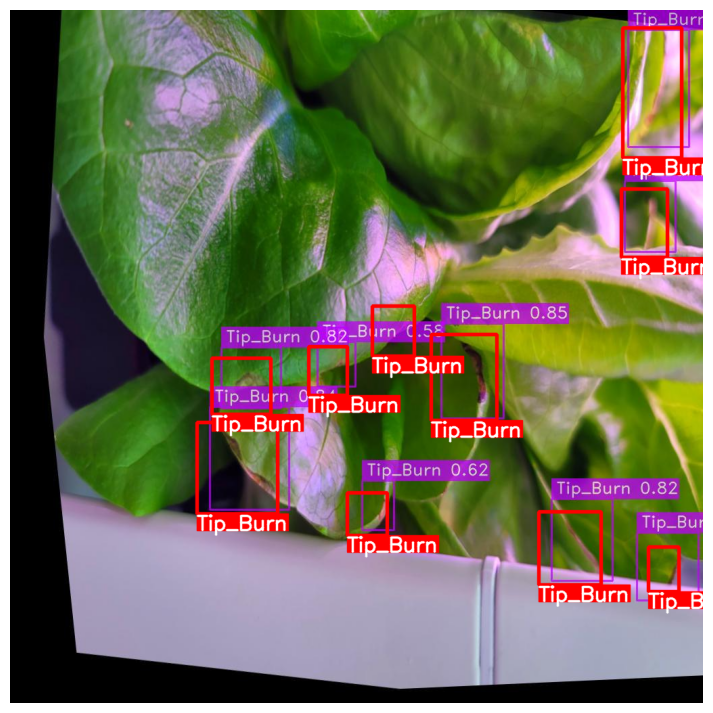

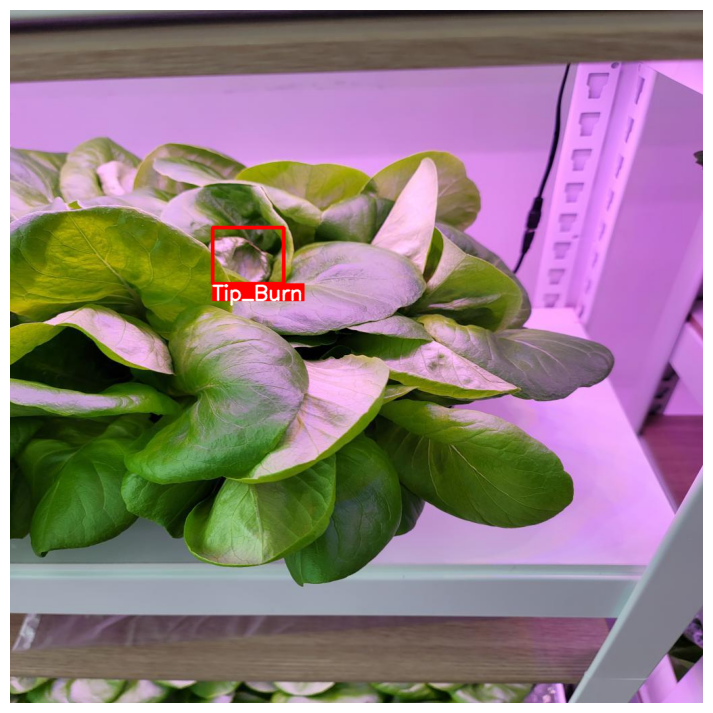

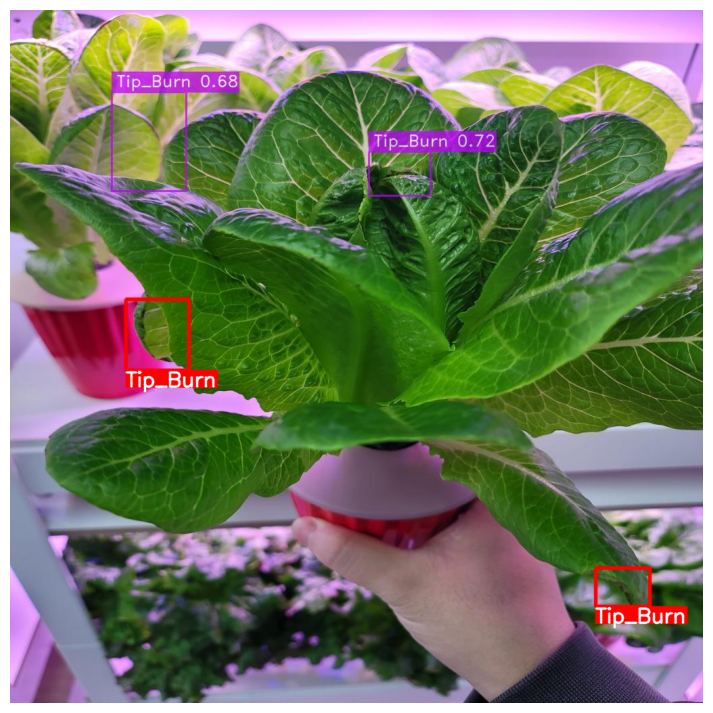

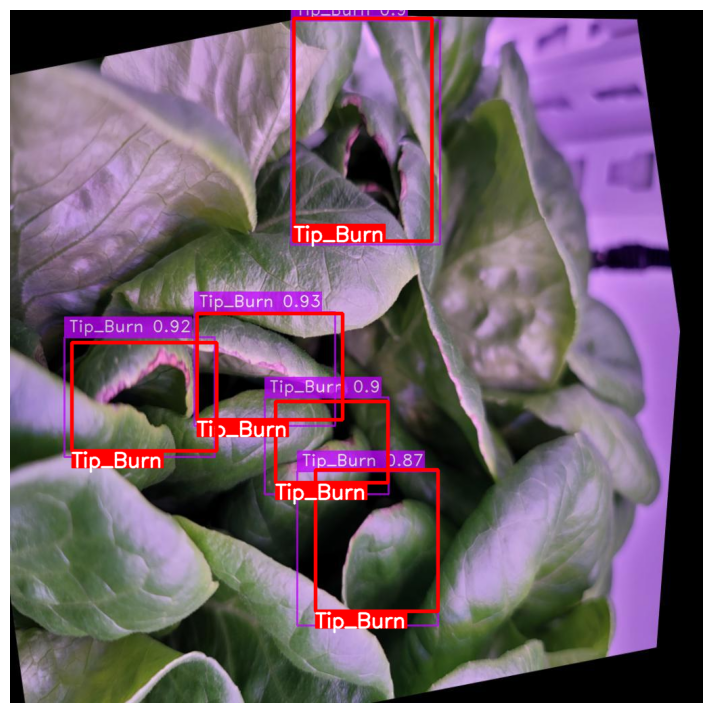

In [41]:
# Visualize a few training images.
plot(
    image_path='inference_results/images/',
    label_path='Plants-tipburn/valid/labels/',
    num_samples=5,
)